In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import zipfile
import os
import pandas as pd
import numpy as np
import pathlib
import datetime
from collections import Counter
import copy
import matplotlib.pyplot as plt
import time


/home/muhammadayub/anaconda3/envs/py35-2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Helpful Functions

In [3]:
def cleanURL(url):
    p = pathlib.Path(url)
    path = str(p.as_posix()) 
    return path 


def getDF(loc, sheetname):
    dataframe = pd.read_excel(loc, sheetname)
    #https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
    dataframe = dataframe.applymap(lambda x: x.strip() if type(x) is str else x)
    return dataframe

def printNulls(df):
    null_columns = df.columns[df.isnull().any()]
    return df[null_columns].isnull().sum() 


def writeDFToFile(dfs, path_): #dfs is an array of dataframes and their sheet names , path needs to have
    time_ = str(datetime.datetime.now())
    current_date_time = time_[0:time_.index(".")]
    current_date_time = current_date_time.replace(":", "-")
    task4_fileoutput = path_+current_date_time+".xlsx"

    writer = pd.ExcelWriter(task4_fileoutput)
    
    for df_tuple in dfs:  
        df = df_tuple[0]
        sheetName = df_tuple[1]
        df.to_excel(writer, sheetName)
    print("file written to :       " + task4_fileoutput)
    writer.save()
    
def plotImg(img):
    if(type(img) ==type(None)):
        img =outputsDataReal[10000]
    arr = []
    for a in img:
        arr = [a] + arr
    plt.pcolor( arr, cmap = 'gist_ncar' )

    plt.show()    

cwd = os.getcwd()
cwd

'/home/muhammadayub/Desktop/CS230/Notebooks/re'

# Load Data

In [4]:
CATEGORY_AMT =34

# 3 Hot Encoding Approach


In [30]:
base_filepath = "/home/muhammadayub/Desktop/CS230/training_data/minibatches_real/"

a_ = time.time()

inputData = []
outputData = []

for i_ in range(374):
    
    inputPath = base_filepath+'input_'+str(i_)+"_.npy"
    outputPath = base_filepath+'output_'+str(i_)+"_.npy"
    
#     inputMinibatch = np.load(inputPath, mmap_mode = 'r')
    outputMinibatch = np.load(outputPath, mmap_mode = 'r')
    
    oneHotVectors = np.zeros(shape=( len(outputMinibatch), CATEGORY_AMT ))
    
    
    for x_ , img in enumerate(outputMinibatch):
        cCount = Counter(img.flatten())
        mC = cCount.most_common()
        
        if(len(mC) == 2):
            if(mC[0][0] == -1):
                oneHotVectors[x_][int(mC[1][0])] = 1
            else:
                print("oh no-> assumption doesn't hold true . Recode")
        elif(len(mC) == 3):
            if(mC[0][0] == -1):
                oneHotVectors[x_][int(mC[1][0])] = .5
                oneHotVectors[x_][int(mC[2][0])] = .5
            else:
                print("oh no-> assumption doesn't hold true . Recode")
        else:#if(len(mC) == 4):
            if(mC[0][0] == -1):
                oneHotVectors[x_][int(mC[1][0])] = .33
                oneHotVectors[x_][int(mC[2][0])] = .34
                oneHotVectors[x_][int(mC[3][0])] = .33
            else:
                print("oh no-> assumption doesn't hold true . Recode")
#         elif(len(mC) == 5):
#             if(mC[0][0] == -1):
#                 oneHotVectors[x_][int(mC[1][0])] = .25
#                 oneHotVectors[x_][int(mC[2][0])] = .25
#                 oneHotVectors[x_][int(mC[3][0])] = .25
#                 oneHotVectors[x_][int(mC[4][0])] = .25
#             else:
#                 print("oh no-> assumption doesn't hold true . Recode")
#         elif(len(mC) == 6):
#             if(mC[0][0] == -1):
#                 oneHotVectors[x_][int(mC[1][0])] = .2
#                 oneHotVectors[x_][int(mC[2][0])] = .2
#                 oneHotVectors[x_][int(mC[3][0])] = .2
#                 oneHotVectors[x_][int(mC[4][0])] = .2
#                 oneHotVectors[x_][int(mC[5][0])] = .2
#             else:
#                 print("oh no-> assumption doesn't hold true . Recode")
        
        
#     inputData.append(inputMinibatch)
    outputData.append(oneHotVectors)
    
    
b_ = time.time()
   
print(b_-a_)

260.1681113243103


Convert inputs to one ndarray and outputs to one ndarray

In [32]:
inputs = None
outputs = None
inputs = np.concatenate(inputData, axis = 0)
outputs = np.concatenate(outputData, axis = 0)

In [33]:
np.set_printoptions(suppress=True) #so we don't print in scientific notation 


#get the distribution of the data ouputs to see the class representation. outputs are 3 hot encoded normalized vectors
#just add on axis =0 to see what the class totals are
classIndexes = np.arange(len(outputs[0]))
classWeightInData = np.sum(outputs, axis = 0)

print(classIndexes)
print(classWeightInData)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
[    7.67        2554.69       21092.88000001  2347.25
     0.            65.72       11782.16          74.9
  1581.36           3.52         340.1            0.
     2.83           0.83           3.48           2.99
  1378.77        7770.61           0.             0.
     0.             0.            61.67           0.
  1685.73          15.86           0.            14.96
     0.           304.19          50.26           0.33
 23635.31000003    21.93      ]


In [34]:
# looks like classes 32 and are the highest we will down sample those 
print(len(outputs))

74800


# To prevent Class Imbalances: 

    Strategy is to upsample less represented classes and downsample the more represented classes. To do this, we set the amount of weight that every class should have. We have chosen the weight to be around 1000. Since we encode upto 3 bits in our 3 hot encoding -> we can have a weight of either 1, .5, or .3. So worst case, a class will have about 3000 samples representing it while best case, it will have 1000 sample representing it. 


## Step 1. Upsample Datapoints that relate to classes that are less in number

In [35]:
upsampled_inputs = []
upsampled_outputs = []
sampleIndicesOfDataPointsToDuplicate = []

In [36]:
#class 0
class0 = np.where(outputs[:,0] !=0)
print(len(class0[0])) #only 16 data points just duplicate all of them several 100 times 

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class0[0].tolist()*100


16


In [37]:
#class 5
class5 = np.where(outputs[:,5] !=0)
print(len(class5[0])) #only 109 data points just duplicate all of them several 15

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class5[0].tolist()*15

109


In [38]:
#class 7
class7 = np.where(outputs[:,7] !=0)
print(len(class7[0])) #only 204 data points just duplicate all of them 12 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class7[0].tolist()*12


204


In [39]:
#class 9
class9 = np.where(outputs[:,9] !=0)
print(len(class9[0])) #only 6 data points just duplicate all of them 250 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class9[0].tolist()*250


6


In [40]:
#class 10
class10 = np.where(outputs[:,10] !=0)
print(len(class10[0])) #only 456 data points just duplicate all of them 3

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class10[0].tolist()*3


456


In [41]:
#data check 
# len(sampleIndicesOfDataPointsToDuplicate)
# np.sum(outputs, axis = 0)
print(len(set(sampleIndicesOfDataPointsToDuplicate)))
print(len(sampleIndicesOfDataPointsToDuplicate))
abc = outputs[sampleIndicesOfDataPointsToDuplicate]
np.sum(abc, axis = 0)

781
8551


array([ 767.  ,  157.82,  927.78,   26.76,    0.  ,  992.76,  146.57,
        902.76,  250.56,  880.  , 1071.63,    0.  ,    0.  ,    0.  ,
         33.  ,    2.49,  760.02,  146.88,    0.  ,    0.  ,    0.  ,
          0.  ,   86.43,    0.  ,  207.18,    0.  ,    0.  ,    0.  ,
          0.  ,    7.56,   36.48,    0.  , 1108.22,   39.1 ])

In [42]:
#class 12
class12 = np.where(outputs[:,12] !=0)
print(len(class12[0])) #only 5 data points for 2.83 weight just duplicate all of them 350 time 

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class12[0].tolist()*350


5


In [43]:
#class 13
class13 = np.where(outputs[:,13] !=0)
print(len(class13[0])) #only 2 data points for .83 weight just duplicate all of them 1000 

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class13[0].tolist()*1000


2


In [44]:
#class 14
class14 = np.where(outputs[:,14] !=0)
print(len(class14[0])) #only 8 data points for 3.48 weight just duplicate all of them 250

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class14[0].tolist()*250


8


In [45]:
#class 15
class15 = np.where(outputs[:,15] !=0)
print(len(class15[0])) #only 7 data points for 3 weight just duplicate all of them 300

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class15[0].tolist()*300


7


In [46]:
#data check 2 
# len(sampleIndicesOfDataPointsToDuplicate)
# np.sum(outputs, axis = 0)
print(len(set(sampleIndicesOfDataPointsToDuplicate)))
print(len(sampleIndicesOfDataPointsToDuplicate))
abc = outputs[sampleIndicesOfDataPointsToDuplicate]
np.sum(abc, axis = 0)

800
16401


array([ 849.5 ,  497.82,  927.78,   26.76,    0.  ,  992.76,  146.57,
        902.76,  525.56,  880.  , 1323.63,    0.  ,  990.5 ,  830.  ,
        903.  ,  899.49, 1801.52,  534.88,    0.  ,    0.  ,    0.  ,
          0.  ,   86.43,    0.  ,  957.18,  260.  ,    0.  ,    0.  ,
          0.  ,  157.56,   36.48,    0.  , 1831.72,   39.1 ])

In [47]:
#class 22
class22 = np.where(outputs[:,22] !=0)
print(len(class22[0])) #only 132 data points for ~60 weight just duplicate all of them 11 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class22[0].tolist()*11


132


In [48]:
#class 25
class25 = np.where(outputs[:,25] !=0)
print(len(class25[0])) #only 36 data points for ~15 weight just duplicate all of them 50 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class25[0].tolist()*50


36


In [49]:
#class 27
class27 = np.where(outputs[:,27] !=0)
print(len(class27[0])) #only 25 data points for ~14 weight just duplicate all of them 70 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class27[0].tolist()*50


25


In [50]:
#class 29
class29 = np.where(outputs[:,29] !=0)
print(len(class29[0])) #only 845 data points for ~14 weight just duplicate all of them 3 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class29[0].tolist()*3



845


In [51]:
#class 30
class30 = np.where(outputs[:,30] !=0)
print(len(class30[0])) #only 85 data points for ~50 weight just duplicate all of them 16 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class30[0].tolist()*16




85


In [52]:
#class 31
class31 = np.where(outputs[:,31] !=0)
print(len(class31[0])) #only 1 data point for ~.33 weight just duplicate all of them 3000 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class31[0].tolist()*3000







1


In [53]:
#class 33
class33 = np.where(outputs[:,33] !=0)
print(len(class33[0])) #only 54 data points for 21.93 weight just duplicate all of them 48 times

sampleIndicesOfDataPointsToDuplicate = sampleIndicesOfDataPointsToDuplicate + class33[0].tolist()*48


54


In [54]:
#data check 2 
# len(sampleIndicesOfDataPointsToDuplicate)
# np.sum(outputs, axis = 0)
print(len(set(sampleIndicesOfDataPointsToDuplicate)))
print(len(sampleIndicesOfDataPointsToDuplicate))
abc = outputs[sampleIndicesOfDataPointsToDuplicate]
np.sum(abc, axis = 0)+np.sum(outputs, axis = 0)

1936
30390


array([  878.45      ,  3150.04      , 23357.12000001,  2440.18      ,
           0.        ,  1123.49      , 12214.67      ,   987.78      ,
        2547.68      ,   883.52      ,  1715.63      ,     0.        ,
        1018.33      ,   830.83      ,   922.98      ,   903.98      ,
        3910.16      ,  8577.02      ,     0.        ,     0.        ,
           0.        ,     0.        ,   878.71      ,     0.        ,
        3919.71      ,  1072.6       ,     0.        ,   762.96      ,
           0.        ,  1377.95      ,   914.66      ,   990.33      ,
       28697.55000003,  1113.67      ])

In [55]:
outputs2 = outputs[sampleIndicesOfDataPointsToDuplicate]
inputs2 = inputs[sampleIndicesOfDataPointsToDuplicate]


In [57]:
print(outputs.shape)
print(outputs2.shape)

print(inputs.shape)
print(inputs2.shape)

(74800, 34)
(30390, 34)


AttributeError: 'NoneType' object has no attribute 'shape'

105190

## Step 2. Now that we have upsampled, we have more data and need to remove the classes that still have way too much weight. Downsample Datapoints 

Use np.random.choice() to get the downsample indices -> switch them to 0

In [58]:
#class 32 - 
# np.sum(outputs[:,2])
class32 = np.where(outputs[:,32] !=0)
indicesToSetToZero = np.random.choice(class32[0], 52000)
outputs[indicesToSetToZero,32] = 0.


In [60]:
#class 32
class2 = np.where(outputs[:,2] !=0)
indicesToSetToZero = np.random.choice(class2[0], 52000)
outputs[indicesToSetToZero,2] = 0.

In [61]:
#remove vectors that are zero now
abc = np.where(outputs != 0)
print(len(abc))
print(len(abc[0]))
allIndicesWithSomething = set(abc[0])

allIndicesWithNothing = set(np.arange(len(outputs)).tolist()) - allIndicesWithSomething

print(allIndicesWithNothing)
indices_list = list(allIndicesWithSomething)

2
148384
{513, 30209, 1542, 1545, 1034, 523, 12, 2069, 1046, 1531, 1558, 1053, 1054, 31, 2591, 545, 546, 549, 2043, 552, 2087, 44072, 2603, 2604, 1070, 559, 2096, 1073, 563, 564, 1077, 1078, 43069, 1086, 575, 64, 65, 577, 67, 68, 578, 1090, 1603, 2116, 2558, 2634, 42059, 76, 1616, 1617, 1106, 1108, 1110, 2136, 601, 602, 2140, 94, 608, 1121, 2147, 102, 1129, 1134, 1650, 34426, 635, 1662, 639, 640, 641, 642, 28805, 140, 141, 1172, 1173, 156, 157, 1696, 162, 1187, 164, 677, 678, 167, 42664, 1706, 1196, 1708, 175, 2735, 1201, 2225, 185, 47289, 1211, 1723, 704, 705, 194, 197, 199, 1735, 202, 714, 1228, 1232, 210, 1746, 1237, 726, 2265, 732, 1245, 39645, 737, 740, 1764, 230, 1254, 1765, 1767, 746, 2277, 2796, 1776, 1267, 1785, 1279, 1792, 257, 1794, 1796, 1285, 774, 1799, 43270, 265, 1290, 1291, 269, 783, 1295, 1299, 276, 1815, 287, 2337, 1317, 1830, 807, 296, 2344, 46886, 1326, 817, 825, 2362, 832, 835, 841, 332, 1357, 335, 44879, 850, 1366, 347, 1372, 1375, 361, 2409, 1389, 2417, 37234, 37

In [62]:
# Write the data to file 
np.save('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputs', outputs  )
np.save( '/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputs2',outputs2 )
# np.save( '/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputs',inputs )
# np.save( '/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputs2',inputs2 )

In [63]:
inputs = None
inputs2 = None
outputs = np.concatenate([outputs, outputs2], axis = 0)

print(outputs.shape)
# save as one file: 
np.save('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputsTotal', outputs  )

(105190, 34)


In [5]:
outputs = None
outputs2 = None
inputs = np.load( '/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputs.npy', 'r' )
inputs2 = np.load( '/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputs2.npy', 'r' )

In [8]:
inputs = np.concatenate([inputs,inputs2] , axis =0)

In [9]:
np.save('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputsTotal.npy', inputs  )



In [26]:
outputs = np.load('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputs.npy' )
outputs2 = np.load( '/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputs2.npy' )

In [29]:
outputs.shape

(74596, 34)

In [75]:
# get the outputs data
outputs = np.load('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputsTotal.npy','r')
inputs = np.load('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputsTotal.npy','r')
print(outputs.shape)
print(inputs.shape)


(105190, 34)
(105190, 64, 64, 28)


In [76]:
abc = np.where(outputs!=0)
indicesWithNonZero = list(set(abc[0]))

outputs = outputs[indicesWithNonZero]
inputs = inputs[indicesWithNonZero]

In [78]:
print(outputs.shape)
print(inputs.shape)


(104960, 34)
(104960, 64, 64, 28)


In [79]:
# done with the data -> now we simply sample it out
# now just take the data -> remove to multiple of 200
# then split into minibatchs 
outputs = outputs[:104800]
inputs = inputs[:104800]




In [81]:
104800/200

524.0

In [80]:
print(datetime.time())
np.save('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/outputsTotal2.npy', outputs  )
np.save('/home/muhammadayub/Desktop/CS230/training_data/minibatches_12_16_3hot_normalized/inputsTotal2.npy', inputs  )
print(datetime.time())

00:00:00
00:00:00


In [82]:
#split the data to minibatches
MINIBATCHES_AMT = 524 # number of minibatches 
inputs = np.split(inputs, MINIBATCHES_AMT )
outputs = np.split(outputs, MINIBATCHES_AMT )                  

In [83]:

miniBatchIndices = np.arange(MINIBATCHES_AMT)
train_split = int(MINIBATCHES_AMT*.90)
dev_split = int(MINIBATCHES_AMT*.05)
test_split = MINIBATCHES_AMT - train_split - dev_split
print(train_split, dev_split, test_split )

471 26 27


In [84]:
np.random.shuffle(miniBatchIndices)
miniBatchIndices

array([337, 244, 460, 421, 319,  51, 410, 206, 382, 110, 170, 207, 367,
       137, 420,  19, 296, 522, 483, 144,  94, 405, 322, 314, 182, 356,
       166,   1,  74, 278, 309, 173, 442, 304, 404, 159, 490,  70,  68,
        88, 333, 230, 334, 202, 423, 236, 131, 330,  37, 147, 195,   5,
       362, 503, 436, 508, 128, 325,  26, 370, 120, 498,  76, 129, 506,
        73, 148, 316, 444, 212, 456, 119, 194, 109, 443, 171, 155, 425,
       118, 141,  87, 222, 324, 435, 481, 287, 450, 520, 318, 132, 482,
       227,  81, 181, 216,  50, 359, 143, 335, 478, 465, 226, 136, 479,
       454, 239, 455,  38, 317, 250, 453, 150, 462, 484, 512, 295,  92,
       114, 472, 191, 217, 233,  90, 133, 247, 127, 274, 101,  64,  91,
       196, 328, 169,  47, 178,  22, 463, 507, 375, 470, 248, 345, 497,
         0, 365, 477, 515, 403, 342, 211, 225, 416,  10, 175, 414, 113,
         2, 124, 123, 397,  16, 243, 500, 187, 205, 112, 245,  65,  84,
       165,  85, 311,  18,  53, 457, 446, 122, 408,  77, 509, 39

In [85]:

backup_minibatches = copy.deepcopy(miniBatchIndices)

devMiniBatches = copy.deepcopy(miniBatchIndices[train_split:train_split+dev_split])
testMiniBatches = copy.deepcopy(miniBatchIndices[train_split+dev_split:])# remove the last minibatch
minibatches = copy.deepcopy(miniBatchIndices[:train_split]) #training set  #must be at the end

# print(len(devMiniBatches+testMiniBatches+minibatches))
print(len(devMiniBatches), len(testMiniBatches) , len(minibatches))
print(devMiniBatches)
print(testMiniBatches)
print(minibatches)

np.save( '/home/muhammadayub/Desktop/CS230/models_saved/model6/devMiniBatches.npy' , devMiniBatches)
np.save( '/home/muhammadayub/Desktop/CS230/models_saved/model6/testMiniBatches.npy' , testMiniBatches)
np.save( '/home/muhammadayub/Desktop/CS230/models_saved/model6/minibatches.npy' , minibatches)

26 27 471
[289 271  79 293  71 377 180 265 115 415  43  55 294 320 253 432 145  56
 146 434 279  44 327 134 394 163]
[234 162  78 209 220 302  49 424 258 283 130  32 203 305 485 125  20  45
 336 413  58 183   6 366 266 521 338]
[337 244 460 421 319  51 410 206 382 110 170 207 367 137 420  19 296 522
 483 144  94 405 322 314 182 356 166   1  74 278 309 173 442 304 404 159
 490  70  68  88 333 230 334 202 423 236 131 330  37 147 195   5 362 503
 436 508 128 325  26 370 120 498  76 129 506  73 148 316 444 212 456 119
 194 109 443 171 155 425 118 141  87 222 324 435 481 287 450 520 318 132
 482 227  81 181 216  50 359 143 335 478 465 226 136 479 454 239 455  38
 317 250 453 150 462 484 512 295  92 114 472 191 217 233  90 133 247 127
 274 101  64  91 196 328 169  47 178  22 463 507 375 470 248 345 497   0
 365 477 515 403 342 211 225 416  10 175 414 113   2 124 123 397  16 243
 500 187 205 112 245  65  84 165  85 311  18  53 457 446 122 408  77 509
 393 256 332 480 396 184 523  25 315 240 4

In [97]:
minibatches = minibatches[:470]
#have double sized minibatches, need to make the length 470 instead of 471
np.save( '/home/muhammadayub/Desktop/CS230/models_saved/model6/minibatches.npy' , minibatches)

# Model Definition (based off research paper)

In [89]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """


    X = tf.placeholder(shape =[None, n_H0, n_W0, n_C0], dtype = np.float32, name="X")
    Y = tf.placeholder(shape  =[None, n_y], dtype = np.float32 , name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [90]:
X, Y = create_placeholders(64, 64, 26, CATEGORY_AMT)  #will have 35 , 34 real values and 1 fake value
print ("X = " + str(X))
print ("Y = " + str(Y))


X = Tensor("X:0", shape=(?, 64, 64, 26), dtype=float32)
Y = Tensor("Y:0", shape=(?, 34), dtype=float32)


## First CNN Trial

### First filter shape: (10 , 10,3 , 3) stride = 2, valid padding
    
    (64 +2p - f)/s +1 => (64+0-10)/2+1 = 28
    So, (?, 64, 64, 3) * (10 , 10 , 3,  3) = (?, 28, 28, 3 )
    
### Average Pooling Layer: (3 , 3 , 3) stride = 1, Padding = SAME
    
    (28 +2p - f)/s +1 => (28+2*1-3)/1+1 = 28
    So, (?, 28, 28, 3) * ( 3 , 3,  3) = (?, 28, 28, 3 )
    
    
### Second filter shape: (6 , 6 ,3, 2) stride = 2, valid padding
    
    (28 +2p - f)/s +1 => (28+0-6)/2+1 = 12
    So, (?, 28, 28, 3) * (6 , 6 , 3, 2) = (?, 12, 12, 2)
    
### Max Pooling layer valid padding stride 1 (3,3)
    
    (12 +2p - f)/s +1 => (12+0-3)/1+1 = 10
    So, (?, 12,12, 2) * (3, 3 , 2, 2) = (?, 10, 10, 2)

    
### Fourth filter shape: Flatten , fully connected (10*10*2) = 200
    
    W3 = 36 by 200
    
### Softmax function for evaluation    


In [91]:
def initialize_parameters():    

    W1 = tf.get_variable("W1", [10, 10, 28, 10], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [6, 6, 10, 2], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [35,200] , initializer =tf.contrib.layers.xavier_initializer(seed = 0) )

    parameters = {"W1": W1, "W2": W2 , 'W3': 'W3'}
    
    return parameters

In [92]:
def forward_prop(X, params):
    W1 = params['W1']
    W2 = params['W2']    
    W3 = params['W3']
    
    #convolution 
    Z1 = tf.nn.conv2d(X,W1, strides = [1,2,2,1], padding = 'VALID')
    
    #bias added automatically # RELU
    A1 = tf.nn.relu(Z1)
    
    #average pooling -> at this point all features/weights are important to us
    P1 = tf.nn.avg_pool(A1, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'SAME')

    # convolution 
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,2,2,1], padding = 'VALID')
    
    #RELU
    A2 = tf.nn.relu(Z2)
    
    #max pooling
    P2 = tf.nn.max_pool(A2, ksize = [1,3,3,1], strides = [1,1,1,1], padding = 'VALID')
    
    #flatten
    P2 = tf.contrib.layers.flatten(P2)

    #fully connected
    Z3 = tf.contrib.layers.fully_connected(P2, CATEGORY_AMT, activation_fn = None) #1 for yes/no
    #going to add the softmax directly

    return Z3

# Run or Train the model

In [107]:
doubleMinibatches = np.split(minibatches, int(len(minibatches)/2))
for i_ in doubleMinibatches:
#     print(i_[0], i_[1])
    pass

print(len(inputs))
print(len(outputs))
outputData = outputs
inputData = inputs

524
524


In [108]:
# tf.reset_default_graph()

base_filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model6/"
filepath =None # put in global namespace for ease of using later
learning_rate = .003
costs = []
num_epochs = 200


graph = tf.Graph()
with graph.as_default(): # https://stackoverflow.com/questions/36281129/no-variable-to-save-error-in-tensorflow

    #variable declarations must be before tf.train.Saver() unless here: https://stackoverflow.com/questions/50974976/tensorflow-why-must-saver-tf-train-saver-be-declared-after-variables-are
    #the model
    X, Y = create_placeholders(64, 64, 28, CATEGORY_AMT)
    parameters = initialize_parameters()
    Z3 = forward_prop(X, parameters)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)

    
    saver = tf.train.Saver()

    # # Initialize all the variables globally
    # init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:


        #init must be after optimizer
        init = tf.global_variables_initializer()

        # Run the initialization
        sess.run(init)
        print('Starting ' , datetime.datetime.now())
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            np.random.shuffle(doubleMinibatches) # get new minibatch results 
            
            countOfMinibatch = 0 
            for i_ in doubleMinibatches:
#                 print(i_)
                # Select a minibatch
                output_image64_a = outputData[i_[0]]
                output_image64_b = outputData[i_[1]]
                
                inputImage64_a =inputData[i_[0]]
                inputImage64_b =inputData[i_[1]]

                output_image64 = np.concatenate([output_image64_a, output_image64_b], axis = 0)
                inputImage64 =  np.concatenate([inputImage64_a, inputImage64_b], axis = 0)


                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: inputImage64, Y: output_image64})
                ### END CODE HERE ###

                minibatch_cost += temp_cost / MINIBATCHES_AMT

                print('Minibatch End: ', datetime.datetime.now())
                print(temp_cost,' ' , epoch,' ' ,countOfMinibatch)
                
                if(countOfMinibatch % 20 == 0 ):
                    #save model
                    filepath = base_filepath+"/model6_12_15__"+str(epoch)+"_"+str(countOfMinibatch)+".ckpt"
                    print(temp_cost, " at file name: ", filepath[25:])
                    save_path = saver.save(sess, filepath)
                
                
                countOfMinibatch+=1

                
                
            costs.append(minibatch_cost)
            print('Epoch End: ', datetime.datetime.now())


# if((epoch ==0) and (i_==0)):
#     globalA = inputImage64     #model5/model3_12_9__541_160.ckpt
#     globalB = output_image64

Starting  2018-12-15 19:13:53.503052
Minibatch End:  2018-12-15 19:13:54.677043
2.7139323   0   0
2.7139323  at file name:  p/CS230/models_saved/model6//model6_12_15__0_0.ckpt
Minibatch End:  2018-12-15 19:13:55.865490
3.4021094   0   1
Minibatch End:  2018-12-15 19:13:57.053074
2.8085356   0   2
Minibatch End:  2018-12-15 19:13:58.239432
2.3122327   0   3
Minibatch End:  2018-12-15 19:13:59.411181
3.5159698   0   4
Minibatch End:  2018-12-15 19:14:00.599293
2.942299   0   5
Minibatch End:  2018-12-15 19:14:01.815834
2.2659218   0   6
Minibatch End:  2018-12-15 19:14:03.002378
2.3504326   0   7
Minibatch End:  2018-12-15 19:14:04.203385
2.3238742   0   8
Minibatch End:  2018-12-15 19:14:05.394675
2.3408291   0   9
Minibatch End:  2018-12-15 19:14:06.563578
2.9675813   0   10
Minibatch End:  2018-12-15 19:14:07.743384
2.2795234   0   11
Minibatch End:  2018-12-15 19:14:08.941036
3.5028467   0   12
Minibatch End:  2018-12-15 19:14:10.136313
2.3407192   0   13
Minibatch End:  2018-12-15 1

Minibatch End:  2018-12-15 19:16:19.610315
2.102392   0   123
Minibatch End:  2018-12-15 19:16:20.787499
3.477257   0   124
Minibatch End:  2018-12-15 19:16:21.957285
2.117195   0   125
Minibatch End:  2018-12-15 19:16:23.138509
2.137885   0   126
Minibatch End:  2018-12-15 19:16:24.317146
2.0915213   0   127
Minibatch End:  2018-12-15 19:16:25.508066
2.0702662   0   128
Minibatch End:  2018-12-15 19:16:26.687663
3.368878   0   129
Minibatch End:  2018-12-15 19:16:27.925947
2.6916838   0   130
Minibatch End:  2018-12-15 19:16:29.199643
2.793599   0   131
Minibatch End:  2018-12-15 19:16:30.394334
2.0591104   0   132
Minibatch End:  2018-12-15 19:16:31.572177
2.1139994   0   133
Minibatch End:  2018-12-15 19:16:32.747215
2.1096177   0   134
Minibatch End:  2018-12-15 19:16:33.909488
2.718915   0   135
Minibatch End:  2018-12-15 19:16:35.056374
3.2460597   0   136
Minibatch End:  2018-12-15 19:16:36.229100
2.654835   0   137
Minibatch End:  2018-12-15 19:16:37.393038
2.1219718   0   138


Minibatch End:  2018-12-15 19:18:45.543480
2.6599712   1   11
Minibatch End:  2018-12-15 19:18:46.707985
1.9130265   1   12
Minibatch End:  2018-12-15 19:18:47.876253
2.5174701   1   13
Minibatch End:  2018-12-15 19:18:49.045611
2.5977638   1   14
Minibatch End:  2018-12-15 19:18:50.244026
1.9914416   1   15
Minibatch End:  2018-12-15 19:18:51.418969
1.9051981   1   16
Minibatch End:  2018-12-15 19:18:52.589458
2.635511   1   17
Minibatch End:  2018-12-15 19:18:53.759300
2.6791146   1   18
Minibatch End:  2018-12-15 19:18:54.924069
2.5234072   1   19
Minibatch End:  2018-12-15 19:18:56.118370
3.439879   1   20
3.439879  at file name:  p/CS230/models_saved/model6//model6_12_15__1_20.ckpt
Minibatch End:  2018-12-15 19:18:57.292499
2.6571832   1   21
Minibatch End:  2018-12-15 19:18:58.448392
2.5414863   1   22
Minibatch End:  2018-12-15 19:18:59.600436
1.9546031   1   23
Minibatch End:  2018-12-15 19:19:00.772905
1.9551889   1   24
Minibatch End:  2018-12-15 19:19:01.940966
2.6481266   1

Minibatch End:  2018-12-15 19:21:12.011214
3.125584   1   136
Minibatch End:  2018-12-15 19:21:13.185884
1.8481097   1   137
Minibatch End:  2018-12-15 19:21:14.343896
1.8254251   1   138
Minibatch End:  2018-12-15 19:21:15.494010
1.8272223   1   139
Minibatch End:  2018-12-15 19:21:16.649077
1.8260722   1   140
1.8260722  at file name:  p/CS230/models_saved/model6//model6_12_15__1_140.ckpt
Minibatch End:  2018-12-15 19:21:17.843911
2.4484527   1   141
Minibatch End:  2018-12-15 19:21:18.992267
1.8071567   1   142
Minibatch End:  2018-12-15 19:21:20.140946
2.639143   1   143
Minibatch End:  2018-12-15 19:21:21.296258
1.8262576   1   144
Minibatch End:  2018-12-15 19:21:22.447345
1.8383032   1   145
Minibatch End:  2018-12-15 19:21:23.599790
1.7378356   1   146
Minibatch End:  2018-12-15 19:21:24.764424
2.6283374   1   147
Minibatch End:  2018-12-15 19:21:25.923744
2.5468688   1   148
Minibatch End:  2018-12-15 19:21:27.103079
2.681031   1   149
Minibatch End:  2018-12-15 19:21:28.26164

Minibatch End:  2018-12-15 19:23:33.916640
3.5438836   2   23
Minibatch End:  2018-12-15 19:23:35.077443
3.4682367   2   24
Minibatch End:  2018-12-15 19:23:36.236662
2.625342   2   25
Minibatch End:  2018-12-15 19:23:37.402771
1.7134479   2   26
Minibatch End:  2018-12-15 19:23:38.564998
1.703546   2   27
Minibatch End:  2018-12-15 19:23:39.724109
1.7351855   2   28
Minibatch End:  2018-12-15 19:23:40.886061
2.5575173   2   29
Minibatch End:  2018-12-15 19:23:42.049294
1.6519895   2   30
Minibatch End:  2018-12-15 19:23:43.215076
1.7078127   2   31
Minibatch End:  2018-12-15 19:23:44.378362
2.5127   2   32
Minibatch End:  2018-12-15 19:23:45.546484
1.7562579   2   33
Minibatch End:  2018-12-15 19:23:46.716379
2.4926128   2   34
Minibatch End:  2018-12-15 19:23:47.880047
2.5907722   2   35
Minibatch End:  2018-12-15 19:23:49.047234
1.7069421   2   36
Minibatch End:  2018-12-15 19:23:50.206511
1.8175739   2   37
Minibatch End:  2018-12-15 19:23:51.370207
2.6257715   2   38
Minibatch End

Minibatch End:  2018-12-15 19:25:59.126077
2.592796   2   148
Minibatch End:  2018-12-15 19:26:00.291406
2.2064598   2   149
Minibatch End:  2018-12-15 19:26:01.462025
1.6973358   2   150
Minibatch End:  2018-12-15 19:26:02.602150
1.6531192   2   151
Minibatch End:  2018-12-15 19:26:03.772697
3.1454651   2   152
Minibatch End:  2018-12-15 19:26:04.930095
2.5087311   2   153
Minibatch End:  2018-12-15 19:26:06.079990
1.7553291   2   154
Minibatch End:  2018-12-15 19:26:07.234822
2.8172705   2   155
Minibatch End:  2018-12-15 19:26:08.400178
1.6004503   2   156
Minibatch End:  2018-12-15 19:26:09.562038
2.5745156   2   157
Minibatch End:  2018-12-15 19:26:10.722011
2.2139382   2   158
Minibatch End:  2018-12-15 19:26:11.885959
2.507299   2   159
Minibatch End:  2018-12-15 19:26:13.037926
3.4571173   2   160
3.4571173  at file name:  p/CS230/models_saved/model6//model6_12_15__2_160.ckpt
Minibatch End:  2018-12-15 19:26:14.230286
1.6307495   2   161
Minibatch End:  2018-12-15 19:26:15.4002

Minibatch End:  2018-12-15 19:28:23.308123
1.6483777   3   37
Minibatch End:  2018-12-15 19:28:24.473809
1.6990902   3   38
Minibatch End:  2018-12-15 19:28:25.622790
3.2303379   3   39
Minibatch End:  2018-12-15 19:28:26.780697
1.6061003   3   40
1.6061003  at file name:  p/CS230/models_saved/model6//model6_12_15__3_40.ckpt
Minibatch End:  2018-12-15 19:28:27.969448
2.5329008   3   41
Minibatch End:  2018-12-15 19:28:29.137927
1.6465992   3   42
Minibatch End:  2018-12-15 19:28:30.301393
1.7424661   3   43
Minibatch End:  2018-12-15 19:28:31.466687
2.504368   3   44
Minibatch End:  2018-12-15 19:28:32.630884
1.6254339   3   45
Minibatch End:  2018-12-15 19:28:33.796639
2.625901   3   46
Minibatch End:  2018-12-15 19:28:34.963453
2.53055   3   47
Minibatch End:  2018-12-15 19:28:36.131281
2.864137   3   48
Minibatch End:  2018-12-15 19:28:37.305998
2.1983137   3   49
Minibatch End:  2018-12-15 19:28:38.469029
1.6024055   3   50
Minibatch End:  2018-12-15 19:28:39.632764
3.45647   3   5

Minibatch End:  2018-12-15 19:30:47.607365
2.4052644   3   161
Minibatch End:  2018-12-15 19:30:48.769840
2.5032723   3   162
Minibatch End:  2018-12-15 19:30:49.931789
2.3361838   3   163
Minibatch End:  2018-12-15 19:30:51.090650
2.4561927   3   164
Minibatch End:  2018-12-15 19:30:52.252231
2.6887908   3   165
Minibatch End:  2018-12-15 19:30:53.416814
2.5836737   3   166
Minibatch End:  2018-12-15 19:30:54.560089
2.1834977   3   167
Minibatch End:  2018-12-15 19:30:55.739306
1.5991225   3   168
Minibatch End:  2018-12-15 19:30:56.901505
1.5743159   3   169
Minibatch End:  2018-12-15 19:30:58.064902
2.4741662   3   170
Minibatch End:  2018-12-15 19:30:59.239260
1.539115   3   171
Minibatch End:  2018-12-15 19:31:00.405039
2.1586235   3   172
Minibatch End:  2018-12-15 19:31:01.568878
2.516949   3   173
Minibatch End:  2018-12-15 19:31:02.735344
2.3700836   3   174
Minibatch End:  2018-12-15 19:31:03.890492
2.163282   3   175
Minibatch End:  2018-12-15 19:31:05.052624
1.6071365   3  

Minibatch End:  2018-12-15 19:33:11.882502
2.4245527   4   50
Minibatch End:  2018-12-15 19:33:13.049280
3.208512   4   51
Minibatch End:  2018-12-15 19:33:14.208841
1.6480892   4   52
Minibatch End:  2018-12-15 19:33:15.359512
3.1788802   4   53
Minibatch End:  2018-12-15 19:33:16.526074
1.533779   4   54
Minibatch End:  2018-12-15 19:33:17.681663
2.5310483   4   55
Minibatch End:  2018-12-15 19:33:18.864110
2.512425   4   56
Minibatch End:  2018-12-15 19:33:20.027159
3.4905887   4   57
Minibatch End:  2018-12-15 19:33:21.178277
1.5747974   4   58
Minibatch End:  2018-12-15 19:33:22.327145
1.5260816   4   59
Minibatch End:  2018-12-15 19:33:23.473338
3.2296112   4   60
3.2296112  at file name:  p/CS230/models_saved/model6//model6_12_15__4_60.ckpt
Minibatch End:  2018-12-15 19:33:24.656291
2.4796925   4   61
Minibatch End:  2018-12-15 19:33:25.815548
2.5176344   4   62
Minibatch End:  2018-12-15 19:33:26.975050
3.5101404   4   63
Minibatch End:  2018-12-15 19:33:28.138415
1.5682993   4

Minibatch End:  2018-12-15 19:35:36.051852
1.5909995   4   174
Minibatch End:  2018-12-15 19:35:37.216321
1.5854712   4   175
Minibatch End:  2018-12-15 19:35:38.370147
1.5811548   4   176
Minibatch End:  2018-12-15 19:35:39.526718
1.5052844   4   177
Minibatch End:  2018-12-15 19:35:40.680431
2.1455288   4   178
Minibatch End:  2018-12-15 19:35:41.840178
1.5682526   4   179
Minibatch End:  2018-12-15 19:35:42.991622
2.5370972   4   180
2.5370972  at file name:  p/CS230/models_saved/model6//model6_12_15__4_180.ckpt
Minibatch End:  2018-12-15 19:35:44.174041
1.6246921   4   181
Minibatch End:  2018-12-15 19:35:45.334526
1.5504111   4   182
Minibatch End:  2018-12-15 19:35:46.495300
2.4914837   4   183
Minibatch End:  2018-12-15 19:35:47.638179
1.6331798   4   184
Minibatch End:  2018-12-15 19:35:48.801623
3.2000017   4   185
Minibatch End:  2018-12-15 19:35:49.950387
1.6507388   4   186
Minibatch End:  2018-12-15 19:35:51.108844
1.5575305   4   187
Minibatch End:  2018-12-15 19:35:52.27

Minibatch End:  2018-12-15 19:37:59.075981
2.7371674   5   62
Minibatch End:  2018-12-15 19:38:00.250084
2.5253587   5   63
Minibatch End:  2018-12-15 19:38:01.405915
2.2084568   5   64
Minibatch End:  2018-12-15 19:38:02.561286
2.4186637   5   65
Minibatch End:  2018-12-15 19:38:03.725928
2.4953868   5   66
Minibatch End:  2018-12-15 19:38:04.892099
3.616353   5   67
Minibatch End:  2018-12-15 19:38:06.052014
1.5811096   5   68
Minibatch End:  2018-12-15 19:38:07.206968
2.5732856   5   69
Minibatch End:  2018-12-15 19:38:08.358178
1.5599176   5   70
Minibatch End:  2018-12-15 19:38:09.515745
2.389127   5   71
Minibatch End:  2018-12-15 19:38:10.684264
1.5481424   5   72
Minibatch End:  2018-12-15 19:38:11.851053
2.661608   5   73
Minibatch End:  2018-12-15 19:38:13.002187
1.5626459   5   74
Minibatch End:  2018-12-15 19:38:14.156790
2.5363967   5   75
Minibatch End:  2018-12-15 19:38:15.322255
1.507656   5   76
Minibatch End:  2018-12-15 19:38:16.475293
2.505051   5   77
Minibatch End

Minibatch End:  2018-12-15 19:40:23.185789
1.5524684   5   186
Minibatch End:  2018-12-15 19:40:24.350593
1.5770584   5   187
Minibatch End:  2018-12-15 19:40:25.514672
2.4301057   5   188
Minibatch End:  2018-12-15 19:40:26.675140
1.4749937   5   189
Minibatch End:  2018-12-15 19:40:27.836918
1.5663671   5   190
Minibatch End:  2018-12-15 19:40:29.001364
1.564458   5   191
Minibatch End:  2018-12-15 19:40:30.171232
1.5329428   5   192
Minibatch End:  2018-12-15 19:40:31.336982
3.2539268   5   193
Minibatch End:  2018-12-15 19:40:32.497975
2.6077285   5   194
Minibatch End:  2018-12-15 19:40:33.656642
3.1885252   5   195
Minibatch End:  2018-12-15 19:40:34.815926
1.5108154   5   196
Minibatch End:  2018-12-15 19:40:35.979288
1.6373667   5   197
Minibatch End:  2018-12-15 19:40:37.133123
2.1825037   5   198
Minibatch End:  2018-12-15 19:40:38.293991
2.848844   5   199
Minibatch End:  2018-12-15 19:40:39.449648
2.5772684   5   200
2.5772684  at file name:  p/CS230/models_saved/model6//mo

Minibatch End:  2018-12-15 19:42:47.405360
2.5122933   6   75
Minibatch End:  2018-12-15 19:42:48.576352
1.4847324   6   76
Minibatch End:  2018-12-15 19:42:49.738214
1.6229254   6   77
Minibatch End:  2018-12-15 19:42:50.909139
1.6003014   6   78
Minibatch End:  2018-12-15 19:42:52.076300
2.5688117   6   79
Minibatch End:  2018-12-15 19:42:53.239330
3.199079   6   80
3.199079  at file name:  p/CS230/models_saved/model6//model6_12_15__6_80.ckpt
Minibatch End:  2018-12-15 19:42:54.420281
2.6549652   6   81
Minibatch End:  2018-12-15 19:42:55.594045
1.5099084   6   82
Minibatch End:  2018-12-15 19:42:56.747281
1.5010892   6   83
Minibatch End:  2018-12-15 19:42:57.915731
1.6189536   6   84
Minibatch End:  2018-12-15 19:42:59.077678
2.5450852   6   85
Minibatch End:  2018-12-15 19:43:00.253559
2.5628161   6   86
Minibatch End:  2018-12-15 19:43:01.409915
2.5814703   6   87
Minibatch End:  2018-12-15 19:43:02.564384
2.5978193   6   88
Minibatch End:  2018-12-15 19:43:03.717470
2.5226746   

Minibatch End:  2018-12-15 19:45:11.586830
2.5017438   6   199
Minibatch End:  2018-12-15 19:45:12.747463
1.5211518   6   200
1.5211518  at file name:  p/CS230/models_saved/model6//model6_12_15__6_200.ckpt
Minibatch End:  2018-12-15 19:45:13.930483
1.6318479   6   201
Minibatch End:  2018-12-15 19:45:15.097920
1.5733643   6   202
Minibatch End:  2018-12-15 19:45:16.252876
1.5332147   6   203
Minibatch End:  2018-12-15 19:45:17.409118
2.2264347   6   204
Minibatch End:  2018-12-15 19:45:18.573984
2.497291   6   205
Minibatch End:  2018-12-15 19:45:19.719456
2.5094938   6   206
Minibatch End:  2018-12-15 19:45:20.888475
1.5226883   6   207
Minibatch End:  2018-12-15 19:45:22.044968
2.2476697   6   208
Minibatch End:  2018-12-15 19:45:23.208702
1.5577576   6   209
Minibatch End:  2018-12-15 19:45:24.353548
1.7429236   6   210
Minibatch End:  2018-12-15 19:45:25.529055
1.5365182   6   211
Minibatch End:  2018-12-15 19:45:26.691340
1.475543   6   212
Minibatch End:  2018-12-15 19:45:27.8543

Minibatch End:  2018-12-15 19:47:34.612315
1.5127969   7   87
Minibatch End:  2018-12-15 19:47:35.778303
2.565749   7   88
Minibatch End:  2018-12-15 19:47:36.940980
1.5645719   7   89
Minibatch End:  2018-12-15 19:47:38.095316
2.4413023   7   90
Minibatch End:  2018-12-15 19:47:39.263293
1.499357   7   91
Minibatch End:  2018-12-15 19:47:40.426057
2.2586703   7   92
Minibatch End:  2018-12-15 19:47:41.595740
1.4818873   7   93
Minibatch End:  2018-12-15 19:47:42.754300
1.4678254   7   94
Minibatch End:  2018-12-15 19:47:43.920138
2.5248237   7   95
Minibatch End:  2018-12-15 19:47:45.081496
2.1989863   7   96
Minibatch End:  2018-12-15 19:47:46.233877
1.537731   7   97
Minibatch End:  2018-12-15 19:47:47.390692
3.2529855   7   98
Minibatch End:  2018-12-15 19:47:48.545373
3.2065973   7   99
Minibatch End:  2018-12-15 19:47:49.696477
1.5050137   7   100
1.5050137  at file name:  p/CS230/models_saved/model6//model6_12_15__7_100.ckpt
Minibatch End:  2018-12-15 19:47:50.867439
1.5144227  

Minibatch End:  2018-12-15 19:49:58.668762
1.4655807   7   211
Minibatch End:  2018-12-15 19:49:59.839200
3.6140885   7   212
Minibatch End:  2018-12-15 19:50:01.010139
2.4892547   7   213
Minibatch End:  2018-12-15 19:50:02.170608
3.4784613   7   214
Minibatch End:  2018-12-15 19:50:03.340164
2.3958204   7   215
Minibatch End:  2018-12-15 19:50:04.508534
1.5029477   7   216
Minibatch End:  2018-12-15 19:50:05.673018
2.4092388   7   217
Minibatch End:  2018-12-15 19:50:06.831301
1.5658325   7   218
Minibatch End:  2018-12-15 19:50:07.989650
1.5908066   7   219
Minibatch End:  2018-12-15 19:50:09.157319
1.4712017   7   220
1.4712017  at file name:  p/CS230/models_saved/model6//model6_12_15__7_220.ckpt
Minibatch End:  2018-12-15 19:50:10.341644
2.4907153   7   221
Minibatch End:  2018-12-15 19:50:11.504333
2.1867304   7   222
Minibatch End:  2018-12-15 19:50:12.668025
1.5409883   7   223
Minibatch End:  2018-12-15 19:50:13.824961
2.582496   7   224
Minibatch End:  2018-12-15 19:50:14.989

Minibatch End:  2018-12-15 19:52:24.109077
1.6118528   8   101
Minibatch End:  2018-12-15 19:52:25.265157
1.5654444   8   102
Minibatch End:  2018-12-15 19:52:26.431098
2.4238105   8   103
Minibatch End:  2018-12-15 19:52:27.596402
3.1497107   8   104
Minibatch End:  2018-12-15 19:52:28.764568
2.3167944   8   105
Minibatch End:  2018-12-15 19:52:29.915804
1.6001859   8   106
Minibatch End:  2018-12-15 19:52:31.082201
2.352036   8   107
Minibatch End:  2018-12-15 19:52:32.239249
2.8237443   8   108
Minibatch End:  2018-12-15 19:52:33.389018
1.5454303   8   109
Minibatch End:  2018-12-15 19:52:34.533077
1.5657505   8   110
Minibatch End:  2018-12-15 19:52:35.700815
2.5037107   8   111
Minibatch End:  2018-12-15 19:52:36.856397
1.5427076   8   112
Minibatch End:  2018-12-15 19:52:38.014951
1.5571362   8   113
Minibatch End:  2018-12-15 19:52:39.174508
2.0685472   8   114
Minibatch End:  2018-12-15 19:52:40.331749
1.5645094   8   115
Minibatch End:  2018-12-15 19:52:41.499018
2.5319965   8

Minibatch End:  2018-12-15 19:54:47.096216
1.5072016   8   224
Minibatch End:  2018-12-15 19:54:48.260966
2.2361453   8   225
Minibatch End:  2018-12-15 19:54:49.431014
2.723465   8   226
Minibatch End:  2018-12-15 19:54:50.588840
3.4832928   8   227
Minibatch End:  2018-12-15 19:54:51.754015
2.2350335   8   228
Minibatch End:  2018-12-15 19:54:52.928828
3.2139938   8   229
Minibatch End:  2018-12-15 19:54:54.094603
2.4400034   8   230
Minibatch End:  2018-12-15 19:54:55.263674
2.4048994   8   231
Minibatch End:  2018-12-15 19:54:56.425854
1.5956546   8   232
Minibatch End:  2018-12-15 19:54:57.595570
2.4740593   8   233
Minibatch End:  2018-12-15 19:54:58.768726
3.5998762   8   234
Epoch End:  2018-12-15 19:54:58.768933
Minibatch End:  2018-12-15 19:54:59.943362
1.5629895   9   0
1.5629895  at file name:  p/CS230/models_saved/model6//model6_12_15__9_0.ckpt
Minibatch End:  2018-12-15 19:55:01.133060
1.5685724   9   1
Minibatch End:  2018-12-15 19:55:02.299622
3.2076569   9   2
Minibatc

Minibatch End:  2018-12-15 19:57:11.569334
1.5469133   9   113
Minibatch End:  2018-12-15 19:57:12.725400
2.4526658   9   114
Minibatch End:  2018-12-15 19:57:13.884438
1.5170633   9   115
Minibatch End:  2018-12-15 19:57:15.055566
2.5080197   9   116
Minibatch End:  2018-12-15 19:57:16.221846
1.5428506   9   117
Minibatch End:  2018-12-15 19:57:17.378325
1.5745205   9   118
Minibatch End:  2018-12-15 19:57:18.547005
1.5120444   9   119
Minibatch End:  2018-12-15 19:57:19.719463
2.2119508   9   120
2.2119508  at file name:  p/CS230/models_saved/model6//model6_12_15__9_120.ckpt
Minibatch End:  2018-12-15 19:57:20.904954
2.5969114   9   121
Minibatch End:  2018-12-15 19:57:22.069434
1.4714943   9   122
Minibatch End:  2018-12-15 19:57:23.234719
1.5566516   9   123
Minibatch End:  2018-12-15 19:57:24.388976
2.1086702   9   124
Minibatch End:  2018-12-15 19:57:25.544674
2.508954   9   125
Minibatch End:  2018-12-15 19:57:26.705039
1.5131278   9   126
Minibatch End:  2018-12-15 19:57:27.869

Minibatch End:  2018-12-15 19:59:34.770689
2.5060802   10   1
Minibatch End:  2018-12-15 19:59:35.935459
2.5138204   10   2
Minibatch End:  2018-12-15 19:59:37.101316
1.5281793   10   3
Minibatch End:  2018-12-15 19:59:38.251013
2.5389414   10   4
Minibatch End:  2018-12-15 19:59:39.420572
1.5447038   10   5
Minibatch End:  2018-12-15 19:59:40.584026
1.5698059   10   6
Minibatch End:  2018-12-15 19:59:41.749395
2.5499742   10   7
Minibatch End:  2018-12-15 19:59:42.913361
1.5174994   10   8
Minibatch End:  2018-12-15 19:59:44.064953
2.7151842   10   9
Minibatch End:  2018-12-15 19:59:45.212928
1.5908312   10   10
Minibatch End:  2018-12-15 19:59:46.360166
1.5871407   10   11
Minibatch End:  2018-12-15 19:59:47.515122
2.5506573   10   12
Minibatch End:  2018-12-15 19:59:48.678492
2.4017518   10   13
Minibatch End:  2018-12-15 19:59:49.850245
1.5010724   10   14
Minibatch End:  2018-12-15 19:59:51.007055
2.4546661   10   15
Minibatch End:  2018-12-15 19:59:52.157301
1.5151864   10   16
M

Minibatch End:  2018-12-15 20:01:57.764894
1.5623517   10   124
Minibatch End:  2018-12-15 20:01:58.922901
3.204216   10   125
Minibatch End:  2018-12-15 20:02:00.079617
1.5380626   10   126
Minibatch End:  2018-12-15 20:02:01.235050
1.5677369   10   127
Minibatch End:  2018-12-15 20:02:02.399029
2.0278442   10   128
Minibatch End:  2018-12-15 20:02:03.565666
2.5543144   10   129
Minibatch End:  2018-12-15 20:02:04.726785
2.593164   10   130
Minibatch End:  2018-12-15 20:02:05.880012
1.5064887   10   131
Minibatch End:  2018-12-15 20:02:07.051129
2.504312   10   132
Minibatch End:  2018-12-15 20:02:08.212917
2.0128396   10   133
Minibatch End:  2018-12-15 20:02:09.380376
2.2297597   10   134
Minibatch End:  2018-12-15 20:02:10.538013
1.5677097   10   135
Minibatch End:  2018-12-15 20:02:11.699382
1.4626434   10   136
Minibatch End:  2018-12-15 20:02:12.861534
2.433969   10   137
Minibatch End:  2018-12-15 20:02:14.016599
2.807931   10   138
Minibatch End:  2018-12-15 20:02:15.169614
1.

Minibatch End:  2018-12-15 20:04:18.640390
1.5724186   11   10
Minibatch End:  2018-12-15 20:04:19.794379
2.121308   11   11
Minibatch End:  2018-12-15 20:04:20.951328
1.5372821   11   12
Minibatch End:  2018-12-15 20:04:22.114796
2.5144227   11   13
Minibatch End:  2018-12-15 20:04:23.275305
2.56055   11   14
Minibatch End:  2018-12-15 20:04:24.436143
2.4351406   11   15
Minibatch End:  2018-12-15 20:04:25.611035
2.2581818   11   16
Minibatch End:  2018-12-15 20:04:26.773475
2.5125573   11   17
Minibatch End:  2018-12-15 20:04:27.945946
2.4341187   11   18
Minibatch End:  2018-12-15 20:04:29.103872
2.2165258   11   19
Minibatch End:  2018-12-15 20:04:30.268144
2.4798188   11   20
2.4798188  at file name:  p/CS230/models_saved/model6//model6_12_15__11_20.ckpt
Minibatch End:  2018-12-15 20:04:31.457669
1.4786935   11   21
Minibatch End:  2018-12-15 20:04:32.614897
2.0745656   11   22
Minibatch End:  2018-12-15 20:04:33.778075
3.1270435   11   23
Minibatch End:  2018-12-15 20:04:34.95742

Minibatch End:  2018-12-15 20:06:41.655386
2.0786707   11   133
Minibatch End:  2018-12-15 20:06:42.825019
1.5610167   11   134
Minibatch End:  2018-12-15 20:06:43.979957
2.2825503   11   135
Minibatch End:  2018-12-15 20:06:45.146491
2.4481833   11   136
Minibatch End:  2018-12-15 20:06:46.306236
1.5672246   11   137
Minibatch End:  2018-12-15 20:06:47.470422
2.5378382   11   138
Minibatch End:  2018-12-15 20:06:48.629325
3.2096055   11   139
Minibatch End:  2018-12-15 20:06:49.795829
1.5927641   11   140
1.5927641  at file name:  p/CS230/models_saved/model6//model6_12_15__11_140.ckpt
Minibatch End:  2018-12-15 20:06:50.992471
2.1879668   11   141
Minibatch End:  2018-12-15 20:06:52.146224
1.6307904   11   142
Minibatch End:  2018-12-15 20:06:53.304644
2.445079   11   143
Minibatch End:  2018-12-15 20:06:54.463969
1.4915612   11   144
Minibatch End:  2018-12-15 20:06:55.630583
1.564549   11   145
Minibatch End:  2018-12-15 20:06:56.796382
2.1197596   11   146
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 20:09:02.237992
3.1120598   12   19
Minibatch End:  2018-12-15 20:09:03.405668
1.5076791   12   20
1.5076791  at file name:  p/CS230/models_saved/model6//model6_12_15__12_20.ckpt
Minibatch End:  2018-12-15 20:09:04.603081
1.5440345   12   21
Minibatch End:  2018-12-15 20:09:05.772077
1.5367899   12   22
Minibatch End:  2018-12-15 20:09:06.936300
1.557059   12   23
Minibatch End:  2018-12-15 20:09:08.103073
2.816648   12   24
Minibatch End:  2018-12-15 20:09:09.256974
1.5735872   12   25
Minibatch End:  2018-12-15 20:09:10.400093
2.357709   12   26
Minibatch End:  2018-12-15 20:09:11.564579
1.6146312   12   27
Minibatch End:  2018-12-15 20:09:12.718673
1.5772473   12   28
Minibatch End:  2018-12-15 20:09:13.872564
1.475163   12   29
Minibatch End:  2018-12-15 20:09:15.003107
1.5676782   12   30
Minibatch End:  2018-12-15 20:09:16.169744
1.5128714   12   31
Minibatch End:  2018-12-15 20:09:17.330242
2.2843711   12   32
Minibatch End:  2018-12-15 20:09:18.499565

Minibatch End:  2018-12-15 20:11:24.181499
2.5019433   12   141
Minibatch End:  2018-12-15 20:11:25.349624
2.3971841   12   142
Minibatch End:  2018-12-15 20:11:26.518100
2.4950264   12   143
Minibatch End:  2018-12-15 20:11:27.671242
2.5468361   12   144
Minibatch End:  2018-12-15 20:11:28.827911
1.5207689   12   145
Minibatch End:  2018-12-15 20:11:29.989986
2.1568353   12   146
Minibatch End:  2018-12-15 20:11:31.153533
2.4016035   12   147
Minibatch End:  2018-12-15 20:11:32.316119
2.4550881   12   148
Minibatch End:  2018-12-15 20:11:33.464760
1.5838641   12   149
Minibatch End:  2018-12-15 20:11:34.619645
2.4955084   12   150
Minibatch End:  2018-12-15 20:11:35.778342
2.7118127   12   151
Minibatch End:  2018-12-15 20:11:36.936602
3.1622148   12   152
Minibatch End:  2018-12-15 20:11:38.100074
2.0107718   12   153
Minibatch End:  2018-12-15 20:11:39.267752
2.256947   12   154
Minibatch End:  2018-12-15 20:11:40.430124
1.4854584   12   155
Minibatch End:  2018-12-15 20:11:41.60288

Minibatch End:  2018-12-15 20:13:44.960790
2.2769206   13   27
Minibatch End:  2018-12-15 20:13:46.122110
3.1044204   13   28
Minibatch End:  2018-12-15 20:13:47.278073
3.5142565   13   29
Minibatch End:  2018-12-15 20:13:48.440364
2.395296   13   30
Minibatch End:  2018-12-15 20:13:49.595730
2.4368935   13   31
Minibatch End:  2018-12-15 20:13:50.749384
1.5082202   13   32
Minibatch End:  2018-12-15 20:13:51.907548
2.5939503   13   33
Minibatch End:  2018-12-15 20:13:53.069908
3.5041223   13   34
Minibatch End:  2018-12-15 20:13:54.226037
2.5037153   13   35
Minibatch End:  2018-12-15 20:13:55.382766
1.6176099   13   36
Minibatch End:  2018-12-15 20:13:56.534718
1.6759877   13   37
Minibatch End:  2018-12-15 20:13:57.704937
2.4473891   13   38
Minibatch End:  2018-12-15 20:13:58.863581
3.172531   13   39
Minibatch End:  2018-12-15 20:14:00.038697
1.5633748   13   40
1.5633748  at file name:  p/CS230/models_saved/model6//model6_12_15__13_40.ckpt
Minibatch End:  2018-12-15 20:14:01.2243

Minibatch End:  2018-12-15 20:16:07.989337
1.4998623   13   150
Minibatch End:  2018-12-15 20:16:09.153257
1.5663601   13   151
Minibatch End:  2018-12-15 20:16:10.325161
1.4919087   13   152
Minibatch End:  2018-12-15 20:16:11.486448
2.5353892   13   153
Minibatch End:  2018-12-15 20:16:12.642296
2.4423733   13   154
Minibatch End:  2018-12-15 20:16:13.798017
3.1772234   13   155
Minibatch End:  2018-12-15 20:16:14.965581
2.5379472   13   156
Minibatch End:  2018-12-15 20:16:16.130613
2.2054274   13   157
Minibatch End:  2018-12-15 20:16:17.297198
2.643836   13   158
Minibatch End:  2018-12-15 20:16:18.458768
2.3521748   13   159
Minibatch End:  2018-12-15 20:16:19.610398
1.5440887   13   160
1.5440887  at file name:  p/CS230/models_saved/model6//model6_12_15__13_160.ckpt
Minibatch End:  2018-12-15 20:16:20.805957
2.3802423   13   161
Minibatch End:  2018-12-15 20:16:21.967242
2.403301   13   162
Minibatch End:  2018-12-15 20:16:23.125323
2.4995697   13   163
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 20:18:28.709885
1.5329158   14   36
Minibatch End:  2018-12-15 20:18:29.871935
2.996026   14   37
Minibatch End:  2018-12-15 20:18:31.042345
2.0576627   14   38
Minibatch End:  2018-12-15 20:18:32.200427
2.454369   14   39
Minibatch End:  2018-12-15 20:18:33.373860
2.6385593   14   40
2.6385593  at file name:  p/CS230/models_saved/model6//model6_12_15__14_40.ckpt
Minibatch End:  2018-12-15 20:18:34.553846
2.2315612   14   41
Minibatch End:  2018-12-15 20:18:35.730055
1.5759066   14   42
Minibatch End:  2018-12-15 20:18:36.898271
2.1985784   14   43
Minibatch End:  2018-12-15 20:18:38.067036
1.6292404   14   44
Minibatch End:  2018-12-15 20:18:39.229340
1.5022995   14   45
Minibatch End:  2018-12-15 20:18:40.395221
2.4221563   14   46
Minibatch End:  2018-12-15 20:18:41.568487
1.667701   14   47
Minibatch End:  2018-12-15 20:18:42.737942
2.4397767   14   48
Minibatch End:  2018-12-15 20:18:43.911977
1.4859302   14   49
Minibatch End:  2018-12-15 20:18:45.06163

Minibatch End:  2018-12-15 20:20:50.747967
2.3914309   14   158
Minibatch End:  2018-12-15 20:20:51.906020
2.2180827   14   159
Minibatch End:  2018-12-15 20:20:53.069339
2.1298099   14   160
2.1298099  at file name:  p/CS230/models_saved/model6//model6_12_15__14_160.ckpt
Minibatch End:  2018-12-15 20:20:54.256442
1.5492477   14   161
Minibatch End:  2018-12-15 20:20:55.421716
1.4692062   14   162
Minibatch End:  2018-12-15 20:20:56.583907
1.5386795   14   163
Minibatch End:  2018-12-15 20:20:57.746340
2.5339932   14   164
Minibatch End:  2018-12-15 20:20:58.907285
1.4965575   14   165
Minibatch End:  2018-12-15 20:21:00.076690
1.561568   14   166
Minibatch End:  2018-12-15 20:21:01.244236
2.0915823   14   167
Minibatch End:  2018-12-15 20:21:02.405270
1.5167415   14   168
Minibatch End:  2018-12-15 20:21:03.569965
1.5703545   14   169
Minibatch End:  2018-12-15 20:21:04.737754
2.4289784   14   170
Minibatch End:  2018-12-15 20:21:05.909638
2.3485053   14   171
Minibatch End:  2018-12-

Minibatch End:  2018-12-15 20:23:10.359183
1.5585843   15   43
Minibatch End:  2018-12-15 20:23:11.525367
1.6263543   15   44
Minibatch End:  2018-12-15 20:23:12.679295
1.5451179   15   45
Minibatch End:  2018-12-15 20:23:13.833677
2.6316345   15   46
Minibatch End:  2018-12-15 20:23:14.993608
2.1247702   15   47
Minibatch End:  2018-12-15 20:23:16.148641
2.1853838   15   48
Minibatch End:  2018-12-15 20:23:17.301984
1.5493311   15   49
Minibatch End:  2018-12-15 20:23:18.464216
2.0683408   15   50
Minibatch End:  2018-12-15 20:23:19.632999
1.5272602   15   51
Minibatch End:  2018-12-15 20:23:20.808301
3.086102   15   52
Minibatch End:  2018-12-15 20:23:21.985353
1.4954344   15   53
Minibatch End:  2018-12-15 20:23:23.146307
2.205448   15   54
Minibatch End:  2018-12-15 20:23:24.307423
2.2517486   15   55
Minibatch End:  2018-12-15 20:23:25.460402
2.0663147   15   56
Minibatch End:  2018-12-15 20:23:26.634570
1.5613788   15   57
Minibatch End:  2018-12-15 20:23:27.801662
2.3863208   15

Minibatch End:  2018-12-15 20:25:32.156859
1.629111   15   165
Minibatch End:  2018-12-15 20:25:33.319471
2.2282977   15   166
Minibatch End:  2018-12-15 20:25:34.470412
1.5022006   15   167
Minibatch End:  2018-12-15 20:25:35.628447
2.9880795   15   168
Minibatch End:  2018-12-15 20:25:36.801624
1.5496198   15   169
Minibatch End:  2018-12-15 20:25:37.947755
1.5144758   15   170
Minibatch End:  2018-12-15 20:25:39.112544
2.1056733   15   171
Minibatch End:  2018-12-15 20:25:40.283739
2.4473794   15   172
Minibatch End:  2018-12-15 20:25:41.445415
1.51142   15   173
Minibatch End:  2018-12-15 20:25:42.605690
1.6669887   15   174
Minibatch End:  2018-12-15 20:25:43.766612
1.5158031   15   175
Minibatch End:  2018-12-15 20:25:44.925052
2.4453728   15   176
Minibatch End:  2018-12-15 20:25:46.091427
2.7019348   15   177
Minibatch End:  2018-12-15 20:25:47.259818
2.392431   15   178
Minibatch End:  2018-12-15 20:25:48.422030
2.3873596   15   179
Minibatch End:  2018-12-15 20:25:49.586576
1

Minibatch End:  2018-12-15 20:27:54.212823
2.0567455   16   52
Minibatch End:  2018-12-15 20:27:55.374397
2.2257912   16   53
Minibatch End:  2018-12-15 20:27:56.532815
2.5560653   16   54
Minibatch End:  2018-12-15 20:27:57.696316
1.5284243   16   55
Minibatch End:  2018-12-15 20:27:58.852881
1.4760315   16   56
Minibatch End:  2018-12-15 20:28:00.015703
1.5087733   16   57
Minibatch End:  2018-12-15 20:28:01.177018
2.5036967   16   58
Minibatch End:  2018-12-15 20:28:02.348997
1.537052   16   59
Minibatch End:  2018-12-15 20:28:03.506355
3.4952497   16   60
3.4952497  at file name:  p/CS230/models_saved/model6//model6_12_15__16_60.ckpt
Minibatch End:  2018-12-15 20:28:04.688288
1.6057618   16   61
Minibatch End:  2018-12-15 20:28:05.847838
1.5407355   16   62
Minibatch End:  2018-12-15 20:28:07.010179
2.378167   16   63
Minibatch End:  2018-12-15 20:28:08.182208
1.4680156   16   64
Minibatch End:  2018-12-15 20:28:09.333893
2.2045133   16   65
Minibatch End:  2018-12-15 20:28:10.4876

Minibatch End:  2018-12-15 20:30:16.228590
1.563923   16   174
Minibatch End:  2018-12-15 20:30:17.389940
1.5476264   16   175
Minibatch End:  2018-12-15 20:30:18.532520
1.4753168   16   176
Minibatch End:  2018-12-15 20:30:19.704198
1.5653535   16   177
Minibatch End:  2018-12-15 20:30:20.864055
2.08969   16   178
Minibatch End:  2018-12-15 20:30:22.036979
1.4810272   16   179
Minibatch End:  2018-12-15 20:30:23.193296
1.5439272   16   180
1.5439272  at file name:  p/CS230/models_saved/model6//model6_12_15__16_180.ckpt
Minibatch End:  2018-12-15 20:30:24.386586
1.5126278   16   181
Minibatch End:  2018-12-15 20:30:25.556926
1.4999317   16   182
Minibatch End:  2018-12-15 20:30:26.723771
2.8184588   16   183
Minibatch End:  2018-12-15 20:30:27.890192
2.2273872   16   184
Minibatch End:  2018-12-15 20:30:29.063976
1.559827   16   185
Minibatch End:  2018-12-15 20:30:30.222630
1.4663367   16   186
Minibatch End:  2018-12-15 20:30:31.379811
2.47271   16   187
Minibatch End:  2018-12-15 20

Minibatch End:  2018-12-15 20:32:38.204322
1.5736094   17   61
Minibatch End:  2018-12-15 20:32:39.359859
1.5138203   17   62
Minibatch End:  2018-12-15 20:32:40.520418
1.534431   17   63
Minibatch End:  2018-12-15 20:32:41.676131
1.6234884   17   64
Minibatch End:  2018-12-15 20:32:42.838421
1.5308071   17   65
Minibatch End:  2018-12-15 20:32:43.997134
2.5246513   17   66
Minibatch End:  2018-12-15 20:32:45.157233
1.5371506   17   67
Minibatch End:  2018-12-15 20:32:46.316679
1.5705487   17   68
Minibatch End:  2018-12-15 20:32:47.480882
1.6263683   17   69
Minibatch End:  2018-12-15 20:32:48.627100
2.3697863   17   70
Minibatch End:  2018-12-15 20:32:49.782480
1.527528   17   71
Minibatch End:  2018-12-15 20:32:50.932705
2.2607021   17   72
Minibatch End:  2018-12-15 20:32:52.089064
1.5907451   17   73
Minibatch End:  2018-12-15 20:32:53.246984
1.568778   17   74
Minibatch End:  2018-12-15 20:32:54.404924
1.6069244   17   75
Minibatch End:  2018-12-15 20:32:55.567956
2.4418573   17 

Minibatch End:  2018-12-15 20:35:00.001039
3.1470172   17   183
Minibatch End:  2018-12-15 20:35:01.157791
1.4785233   17   184
Minibatch End:  2018-12-15 20:35:02.318061
2.325437   17   185
Minibatch End:  2018-12-15 20:35:03.502788
3.2005732   17   186
Minibatch End:  2018-12-15 20:35:04.667033
1.5566013   17   187
Minibatch End:  2018-12-15 20:35:05.823182
2.388563   17   188
Minibatch End:  2018-12-15 20:35:06.985664
1.648441   17   189
Minibatch End:  2018-12-15 20:35:08.151072
2.421189   17   190
Minibatch End:  2018-12-15 20:35:09.305669
1.5730689   17   191
Minibatch End:  2018-12-15 20:35:10.467639
2.314441   17   192
Minibatch End:  2018-12-15 20:35:11.641537
3.4668696   17   193
Minibatch End:  2018-12-15 20:35:12.809571
1.7322885   17   194
Minibatch End:  2018-12-15 20:35:13.970500
3.1708546   17   195
Minibatch End:  2018-12-15 20:35:15.143088
2.542439   17   196
Minibatch End:  2018-12-15 20:35:16.307263
3.2302597   17   197
Minibatch End:  2018-12-15 20:35:17.448363
1.4

Minibatch End:  2018-12-15 20:37:21.888371
2.2195408   18   70
Minibatch End:  2018-12-15 20:37:23.049224
1.5793132   18   71
Minibatch End:  2018-12-15 20:37:24.210220
2.4301987   18   72
Minibatch End:  2018-12-15 20:37:25.369822
1.5658252   18   73
Minibatch End:  2018-12-15 20:37:26.520246
2.533081   18   74
Minibatch End:  2018-12-15 20:37:27.673518
3.0867736   18   75
Minibatch End:  2018-12-15 20:37:28.835249
2.4872468   18   76
Minibatch End:  2018-12-15 20:37:29.998389
2.4881554   18   77
Minibatch End:  2018-12-15 20:37:31.165228
2.4769647   18   78
Minibatch End:  2018-12-15 20:37:32.326351
2.347376   18   79
Minibatch End:  2018-12-15 20:37:33.488489
2.008434   18   80
2.008434  at file name:  p/CS230/models_saved/model6//model6_12_15__18_80.ckpt
Minibatch End:  2018-12-15 20:37:34.685268
1.5195132   18   81
Minibatch End:  2018-12-15 20:37:35.844558
1.6339471   18   82
Minibatch End:  2018-12-15 20:37:37.003015
1.6037625   18   83
Minibatch End:  2018-12-15 20:37:38.170351

Minibatch End:  2018-12-15 20:39:43.964185
1.5502695   18   192
Minibatch End:  2018-12-15 20:39:45.129354
2.4692276   18   193
Minibatch End:  2018-12-15 20:39:46.294739
1.5916518   18   194
Minibatch End:  2018-12-15 20:39:47.448010
2.4276264   18   195
Minibatch End:  2018-12-15 20:39:48.624533
2.2277443   18   196
Minibatch End:  2018-12-15 20:39:49.789760
2.5073109   18   197
Minibatch End:  2018-12-15 20:39:50.952543
1.5369081   18   198
Minibatch End:  2018-12-15 20:39:52.119379
2.2945206   18   199
Minibatch End:  2018-12-15 20:39:53.277214
2.5583706   18   200
2.5583706  at file name:  p/CS230/models_saved/model6//model6_12_15__18_200.ckpt
Minibatch End:  2018-12-15 20:39:54.453402
2.2770183   18   201
Minibatch End:  2018-12-15 20:39:55.616121
2.2423704   18   202
Minibatch End:  2018-12-15 20:39:56.774510
1.5424417   18   203
Minibatch End:  2018-12-15 20:39:57.928466
1.5342511   18   204
Minibatch End:  2018-12-15 20:39:59.095082
2.577372   18   205
Minibatch End:  2018-12-

Minibatch End:  2018-12-15 20:42:05.876088
2.110239   19   79
Minibatch End:  2018-12-15 20:42:07.042366
2.3906446   19   80
2.3906446  at file name:  p/CS230/models_saved/model6//model6_12_15__19_80.ckpt
Minibatch End:  2018-12-15 20:42:08.232235
2.4369962   19   81
Minibatch End:  2018-12-15 20:42:09.395335
2.467008   19   82
Minibatch End:  2018-12-15 20:42:10.543108
1.4815543   19   83
Minibatch End:  2018-12-15 20:42:11.704107
2.041745   19   84
Minibatch End:  2018-12-15 20:42:12.864491
1.5187219   19   85
Minibatch End:  2018-12-15 20:42:14.017334
1.592649   19   86
Minibatch End:  2018-12-15 20:42:15.184112
2.0801425   19   87
Minibatch End:  2018-12-15 20:42:16.341394
2.4349542   19   88
Minibatch End:  2018-12-15 20:42:17.499286
3.141908   19   89
Minibatch End:  2018-12-15 20:42:18.671746
1.541095   19   90
Minibatch End:  2018-12-15 20:42:19.831760
2.5822637   19   91
Minibatch End:  2018-12-15 20:42:20.996957
1.6128585   19   92
Minibatch End:  2018-12-15 20:42:22.157159
2

Minibatch End:  2018-12-15 20:44:27.774461
3.1135004   19   201
Minibatch End:  2018-12-15 20:44:28.937660
2.0667725   19   202
Minibatch End:  2018-12-15 20:44:30.105512
2.4905875   19   203
Minibatch End:  2018-12-15 20:44:31.271760
2.6357324   19   204
Minibatch End:  2018-12-15 20:44:32.425525
1.5436969   19   205
Minibatch End:  2018-12-15 20:44:33.591504
1.5418613   19   206
Minibatch End:  2018-12-15 20:44:34.748789
1.5682911   19   207
Minibatch End:  2018-12-15 20:44:35.915768
3.4354773   19   208
Minibatch End:  2018-12-15 20:44:37.064025
2.5202858   19   209
Minibatch End:  2018-12-15 20:44:38.221856
1.6058469   19   210
Minibatch End:  2018-12-15 20:44:39.380044
2.208729   19   211
Minibatch End:  2018-12-15 20:44:40.537704
2.5485842   19   212
Minibatch End:  2018-12-15 20:44:41.692784
1.6276851   19   213
Minibatch End:  2018-12-15 20:44:42.840244
2.5050132   19   214
Minibatch End:  2018-12-15 20:44:44.007764
1.5570875   19   215
Minibatch End:  2018-12-15 20:44:45.17411

Minibatch End:  2018-12-15 20:46:49.594129
1.5507362   20   88
Minibatch End:  2018-12-15 20:46:50.748702
2.490007   20   89
Minibatch End:  2018-12-15 20:46:51.914492
1.5055374   20   90
Minibatch End:  2018-12-15 20:46:53.072300
3.4732943   20   91
Minibatch End:  2018-12-15 20:46:54.228493
1.5580726   20   92
Minibatch End:  2018-12-15 20:46:55.391084
1.5137513   20   93
Minibatch End:  2018-12-15 20:46:56.559644
1.5345062   20   94
Minibatch End:  2018-12-15 20:46:57.716778
2.2270775   20   95
Minibatch End:  2018-12-15 20:46:58.882265
1.5586036   20   96
Minibatch End:  2018-12-15 20:47:00.035309
1.6212022   20   97
Minibatch End:  2018-12-15 20:47:01.212109
2.3986678   20   98
Minibatch End:  2018-12-15 20:47:02.379897
3.1867356   20   99
Minibatch End:  2018-12-15 20:47:03.536557
2.52781   20   100
2.52781  at file name:  p/CS230/models_saved/model6//model6_12_15__20_100.ckpt
Minibatch End:  2018-12-15 20:47:04.720851
2.3046257   20   101
Minibatch End:  2018-12-15 20:47:05.8960

Minibatch End:  2018-12-15 20:49:10.412789
2.5221605   20   209
Minibatch End:  2018-12-15 20:49:11.579152
3.5808728   20   210
Minibatch End:  2018-12-15 20:49:12.750928
1.4752319   20   211
Minibatch End:  2018-12-15 20:49:13.920805
2.3938694   20   212
Minibatch End:  2018-12-15 20:49:15.079614
1.538476   20   213
Minibatch End:  2018-12-15 20:49:16.251289
2.441495   20   214
Minibatch End:  2018-12-15 20:49:17.408612
2.206144   20   215
Minibatch End:  2018-12-15 20:49:18.578431
2.0095463   20   216
Minibatch End:  2018-12-15 20:49:19.748908
2.4970906   20   217
Minibatch End:  2018-12-15 20:49:20.914096
2.5230966   20   218
Minibatch End:  2018-12-15 20:49:22.078982
1.6473209   20   219
Minibatch End:  2018-12-15 20:49:23.246728
3.1230116   20   220
3.1230116  at file name:  p/CS230/models_saved/model6//model6_12_15__20_220.ckpt
Minibatch End:  2018-12-15 20:49:24.445813
1.5979602   20   221
Minibatch End:  2018-12-15 20:49:25.611391
2.5736237   20   222
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 20:51:33.709954
1.5369328   21   97
Minibatch End:  2018-12-15 20:51:34.884514
2.3699648   21   98
Minibatch End:  2018-12-15 20:51:36.042370
2.3906484   21   99
Minibatch End:  2018-12-15 20:51:37.207868
1.5642362   21   100
1.5642362  at file name:  p/CS230/models_saved/model6//model6_12_15__21_100.ckpt
Minibatch End:  2018-12-15 20:51:38.397072
2.2892046   21   101
Minibatch End:  2018-12-15 20:51:39.564470
3.1234438   21   102
Minibatch End:  2018-12-15 20:51:40.724435
2.6368303   21   103
Minibatch End:  2018-12-15 20:51:41.886324
1.5534809   21   104
Minibatch End:  2018-12-15 20:51:43.054755
2.0601907   21   105
Minibatch End:  2018-12-15 20:51:44.214779
2.4687808   21   106
Minibatch End:  2018-12-15 20:51:45.382002
1.5963643   21   107
Minibatch End:  2018-12-15 20:51:46.536761
2.324872   21   108
Minibatch End:  2018-12-15 20:51:47.694422
2.4435928   21   109
Minibatch End:  2018-12-15 20:51:48.841856
3.091577   21   110
Minibatch End:  2018-12-15 2

Minibatch End:  2018-12-15 20:53:54.353918
2.552988   21   218
Minibatch End:  2018-12-15 20:53:55.510296
1.5567222   21   219
Minibatch End:  2018-12-15 20:53:56.677471
1.4685304   21   220
1.4685304  at file name:  p/CS230/models_saved/model6//model6_12_15__21_220.ckpt
Minibatch End:  2018-12-15 20:53:57.868311
2.5583038   21   221
Minibatch End:  2018-12-15 20:53:59.044627
2.1515064   21   222
Minibatch End:  2018-12-15 20:54:00.218379
1.5456703   21   223
Minibatch End:  2018-12-15 20:54:01.391348
3.432592   21   224
Minibatch End:  2018-12-15 20:54:02.556098
2.3632362   21   225
Minibatch End:  2018-12-15 20:54:03.719723
2.4385314   21   226
Minibatch End:  2018-12-15 20:54:04.889827
2.1515207   21   227
Minibatch End:  2018-12-15 20:54:06.053429
1.559736   21   228
Minibatch End:  2018-12-15 20:54:07.231652
3.1506417   21   229
Minibatch End:  2018-12-15 20:54:08.396990
1.5782351   21   230
Minibatch End:  2018-12-15 20:54:09.557901
1.5434506   21   231
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 20:56:15.138555
1.7346143   22   104
Minibatch End:  2018-12-15 20:56:16.302709
1.5948746   22   105
Minibatch End:  2018-12-15 20:56:17.462560
1.5097641   22   106
Minibatch End:  2018-12-15 20:56:18.627340
2.047235   22   107
Minibatch End:  2018-12-15 20:56:19.802660
2.4368522   22   108
Minibatch End:  2018-12-15 20:56:20.959015
1.5674602   22   109
Minibatch End:  2018-12-15 20:56:22.108743
1.6042547   22   110
Minibatch End:  2018-12-15 20:56:23.273200
3.154113   22   111
Minibatch End:  2018-12-15 20:56:24.426544
2.4627674   22   112
Minibatch End:  2018-12-15 20:56:25.592205
2.4306757   22   113
Minibatch End:  2018-12-15 20:56:26.755661
2.4689522   22   114
Minibatch End:  2018-12-15 20:56:27.914974
3.114203   22   115
Minibatch End:  2018-12-15 20:56:29.078219
2.3648064   22   116
Minibatch End:  2018-12-15 20:56:30.259112
1.4685401   22   117
Minibatch End:  2018-12-15 20:56:31.414440
2.1871588   22   118
Minibatch End:  2018-12-15 20:56:32.570634


Minibatch End:  2018-12-15 20:58:35.787146
1.6251904   22   225
Minibatch End:  2018-12-15 20:58:36.945159
2.439757   22   226
Minibatch End:  2018-12-15 20:58:38.104575
2.4212165   22   227
Minibatch End:  2018-12-15 20:58:39.276279
2.3915992   22   228
Minibatch End:  2018-12-15 20:58:40.437268
1.571172   22   229
Minibatch End:  2018-12-15 20:58:41.593503
2.208053   22   230
Minibatch End:  2018-12-15 20:58:42.750326
2.4717166   22   231
Minibatch End:  2018-12-15 20:58:43.909664
2.636427   22   232
Minibatch End:  2018-12-15 20:58:45.070425
2.2265682   22   233
Minibatch End:  2018-12-15 20:58:46.230881
1.4785898   22   234
Epoch End:  2018-12-15 20:58:46.231088
Minibatch End:  2018-12-15 20:58:47.405800
3.1954658   23   0
3.1954658  at file name:  p/CS230/models_saved/model6//model6_12_15__23_0.ckpt
Minibatch End:  2018-12-15 20:58:48.596276
2.0059752   23   1
Minibatch End:  2018-12-15 20:58:49.756208
2.5533628   23   2
Minibatch End:  2018-12-15 20:58:50.925005
2.4337575   23   

Minibatch End:  2018-12-15 21:00:58.817707
2.215337   23   113
Minibatch End:  2018-12-15 21:00:59.974507
1.5989593   23   114
Minibatch End:  2018-12-15 21:01:01.128613
1.596649   23   115
Minibatch End:  2018-12-15 21:01:02.295565
2.5682669   23   116
Minibatch End:  2018-12-15 21:01:03.451332
2.1214097   23   117
Minibatch End:  2018-12-15 21:01:04.595304
2.6986597   23   118
Minibatch End:  2018-12-15 21:01:05.753439
1.4974203   23   119
Minibatch End:  2018-12-15 21:01:06.921183
2.2517066   23   120
2.2517066  at file name:  p/CS230/models_saved/model6//model6_12_15__23_120.ckpt
Minibatch End:  2018-12-15 21:01:08.106868
1.5028569   23   121
Minibatch End:  2018-12-15 21:01:09.248151
2.0681129   23   122
Minibatch End:  2018-12-15 21:01:10.399818
1.5223323   23   123
Minibatch End:  2018-12-15 21:01:11.558153
2.2941902   23   124
Minibatch End:  2018-12-15 21:01:12.721799
1.5340397   23   125
Minibatch End:  2018-12-15 21:01:13.884450
1.5118016   23   126
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 21:03:19.529369
2.157443   23   234
Epoch End:  2018-12-15 21:03:19.529574
Minibatch End:  2018-12-15 21:03:20.691811
1.5056137   24   0
1.5056137  at file name:  p/CS230/models_saved/model6//model6_12_15__24_0.ckpt
Minibatch End:  2018-12-15 21:03:21.880501
1.5610471   24   1
Minibatch End:  2018-12-15 21:03:23.041009
1.5618874   24   2
Minibatch End:  2018-12-15 21:03:24.198540
1.5449909   24   3
Minibatch End:  2018-12-15 21:03:25.367833
1.5713136   24   4
Minibatch End:  2018-12-15 21:03:26.525049
1.4689548   24   5
Minibatch End:  2018-12-15 21:03:27.690725
2.5226524   24   6
Minibatch End:  2018-12-15 21:03:28.859899
1.6634032   24   7
Minibatch End:  2018-12-15 21:03:30.038532
2.1161578   24   8
Minibatch End:  2018-12-15 21:03:31.201496
1.5890797   24   9
Minibatch End:  2018-12-15 21:03:32.371246
1.4601396   24   10
Minibatch End:  2018-12-15 21:03:33.539208
2.1063392   24   11
Minibatch End:  2018-12-15 21:03:34.684158
1.5080459   24   12
Minibatch 

Minibatch End:  2018-12-15 21:05:41.417003
2.4369364   24   121
Minibatch End:  2018-12-15 21:05:42.580520
3.1715178   24   122
Minibatch End:  2018-12-15 21:05:43.732251
1.5953892   24   123
Minibatch End:  2018-12-15 21:05:44.896295
1.5446206   24   124
Minibatch End:  2018-12-15 21:05:46.055448
3.1327927   24   125
Minibatch End:  2018-12-15 21:05:47.219019
2.70073   24   126
Minibatch End:  2018-12-15 21:05:48.366125
1.6781268   24   127
Minibatch End:  2018-12-15 21:05:49.525199
2.4567127   24   128
Minibatch End:  2018-12-15 21:05:50.684747
1.6011722   24   129
Minibatch End:  2018-12-15 21:05:51.837964
1.5517831   24   130
Minibatch End:  2018-12-15 21:05:52.997033
1.4948846   24   131
Minibatch End:  2018-12-15 21:05:54.157904
3.1666293   24   132
Minibatch End:  2018-12-15 21:05:55.311929
1.499903   24   133
Minibatch End:  2018-12-15 21:05:56.480778
2.5563273   24   134
Minibatch End:  2018-12-15 21:05:57.643885
2.4198098   24   135
Minibatch End:  2018-12-15 21:05:58.813003


Minibatch End:  2018-12-15 21:08:02.110805
2.0221798   25   7
Minibatch End:  2018-12-15 21:08:03.267398
3.0804636   25   8
Minibatch End:  2018-12-15 21:08:04.430475
2.2266562   25   9
Minibatch End:  2018-12-15 21:08:05.586394
1.4977276   25   10
Minibatch End:  2018-12-15 21:08:06.747180
3.15665   25   11
Minibatch End:  2018-12-15 21:08:07.905818
1.4901559   25   12
Minibatch End:  2018-12-15 21:08:09.070499
2.3926878   25   13
Minibatch End:  2018-12-15 21:08:10.236414
1.5617344   25   14
Minibatch End:  2018-12-15 21:08:11.394982
3.4689825   25   15
Minibatch End:  2018-12-15 21:08:12.560150
2.4681213   25   16
Minibatch End:  2018-12-15 21:08:13.714145
2.0998232   25   17
Minibatch End:  2018-12-15 21:08:14.885583
2.2478137   25   18
Minibatch End:  2018-12-15 21:08:16.057355
2.1458693   25   19
Minibatch End:  2018-12-15 21:08:17.213985
2.522574   25   20
2.522574  at file name:  p/CS230/models_saved/model6//model6_12_15__25_20.ckpt
Minibatch End:  2018-12-15 21:08:18.405128
2.

Minibatch End:  2018-12-15 21:10:25.062330
2.496736   25   130
Minibatch End:  2018-12-15 21:10:26.215779
1.4671509   25   131
Minibatch End:  2018-12-15 21:10:27.378311
3.1904   25   132
Minibatch End:  2018-12-15 21:10:28.544008
1.5656208   25   133
Minibatch End:  2018-12-15 21:10:29.696685
1.5320376   25   134
Minibatch End:  2018-12-15 21:10:30.856944
2.1168964   25   135
Minibatch End:  2018-12-15 21:10:32.017277
2.5691168   25   136
Minibatch End:  2018-12-15 21:10:33.176032
1.5443   25   137
Minibatch End:  2018-12-15 21:10:34.334755
1.5075296   25   138
Minibatch End:  2018-12-15 21:10:35.501849
1.5293256   25   139
Minibatch End:  2018-12-15 21:10:36.660806
1.4706068   25   140
1.4706068  at file name:  p/CS230/models_saved/model6//model6_12_15__25_140.ckpt
Minibatch End:  2018-12-15 21:10:37.856732
2.183978   25   141
Minibatch End:  2018-12-15 21:10:39.011866
1.5853001   25   142
Minibatch End:  2018-12-15 21:10:40.176250
1.5437976   25   143
Minibatch End:  2018-12-15 21:1

Minibatch End:  2018-12-15 21:12:45.766208
1.4983656   26   16
Minibatch End:  2018-12-15 21:12:46.927854
1.4947438   26   17
Minibatch End:  2018-12-15 21:12:48.099523
3.1089978   26   18
Minibatch End:  2018-12-15 21:12:49.274435
1.5458335   26   19
Minibatch End:  2018-12-15 21:12:50.438364
1.6175983   26   20
1.6175983  at file name:  p/CS230/models_saved/model6//model6_12_15__26_20.ckpt
Minibatch End:  2018-12-15 21:12:51.632283
2.0630045   26   21
Minibatch End:  2018-12-15 21:12:52.796120
1.4878747   26   22
Minibatch End:  2018-12-15 21:12:53.951725
2.6339617   26   23
Minibatch End:  2018-12-15 21:12:55.102308
2.5543432   26   24
Minibatch End:  2018-12-15 21:12:56.249585
1.4690236   26   25
Minibatch End:  2018-12-15 21:12:57.411165
1.5405502   26   26
Minibatch End:  2018-12-15 21:12:58.576702
2.4952538   26   27
Minibatch End:  2018-12-15 21:12:59.736423
1.5692898   26   28
Minibatch End:  2018-12-15 21:13:00.913745
2.424622   26   29
Minibatch End:  2018-12-15 21:13:02.073

Minibatch End:  2018-12-15 21:15:08.801481
1.5473049   26   139
Minibatch End:  2018-12-15 21:15:09.956442
1.5309627   26   140
1.5309627  at file name:  p/CS230/models_saved/model6//model6_12_15__26_140.ckpt
Minibatch End:  2018-12-15 21:15:11.145850
1.562886   26   141
Minibatch End:  2018-12-15 21:15:12.308391
2.4721541   26   142
Minibatch End:  2018-12-15 21:15:13.475141
1.6067258   26   143
Minibatch End:  2018-12-15 21:15:14.630631
1.6200683   26   144
Minibatch End:  2018-12-15 21:15:15.796386
1.5319498   26   145
Minibatch End:  2018-12-15 21:15:16.948936
2.1540172   26   146
Minibatch End:  2018-12-15 21:15:18.099058
1.5381247   26   147
Minibatch End:  2018-12-15 21:15:19.257596
1.5506958   26   148
Minibatch End:  2018-12-15 21:15:20.427909
3.4480877   26   149
Minibatch End:  2018-12-15 21:15:21.591946
1.5680404   26   150
Minibatch End:  2018-12-15 21:15:22.763569
2.2195923   26   151
Minibatch End:  2018-12-15 21:15:23.924132
1.5332745   26   152
Minibatch End:  2018-12-

Minibatch End:  2018-12-15 21:17:28.335967
2.2535849   27   24
Minibatch End:  2018-12-15 21:17:29.499068
2.4970791   27   25
Minibatch End:  2018-12-15 21:17:30.677711
1.5482106   27   26
Minibatch End:  2018-12-15 21:17:31.842314
1.5582467   27   27
Minibatch End:  2018-12-15 21:17:32.998311
2.275241   27   28
Minibatch End:  2018-12-15 21:17:34.158185
1.5828317   27   29
Minibatch End:  2018-12-15 21:17:35.317109
2.1202009   27   30
Minibatch End:  2018-12-15 21:17:36.470115
1.5309585   27   31
Minibatch End:  2018-12-15 21:17:37.625576
1.4984773   27   32
Minibatch End:  2018-12-15 21:17:38.782676
1.5415826   27   33
Minibatch End:  2018-12-15 21:17:39.958449
1.5573791   27   34
Minibatch End:  2018-12-15 21:17:41.124539
2.4969559   27   35
Minibatch End:  2018-12-15 21:17:42.289914
2.435051   27   36
Minibatch End:  2018-12-15 21:17:43.466354
2.8108845   27   37
Minibatch End:  2018-12-15 21:17:44.633846
2.54322   27   38
Minibatch End:  2018-12-15 21:17:45.801371
2.8040411   27  

Minibatch End:  2018-12-15 21:19:51.231559
1.4587747   27   147
Minibatch End:  2018-12-15 21:19:52.388686
1.6239876   27   148
Minibatch End:  2018-12-15 21:19:53.544506
2.2507048   27   149
Minibatch End:  2018-12-15 21:19:54.705243
1.5429529   27   150
Minibatch End:  2018-12-15 21:19:55.862191
1.5083104   27   151
Minibatch End:  2018-12-15 21:19:57.036915
1.5322986   27   152
Minibatch End:  2018-12-15 21:19:58.204686
1.5974721   27   153
Minibatch End:  2018-12-15 21:19:59.362553
2.429653   27   154
Minibatch End:  2018-12-15 21:20:00.535616
3.2189374   27   155
Minibatch End:  2018-12-15 21:20:01.684752
1.491836   27   156
Minibatch End:  2018-12-15 21:20:02.857351
3.2033954   27   157
Minibatch End:  2018-12-15 21:20:04.007846
2.2055   27   158
Minibatch End:  2018-12-15 21:20:05.176713
2.5788527   27   159
Minibatch End:  2018-12-15 21:20:06.346078
2.4242513   27   160
2.4242513  at file name:  p/CS230/models_saved/model6//model6_12_15__27_160.ckpt
Minibatch End:  2018-12-15 2

Minibatch End:  2018-12-15 21:22:13.144226
1.559838   28   34
Minibatch End:  2018-12-15 21:22:14.313438
2.1008625   28   35
Minibatch End:  2018-12-15 21:22:15.479462
2.3808358   28   36
Minibatch End:  2018-12-15 21:22:16.634485
1.5154278   28   37
Minibatch End:  2018-12-15 21:22:17.789085
1.5477225   28   38
Minibatch End:  2018-12-15 21:22:18.946821
3.070363   28   39
Minibatch End:  2018-12-15 21:22:20.104857
2.1415362   28   40
2.1415362  at file name:  p/CS230/models_saved/model6//model6_12_15__28_40.ckpt
Minibatch End:  2018-12-15 21:22:21.292152
2.4334497   28   41
Minibatch End:  2018-12-15 21:22:22.439742
2.4329817   28   42
Minibatch End:  2018-12-15 21:22:23.601400
2.416163   28   43
Minibatch End:  2018-12-15 21:22:24.751912
2.5294528   28   44
Minibatch End:  2018-12-15 21:22:25.908553
2.0629804   28   45
Minibatch End:  2018-12-15 21:22:27.067458
2.4651365   28   46
Minibatch End:  2018-12-15 21:22:28.225184
1.4974988   28   47
Minibatch End:  2018-12-15 21:22:29.38587

Minibatch End:  2018-12-15 21:24:34.783071
1.5922564   28   156
Minibatch End:  2018-12-15 21:24:35.932099
1.6017445   28   157
Minibatch End:  2018-12-15 21:24:37.095685
2.4854815   28   158
Minibatch End:  2018-12-15 21:24:38.255316
2.3527818   28   159
Minibatch End:  2018-12-15 21:24:39.414673
1.5889609   28   160
1.5889609  at file name:  p/CS230/models_saved/model6//model6_12_15__28_160.ckpt
Minibatch End:  2018-12-15 21:24:40.598608
1.559603   28   161
Minibatch End:  2018-12-15 21:24:41.754338
1.5309579   28   162
Minibatch End:  2018-12-15 21:24:42.903043
1.5605391   28   163
Minibatch End:  2018-12-15 21:24:44.072714
2.2127597   28   164
Minibatch End:  2018-12-15 21:24:45.239622
1.573063   28   165
Minibatch End:  2018-12-15 21:24:46.407985
3.1784356   28   166
Minibatch End:  2018-12-15 21:24:47.571325
2.2204673   28   167
Minibatch End:  2018-12-15 21:24:48.724466
2.6388772   28   168
Minibatch End:  2018-12-15 21:24:49.891179
2.5648394   28   169
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 21:26:54.237077
2.534792   29   41
Minibatch End:  2018-12-15 21:26:55.402546
2.43407   29   42
Minibatch End:  2018-12-15 21:26:56.557134
2.5217505   29   43
Minibatch End:  2018-12-15 21:26:57.718644
2.4655404   29   44
Minibatch End:  2018-12-15 21:26:58.879502
1.4720606   29   45
Minibatch End:  2018-12-15 21:27:00.044639
2.4211261   29   46
Minibatch End:  2018-12-15 21:27:01.208045
2.4350114   29   47
Minibatch End:  2018-12-15 21:27:02.375751
1.562488   29   48
Minibatch End:  2018-12-15 21:27:03.539262
2.4679706   29   49
Minibatch End:  2018-12-15 21:27:04.692238
2.3818662   29   50
Minibatch End:  2018-12-15 21:27:05.853745
2.1507576   29   51
Minibatch End:  2018-12-15 21:27:07.013190
2.368942   29   52
Minibatch End:  2018-12-15 21:27:08.170356
1.5098685   29   53
Minibatch End:  2018-12-15 21:27:09.329181
2.1223557   29   54
Minibatch End:  2018-12-15 21:27:10.489417
2.5140257   29   55
Minibatch End:  2018-12-15 21:27:11.637151
1.5261986   29   

Minibatch End:  2018-12-15 21:29:16.042041
1.5346969   29   163
Minibatch End:  2018-12-15 21:29:17.199513
1.4832948   29   164
Minibatch End:  2018-12-15 21:29:18.344720
3.425425   29   165
Minibatch End:  2018-12-15 21:29:19.504219
1.492399   29   166
Minibatch End:  2018-12-15 21:29:20.664060
1.5669792   29   167
Minibatch End:  2018-12-15 21:29:21.827554
2.202445   29   168
Minibatch End:  2018-12-15 21:29:22.990440
3.1217327   29   169
Minibatch End:  2018-12-15 21:29:24.151720
1.6073166   29   170
Minibatch End:  2018-12-15 21:29:25.315057
2.5767787   29   171
Minibatch End:  2018-12-15 21:29:26.477966
1.5135576   29   172
Minibatch End:  2018-12-15 21:29:27.648900
1.5582266   29   173
Minibatch End:  2018-12-15 21:29:28.813058
1.5906519   29   174
Minibatch End:  2018-12-15 21:29:29.973375
2.4641445   29   175
Minibatch End:  2018-12-15 21:29:31.139834
2.1080775   29   176
Minibatch End:  2018-12-15 21:29:32.299919
3.153609   29   177
Minibatch End:  2018-12-15 21:29:33.457957
2

Minibatch End:  2018-12-15 21:31:37.883787
1.5705022   30   50
Minibatch End:  2018-12-15 21:31:39.036450
1.5718805   30   51
Minibatch End:  2018-12-15 21:31:40.187186
1.6662029   30   52
Minibatch End:  2018-12-15 21:31:41.350337
2.4957337   30   53
Minibatch End:  2018-12-15 21:31:42.511473
2.4273293   30   54
Minibatch End:  2018-12-15 21:31:43.654670
2.1096892   30   55
Minibatch End:  2018-12-15 21:31:44.811072
2.3074832   30   56
Minibatch End:  2018-12-15 21:31:45.966075
2.3688598   30   57
Minibatch End:  2018-12-15 21:31:47.123657
2.1367276   30   58
Minibatch End:  2018-12-15 21:31:48.282209
1.4959455   30   59
Minibatch End:  2018-12-15 21:31:49.448895
2.1410127   30   60
2.1410127  at file name:  p/CS230/models_saved/model6//model6_12_15__30_60.ckpt
Minibatch End:  2018-12-15 21:31:50.638441
2.437193   30   61
Minibatch End:  2018-12-15 21:31:51.798887
1.5262439   30   62
Minibatch End:  2018-12-15 21:31:52.958208
1.5641409   30   63
Minibatch End:  2018-12-15 21:31:54.112

Minibatch End:  2018-12-15 21:33:59.541005
2.4625602   30   172
Minibatch End:  2018-12-15 21:34:00.686975
1.512898   30   173
Minibatch End:  2018-12-15 21:34:01.853877
2.251396   30   174
Minibatch End:  2018-12-15 21:34:03.017256
1.5165985   30   175
Minibatch End:  2018-12-15 21:34:04.170953
1.5866938   30   176
Minibatch End:  2018-12-15 21:34:05.334337
2.2203012   30   177
Minibatch End:  2018-12-15 21:34:06.495106
2.8119648   30   178
Minibatch End:  2018-12-15 21:34:07.661134
2.2246518   30   179
Minibatch End:  2018-12-15 21:34:08.828897
1.5159156   30   180
1.5159156  at file name:  p/CS230/models_saved/model6//model6_12_15__30_180.ckpt
Minibatch End:  2018-12-15 21:34:10.016873
2.4660292   30   181
Minibatch End:  2018-12-15 21:34:11.179014
1.5136511   30   182
Minibatch End:  2018-12-15 21:34:12.334319
2.5008883   30   183
Minibatch End:  2018-12-15 21:34:13.488446
2.4435058   30   184
Minibatch End:  2018-12-15 21:34:14.666324
2.2243838   30   185
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 21:36:21.402998
2.8200946   31   59
Minibatch End:  2018-12-15 21:36:22.560069
2.3575127   31   60
2.3575127  at file name:  p/CS230/models_saved/model6//model6_12_15__31_60.ckpt
Minibatch End:  2018-12-15 21:36:23.746897
1.5242145   31   61
Minibatch End:  2018-12-15 21:36:24.901414
1.514487   31   62
Minibatch End:  2018-12-15 21:36:26.070247
1.5827619   31   63
Minibatch End:  2018-12-15 21:36:27.230652
2.0999372   31   64
Minibatch End:  2018-12-15 21:36:28.391415
1.5283054   31   65
Minibatch End:  2018-12-15 21:36:29.549720
1.57087   31   66
Minibatch End:  2018-12-15 21:36:30.706317
2.5014758   31   67
Minibatch End:  2018-12-15 21:36:31.872232
2.2261024   31   68
Minibatch End:  2018-12-15 21:36:33.037204
1.5778621   31   69
Minibatch End:  2018-12-15 21:36:34.189998
1.5441012   31   70
Minibatch End:  2018-12-15 21:36:35.357359
1.4949821   31   71
Minibatch End:  2018-12-15 21:36:36.527499
2.507977   31   72
Minibatch End:  2018-12-15 21:36:37.697293

Minibatch End:  2018-12-15 21:38:43.164988
3.1557374   31   181
Minibatch End:  2018-12-15 21:38:44.312004
2.7006342   31   182
Minibatch End:  2018-12-15 21:38:45.470296
1.5638674   31   183
Minibatch End:  2018-12-15 21:38:46.622242
2.142452   31   184
Minibatch End:  2018-12-15 21:38:47.788577
3.5643647   31   185
Minibatch End:  2018-12-15 21:38:48.943145
2.2240608   31   186
Minibatch End:  2018-12-15 21:38:50.102962
3.0833576   31   187
Minibatch End:  2018-12-15 21:38:51.260366
2.4956033   31   188
Minibatch End:  2018-12-15 21:38:52.417994
3.333746   31   189
Minibatch End:  2018-12-15 21:38:53.580623
2.099402   31   190
Minibatch End:  2018-12-15 21:38:54.740485
2.3049803   31   191
Minibatch End:  2018-12-15 21:38:55.915315
2.540671   31   192
Minibatch End:  2018-12-15 21:38:57.088609
2.4828508   31   193
Minibatch End:  2018-12-15 21:38:58.257574
3.136338   31   194
Minibatch End:  2018-12-15 21:38:59.413620
2.440506   31   195
Minibatch End:  2018-12-15 21:39:00.570486
2.3

Minibatch End:  2018-12-15 21:41:04.764094
2.4836805   32   68
Minibatch End:  2018-12-15 21:41:05.929057
2.0067213   32   69
Minibatch End:  2018-12-15 21:41:07.087302
1.5937631   32   70
Minibatch End:  2018-12-15 21:41:08.234258
1.6679016   32   71
Minibatch End:  2018-12-15 21:41:09.398788
1.537883   32   72
Minibatch End:  2018-12-15 21:41:10.553415
1.471388   32   73
Minibatch End:  2018-12-15 21:41:11.715535
2.3060517   32   74
Minibatch End:  2018-12-15 21:41:12.861613
1.5469702   32   75
Minibatch End:  2018-12-15 21:41:14.027589
2.387705   32   76
Minibatch End:  2018-12-15 21:41:15.185941
1.5391095   32   77
Minibatch End:  2018-12-15 21:41:16.344521
3.4141855   32   78
Minibatch End:  2018-12-15 21:41:17.497612
1.5794126   32   79
Minibatch End:  2018-12-15 21:41:18.652194
2.2253728   32   80
2.2253728  at file name:  p/CS230/models_saved/model6//model6_12_15__32_80.ckpt
Minibatch End:  2018-12-15 21:41:19.841398
1.5269703   32   81
Minibatch End:  2018-12-15 21:41:20.99558

Minibatch End:  2018-12-15 21:43:26.346395
1.6221952   32   190
Minibatch End:  2018-12-15 21:43:27.508025
1.569877   32   191
Minibatch End:  2018-12-15 21:43:28.679133
1.561088   32   192
Minibatch End:  2018-12-15 21:43:29.863569
1.5730933   32   193
Minibatch End:  2018-12-15 21:43:31.030811
2.4594114   32   194
Minibatch End:  2018-12-15 21:43:32.193487
1.4795103   32   195
Minibatch End:  2018-12-15 21:43:33.353985
2.4847255   32   196
Minibatch End:  2018-12-15 21:43:34.524992
2.2521567   32   197
Minibatch End:  2018-12-15 21:43:35.677159
2.5250196   32   198
Minibatch End:  2018-12-15 21:43:36.833529
2.4923584   32   199
Minibatch End:  2018-12-15 21:43:37.994438
2.5809808   32   200
2.5809808  at file name:  p/CS230/models_saved/model6//model6_12_15__32_200.ckpt
Minibatch End:  2018-12-15 21:43:39.191500
1.4655148   32   201
Minibatch End:  2018-12-15 21:43:40.354411
1.5145445   32   202
Minibatch End:  2018-12-15 21:43:41.514546
2.4969847   32   203
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 21:45:48.205157
2.5628366   33   77
Minibatch End:  2018-12-15 21:45:49.358488
2.5110269   33   78
Minibatch End:  2018-12-15 21:45:50.509148
2.5446746   33   79
Minibatch End:  2018-12-15 21:45:51.666300
2.5401328   33   80
2.5401328  at file name:  p/CS230/models_saved/model6//model6_12_15__33_80.ckpt
Minibatch End:  2018-12-15 21:45:52.850808
1.4657642   33   81
Minibatch End:  2018-12-15 21:45:54.001467
1.589369   33   82
Minibatch End:  2018-12-15 21:45:55.156070
1.5492626   33   83
Minibatch End:  2018-12-15 21:45:56.314378
2.3881595   33   84
Minibatch End:  2018-12-15 21:45:57.482411
2.49636   33   85
Minibatch End:  2018-12-15 21:45:58.643739
2.0707717   33   86
Minibatch End:  2018-12-15 21:45:59.804747
1.4971133   33   87
Minibatch End:  2018-12-15 21:46:00.978096
2.4828482   33   88
Minibatch End:  2018-12-15 21:46:02.142808
1.5710771   33   89
Minibatch End:  2018-12-15 21:46:03.308536
2.4203925   33   90
Minibatch End:  2018-12-15 21:46:04.46378

Minibatch End:  2018-12-15 21:48:09.873881
2.4296396   33   199
Minibatch End:  2018-12-15 21:48:11.023018
2.2347038   33   200
2.2347038  at file name:  p/CS230/models_saved/model6//model6_12_15__33_200.ckpt
Minibatch End:  2018-12-15 21:48:12.213596
2.416497   33   201
Minibatch End:  2018-12-15 21:48:13.368003
1.4915543   33   202
Minibatch End:  2018-12-15 21:48:14.533597
1.5568582   33   203
Minibatch End:  2018-12-15 21:48:15.697297
1.5725327   33   204
Minibatch End:  2018-12-15 21:48:16.850438
1.601131   33   205
Minibatch End:  2018-12-15 21:48:18.007099
1.4968022   33   206
Minibatch End:  2018-12-15 21:48:19.169539
1.4697411   33   207
Minibatch End:  2018-12-15 21:48:20.330023
3.1516666   33   208
Minibatch End:  2018-12-15 21:48:21.481666
1.6650046   33   209
Minibatch End:  2018-12-15 21:48:22.648422
1.4729954   33   210
Minibatch End:  2018-12-15 21:48:23.806310
2.275429   33   211
Minibatch End:  2018-12-15 21:48:24.963358
3.1116467   33   212
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 21:50:30.309703
1.5660449   34   85
Minibatch End:  2018-12-15 21:50:31.464669
1.5547824   34   86
Minibatch End:  2018-12-15 21:50:32.627074
2.6432471   34   87
Minibatch End:  2018-12-15 21:50:33.783648
3.0929608   34   88
Minibatch End:  2018-12-15 21:50:34.952689
2.087675   34   89
Minibatch End:  2018-12-15 21:50:36.113165
1.5512701   34   90
Minibatch End:  2018-12-15 21:50:37.261894
1.6092806   34   91
Minibatch End:  2018-12-15 21:50:38.422259
1.5390027   34   92
Minibatch End:  2018-12-15 21:50:39.581475
2.2167351   34   93
Minibatch End:  2018-12-15 21:50:40.753290
1.4874048   34   94
Minibatch End:  2018-12-15 21:50:41.922776
1.6001908   34   95
Minibatch End:  2018-12-15 21:50:43.074463
1.5029432   34   96
Minibatch End:  2018-12-15 21:50:44.242876
1.7232572   34   97
Minibatch End:  2018-12-15 21:50:45.408069
2.0054533   34   98
Minibatch End:  2018-12-15 21:50:46.562170
1.4964421   34   99
Minibatch End:  2018-12-15 21:50:47.714842
3.595228   34

Minibatch End:  2018-12-15 21:52:51.934822
1.644802   34   207
Minibatch End:  2018-12-15 21:52:53.099136
2.5592961   34   208
Minibatch End:  2018-12-15 21:52:54.264963
3.1470704   34   209
Minibatch End:  2018-12-15 21:52:55.421074
1.4948685   34   210
Minibatch End:  2018-12-15 21:52:56.586078
2.5486257   34   211
Minibatch End:  2018-12-15 21:52:57.742247
3.1945648   34   212
Minibatch End:  2018-12-15 21:52:58.893703
2.4158525   34   213
Minibatch End:  2018-12-15 21:53:00.046609
3.1233878   34   214
Minibatch End:  2018-12-15 21:53:01.194838
1.5298014   34   215
Minibatch End:  2018-12-15 21:53:02.361118
3.088672   34   216
Minibatch End:  2018-12-15 21:53:03.527096
3.470511   34   217
Minibatch End:  2018-12-15 21:53:04.683555
2.1946387   34   218
Minibatch End:  2018-12-15 21:53:05.840040
1.5333523   34   219
Minibatch End:  2018-12-15 21:53:07.003355
1.5422586   34   220
1.5422586  at file name:  p/CS230/models_saved/model6//model6_12_15__34_220.ckpt
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 21:55:13.635432
1.5429863   35   94
Minibatch End:  2018-12-15 21:55:14.791792
2.3823528   35   95
Minibatch End:  2018-12-15 21:55:15.952569
1.5315297   35   96
Minibatch End:  2018-12-15 21:55:17.116812
2.2153335   35   97
Minibatch End:  2018-12-15 21:55:18.290814
1.4804419   35   98
Minibatch End:  2018-12-15 21:55:19.454052
2.4588919   35   99
Minibatch End:  2018-12-15 21:55:20.620321
1.667056   35   100
1.667056  at file name:  p/CS230/models_saved/model6//model6_12_15__35_100.ckpt
Minibatch End:  2018-12-15 21:55:21.818848
2.4912767   35   101
Minibatch End:  2018-12-15 21:55:22.962845
2.3323915   35   102
Minibatch End:  2018-12-15 21:55:24.129856
2.365493   35   103
Minibatch End:  2018-12-15 21:55:25.289139
2.5525744   35   104
Minibatch End:  2018-12-15 21:55:26.449785
1.5576205   35   105
Minibatch End:  2018-12-15 21:55:27.614368
1.5557617   35   106
Minibatch End:  2018-12-15 21:55:28.790375
1.6057855   35   107
Minibatch End:  2018-12-15 21:55

Minibatch End:  2018-12-15 21:57:34.379014
1.5480102   35   215
Minibatch End:  2018-12-15 21:57:35.543363
2.44825   35   216
Minibatch End:  2018-12-15 21:57:36.702923
1.5882703   35   217
Minibatch End:  2018-12-15 21:57:37.850422
1.4783574   35   218
Minibatch End:  2018-12-15 21:57:39.021847
2.7002728   35   219
Minibatch End:  2018-12-15 21:57:40.185721
2.2760677   35   220
2.2760677  at file name:  p/CS230/models_saved/model6//model6_12_15__35_220.ckpt
Minibatch End:  2018-12-15 21:57:41.378134
2.511471   35   221
Minibatch End:  2018-12-15 21:57:42.529179
1.4971857   35   222
Minibatch End:  2018-12-15 21:57:43.680192
2.5013561   35   223
Minibatch End:  2018-12-15 21:57:44.845151
1.5640497   35   224
Minibatch End:  2018-12-15 21:57:46.011147
2.0994925   35   225
Minibatch End:  2018-12-15 21:57:47.166353
1.5567971   35   226
Minibatch End:  2018-12-15 21:57:48.318637
2.5279899   35   227
Minibatch End:  2018-12-15 21:57:49.475885
1.5430945   35   228
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 21:59:55.030035
2.168624   36   101
Minibatch End:  2018-12-15 21:59:56.181009
1.587774   36   102
Minibatch End:  2018-12-15 21:59:57.336970
1.5322897   36   103
Minibatch End:  2018-12-15 21:59:58.491599
1.5805426   36   104
Minibatch End:  2018-12-15 21:59:59.644550
2.581716   36   105
Minibatch End:  2018-12-15 22:00:00.806870
2.3864853   36   106
Minibatch End:  2018-12-15 22:00:01.974688
1.5896972   36   107
Minibatch End:  2018-12-15 22:00:03.139274
2.526943   36   108
Minibatch End:  2018-12-15 22:00:04.296544
2.3891823   36   109
Minibatch End:  2018-12-15 22:00:05.461670
1.5914191   36   110
Minibatch End:  2018-12-15 22:00:06.623840
1.5486894   36   111
Minibatch End:  2018-12-15 22:00:07.770758
2.4887266   36   112
Minibatch End:  2018-12-15 22:00:08.925270
2.2225335   36   113
Minibatch End:  2018-12-15 22:00:10.083524
2.5488734   36   114
Minibatch End:  2018-12-15 22:00:11.245660
1.509364   36   115
Minibatch End:  2018-12-15 22:00:12.405551
2.

Minibatch End:  2018-12-15 22:02:15.622286
1.5637071   36   222
Minibatch End:  2018-12-15 22:02:16.787376
1.606828   36   223
Minibatch End:  2018-12-15 22:02:17.948797
2.3769546   36   224
Minibatch End:  2018-12-15 22:02:19.113934
2.4951055   36   225
Minibatch End:  2018-12-15 22:02:20.286806
2.2109818   36   226
Minibatch End:  2018-12-15 22:02:21.454793
2.0043912   36   227
Minibatch End:  2018-12-15 22:02:22.614629
1.5164001   36   228
Minibatch End:  2018-12-15 22:02:23.768502
1.4967918   36   229
Minibatch End:  2018-12-15 22:02:24.926359
3.4614952   36   230
Minibatch End:  2018-12-15 22:02:26.099078
3.1847   36   231
Minibatch End:  2018-12-15 22:02:27.268542
2.4812446   36   232
Minibatch End:  2018-12-15 22:02:28.421505
1.5341259   36   233
Minibatch End:  2018-12-15 22:02:29.590464
2.439068   36   234
Epoch End:  2018-12-15 22:02:29.590670
Minibatch End:  2018-12-15 22:02:30.753762
2.1040304   37   0
2.1040304  at file name:  p/CS230/models_saved/model6//model6_12_15__37_

Minibatch End:  2018-12-15 22:04:38.619904
1.5377513   37   110
Minibatch End:  2018-12-15 22:04:39.789361
1.4791886   37   111
Minibatch End:  2018-12-15 22:04:40.933898
1.626907   37   112
Minibatch End:  2018-12-15 22:04:42.085703
1.4743478   37   113
Minibatch End:  2018-12-15 22:04:43.257152
1.4809989   37   114
Minibatch End:  2018-12-15 22:04:44.416010
2.5663264   37   115
Minibatch End:  2018-12-15 22:04:45.586707
1.6045947   37   116
Minibatch End:  2018-12-15 22:04:46.749517
3.17295   37   117
Minibatch End:  2018-12-15 22:04:47.914627
1.5702704   37   118
Minibatch End:  2018-12-15 22:04:49.081844
1.5183634   37   119
Minibatch End:  2018-12-15 22:04:50.240890
1.5468997   37   120
1.5468997  at file name:  p/CS230/models_saved/model6//model6_12_15__37_120.ckpt
Minibatch End:  2018-12-15 22:04:51.447552
1.5477176   37   121
Minibatch End:  2018-12-15 22:04:52.611572
3.567594   37   122
Minibatch End:  2018-12-15 22:04:53.762770
1.6105087   37   123
Minibatch End:  2018-12-15 

Minibatch End:  2018-12-15 22:06:59.287403
2.3706644   37   231
Minibatch End:  2018-12-15 22:07:00.456571
2.3112628   37   232
Minibatch End:  2018-12-15 22:07:01.621818
3.1076002   37   233
Minibatch End:  2018-12-15 22:07:02.779948
2.4380593   37   234
Epoch End:  2018-12-15 22:07:02.780155
Minibatch End:  2018-12-15 22:07:03.957954
2.4600081   38   0
2.4600081  at file name:  p/CS230/models_saved/model6//model6_12_15__38_0.ckpt
Minibatch End:  2018-12-15 22:07:05.179995
2.064193   38   1
Minibatch End:  2018-12-15 22:07:06.343985
1.6088307   38   2
Minibatch End:  2018-12-15 22:07:07.504868
1.5687132   38   3
Minibatch End:  2018-12-15 22:07:08.661864
1.5915357   38   4
Minibatch End:  2018-12-15 22:07:09.820237
1.5253922   38   5
Minibatch End:  2018-12-15 22:07:10.983410
1.5096573   38   6
Minibatch End:  2018-12-15 22:07:12.140907
2.2180786   38   7
Minibatch End:  2018-12-15 22:07:13.300411
1.5559418   38   8
Minibatch End:  2018-12-15 22:07:14.457757
1.564597   38   9
Minibatc

Minibatch End:  2018-12-15 22:09:22.156846
1.5624317   38   119
Minibatch End:  2018-12-15 22:09:23.317023
3.5694227   38   120
3.5694227  at file name:  p/CS230/models_saved/model6//model6_12_15__38_120.ckpt
Minibatch End:  2018-12-15 22:09:24.513362
2.4874458   38   121
Minibatch End:  2018-12-15 22:09:25.666482
1.5382874   38   122
Minibatch End:  2018-12-15 22:09:26.822263
3.14843   38   123
Minibatch End:  2018-12-15 22:09:27.983037
1.530212   38   124
Minibatch End:  2018-12-15 22:09:29.145173
2.2309868   38   125
Minibatch End:  2018-12-15 22:09:30.318321
2.1810699   38   126
Minibatch End:  2018-12-15 22:09:31.470310
1.5494632   38   127
Minibatch End:  2018-12-15 22:09:32.630866
3.4054155   38   128
Minibatch End:  2018-12-15 22:09:33.784339
2.5509582   38   129
Minibatch End:  2018-12-15 22:09:34.945697
3.47465   38   130
Minibatch End:  2018-12-15 22:09:36.107357
1.5613434   38   131
Minibatch End:  2018-12-15 22:09:37.263199
2.3784716   38   132
Minibatch End:  2018-12-15 2

Minibatch End:  2018-12-15 22:11:41.446231
3.418132   39   4
Minibatch End:  2018-12-15 22:11:42.587376
2.5374398   39   5
Minibatch End:  2018-12-15 22:11:43.737462
1.4824926   39   6
Minibatch End:  2018-12-15 22:11:44.888847
3.450107   39   7
Minibatch End:  2018-12-15 22:11:46.046610
2.1124609   39   8
Minibatch End:  2018-12-15 22:11:47.226423
2.210061   39   9
Minibatch End:  2018-12-15 22:11:48.391591
1.5577289   39   10
Minibatch End:  2018-12-15 22:11:49.543438
2.3674428   39   11
Minibatch End:  2018-12-15 22:11:50.697517
1.5916193   39   12
Minibatch End:  2018-12-15 22:11:51.868378
2.3799918   39   13
Minibatch End:  2018-12-15 22:11:53.032232
2.2734725   39   14
Minibatch End:  2018-12-15 22:11:54.192491
2.5498993   39   15
Minibatch End:  2018-12-15 22:11:55.334197
1.586535   39   16
Minibatch End:  2018-12-15 22:11:56.504897
3.098466   39   17
Minibatch End:  2018-12-15 22:11:57.669275
2.6292868   39   18
Minibatch End:  2018-12-15 22:11:58.829999
1.5045829   39   19
Min

Minibatch End:  2018-12-15 22:14:04.241768
1.6255301   39   127
Minibatch End:  2018-12-15 22:14:05.400442
1.5494977   39   128
Minibatch End:  2018-12-15 22:14:06.562297
3.075299   39   129
Minibatch End:  2018-12-15 22:14:07.717160
2.1097388   39   130
Minibatch End:  2018-12-15 22:14:08.861739
3.0777137   39   131
Minibatch End:  2018-12-15 22:14:10.012831
2.542497   39   132
Minibatch End:  2018-12-15 22:14:11.167173
1.5895654   39   133
Minibatch End:  2018-12-15 22:14:12.321682
2.4371996   39   134
Minibatch End:  2018-12-15 22:14:13.475909
2.4167073   39   135
Minibatch End:  2018-12-15 22:14:14.647464
2.7091088   39   136
Minibatch End:  2018-12-15 22:14:15.795787
2.2874465   39   137
Minibatch End:  2018-12-15 22:14:16.940869
1.5984253   39   138
Minibatch End:  2018-12-15 22:14:18.102711
1.471773   39   139
Minibatch End:  2018-12-15 22:14:19.258551
1.6052417   39   140
1.6052417  at file name:  p/CS230/models_saved/model6//model6_12_15__39_140.ckpt
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 22:16:24.676382
1.556641   40   13
Minibatch End:  2018-12-15 22:16:25.833529
1.4876828   40   14
Minibatch End:  2018-12-15 22:16:26.989199
1.5287   40   15
Minibatch End:  2018-12-15 22:16:28.141211
2.4615335   40   16
Minibatch End:  2018-12-15 22:16:29.307938
2.4921486   40   17
Minibatch End:  2018-12-15 22:16:30.460751
1.5863283   40   18
Minibatch End:  2018-12-15 22:16:31.636084
3.1443005   40   19
Minibatch End:  2018-12-15 22:16:32.789537
3.1118052   40   20
3.1118052  at file name:  p/CS230/models_saved/model6//model6_12_15__40_20.ckpt
Minibatch End:  2018-12-15 22:16:33.982322
1.5198065   40   21
Minibatch End:  2018-12-15 22:16:35.156645
2.409992   40   22
Minibatch End:  2018-12-15 22:16:36.323199
2.1437774   40   23
Minibatch End:  2018-12-15 22:16:37.487776
1.5088445   40   24
Minibatch End:  2018-12-15 22:16:38.639871
1.5409033   40   25
Minibatch End:  2018-12-15 22:16:39.784502
2.4286032   40   26
Minibatch End:  2018-12-15 22:16:40.942516


Minibatch End:  2018-12-15 22:18:47.530595
2.57203   40   136
Minibatch End:  2018-12-15 22:18:48.690818
1.4985569   40   137
Minibatch End:  2018-12-15 22:18:49.857825
2.530609   40   138
Minibatch End:  2018-12-15 22:18:51.018736
1.5994387   40   139
Minibatch End:  2018-12-15 22:18:52.176152
2.1991014   40   140
2.1991014  at file name:  p/CS230/models_saved/model6//model6_12_15__40_140.ckpt
Minibatch End:  2018-12-15 22:18:53.358859
2.434948   40   141
Minibatch End:  2018-12-15 22:18:54.510603
2.1223655   40   142
Minibatch End:  2018-12-15 22:18:55.662982
2.5090492   40   143
Minibatch End:  2018-12-15 22:18:56.808857
2.2408862   40   144
Minibatch End:  2018-12-15 22:18:57.959481
1.4692036   40   145
Minibatch End:  2018-12-15 22:18:59.118230
2.9742424   40   146
Minibatch End:  2018-12-15 22:19:00.276629
2.5629542   40   147
Minibatch End:  2018-12-15 22:19:01.443648
1.5608023   40   148
Minibatch End:  2018-12-15 22:19:02.594009
1.5861442   40   149
Minibatch End:  2018-12-15 

Minibatch End:  2018-12-15 22:21:06.716589
1.4953644   41   21
Minibatch End:  2018-12-15 22:21:07.880358
1.5584351   41   22
Minibatch End:  2018-12-15 22:21:09.047652
1.5767101   41   23
Minibatch End:  2018-12-15 22:21:10.205492
3.1176977   41   24
Minibatch End:  2018-12-15 22:21:11.365437
2.4404037   41   25
Minibatch End:  2018-12-15 22:21:12.517565
1.4877232   41   26
Minibatch End:  2018-12-15 22:21:13.676725
3.559424   41   27
Minibatch End:  2018-12-15 22:21:14.832737
3.1546826   41   28
Minibatch End:  2018-12-15 22:21:16.003908
2.5139787   41   29
Minibatch End:  2018-12-15 22:21:17.168527
2.0591729   41   30
Minibatch End:  2018-12-15 22:21:18.337828
1.4612755   41   31
Minibatch End:  2018-12-15 22:21:19.493694
2.3794885   41   32
Minibatch End:  2018-12-15 22:21:20.661654
1.4910753   41   33
Minibatch End:  2018-12-15 22:21:21.823663
2.4936478   41   34
Minibatch End:  2018-12-15 22:21:22.981255
2.2166858   41   35
Minibatch End:  2018-12-15 22:21:24.141636
1.618428   41

Minibatch End:  2018-12-15 22:23:28.421169
2.422334   41   143
Minibatch End:  2018-12-15 22:23:29.581656
1.5101209   41   144
Minibatch End:  2018-12-15 22:23:30.749109
1.607937   41   145
Minibatch End:  2018-12-15 22:23:31.907938
1.4899768   41   146
Minibatch End:  2018-12-15 22:23:33.062535
1.7287116   41   147
Minibatch End:  2018-12-15 22:23:34.222980
3.1078362   41   148
Minibatch End:  2018-12-15 22:23:35.386968
1.5479828   41   149
Minibatch End:  2018-12-15 22:23:36.544104
1.5560238   41   150
Minibatch End:  2018-12-15 22:23:37.703357
1.5868325   41   151
Minibatch End:  2018-12-15 22:23:38.867857
1.5864432   41   152
Minibatch End:  2018-12-15 22:23:40.018033
2.3905768   41   153
Minibatch End:  2018-12-15 22:23:41.187563
1.5568624   41   154
Minibatch End:  2018-12-15 22:23:42.335989
1.5122913   41   155
Minibatch End:  2018-12-15 22:23:43.495693
1.5068663   41   156
Minibatch End:  2018-12-15 22:23:44.648746
2.413962   41   157
Minibatch End:  2018-12-15 22:23:45.808789


Minibatch End:  2018-12-15 22:25:48.981695
1.5891827   42   29
Minibatch End:  2018-12-15 22:25:50.128133
2.3579316   42   30
Minibatch End:  2018-12-15 22:25:51.297578
2.3839839   42   31
Minibatch End:  2018-12-15 22:25:52.453059
2.3789344   42   32
Minibatch End:  2018-12-15 22:25:53.615505
1.5753126   42   33
Minibatch End:  2018-12-15 22:25:54.776169
2.551641   42   34
Minibatch End:  2018-12-15 22:25:55.944401
1.5917859   42   35
Minibatch End:  2018-12-15 22:25:57.092501
1.5409646   42   36
Minibatch End:  2018-12-15 22:25:58.256131
2.454916   42   37
Minibatch End:  2018-12-15 22:25:59.405749
2.456943   42   38
Minibatch End:  2018-12-15 22:26:00.567727
1.5749844   42   39
Minibatch End:  2018-12-15 22:26:01.718812
1.5146405   42   40
1.5146405  at file name:  p/CS230/models_saved/model6//model6_12_15__42_40.ckpt
Minibatch End:  2018-12-15 22:26:02.927373
1.5450168   42   41
Minibatch End:  2018-12-15 22:26:04.090613
2.1419406   42   42
Minibatch End:  2018-12-15 22:26:05.24725

Minibatch End:  2018-12-15 22:28:10.546060
1.5051275   42   151
Minibatch End:  2018-12-15 22:28:11.703871
2.2482526   42   152
Minibatch End:  2018-12-15 22:28:12.858196
1.6161456   42   153
Minibatch End:  2018-12-15 22:28:14.017023
1.5486797   42   154
Minibatch End:  2018-12-15 22:28:15.182866
1.6275821   42   155
Minibatch End:  2018-12-15 22:28:16.353590
1.5311334   42   156
Minibatch End:  2018-12-15 22:28:17.513064
1.520978   42   157
Minibatch End:  2018-12-15 22:28:18.683867
2.4231231   42   158
Minibatch End:  2018-12-15 22:28:19.860995
3.1153064   42   159
Minibatch End:  2018-12-15 22:28:21.026993
2.5551655   42   160
2.5551655  at file name:  p/CS230/models_saved/model6//model6_12_15__42_160.ckpt
Minibatch End:  2018-12-15 22:28:22.216840
2.2221737   42   161
Minibatch End:  2018-12-15 22:28:23.376537
1.5070367   42   162
Minibatch End:  2018-12-15 22:28:24.546557
1.5105618   42   163
Minibatch End:  2018-12-15 22:28:25.699680
3.3360095   42   164
Minibatch End:  2018-12-

Minibatch End:  2018-12-15 22:30:30.992470
1.5930219   43   37
Minibatch End:  2018-12-15 22:30:32.154125
1.5883374   43   38
Minibatch End:  2018-12-15 22:30:33.300463
3.079807   43   39
Minibatch End:  2018-12-15 22:30:34.461977
3.1349409   43   40
3.1349409  at file name:  p/CS230/models_saved/model6//model6_12_15__43_40.ckpt
Minibatch End:  2018-12-15 22:30:35.656718
2.5493238   43   41
Minibatch End:  2018-12-15 22:30:36.810138
3.1778495   43   42
Minibatch End:  2018-12-15 22:30:37.964294
2.5165734   43   43
Minibatch End:  2018-12-15 22:30:39.126981
1.5740745   43   44
Minibatch End:  2018-12-15 22:30:40.290464
2.4204583   43   45
Minibatch End:  2018-12-15 22:30:41.449922
2.5404882   43   46
Minibatch End:  2018-12-15 22:30:42.598515
2.559777   43   47
Minibatch End:  2018-12-15 22:30:43.755561
1.5298837   43   48
Minibatch End:  2018-12-15 22:30:44.905776
2.52769   43   49
Minibatch End:  2018-12-15 22:30:46.056689
1.5682446   43   50
Minibatch End:  2018-12-15 22:30:47.208247

Minibatch End:  2018-12-15 22:32:52.552208
1.5494655   43   159
Minibatch End:  2018-12-15 22:32:53.704154
1.539584   43   160
1.539584  at file name:  p/CS230/models_saved/model6//model6_12_15__43_160.ckpt
Minibatch End:  2018-12-15 22:32:54.892524
2.2015436   43   161
Minibatch End:  2018-12-15 22:32:56.045723
2.4328485   43   162
Minibatch End:  2018-12-15 22:32:57.193291
1.5019519   43   163
Minibatch End:  2018-12-15 22:32:58.355059
2.518348   43   164
Minibatch End:  2018-12-15 22:32:59.511971
2.3604107   43   165
Minibatch End:  2018-12-15 22:33:00.687287
2.4831295   43   166
Minibatch End:  2018-12-15 22:33:01.853266
3.1080158   43   167
Minibatch End:  2018-12-15 22:33:03.022043
1.5970929   43   168
Minibatch End:  2018-12-15 22:33:04.174814
1.5706204   43   169
Minibatch End:  2018-12-15 22:33:05.334859
2.385213   43   170
Minibatch End:  2018-12-15 22:33:06.500311
2.539695   43   171
Minibatch End:  2018-12-15 22:33:07.677736
2.0735264   43   172
Minibatch End:  2018-12-15 2

Minibatch End:  2018-12-15 22:35:11.851509
1.6262655   44   44
Minibatch End:  2018-12-15 22:35:13.012818
2.5125031   44   45
Minibatch End:  2018-12-15 22:35:14.177067
2.114823   44   46
Minibatch End:  2018-12-15 22:35:15.339963
2.3126218   44   47
Minibatch End:  2018-12-15 22:35:16.493596
1.5570699   44   48
Minibatch End:  2018-12-15 22:35:17.663957
1.5603917   44   49
Minibatch End:  2018-12-15 22:35:18.823635
1.5073371   44   50
Minibatch End:  2018-12-15 22:35:19.973805
1.6732236   44   51
Minibatch End:  2018-12-15 22:35:21.127535
1.5756853   44   52
Minibatch End:  2018-12-15 22:35:22.268352
2.4482396   44   53
Minibatch End:  2018-12-15 22:35:23.425409
1.5295676   44   54
Minibatch End:  2018-12-15 22:35:24.575104
2.5700653   44   55
Minibatch End:  2018-12-15 22:35:25.734416
1.5703368   44   56
Minibatch End:  2018-12-15 22:35:26.894456
1.5358127   44   57
Minibatch End:  2018-12-15 22:35:28.055124
2.272664   44   58
Minibatch End:  2018-12-15 22:35:29.209949
2.1847842   44

Minibatch End:  2018-12-15 22:37:33.346157
1.5484308   44   166
Minibatch End:  2018-12-15 22:37:34.485110
1.5620018   44   167
Minibatch End:  2018-12-15 22:37:35.637536
2.217668   44   168
Minibatch End:  2018-12-15 22:37:36.793268
2.5629737   44   169
Minibatch End:  2018-12-15 22:37:37.953212
1.5511011   44   170
Minibatch End:  2018-12-15 22:37:39.121995
1.5029571   44   171
Minibatch End:  2018-12-15 22:37:40.283009
1.4746535   44   172
Minibatch End:  2018-12-15 22:37:41.448093
1.5283734   44   173
Minibatch End:  2018-12-15 22:37:42.614351
2.2466054   44   174
Minibatch End:  2018-12-15 22:37:43.784031
1.5602939   44   175
Minibatch End:  2018-12-15 22:37:44.940854
2.4259481   44   176
Minibatch End:  2018-12-15 22:37:46.105032
1.5148382   44   177
Minibatch End:  2018-12-15 22:37:47.253286
3.562173   44   178
Minibatch End:  2018-12-15 22:37:48.412691
1.5315262   44   179
Minibatch End:  2018-12-15 22:37:49.565514
2.5182352   44   180
2.5182352  at file name:  p/CS230/models_s

Minibatch End:  2018-12-15 22:39:54.900522
2.3912714   45   53
Minibatch End:  2018-12-15 22:39:56.062264
2.3657982   45   54
Minibatch End:  2018-12-15 22:39:57.231901
2.2894716   45   55
Minibatch End:  2018-12-15 22:39:58.397861
1.522884   45   56
Minibatch End:  2018-12-15 22:39:59.540873
1.4574273   45   57
Minibatch End:  2018-12-15 22:40:00.701855
2.2544496   45   58
Minibatch End:  2018-12-15 22:40:01.867009
1.5467526   45   59
Minibatch End:  2018-12-15 22:40:03.017308
1.4616537   45   60
1.4616537  at file name:  p/CS230/models_saved/model6//model6_12_15__45_60.ckpt
Minibatch End:  2018-12-15 22:40:04.204606
2.4283175   45   61
Minibatch End:  2018-12-15 22:40:05.366443
2.5076056   45   62
Minibatch End:  2018-12-15 22:40:06.537643
2.1462643   45   63
Minibatch End:  2018-12-15 22:40:07.687775
2.2252145   45   64
Minibatch End:  2018-12-15 22:40:08.847022
1.6448077   45   65
Minibatch End:  2018-12-15 22:40:10.016876
3.4827378   45   66
Minibatch End:  2018-12-15 22:40:11.181

Minibatch End:  2018-12-15 22:42:16.423647
2.427764   45   175
Minibatch End:  2018-12-15 22:42:17.584785
2.0583956   45   176
Minibatch End:  2018-12-15 22:42:18.734017
2.5687115   45   177
Minibatch End:  2018-12-15 22:42:19.896015
2.5374231   45   178
Minibatch End:  2018-12-15 22:42:21.055570
2.0875773   45   179
Minibatch End:  2018-12-15 22:42:22.218990
1.5252631   45   180
1.5252631  at file name:  p/CS230/models_saved/model6//model6_12_15__45_180.ckpt
Minibatch End:  2018-12-15 22:42:23.406917
3.0809815   45   181
Minibatch End:  2018-12-15 22:42:24.559618
2.2748156   45   182
Minibatch End:  2018-12-15 22:42:25.715303
3.1920307   45   183
Minibatch End:  2018-12-15 22:42:26.873562
2.58425   45   184
Minibatch End:  2018-12-15 22:42:28.021037
1.4916677   45   185
Minibatch End:  2018-12-15 22:42:29.169372
1.5099597   45   186
Minibatch End:  2018-12-15 22:42:30.323937
1.5657876   45   187
Minibatch End:  2018-12-15 22:42:31.485234
3.1433325   45   188
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 22:44:36.855620
1.6314347   46   61
Minibatch End:  2018-12-15 22:44:38.017972
1.4826176   46   62
Minibatch End:  2018-12-15 22:44:39.187368
1.6190007   46   63
Minibatch End:  2018-12-15 22:44:40.355522
2.1022894   46   64
Minibatch End:  2018-12-15 22:44:41.509883
1.4938678   46   65
Minibatch End:  2018-12-15 22:44:42.669715
3.4540606   46   66
Minibatch End:  2018-12-15 22:44:43.831221
1.4687597   46   67
Minibatch End:  2018-12-15 22:44:45.005998
2.6303132   46   68
Minibatch End:  2018-12-15 22:44:46.169955
1.51569   46   69
Minibatch End:  2018-12-15 22:44:47.343644
2.4624717   46   70
Minibatch End:  2018-12-15 22:44:48.503019
1.5121956   46   71
Minibatch End:  2018-12-15 22:44:49.677615
1.6074591   46   72
Minibatch End:  2018-12-15 22:44:50.833288
1.4747964   46   73
Minibatch End:  2018-12-15 22:44:51.988682
3.149964   46   74
Minibatch End:  2018-12-15 22:44:53.145839
1.509569   46   75
Minibatch End:  2018-12-15 22:44:54.303073
2.2056787   46  

Minibatch End:  2018-12-15 22:46:58.580679
1.546091   46   183
Minibatch End:  2018-12-15 22:46:59.750248
1.5611638   46   184
Minibatch End:  2018-12-15 22:47:00.908533
2.1150227   46   185
Minibatch End:  2018-12-15 22:47:02.078248
2.552703   46   186
Minibatch End:  2018-12-15 22:47:03.247233
1.5121363   46   187
Minibatch End:  2018-12-15 22:47:04.408720
2.087196   46   188
Minibatch End:  2018-12-15 22:47:05.566853
1.5145639   46   189
Minibatch End:  2018-12-15 22:47:06.715379
1.5677437   46   190
Minibatch End:  2018-12-15 22:47:07.862031
1.5602386   46   191
Minibatch End:  2018-12-15 22:47:09.027567
1.564898   46   192
Minibatch End:  2018-12-15 22:47:10.185314
1.5826901   46   193
Minibatch End:  2018-12-15 22:47:11.351593
1.5933356   46   194
Minibatch End:  2018-12-15 22:47:12.492637
2.2147095   46   195
Minibatch End:  2018-12-15 22:47:13.651447
2.517344   46   196
Minibatch End:  2018-12-15 22:47:14.811290
2.6911304   46   197
Minibatch End:  2018-12-15 22:47:15.978543
1.

Minibatch End:  2018-12-15 22:49:20.059328
1.5222456   47   70
Minibatch End:  2018-12-15 22:49:21.215940
1.524797   47   71
Minibatch End:  2018-12-15 22:49:22.372230
2.0576258   47   72
Minibatch End:  2018-12-15 22:49:23.534783
3.1093094   47   73
Minibatch End:  2018-12-15 22:49:24.678541
1.4984823   47   74
Minibatch End:  2018-12-15 22:49:25.824407
2.566778   47   75
Minibatch End:  2018-12-15 22:49:26.980542
3.1582842   47   76
Minibatch End:  2018-12-15 22:49:28.138888
1.5595863   47   77
Minibatch End:  2018-12-15 22:49:29.293599
3.0861652   47   78
Minibatch End:  2018-12-15 22:49:30.458041
1.7310982   47   79
Minibatch End:  2018-12-15 22:49:31.618468
2.348569   47   80
2.348569  at file name:  p/CS230/models_saved/model6//model6_12_15__47_80.ckpt
Minibatch End:  2018-12-15 22:49:32.814287
1.476217   47   81
Minibatch End:  2018-12-15 22:49:33.964511
1.5647358   47   82
Minibatch End:  2018-12-15 22:49:35.115219
1.608573   47   83
Minibatch End:  2018-12-15 22:49:36.278509
2

Minibatch End:  2018-12-15 22:51:41.619269
1.5155417   47   192
Minibatch End:  2018-12-15 22:51:42.779582
2.2158172   47   193
Minibatch End:  2018-12-15 22:51:43.936771
2.210426   47   194
Minibatch End:  2018-12-15 22:51:45.092357
1.5523376   47   195
Minibatch End:  2018-12-15 22:51:46.256830
1.5776641   47   196
Minibatch End:  2018-12-15 22:51:47.419373
1.4702542   47   197
Minibatch End:  2018-12-15 22:51:48.567168
1.5629983   47   198
Minibatch End:  2018-12-15 22:51:49.728329
1.6309549   47   199
Minibatch End:  2018-12-15 22:51:50.886496
2.3962944   47   200
2.3962944  at file name:  p/CS230/models_saved/model6//model6_12_15__47_200.ckpt
Minibatch End:  2018-12-15 22:51:52.088811
2.189612   47   201
Minibatch End:  2018-12-15 22:51:53.256952
1.4756064   47   202
Minibatch End:  2018-12-15 22:51:54.426812
1.5255585   47   203
Minibatch End:  2018-12-15 22:51:55.593848
2.5462976   47   204
Minibatch End:  2018-12-15 22:51:56.751108
1.5513849   47   205
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 22:54:03.341172
2.4398105   48   79
Minibatch End:  2018-12-15 22:54:04.503689
2.1905782   48   80
2.1905782  at file name:  p/CS230/models_saved/model6//model6_12_15__48_80.ckpt
Minibatch End:  2018-12-15 22:54:05.710443
1.5167279   48   81
Minibatch End:  2018-12-15 22:54:06.886527
2.3816392   48   82
Minibatch End:  2018-12-15 22:54:08.038610
1.4819598   48   83
Minibatch End:  2018-12-15 22:54:09.198610
1.5434821   48   84
Minibatch End:  2018-12-15 22:54:10.369021
1.5906198   48   85
Minibatch End:  2018-12-15 22:54:11.531659
1.513631   48   86
Minibatch End:  2018-12-15 22:54:12.686859
1.5546647   48   87
Minibatch End:  2018-12-15 22:54:13.847262
1.4782144   48   88
Minibatch End:  2018-12-15 22:54:15.013151
2.4303265   48   89
Minibatch End:  2018-12-15 22:54:16.173169
1.5155234   48   90
Minibatch End:  2018-12-15 22:54:17.323716
1.5400075   48   91
Minibatch End:  2018-12-15 22:54:18.481021
2.4294324   48   92
Minibatch End:  2018-12-15 22:54:19.642

Minibatch End:  2018-12-15 22:56:25.016635
1.5644009   48   201
Minibatch End:  2018-12-15 22:56:26.181556
2.1151474   48   202
Minibatch End:  2018-12-15 22:56:27.332024
2.4318337   48   203
Minibatch End:  2018-12-15 22:56:28.486916
1.5422695   48   204
Minibatch End:  2018-12-15 22:56:29.631453
2.5093641   48   205
Minibatch End:  2018-12-15 22:56:30.789160
3.4035418   48   206
Minibatch End:  2018-12-15 22:56:31.953878
1.5740613   48   207
Minibatch End:  2018-12-15 22:56:33.105901
2.1461582   48   208
Minibatch End:  2018-12-15 22:56:34.265759
2.059263   48   209
Minibatch End:  2018-12-15 22:56:35.426467
1.5573051   48   210
Minibatch End:  2018-12-15 22:56:36.589045
1.5424176   48   211
Minibatch End:  2018-12-15 22:56:37.759634
1.5000753   48   212
Minibatch End:  2018-12-15 22:56:38.923456
1.5397592   48   213
Minibatch End:  2018-12-15 22:56:40.073979
1.6753061   48   214
Minibatch End:  2018-12-15 22:56:41.237113
1.6682206   48   215
Minibatch End:  2018-12-15 22:56:42.39614

Minibatch End:  2018-12-15 22:58:46.491412
2.1029994   49   88
Minibatch End:  2018-12-15 22:58:47.644255
1.5591663   49   89
Minibatch End:  2018-12-15 22:58:48.805387
1.5849738   49   90
Minibatch End:  2018-12-15 22:58:49.956806
3.4635732   49   91
Minibatch End:  2018-12-15 22:58:51.114960
1.4974847   49   92
Minibatch End:  2018-12-15 22:58:52.273261
1.6671038   49   93
Minibatch End:  2018-12-15 22:58:53.427296
1.5738066   49   94
Minibatch End:  2018-12-15 22:58:54.580083
2.5656137   49   95
Minibatch End:  2018-12-15 22:58:55.730923
2.4967747   49   96
Minibatch End:  2018-12-15 22:58:56.883367
1.4788   49   97
Minibatch End:  2018-12-15 22:58:58.046004
1.6069745   49   98
Minibatch End:  2018-12-15 22:58:59.196274
1.5143923   49   99
Minibatch End:  2018-12-15 22:59:00.361949
1.5379081   49   100
1.5379081  at file name:  p/CS230/models_saved/model6//model6_12_15__49_100.ckpt
Minibatch End:  2018-12-15 22:59:01.565230
2.3699934   49   101
Minibatch End:  2018-12-15 22:59:02.72

Minibatch End:  2018-12-15 23:01:07.983305
1.5970436   49   210
Minibatch End:  2018-12-15 23:01:09.146955
2.099863   49   211
Minibatch End:  2018-12-15 23:01:10.296289
1.5545528   49   212
Minibatch End:  2018-12-15 23:01:11.468551
1.5540944   49   213
Minibatch End:  2018-12-15 23:01:12.639311
1.5303622   49   214
Minibatch End:  2018-12-15 23:01:13.793172
2.2162745   49   215
Minibatch End:  2018-12-15 23:01:14.955650
1.5007733   49   216
Minibatch End:  2018-12-15 23:01:16.104796
2.2219055   49   217
Minibatch End:  2018-12-15 23:01:17.266716
2.430942   49   218
Minibatch End:  2018-12-15 23:01:18.425494
2.4946418   49   219
Minibatch End:  2018-12-15 23:01:19.585695
2.4846568   49   220
2.4846568  at file name:  p/CS230/models_saved/model6//model6_12_15__49_220.ckpt
Minibatch End:  2018-12-15 23:01:20.788188
2.507619   49   221
Minibatch End:  2018-12-15 23:01:21.951103
2.4924948   49   222
Minibatch End:  2018-12-15 23:01:23.111099
2.1503315   49   223
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 23:03:29.733864
2.369451   50   97
Minibatch End:  2018-12-15 23:03:30.908383
3.0812695   50   98
Minibatch End:  2018-12-15 23:03:32.066266
1.6114143   50   99
Minibatch End:  2018-12-15 23:03:33.234144
2.4952476   50   100
2.4952476  at file name:  p/CS230/models_saved/model6//model6_12_15__50_100.ckpt
Minibatch End:  2018-12-15 23:03:34.435153
1.5377948   50   101
Minibatch End:  2018-12-15 23:03:35.604181
3.190454   50   102
Minibatch End:  2018-12-15 23:03:36.777612
1.587309   50   103
Minibatch End:  2018-12-15 23:03:37.941070
2.1065335   50   104
Minibatch End:  2018-12-15 23:03:39.099681
1.5591577   50   105
Minibatch End:  2018-12-15 23:03:40.273277
3.1511805   50   106
Minibatch End:  2018-12-15 23:03:41.430377
1.4738733   50   107
Minibatch End:  2018-12-15 23:03:42.593293
1.5366757   50   108
Minibatch End:  2018-12-15 23:03:43.746300
2.2134714   50   109
Minibatch End:  2018-12-15 23:03:44.902997
2.1088152   50   110
Minibatch End:  2018-12-15 23

Minibatch End:  2018-12-15 23:05:50.126546
1.5846459   50   218
Minibatch End:  2018-12-15 23:05:51.294862
1.568002   50   219
Minibatch End:  2018-12-15 23:05:52.455765
1.4781681   50   220
1.4781681  at file name:  p/CS230/models_saved/model6//model6_12_15__50_220.ckpt
Minibatch End:  2018-12-15 23:05:53.652253
1.4730214   50   221
Minibatch End:  2018-12-15 23:05:54.815458
1.5098048   50   222
Minibatch End:  2018-12-15 23:05:55.987166
1.559584   50   223
Minibatch End:  2018-12-15 23:05:57.152469
1.5378658   50   224
Minibatch End:  2018-12-15 23:05:58.314211
3.3299084   50   225
Minibatch End:  2018-12-15 23:05:59.465758
2.2237024   50   226
Minibatch End:  2018-12-15 23:06:00.640349
1.5408026   50   227
Minibatch End:  2018-12-15 23:06:01.805693
1.5920087   50   228
Minibatch End:  2018-12-15 23:06:02.969580
1.548325   50   229
Minibatch End:  2018-12-15 23:06:04.144999
1.5363073   50   230
Minibatch End:  2018-12-15 23:06:05.301778
2.344892   50   231
Minibatch End:  2018-12-15 

Minibatch End:  2018-12-15 23:08:10.773866
1.5668987   51   104
Minibatch End:  2018-12-15 23:08:11.927834
3.5824707   51   105
Minibatch End:  2018-12-15 23:08:13.095458
2.438829   51   106
Minibatch End:  2018-12-15 23:08:14.259460
2.3861945   51   107
Minibatch End:  2018-12-15 23:08:15.430782
1.5596145   51   108
Minibatch End:  2018-12-15 23:08:16.586755
1.5407454   51   109
Minibatch End:  2018-12-15 23:08:17.745451
2.5653253   51   110
Minibatch End:  2018-12-15 23:08:18.906762
2.115853   51   111
Minibatch End:  2018-12-15 23:08:20.064468
2.2030349   51   112
Minibatch End:  2018-12-15 23:08:21.237074
1.5479302   51   113
Minibatch End:  2018-12-15 23:08:22.398415
2.4769704   51   114
Minibatch End:  2018-12-15 23:08:23.553646
1.4698572   51   115
Minibatch End:  2018-12-15 23:08:24.706776
2.3899262   51   116
Minibatch End:  2018-12-15 23:08:25.861140
2.3062406   51   117
Minibatch End:  2018-12-15 23:08:27.018026
1.5415752   51   118
Minibatch End:  2018-12-15 23:08:28.166610

Minibatch End:  2018-12-15 23:10:31.058570
2.499225   51   225
Minibatch End:  2018-12-15 23:10:32.212607
1.510372   51   226
Minibatch End:  2018-12-15 23:10:33.366737
1.548482   51   227
Minibatch End:  2018-12-15 23:10:34.524405
2.5128922   51   228
Minibatch End:  2018-12-15 23:10:35.691568
2.22273   51   229
Minibatch End:  2018-12-15 23:10:36.854464
3.431114   51   230
Minibatch End:  2018-12-15 23:10:38.018669
1.60568   51   231
Minibatch End:  2018-12-15 23:10:39.176676
1.5548108   51   232
Minibatch End:  2018-12-15 23:10:40.327434
2.4871175   51   233
Minibatch End:  2018-12-15 23:10:41.487308
2.8104331   51   234
Epoch End:  2018-12-15 23:10:41.487525
Minibatch End:  2018-12-15 23:10:42.641203
2.4489923   52   0
2.4489923  at file name:  p/CS230/models_saved/model6//model6_12_15__52_0.ckpt
Minibatch End:  2018-12-15 23:10:43.827272
1.5572557   52   1
Minibatch End:  2018-12-15 23:10:44.976100
1.4678274   52   2
Minibatch End:  2018-12-15 23:10:46.134671
1.4946802   52   3
Mi

Minibatch End:  2018-12-15 23:12:53.924063
1.5652857   52   113
Minibatch End:  2018-12-15 23:12:55.087139
1.5229197   52   114
Minibatch End:  2018-12-15 23:12:56.241875
1.5710647   52   115
Minibatch End:  2018-12-15 23:12:57.398973
2.3997765   52   116
Minibatch End:  2018-12-15 23:12:58.550004
3.5663612   52   117
Minibatch End:  2018-12-15 23:12:59.712492
1.5945401   52   118
Minibatch End:  2018-12-15 23:13:00.884941
1.4989966   52   119
Minibatch End:  2018-12-15 23:13:02.038693
2.4993076   52   120
2.4993076  at file name:  p/CS230/models_saved/model6//model6_12_15__52_120.ckpt
Minibatch End:  2018-12-15 23:13:03.242987
2.5817366   52   121
Minibatch End:  2018-12-15 23:13:04.404644
1.6168164   52   122
Minibatch End:  2018-12-15 23:13:05.567974
2.1142843   52   123
Minibatch End:  2018-12-15 23:13:06.738405
2.421986   52   124
Minibatch End:  2018-12-15 23:13:07.912888
2.55466   52   125
Minibatch End:  2018-12-15 23:13:09.077731
1.6153426   52   126
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 23:15:14.507759
1.5117316   52   234
Epoch End:  2018-12-15 23:15:14.508024
Minibatch End:  2018-12-15 23:15:15.655749
2.4356124   53   0
2.4356124  at file name:  p/CS230/models_saved/model6//model6_12_15__53_0.ckpt
Minibatch End:  2018-12-15 23:15:16.848630
1.5405043   53   1
Minibatch End:  2018-12-15 23:15:18.007730
1.5273529   53   2
Minibatch End:  2018-12-15 23:15:19.168624
2.3657923   53   3
Minibatch End:  2018-12-15 23:15:20.319646
1.4611622   53   4
Minibatch End:  2018-12-15 23:15:21.479502
2.4303515   53   5
Minibatch End:  2018-12-15 23:15:22.638477
1.5299852   53   6
Minibatch End:  2018-12-15 23:15:23.802316
1.5417525   53   7
Minibatch End:  2018-12-15 23:15:24.961261
2.2902482   53   8
Minibatch End:  2018-12-15 23:15:26.122889
1.5275064   53   9
Minibatch End:  2018-12-15 23:15:27.278946
2.5116045   53   10
Minibatch End:  2018-12-15 23:15:28.434072
2.354255   53   11
Minibatch End:  2018-12-15 23:15:29.601424
1.5884775   53   12
Minibatch 

Minibatch End:  2018-12-15 23:17:36.114552
1.5805049   53   121
Minibatch End:  2018-12-15 23:17:37.266509
1.55667   53   122
Minibatch End:  2018-12-15 23:17:38.433499
1.4964749   53   123
Minibatch End:  2018-12-15 23:17:39.591229
1.4954004   53   124
Minibatch End:  2018-12-15 23:17:40.764280
2.4963632   53   125
Minibatch End:  2018-12-15 23:17:41.935766
1.4590145   53   126
Minibatch End:  2018-12-15 23:17:43.093357
2.492147   53   127
Minibatch End:  2018-12-15 23:17:44.252687
1.5577656   53   128
Minibatch End:  2018-12-15 23:17:45.408992
2.434733   53   129
Minibatch End:  2018-12-15 23:17:46.574557
3.4081054   53   130
Minibatch End:  2018-12-15 23:17:47.733974
2.275693   53   131
Minibatch End:  2018-12-15 23:17:48.895630
1.5559487   53   132
Minibatch End:  2018-12-15 23:17:50.057073
2.3857512   53   133
Minibatch End:  2018-12-15 23:17:51.217486
2.537837   53   134
Minibatch End:  2018-12-15 23:17:52.385433
1.5374808   53   135
Minibatch End:  2018-12-15 23:17:53.545489
2.0

Minibatch End:  2018-12-15 23:19:56.459436
1.4973625   54   7
Minibatch End:  2018-12-15 23:19:57.617537
1.5540042   54   8
Minibatch End:  2018-12-15 23:19:58.774647
1.4983748   54   9
Minibatch End:  2018-12-15 23:19:59.930921
1.4941039   54   10
Minibatch End:  2018-12-15 23:20:01.103586
1.4762018   54   11
Minibatch End:  2018-12-15 23:20:02.269743
1.5230865   54   12
Minibatch End:  2018-12-15 23:20:03.424985
3.4052355   54   13
Minibatch End:  2018-12-15 23:20:04.573277
2.513225   54   14
Minibatch End:  2018-12-15 23:20:05.725348
2.057901   54   15
Minibatch End:  2018-12-15 23:20:06.881736
3.112741   54   16
Minibatch End:  2018-12-15 23:20:08.040352
2.0194204   54   17
Minibatch End:  2018-12-15 23:20:09.207034
1.5890503   54   18
Minibatch End:  2018-12-15 23:20:10.356570
2.5739987   54   19
Minibatch End:  2018-12-15 23:20:11.507179
1.5428408   54   20
1.5428408  at file name:  p/CS230/models_saved/model6//model6_12_15__54_20.ckpt
Minibatch End:  2018-12-15 23:20:12.687517
1

Minibatch End:  2018-12-15 23:22:19.008238
1.5041269   54   130
Minibatch End:  2018-12-15 23:22:20.166757
2.0567427   54   131
Minibatch End:  2018-12-15 23:22:21.323886
3.1649802   54   132
Minibatch End:  2018-12-15 23:22:22.476517
1.5202484   54   133
Minibatch End:  2018-12-15 23:22:23.637404
1.5285058   54   134
Minibatch End:  2018-12-15 23:22:24.793771
1.4634062   54   135
Minibatch End:  2018-12-15 23:22:25.953127
2.4439738   54   136
Minibatch End:  2018-12-15 23:22:27.110372
2.482528   54   137
Minibatch End:  2018-12-15 23:22:28.254042
1.5871965   54   138
Minibatch End:  2018-12-15 23:22:29.400658
2.3897774   54   139
Minibatch End:  2018-12-15 23:22:30.564539
2.2213552   54   140
2.2213552  at file name:  p/CS230/models_saved/model6//model6_12_15__54_140.ckpt
Minibatch End:  2018-12-15 23:22:31.772379
1.4675373   54   141
Minibatch End:  2018-12-15 23:22:32.933087
1.550425   54   142
Minibatch End:  2018-12-15 23:22:34.083890
1.503222   54   143
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 23:24:39.295575
1.5907538   55   16
Minibatch End:  2018-12-15 23:24:40.456999
2.4893513   55   17
Minibatch End:  2018-12-15 23:24:41.616993
1.5108246   55   18
Minibatch End:  2018-12-15 23:24:42.781319
2.1100965   55   19
Minibatch End:  2018-12-15 23:24:43.948079
2.5752356   55   20
2.5752356  at file name:  p/CS230/models_saved/model6//model6_12_15__55_20.ckpt
Minibatch End:  2018-12-15 23:24:45.147431
1.4692465   55   21
Minibatch End:  2018-12-15 23:24:46.297995
1.5286951   55   22
Minibatch End:  2018-12-15 23:24:47.465207
1.4981903   55   23
Minibatch End:  2018-12-15 23:24:48.616849
2.102723   55   24
Minibatch End:  2018-12-15 23:24:49.769166
2.4941049   55   25
Minibatch End:  2018-12-15 23:24:50.924191
2.2716956   55   26
Minibatch End:  2018-12-15 23:24:52.079428
3.1399624   55   27
Minibatch End:  2018-12-15 23:24:53.234832
2.5778463   55   28
Minibatch End:  2018-12-15 23:24:54.393211
2.1118777   55   29
Minibatch End:  2018-12-15 23:24:55.551

Minibatch End:  2018-12-15 23:27:01.967682
1.5899838   55   139
Minibatch End:  2018-12-15 23:27:03.125219
1.574208   55   140
1.574208  at file name:  p/CS230/models_saved/model6//model6_12_15__55_140.ckpt
Minibatch End:  2018-12-15 23:27:04.321881
2.3857603   55   141
Minibatch End:  2018-12-15 23:27:05.490746
2.2267587   55   142
Minibatch End:  2018-12-15 23:27:06.641801
2.2852843   55   143
Minibatch End:  2018-12-15 23:27:07.800275
3.1603239   55   144
Minibatch End:  2018-12-15 23:27:08.964752
1.4790784   55   145
Minibatch End:  2018-12-15 23:27:10.114049
1.5124954   55   146
Minibatch End:  2018-12-15 23:27:11.257232
2.455249   55   147
Minibatch End:  2018-12-15 23:27:12.418843
3.4101977   55   148
Minibatch End:  2018-12-15 23:27:13.565198
2.064145   55   149
Minibatch End:  2018-12-15 23:27:14.712653
2.1454973   55   150
Minibatch End:  2018-12-15 23:27:15.877925
1.5057036   55   151
Minibatch End:  2018-12-15 23:27:17.048466
2.3704498   55   152
Minibatch End:  2018-12-15 

Minibatch End:  2018-12-15 23:29:21.214102
2.1324415   56   24
Minibatch End:  2018-12-15 23:29:22.381013
2.5517805   56   25
Minibatch End:  2018-12-15 23:29:23.549100
2.4678283   56   26
Minibatch End:  2018-12-15 23:29:24.706828
2.4276345   56   27
Minibatch End:  2018-12-15 23:29:25.859978
1.5984927   56   28
Minibatch End:  2018-12-15 23:29:27.016165
1.4653046   56   29
Minibatch End:  2018-12-15 23:29:28.177825
2.433127   56   30
Minibatch End:  2018-12-15 23:29:29.334233
1.5086195   56   31
Minibatch End:  2018-12-15 23:29:30.471643
2.116746   56   32
Minibatch End:  2018-12-15 23:29:31.625612
1.5384879   56   33
Minibatch End:  2018-12-15 23:29:32.780538
1.4655762   56   34
Minibatch End:  2018-12-15 23:29:33.934736
2.223639   56   35
Minibatch End:  2018-12-15 23:29:35.103264
1.5657855   56   36
Minibatch End:  2018-12-15 23:29:36.267517
1.5729254   56   37
Minibatch End:  2018-12-15 23:29:37.418505
1.5307828   56   38
Minibatch End:  2018-12-15 23:29:38.575430
1.6235553   56 

Minibatch End:  2018-12-15 23:31:43.604695
2.259948   56   147
Minibatch End:  2018-12-15 23:31:44.763923
2.5177884   56   148
Minibatch End:  2018-12-15 23:31:45.920957
2.1135416   56   149
Minibatch End:  2018-12-15 23:31:47.072390
2.293339   56   150
Minibatch End:  2018-12-15 23:31:48.235333
1.5788907   56   151
Minibatch End:  2018-12-15 23:31:49.400685
3.4349935   56   152
Minibatch End:  2018-12-15 23:31:50.564697
1.5601404   56   153
Minibatch End:  2018-12-15 23:31:51.734556
2.4561913   56   154
Minibatch End:  2018-12-15 23:31:52.893688
1.5471635   56   155
Minibatch End:  2018-12-15 23:31:54.054216
2.0064163   56   156
Minibatch End:  2018-12-15 23:31:55.207417
1.5502291   56   157
Minibatch End:  2018-12-15 23:31:56.370607
3.1785254   56   158
Minibatch End:  2018-12-15 23:31:57.539871
2.1394663   56   159
Minibatch End:  2018-12-15 23:31:58.698799
1.5687995   56   160
1.5687995  at file name:  p/CS230/models_saved/model6//model6_12_15__56_160.ckpt
Minibatch End:  2018-12-1

Minibatch End:  2018-12-15 23:34:03.990211
1.5395204   57   33
Minibatch End:  2018-12-15 23:34:05.152348
1.4634018   57   34
Minibatch End:  2018-12-15 23:34:06.311339
1.4863935   57   35
Minibatch End:  2018-12-15 23:34:07.474911
2.215947   57   36
Minibatch End:  2018-12-15 23:34:08.630310
2.429577   57   37
Minibatch End:  2018-12-15 23:34:09.780135
1.4676644   57   38
Minibatch End:  2018-12-15 23:34:10.948009
1.5525839   57   39
Minibatch End:  2018-12-15 23:34:12.094851
1.4672611   57   40
1.4672611  at file name:  p/CS230/models_saved/model6//model6_12_15__57_40.ckpt
Minibatch End:  2018-12-15 23:34:13.295033
2.4673154   57   41
Minibatch End:  2018-12-15 23:34:14.453451
1.4740996   57   42
Minibatch End:  2018-12-15 23:34:15.611620
1.544834   57   43
Minibatch End:  2018-12-15 23:34:16.766558
3.338075   57   44
Minibatch End:  2018-12-15 23:34:17.927973
1.538224   57   45
Minibatch End:  2018-12-15 23:34:19.087315
1.5792888   57   46
Minibatch End:  2018-12-15 23:34:20.258361


Minibatch End:  2018-12-15 23:36:25.390281
2.099751   57   155
Minibatch End:  2018-12-15 23:36:26.537493
2.4838378   57   156
Minibatch End:  2018-12-15 23:36:27.691322
2.4224381   57   157
Minibatch End:  2018-12-15 23:36:28.836846
1.6259506   57   158
Minibatch End:  2018-12-15 23:36:29.981713
1.5019754   57   159
Minibatch End:  2018-12-15 23:36:31.142730
1.5850174   57   160
1.5850174  at file name:  p/CS230/models_saved/model6//model6_12_15__57_160.ckpt
Minibatch End:  2018-12-15 23:36:32.339873
1.510893   57   161
Minibatch End:  2018-12-15 23:36:33.488122
1.600625   57   162
Minibatch End:  2018-12-15 23:36:34.642337
1.5698221   57   163
Minibatch End:  2018-12-15 23:36:35.800591
2.482315   57   164
Minibatch End:  2018-12-15 23:36:36.954303
1.5259888   57   165
Minibatch End:  2018-12-15 23:36:38.100814
2.5521238   57   166
Minibatch End:  2018-12-15 23:36:39.257146
2.5162609   57   167
Minibatch End:  2018-12-15 23:36:40.427355
2.1749341   57   168
Minibatch End:  2018-12-15 

Minibatch End:  2018-12-15 23:38:45.568986
2.1802373   58   41
Minibatch End:  2018-12-15 23:38:46.728371
2.4786327   58   42
Minibatch End:  2018-12-15 23:38:47.892337
2.030798   58   43
Minibatch End:  2018-12-15 23:38:49.041359
2.4500093   58   44
Minibatch End:  2018-12-15 23:38:50.196452
2.511877   58   45
Minibatch End:  2018-12-15 23:38:51.358350
2.1271288   58   46
Minibatch End:  2018-12-15 23:38:52.519201
2.528537   58   47
Minibatch End:  2018-12-15 23:38:53.682430
2.8154097   58   48
Minibatch End:  2018-12-15 23:38:54.846451
2.251054   58   49
Minibatch End:  2018-12-15 23:38:56.012129
1.502851   58   50
Minibatch End:  2018-12-15 23:38:57.173428
2.4311666   58   51
Minibatch End:  2018-12-15 23:38:58.324892
1.5513049   58   52
Minibatch End:  2018-12-15 23:38:59.474184
2.530891   58   53
Minibatch End:  2018-12-15 23:39:00.638357
1.5760739   58   54
Minibatch End:  2018-12-15 23:39:01.810610
1.615927   58   55
Minibatch End:  2018-12-15 23:39:02.982804
2.4022045   58   56

Minibatch End:  2018-12-15 23:41:06.998984
3.3264174   58   163
Minibatch End:  2018-12-15 23:41:08.150995
1.5744243   58   164
Minibatch End:  2018-12-15 23:41:09.315167
1.4971552   58   165
Minibatch End:  2018-12-15 23:41:10.474522
2.381277   58   166
Minibatch End:  2018-12-15 23:41:11.642405
2.213578   58   167
Minibatch End:  2018-12-15 23:41:12.799054
1.5350324   58   168
Minibatch End:  2018-12-15 23:41:13.953099
2.3228006   58   169
Minibatch End:  2018-12-15 23:41:15.110414
2.4986162   58   170
Minibatch End:  2018-12-15 23:41:16.258858
1.5694925   58   171
Minibatch End:  2018-12-15 23:41:17.409750
2.0498834   58   172
Minibatch End:  2018-12-15 23:41:18.572496
2.1539326   58   173
Minibatch End:  2018-12-15 23:41:19.747204
2.109301   58   174
Minibatch End:  2018-12-15 23:41:20.909688
2.2313445   58   175
Minibatch End:  2018-12-15 23:41:22.063780
2.084426   58   176
Minibatch End:  2018-12-15 23:41:23.223400
1.527844   58   177
Minibatch End:  2018-12-15 23:41:24.394209
1.

Minibatch End:  2018-12-15 23:43:28.328649
1.5643686   59   50
Minibatch End:  2018-12-15 23:43:29.486829
1.662024   59   51
Minibatch End:  2018-12-15 23:43:30.662014
1.5787683   59   52
Minibatch End:  2018-12-15 23:43:31.818379
1.5544868   59   53
Minibatch End:  2018-12-15 23:43:32.973938
1.4606194   59   54
Minibatch End:  2018-12-15 23:43:34.129220
1.5271393   59   55
Minibatch End:  2018-12-15 23:43:35.290711
1.5875317   59   56
Minibatch End:  2018-12-15 23:43:36.442644
3.0857148   59   57
Minibatch End:  2018-12-15 23:43:37.595996
2.3813655   59   58
Minibatch End:  2018-12-15 23:43:38.750992
1.5055722   59   59
Minibatch End:  2018-12-15 23:43:39.911420
2.100174   59   60
2.100174  at file name:  p/CS230/models_saved/model6//model6_12_15__59_60.ckpt
Minibatch End:  2018-12-15 23:43:41.108789
1.5561285   59   61
Minibatch End:  2018-12-15 23:43:42.261354
1.4876602   59   62
Minibatch End:  2018-12-15 23:43:43.419614
3.4467676   59   63
Minibatch End:  2018-12-15 23:43:44.58296

Minibatch End:  2018-12-15 23:45:49.701162
1.5358843   59   172
Minibatch End:  2018-12-15 23:45:50.857312
3.1428516   59   173
Minibatch End:  2018-12-15 23:45:52.031249
1.4939036   59   174
Minibatch End:  2018-12-15 23:45:53.195419
2.3610983   59   175
Minibatch End:  2018-12-15 23:45:54.359674
1.62486   59   176
Minibatch End:  2018-12-15 23:45:55.522711
3.2109559   59   177
Minibatch End:  2018-12-15 23:45:56.677560
1.5498419   59   178
Minibatch End:  2018-12-15 23:45:57.843398
1.5784961   59   179
Minibatch End:  2018-12-15 23:45:59.000811
1.5497552   59   180
1.5497552  at file name:  p/CS230/models_saved/model6//model6_12_15__59_180.ckpt
Minibatch End:  2018-12-15 23:46:00.203031
1.541867   59   181
Minibatch End:  2018-12-15 23:46:01.345704
1.5471209   59   182
Minibatch End:  2018-12-15 23:46:02.500934
1.5656543   59   183
Minibatch End:  2018-12-15 23:46:03.668164
2.4570258   59   184
Minibatch End:  2018-12-15 23:46:04.818802
2.2215338   59   185
Minibatch End:  2018-12-15

Minibatch End:  2018-12-15 23:48:10.985798
1.6067805   60   59
Minibatch End:  2018-12-15 23:48:12.146405
1.477159   60   60
1.477159  at file name:  p/CS230/models_saved/model6//model6_12_15__60_60.ckpt
Minibatch End:  2018-12-15 23:48:13.356362
2.2278647   60   61
Minibatch End:  2018-12-15 23:48:14.501246
1.5896744   60   62
Minibatch End:  2018-12-15 23:48:15.647848
2.2250092   60   63
Minibatch End:  2018-12-15 23:48:16.796425
2.9737236   60   64
Minibatch End:  2018-12-15 23:48:17.950464
2.1978116   60   65
Minibatch End:  2018-12-15 23:48:19.113151
1.556622   60   66
Minibatch End:  2018-12-15 23:48:20.290141
1.499436   60   67
Minibatch End:  2018-12-15 23:48:21.449083
1.5574353   60   68
Minibatch End:  2018-12-15 23:48:22.603350
2.4164886   60   69
Minibatch End:  2018-12-15 23:48:23.765410
1.5007111   60   70
Minibatch End:  2018-12-15 23:48:24.936660
1.5446836   60   71
Minibatch End:  2018-12-15 23:48:26.098596
1.5329   60   72
Minibatch End:  2018-12-15 23:48:27.250696
1.

Minibatch End:  2018-12-15 23:50:32.568163
2.5418208   60   181
Minibatch End:  2018-12-15 23:50:33.719851
2.4200962   60   182
Minibatch End:  2018-12-15 23:50:34.875196
2.5542054   60   183
Minibatch End:  2018-12-15 23:50:36.030759
1.5730761   60   184
Minibatch End:  2018-12-15 23:50:37.177174
1.496025   60   185
Minibatch End:  2018-12-15 23:50:38.335033
2.819599   60   186
Minibatch End:  2018-12-15 23:50:39.494419
1.6657735   60   187
Minibatch End:  2018-12-15 23:50:40.646434
2.4614384   60   188
Minibatch End:  2018-12-15 23:50:41.802618
1.5311418   60   189
Minibatch End:  2018-12-15 23:50:42.968363
2.5470285   60   190
Minibatch End:  2018-12-15 23:50:44.118303
2.4382775   60   191
Minibatch End:  2018-12-15 23:50:45.279364
1.5473197   60   192
Minibatch End:  2018-12-15 23:50:46.435478
2.4184241   60   193
Minibatch End:  2018-12-15 23:50:47.582129
1.5603764   60   194
Minibatch End:  2018-12-15 23:50:48.741509
2.300659   60   195
Minibatch End:  2018-12-15 23:50:49.881205


Minibatch End:  2018-12-15 23:52:53.821843
2.205124   61   68
Minibatch End:  2018-12-15 23:52:54.990208
2.5169077   61   69
Minibatch End:  2018-12-15 23:52:56.144272
2.4856336   61   70
Minibatch End:  2018-12-15 23:52:57.305370
2.4902325   61   71
Minibatch End:  2018-12-15 23:52:58.453621
2.2441354   61   72
Minibatch End:  2018-12-15 23:52:59.607543
2.223171   61   73
Minibatch End:  2018-12-15 23:53:00.781093
2.489359   61   74
Minibatch End:  2018-12-15 23:53:01.937007
1.5709906   61   75
Minibatch End:  2018-12-15 23:53:03.089578
1.5709888   61   76
Minibatch End:  2018-12-15 23:53:04.252403
1.5514963   61   77
Minibatch End:  2018-12-15 23:53:05.415257
1.4789324   61   78
Minibatch End:  2018-12-15 23:53:06.575127
2.552383   61   79
Minibatch End:  2018-12-15 23:53:07.721166
2.8052707   61   80
2.8052707  at file name:  p/CS230/models_saved/model6//model6_12_15__61_80.ckpt
Minibatch End:  2018-12-15 23:53:08.908959
1.5724137   61   81
Minibatch End:  2018-12-15 23:53:10.071209

Minibatch End:  2018-12-15 23:55:15.155182
1.5931438   61   190
Minibatch End:  2018-12-15 23:55:16.309648
3.1056488   61   191
Minibatch End:  2018-12-15 23:55:17.476763
1.5602195   61   192
Minibatch End:  2018-12-15 23:55:18.634725
2.4412851   61   193
Minibatch End:  2018-12-15 23:55:19.791132
2.816988   61   194
Minibatch End:  2018-12-15 23:55:20.943014
1.5463126   61   195
Minibatch End:  2018-12-15 23:55:22.097302
1.584333   61   196
Minibatch End:  2018-12-15 23:55:23.259793
2.228649   61   197
Minibatch End:  2018-12-15 23:55:24.424692
2.4920611   61   198
Minibatch End:  2018-12-15 23:55:25.587574
2.1207397   61   199
Minibatch End:  2018-12-15 23:55:26.756539
1.5308136   61   200
1.5308136  at file name:  p/CS230/models_saved/model6//model6_12_15__61_200.ckpt
Minibatch End:  2018-12-15 23:55:27.954963
1.598725   61   201
Minibatch End:  2018-12-15 23:55:29.113833
2.4195254   61   202
Minibatch End:  2018-12-15 23:55:30.265498
2.1109896   61   203
Minibatch End:  2018-12-15 

Minibatch End:  2018-12-15 23:57:36.766814
1.4774891   62   77
Minibatch End:  2018-12-15 23:57:37.916173
2.4302802   62   78
Minibatch End:  2018-12-15 23:57:39.075035
1.515068   62   79
Minibatch End:  2018-12-15 23:57:40.243012
2.1461127   62   80
2.1461127  at file name:  p/CS230/models_saved/model6//model6_12_15__62_80.ckpt
Minibatch End:  2018-12-15 23:57:41.438302
2.4799209   62   81
Minibatch End:  2018-12-15 23:57:42.603381
1.5597429   62   82
Minibatch End:  2018-12-15 23:57:43.767544
2.5140014   62   83
Minibatch End:  2018-12-15 23:57:44.922472
2.806521   62   84
Minibatch End:  2018-12-15 23:57:46.099772
1.5305815   62   85
Minibatch End:  2018-12-15 23:57:47.266044
2.5324848   62   86
Minibatch End:  2018-12-15 23:57:48.430500
1.5829353   62   87
Minibatch End:  2018-12-15 23:57:49.584525
3.4509594   62   88
Minibatch End:  2018-12-15 23:57:50.753144
2.4838934   62   89
Minibatch End:  2018-12-15 23:57:51.909581
1.6066523   62   90
Minibatch End:  2018-12-15 23:57:53.0594

Minibatch End:  2018-12-15 23:59:58.064533
1.5338483   62   199
Minibatch End:  2018-12-15 23:59:59.224426
2.418406   62   200
2.418406  at file name:  p/CS230/models_saved/model6//model6_12_15__62_200.ckpt
Minibatch End:  2018-12-16 00:00:00.428616
3.091991   62   201
Minibatch End:  2018-12-16 00:00:01.582017
1.5550797   62   202
Minibatch End:  2018-12-16 00:00:02.726380
2.5085752   62   203
Minibatch End:  2018-12-16 00:00:03.888470
1.563252   62   204
Minibatch End:  2018-12-16 00:00:05.059231
3.4314609   62   205
Minibatch End:  2018-12-16 00:00:06.226977
1.5077626   62   206
Minibatch End:  2018-12-16 00:00:07.374299
2.2212994   62   207
Minibatch End:  2018-12-16 00:00:08.543115
1.6723627   62   208
Minibatch End:  2018-12-16 00:00:09.706979
1.551051   62   209
Minibatch End:  2018-12-16 00:00:10.866914
3.1910129   62   210
Minibatch End:  2018-12-16 00:00:12.036107
3.1972156   62   211
Minibatch End:  2018-12-16 00:00:13.182563
1.5380349   62   212
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 00:02:18.262898
2.2935448   63   85
Minibatch End:  2018-12-16 00:02:19.415286
1.6045563   63   86
Minibatch End:  2018-12-16 00:02:20.583680
2.389143   63   87
Minibatch End:  2018-12-16 00:02:21.751255
1.6178192   63   88
Minibatch End:  2018-12-16 00:02:22.910769
1.466058   63   89
Minibatch End:  2018-12-16 00:02:24.067857
1.5813996   63   90
Minibatch End:  2018-12-16 00:02:25.228531
1.542836   63   91
Minibatch End:  2018-12-16 00:02:26.384670
1.508636   63   92
Minibatch End:  2018-12-16 00:02:27.541530
2.5298548   63   93
Minibatch End:  2018-12-16 00:02:28.698003
2.5693555   63   94
Minibatch End:  2018-12-16 00:02:29.852980
1.6635208   63   95
Minibatch End:  2018-12-16 00:02:31.008195
1.4881892   63   96
Minibatch End:  2018-12-16 00:02:32.170280
3.1567523   63   97
Minibatch End:  2018-12-16 00:02:33.325902
1.5555001   63   98
Minibatch End:  2018-12-16 00:02:34.482305
2.5381854   63   99
Minibatch End:  2018-12-16 00:02:35.640362
2.5851777   63  

Minibatch End:  2018-12-16 00:04:39.773335
1.6263146   63   207
Minibatch End:  2018-12-16 00:04:40.923943
1.5257726   63   208
Minibatch End:  2018-12-16 00:04:42.083455
1.496478   63   209
Minibatch End:  2018-12-16 00:04:43.245795
2.3612554   63   210
Minibatch End:  2018-12-16 00:04:44.397044
2.5592542   63   211
Minibatch End:  2018-12-16 00:04:45.551910
1.5121344   63   212
Minibatch End:  2018-12-16 00:04:46.712789
1.5402354   63   213
Minibatch End:  2018-12-16 00:04:47.864250
2.0187323   63   214
Minibatch End:  2018-12-16 00:04:49.005593
2.3684287   63   215
Minibatch End:  2018-12-16 00:04:50.160601
3.1399708   63   216
Minibatch End:  2018-12-16 00:04:51.316910
2.112926   63   217
Minibatch End:  2018-12-16 00:04:52.463114
2.4911802   63   218
Minibatch End:  2018-12-16 00:04:53.609824
1.5103769   63   219
Minibatch End:  2018-12-16 00:04:54.757885
3.5725508   63   220
3.5725508  at file name:  p/CS230/models_saved/model6//model6_12_15__63_220.ckpt
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 00:07:01.001005
2.4945045   64   94
Minibatch End:  2018-12-16 00:07:02.150600
1.5560129   64   95
Minibatch End:  2018-12-16 00:07:03.309572
1.5699801   64   96
Minibatch End:  2018-12-16 00:07:04.458011
2.092073   64   97
Minibatch End:  2018-12-16 00:07:05.606311
2.443537   64   98
Minibatch End:  2018-12-16 00:07:06.757523
1.4771892   64   99
Minibatch End:  2018-12-16 00:07:07.911346
1.6253906   64   100
1.6253906  at file name:  p/CS230/models_saved/model6//model6_12_15__64_100.ckpt
Minibatch End:  2018-12-16 00:07:09.106564
2.5540612   64   101
Minibatch End:  2018-12-16 00:07:10.270879
1.4986054   64   102
Minibatch End:  2018-12-16 00:07:11.436021
1.538924   64   103
Minibatch End:  2018-12-16 00:07:12.599720
1.5398122   64   104
Minibatch End:  2018-12-16 00:07:13.757074
2.417018   64   105
Minibatch End:  2018-12-16 00:07:14.905588
2.4267652   64   106
Minibatch End:  2018-12-16 00:07:16.058865
1.4589076   64   107
Minibatch End:  2018-12-16 00:07:

Minibatch End:  2018-12-16 00:09:21.185057
2.433874   64   215
Minibatch End:  2018-12-16 00:09:22.341970
1.6115906   64   216
Minibatch End:  2018-12-16 00:09:23.488856
1.5149102   64   217
Minibatch End:  2018-12-16 00:09:24.640915
2.085622   64   218
Minibatch End:  2018-12-16 00:09:25.780864
1.5461993   64   219
Minibatch End:  2018-12-16 00:09:26.938215
2.5020745   64   220
2.5020745  at file name:  p/CS230/models_saved/model6//model6_12_15__64_220.ckpt
Minibatch End:  2018-12-16 00:09:28.115700
1.5413355   64   221
Minibatch End:  2018-12-16 00:09:29.278100
1.5159097   64   222
Minibatch End:  2018-12-16 00:09:30.425856
1.5288558   64   223
Minibatch End:  2018-12-16 00:09:31.578991
1.4756202   64   224
Minibatch End:  2018-12-16 00:09:32.714275
1.5762954   64   225
Minibatch End:  2018-12-16 00:09:33.871760
1.5467349   64   226
Minibatch End:  2018-12-16 00:09:35.029381
1.6015445   64   227
Minibatch End:  2018-12-16 00:09:36.178189
2.4916072   64   228
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 00:11:40.820242
1.5062366   65   101
Minibatch End:  2018-12-16 00:11:41.972820
2.2211978   65   102
Minibatch End:  2018-12-16 00:11:43.123131
2.1893406   65   103
Minibatch End:  2018-12-16 00:11:44.265107
2.4387243   65   104
Minibatch End:  2018-12-16 00:11:45.422214
2.2995112   65   105
Minibatch End:  2018-12-16 00:11:46.564697
1.4895786   65   106
Minibatch End:  2018-12-16 00:11:47.717959
3.0776978   65   107
Minibatch End:  2018-12-16 00:11:48.864773
2.2472963   65   108
Minibatch End:  2018-12-16 00:11:50.030170
2.5023506   65   109
Minibatch End:  2018-12-16 00:11:51.178793
1.5376992   65   110
Minibatch End:  2018-12-16 00:11:52.338649
1.4779129   65   111
Minibatch End:  2018-12-16 00:11:53.493743
2.013581   65   112
Minibatch End:  2018-12-16 00:11:54.647219
3.0791516   65   113
Minibatch End:  2018-12-16 00:11:55.796015
1.5876504   65   114
Minibatch End:  2018-12-16 00:11:56.970125
1.5714984   65   115
Minibatch End:  2018-12-16 00:11:58.12685

Minibatch End:  2018-12-16 00:14:00.358968
2.6344726   65   222
Minibatch End:  2018-12-16 00:14:01.505753
3.189256   65   223
Minibatch End:  2018-12-16 00:14:02.659161
2.2247667   65   224
Minibatch End:  2018-12-16 00:14:03.805770
1.5491192   65   225
Minibatch End:  2018-12-16 00:14:04.939188
1.543977   65   226
Minibatch End:  2018-12-16 00:14:06.092528
2.0016139   65   227
Minibatch End:  2018-12-16 00:14:07.235199
2.1005833   65   228
Minibatch End:  2018-12-16 00:14:08.394344
1.5813954   65   229
Minibatch End:  2018-12-16 00:14:09.551126
2.2751865   65   230
Minibatch End:  2018-12-16 00:14:10.704955
2.3397522   65   231
Minibatch End:  2018-12-16 00:14:11.864538
2.4924679   65   232
Minibatch End:  2018-12-16 00:14:13.023751
1.5698007   65   233
Minibatch End:  2018-12-16 00:14:14.182946
2.5286894   65   234
Epoch End:  2018-12-16 00:14:14.183149
Minibatch End:  2018-12-16 00:14:15.331922
2.508644   66   0
2.508644  at file name:  p/CS230/models_saved/model6//model6_12_15__66

Minibatch End:  2018-12-16 00:16:22.272023
2.1061208   66   110
Minibatch End:  2018-12-16 00:16:23.428112
1.5451539   66   111
Minibatch End:  2018-12-16 00:16:24.575971
2.1954882   66   112
Minibatch End:  2018-12-16 00:16:25.726420
2.311107   66   113
Minibatch End:  2018-12-16 00:16:26.869302
2.4935873   66   114
Minibatch End:  2018-12-16 00:16:28.024097
1.5391797   66   115
Minibatch End:  2018-12-16 00:16:29.173831
2.4444761   66   116
Minibatch End:  2018-12-16 00:16:30.309792
3.1493647   66   117
Minibatch End:  2018-12-16 00:16:31.461317
2.433817   66   118
Minibatch End:  2018-12-16 00:16:32.615271
3.2183993   66   119
Minibatch End:  2018-12-16 00:16:33.765814
1.5614902   66   120
1.5614902  at file name:  p/CS230/models_saved/model6//model6_12_15__66_120.ckpt
Minibatch End:  2018-12-16 00:16:34.959092
1.4622916   66   121
Minibatch End:  2018-12-16 00:16:36.106987
1.603479   66   122
Minibatch End:  2018-12-16 00:16:37.257952
1.5845578   66   123
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 00:18:41.990831
1.5901368   66   231
Minibatch End:  2018-12-16 00:18:43.127945
2.536132   66   232
Minibatch End:  2018-12-16 00:18:44.291722
3.4747443   66   233
Minibatch End:  2018-12-16 00:18:45.439623
2.479409   66   234
Epoch End:  2018-12-16 00:18:45.439830
Minibatch End:  2018-12-16 00:18:46.595945
2.0579832   67   0
2.0579832  at file name:  p/CS230/models_saved/model6//model6_12_15__67_0.ckpt
Minibatch End:  2018-12-16 00:18:47.777884
2.36897   67   1
Minibatch End:  2018-12-16 00:18:48.936433
2.2564743   67   2
Minibatch End:  2018-12-16 00:18:50.088224
1.5612082   67   3
Minibatch End:  2018-12-16 00:18:51.236990
1.5545529   67   4
Minibatch End:  2018-12-16 00:18:52.391460
1.5561132   67   5
Minibatch End:  2018-12-16 00:18:53.554325
3.1842804   67   6
Minibatch End:  2018-12-16 00:18:54.719856
1.5461359   67   7
Minibatch End:  2018-12-16 00:18:55.857406
2.0952437   67   8
Minibatch End:  2018-12-16 00:18:57.011587
3.1521027   67   9
Minibatch 

Minibatch End:  2018-12-16 00:21:03.771152
2.4474506   67   119
Minibatch End:  2018-12-16 00:21:04.925799
1.4721936   67   120
1.4721936  at file name:  p/CS230/models_saved/model6//model6_12_15__67_120.ckpt
Minibatch End:  2018-12-16 00:21:06.115345
1.5354773   67   121
Minibatch End:  2018-12-16 00:21:07.254748
2.496835   67   122
Minibatch End:  2018-12-16 00:21:08.410667
1.5443048   67   123
Minibatch End:  2018-12-16 00:21:09.571395
3.1755874   67   124
Minibatch End:  2018-12-16 00:21:10.720065
2.5612447   67   125
Minibatch End:  2018-12-16 00:21:11.860898
2.5057223   67   126
Minibatch End:  2018-12-16 00:21:13.020089
2.4816153   67   127
Minibatch End:  2018-12-16 00:21:14.173394
2.1156986   67   128
Minibatch End:  2018-12-16 00:21:15.327268
2.634378   67   129
Minibatch End:  2018-12-16 00:21:16.487508
2.9782238   67   130
Minibatch End:  2018-12-16 00:21:17.641484
1.6249601   67   131
Minibatch End:  2018-12-16 00:21:18.805595
2.4423716   67   132
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 00:23:22.204771
2.4191499   68   4
Minibatch End:  2018-12-16 00:23:23.361678
1.6193225   68   5
Minibatch End:  2018-12-16 00:23:24.513438
1.6641207   68   6
Minibatch End:  2018-12-16 00:23:25.667472
2.4580922   68   7
Minibatch End:  2018-12-16 00:23:26.821064
3.1176953   68   8
Minibatch End:  2018-12-16 00:23:27.985734
1.557229   68   9
Minibatch End:  2018-12-16 00:23:29.140655
2.4637911   68   10
Minibatch End:  2018-12-16 00:23:30.308345
1.6084578   68   11
Minibatch End:  2018-12-16 00:23:31.455422
2.2067912   68   12
Minibatch End:  2018-12-16 00:23:32.607023
1.5107286   68   13
Minibatch End:  2018-12-16 00:23:33.745344
2.119593   68   14
Minibatch End:  2018-12-16 00:23:34.887464
2.5148246   68   15
Minibatch End:  2018-12-16 00:23:36.039450
3.103208   68   16
Minibatch End:  2018-12-16 00:23:37.182053
3.1775873   68   17
Minibatch End:  2018-12-16 00:23:38.341888
2.489492   68   18
Minibatch End:  2018-12-16 00:23:39.496386
1.5670695   68   19
Mi

Minibatch End:  2018-12-16 00:25:44.106592
2.3923535   68   127
Minibatch End:  2018-12-16 00:25:45.270154
1.5446565   68   128
Minibatch End:  2018-12-16 00:25:46.419836
1.5716478   68   129
Minibatch End:  2018-12-16 00:25:47.567382
1.4980026   68   130
Minibatch End:  2018-12-16 00:25:48.725297
1.5615373   68   131
Minibatch End:  2018-12-16 00:25:49.878174
2.2755141   68   132
Minibatch End:  2018-12-16 00:25:51.027147
2.4254503   68   133
Minibatch End:  2018-12-16 00:25:52.173057
2.4325747   68   134
Minibatch End:  2018-12-16 00:25:53.326962
2.0542893   68   135
Minibatch End:  2018-12-16 00:25:54.481646
1.529494   68   136
Minibatch End:  2018-12-16 00:25:55.628425
2.1027613   68   137
Minibatch End:  2018-12-16 00:25:56.767951
2.4499705   68   138
Minibatch End:  2018-12-16 00:25:57.918859
1.4827517   68   139
Minibatch End:  2018-12-16 00:25:59.082303
1.5335774   68   140
1.5335774  at file name:  p/CS230/models_saved/model6//model6_12_15__68_140.ckpt
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 00:28:03.735057
1.5280817   69   13
Minibatch End:  2018-12-16 00:28:04.881994
1.5709516   69   14
Minibatch End:  2018-12-16 00:28:06.033723
3.4022055   69   15
Minibatch End:  2018-12-16 00:28:07.187520
1.5434201   69   16
Minibatch End:  2018-12-16 00:28:08.345261
1.5099359   69   17
Minibatch End:  2018-12-16 00:28:09.498351
1.5694208   69   18
Minibatch End:  2018-12-16 00:28:10.659738
2.340961   69   19
Minibatch End:  2018-12-16 00:28:11.810472
1.530097   69   20
1.530097  at file name:  p/CS230/models_saved/model6//model6_12_15__69_20.ckpt
Minibatch End:  2018-12-16 00:28:13.002279
2.221437   69   21
Minibatch End:  2018-12-16 00:28:14.165748
1.5561734   69   22
Minibatch End:  2018-12-16 00:28:15.331560
1.5820966   69   23
Minibatch End:  2018-12-16 00:28:16.483972
2.4992719   69   24
Minibatch End:  2018-12-16 00:28:17.628621
2.2167826   69   25
Minibatch End:  2018-12-16 00:28:18.778033
1.542002   69   26
Minibatch End:  2018-12-16 00:28:19.916425


Minibatch End:  2018-12-16 00:30:25.549457
1.582764   69   136
Minibatch End:  2018-12-16 00:30:26.691976
2.8114483   69   137
Minibatch End:  2018-12-16 00:30:27.848467
2.4261723   69   138
Minibatch End:  2018-12-16 00:30:28.989471
1.6226734   69   139
Minibatch End:  2018-12-16 00:30:30.152211
2.2264712   69   140
2.2264712  at file name:  p/CS230/models_saved/model6//model6_12_15__69_140.ckpt
Minibatch End:  2018-12-16 00:30:31.344355
2.4516447   69   141
Minibatch End:  2018-12-16 00:30:32.496456
2.4267461   69   142
Minibatch End:  2018-12-16 00:30:33.664561
2.438286   69   143
Minibatch End:  2018-12-16 00:30:34.830268
2.458874   69   144
Minibatch End:  2018-12-16 00:30:35.979379
1.5289254   69   145
Minibatch End:  2018-12-16 00:30:37.144611
2.2747185   69   146
Minibatch End:  2018-12-16 00:30:38.300747
2.4244323   69   147
Minibatch End:  2018-12-16 00:30:39.449502
1.5771908   69   148
Minibatch End:  2018-12-16 00:30:40.603039
3.2106245   69   149
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 00:32:44.192291
2.48994   70   21
Minibatch End:  2018-12-16 00:32:45.350756
3.0778913   70   22
Minibatch End:  2018-12-16 00:32:46.511035
2.5464942   70   23
Minibatch End:  2018-12-16 00:32:47.658412
2.5110629   70   24
Minibatch End:  2018-12-16 00:32:48.825101
1.5460483   70   25
Minibatch End:  2018-12-16 00:32:49.987781
2.4340262   70   26
Minibatch End:  2018-12-16 00:32:51.146961
2.627392   70   27
Minibatch End:  2018-12-16 00:32:52.292502
3.1001902   70   28
Minibatch End:  2018-12-16 00:32:53.449397
2.8060448   70   29
Minibatch End:  2018-12-16 00:32:54.598862
2.1496873   70   30
Minibatch End:  2018-12-16 00:32:55.750602
1.5903553   70   31
Minibatch End:  2018-12-16 00:32:56.899672
1.5561595   70   32
Minibatch End:  2018-12-16 00:32:58.051889
3.1372406   70   33
Minibatch End:  2018-12-16 00:32:59.207229
1.4786291   70   34
Minibatch End:  2018-12-16 00:33:00.366967
1.5489395   70   35
Minibatch End:  2018-12-16 00:33:01.523774
2.4900384   70 

Minibatch End:  2018-12-16 00:35:04.945901
2.420913   70   143
Minibatch End:  2018-12-16 00:35:06.094485
2.1008482   70   144
Minibatch End:  2018-12-16 00:35:07.244938
2.4650161   70   145
Minibatch End:  2018-12-16 00:35:08.394810
1.4735507   70   146
Minibatch End:  2018-12-16 00:35:09.540071
1.51228   70   147
Minibatch End:  2018-12-16 00:35:10.692469
2.2178757   70   148
Minibatch End:  2018-12-16 00:35:11.838648
2.4661267   70   149
Minibatch End:  2018-12-16 00:35:12.988825
1.5155987   70   150
Minibatch End:  2018-12-16 00:35:14.130925
1.5636383   70   151
Minibatch End:  2018-12-16 00:35:15.272931
1.6634591   70   152
Minibatch End:  2018-12-16 00:35:16.426502
2.5131783   70   153
Minibatch End:  2018-12-16 00:35:17.577300
2.198905   70   154
Minibatch End:  2018-12-16 00:35:18.730866
3.092023   70   155
Minibatch End:  2018-12-16 00:35:19.877148
3.415987   70   156
Minibatch End:  2018-12-16 00:35:21.027252
2.0560126   70   157
Minibatch End:  2018-12-16 00:35:22.191688
2.2

Minibatch End:  2018-12-16 00:37:25.639104
2.051458   71   30
Minibatch End:  2018-12-16 00:37:26.791549
2.5801058   71   31
Minibatch End:  2018-12-16 00:37:27.942803
3.1244116   71   32
Minibatch End:  2018-12-16 00:37:29.099398
1.6250906   71   33
Minibatch End:  2018-12-16 00:37:30.251988
2.5209649   71   34
Minibatch End:  2018-12-16 00:37:31.402250
2.497129   71   35
Minibatch End:  2018-12-16 00:37:32.562032
2.4916146   71   36
Minibatch End:  2018-12-16 00:37:33.711356
2.1167045   71   37
Minibatch End:  2018-12-16 00:37:34.861064
1.5550569   71   38
Minibatch End:  2018-12-16 00:37:36.011794
2.5463433   71   39
Minibatch End:  2018-12-16 00:37:37.161105
1.5283685   71   40
1.5283685  at file name:  p/CS230/models_saved/model6//model6_12_15__71_40.ckpt
Minibatch End:  2018-12-16 00:37:38.359401
2.0612328   71   41
Minibatch End:  2018-12-16 00:37:39.517080
1.5138168   71   42
Minibatch End:  2018-12-16 00:37:40.670573
2.1041524   71   43
Minibatch End:  2018-12-16 00:37:41.8172

Minibatch End:  2018-12-16 00:39:46.391989
3.1594596   71   152
Minibatch End:  2018-12-16 00:39:47.546114
1.5555159   71   153
Minibatch End:  2018-12-16 00:39:48.701147
2.5282295   71   154
Minibatch End:  2018-12-16 00:39:49.848397
3.3403628   71   155
Minibatch End:  2018-12-16 00:39:51.007845
2.2295349   71   156
Minibatch End:  2018-12-16 00:39:52.150087
1.497301   71   157
Minibatch End:  2018-12-16 00:39:53.303592
2.515089   71   158
Minibatch End:  2018-12-16 00:39:54.456320
3.2217095   71   159
Minibatch End:  2018-12-16 00:39:55.591993
2.4311814   71   160
2.4311814  at file name:  p/CS230/models_saved/model6//model6_12_15__71_160.ckpt
Minibatch End:  2018-12-16 00:39:56.777778
1.5621125   71   161
Minibatch End:  2018-12-16 00:39:57.924257
2.3782992   71   162
Minibatch End:  2018-12-16 00:39:59.073779
1.5165638   71   163
Minibatch End:  2018-12-16 00:40:00.230045
2.3611312   71   164
Minibatch End:  2018-12-16 00:40:01.375303
2.431144   71   165
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 00:42:07.044361
2.4552474   72   39
Minibatch End:  2018-12-16 00:42:08.194677
1.4873703   72   40
1.4873703  at file name:  p/CS230/models_saved/model6//model6_12_15__72_40.ckpt
Minibatch End:  2018-12-16 00:42:09.398902
3.0571005   72   41
Minibatch End:  2018-12-16 00:42:10.547786
1.4780834   72   42
Minibatch End:  2018-12-16 00:42:11.706148
2.4317772   72   43
Minibatch End:  2018-12-16 00:42:12.853542
1.5649713   72   44
Minibatch End:  2018-12-16 00:42:14.009734
3.094003   72   45
Minibatch End:  2018-12-16 00:42:15.164204
1.5635637   72   46
Minibatch End:  2018-12-16 00:42:16.319041
1.485187   72   47
Minibatch End:  2018-12-16 00:42:17.465087
2.5309563   72   48
Minibatch End:  2018-12-16 00:42:18.616105
1.5384777   72   49
Minibatch End:  2018-12-16 00:42:19.769663
1.6118158   72   50
Minibatch End:  2018-12-16 00:42:20.918748
2.44828   72   51
Minibatch End:  2018-12-16 00:42:22.060642
2.4926574   72   52
Minibatch End:  2018-12-16 00:42:23.214832

Minibatch End:  2018-12-16 00:44:27.895611
1.5928824   72   161
Minibatch End:  2018-12-16 00:44:29.052010
1.5287503   72   162
Minibatch End:  2018-12-16 00:44:30.205408
1.5612085   72   163
Minibatch End:  2018-12-16 00:44:31.370245
2.2112455   72   164
Minibatch End:  2018-12-16 00:44:32.526129
1.5814039   72   165
Minibatch End:  2018-12-16 00:44:33.679964
1.5789573   72   166
Minibatch End:  2018-12-16 00:44:34.835289
3.1486945   72   167
Minibatch End:  2018-12-16 00:44:35.973384
2.383329   72   168
Minibatch End:  2018-12-16 00:44:37.122574
1.4600164   72   169
Minibatch End:  2018-12-16 00:44:38.285558
1.5446619   72   170
Minibatch End:  2018-12-16 00:44:39.420339
2.4084864   72   171
Minibatch End:  2018-12-16 00:44:40.567089
2.4963534   72   172
Minibatch End:  2018-12-16 00:44:41.710112
3.2219393   72   173
Minibatch End:  2018-12-16 00:44:42.861095
1.5374798   72   174
Minibatch End:  2018-12-16 00:44:44.009025
1.4733108   72   175
Minibatch End:  2018-12-16 00:44:45.15893

Minibatch End:  2018-12-16 00:46:48.666190
1.5826436   73   48
Minibatch End:  2018-12-16 00:46:49.825946
1.5826209   73   49
Minibatch End:  2018-12-16 00:46:50.965255
1.606612   73   50
Minibatch End:  2018-12-16 00:46:52.114485
3.1526542   73   51
Minibatch End:  2018-12-16 00:46:53.269797
2.372507   73   52
Minibatch End:  2018-12-16 00:46:54.412805
2.5388813   73   53
Minibatch End:  2018-12-16 00:46:55.555548
3.0898805   73   54
Minibatch End:  2018-12-16 00:46:56.709217
2.556285   73   55
Minibatch End:  2018-12-16 00:46:57.858531
1.5556073   73   56
Minibatch End:  2018-12-16 00:46:59.006965
2.1137826   73   57
Minibatch End:  2018-12-16 00:47:00.156656
1.5237076   73   58
Minibatch End:  2018-12-16 00:47:01.314234
2.4858198   73   59
Minibatch End:  2018-12-16 00:47:02.467676
1.5603839   73   60
1.5603839  at file name:  p/CS230/models_saved/model6//model6_12_15__73_60.ckpt
Minibatch End:  2018-12-16 00:47:03.657657
3.5538583   73   61
Minibatch End:  2018-12-16 00:47:04.80094

Minibatch End:  2018-12-16 00:49:09.361613
2.4882734   73   170
Minibatch End:  2018-12-16 00:49:10.506695
1.5350133   73   171
Minibatch End:  2018-12-16 00:49:11.660329
2.4546273   73   172
Minibatch End:  2018-12-16 00:49:12.813435
1.6131728   73   173
Minibatch End:  2018-12-16 00:49:13.972477
1.5016545   73   174
Minibatch End:  2018-12-16 00:49:15.124312
1.469368   73   175
Minibatch End:  2018-12-16 00:49:16.281629
1.6073003   73   176
Minibatch End:  2018-12-16 00:49:17.425717
2.2903974   73   177
Minibatch End:  2018-12-16 00:49:18.565881
1.5292221   73   178
Minibatch End:  2018-12-16 00:49:19.715652
1.6217748   73   179
Minibatch End:  2018-12-16 00:49:20.870120
2.500816   73   180
2.500816  at file name:  p/CS230/models_saved/model6//model6_12_15__73_180.ckpt
Minibatch End:  2018-12-16 00:49:22.064276
2.2042224   73   181
Minibatch End:  2018-12-16 00:49:23.216631
1.5609932   73   182
Minibatch End:  2018-12-16 00:49:24.355772
3.338199   73   183
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 00:51:30.021059
3.187683   74   57
Minibatch End:  2018-12-16 00:51:31.176096
3.0843475   74   58
Minibatch End:  2018-12-16 00:51:32.330305
1.7330056   74   59
Minibatch End:  2018-12-16 00:51:33.479959
1.5357682   74   60
1.5357682  at file name:  p/CS230/models_saved/model6//model6_12_15__74_60.ckpt
Minibatch End:  2018-12-16 00:51:34.677036
1.5544331   74   61
Minibatch End:  2018-12-16 00:51:35.834872
2.506302   74   62
Minibatch End:  2018-12-16 00:51:37.000141
1.5395392   74   63
Minibatch End:  2018-12-16 00:51:38.145898
1.5127172   74   64
Minibatch End:  2018-12-16 00:51:39.308282
2.456427   74   65
Minibatch End:  2018-12-16 00:51:40.473175
2.4314353   74   66
Minibatch End:  2018-12-16 00:51:41.625770
2.0880811   74   67
Minibatch End:  2018-12-16 00:51:42.767791
2.4778986   74   68
Minibatch End:  2018-12-16 00:51:43.930961
2.4259684   74   69
Minibatch End:  2018-12-16 00:51:45.095323
3.3226337   74   70
Minibatch End:  2018-12-16 00:51:46.24962

Minibatch End:  2018-12-16 00:53:50.870975
2.3135266   74   179
Minibatch End:  2018-12-16 00:53:52.026624
2.2060993   74   180
2.2060993  at file name:  p/CS230/models_saved/model6//model6_12_15__74_180.ckpt
Minibatch End:  2018-12-16 00:53:53.208924
1.5097789   74   181
Minibatch End:  2018-12-16 00:53:54.354355
2.0642295   74   182
Minibatch End:  2018-12-16 00:53:55.507369
2.2736983   74   183
Minibatch End:  2018-12-16 00:53:56.673990
2.4602122   74   184
Minibatch End:  2018-12-16 00:53:57.823238
2.064319   74   185
Minibatch End:  2018-12-16 00:53:58.981495
2.051579   74   186
Minibatch End:  2018-12-16 00:54:00.139785
2.4994407   74   187
Minibatch End:  2018-12-16 00:54:01.294732
2.4310086   74   188
Minibatch End:  2018-12-16 00:54:02.440097
1.5234919   74   189
Minibatch End:  2018-12-16 00:54:03.587943
2.4988396   74   190
Minibatch End:  2018-12-16 00:54:04.745305
2.5370693   74   191
Minibatch End:  2018-12-16 00:54:05.895881
2.3107214   74   192
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 00:56:10.469437
2.4222853   75   65
Minibatch End:  2018-12-16 00:56:11.612063
1.6248541   75   66
Minibatch End:  2018-12-16 00:56:12.759340
1.4634576   75   67
Minibatch End:  2018-12-16 00:56:13.908762
1.5604618   75   68
Minibatch End:  2018-12-16 00:56:15.063742
1.4712852   75   69
Minibatch End:  2018-12-16 00:56:16.214220
2.4840074   75   70
Minibatch End:  2018-12-16 00:56:17.360379
2.486347   75   71
Minibatch End:  2018-12-16 00:56:18.512088
2.6357367   75   72
Minibatch End:  2018-12-16 00:56:19.659885
2.483722   75   73
Minibatch End:  2018-12-16 00:56:20.811501
2.8144226   75   74
Minibatch End:  2018-12-16 00:56:21.977982
2.4259183   75   75
Minibatch End:  2018-12-16 00:56:23.146633
1.5574176   75   76
Minibatch End:  2018-12-16 00:56:24.310438
2.3152702   75   77
Minibatch End:  2018-12-16 00:56:25.462183
3.0712926   75   78
Minibatch End:  2018-12-16 00:56:26.614672
1.5741963   75   79
Minibatch End:  2018-12-16 00:56:27.769460
1.6204596   75

Minibatch End:  2018-12-16 00:58:31.270149
1.4964824   75   187
Minibatch End:  2018-12-16 00:58:32.423393
2.2206912   75   188
Minibatch End:  2018-12-16 00:58:33.581207
2.4632714   75   189
Minibatch End:  2018-12-16 00:58:34.721846
1.5153891   75   190
Minibatch End:  2018-12-16 00:58:35.874657
1.4807487   75   191
Minibatch End:  2018-12-16 00:58:37.037129
1.5566064   75   192
Minibatch End:  2018-12-16 00:58:38.186477
1.6473227   75   193
Minibatch End:  2018-12-16 00:58:39.332266
2.56182   75   194
Minibatch End:  2018-12-16 00:58:40.490379
3.1029596   75   195
Minibatch End:  2018-12-16 00:58:41.651764
1.5588105   75   196
Minibatch End:  2018-12-16 00:58:42.794716
2.1421142   75   197
Minibatch End:  2018-12-16 00:58:43.938392
2.0862026   75   198
Minibatch End:  2018-12-16 00:58:45.096694
1.5828846   75   199
Minibatch End:  2018-12-16 00:58:46.244399
2.2687635   75   200
2.2687635  at file name:  p/CS230/models_saved/model6//model6_12_15__75_200.ckpt
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 01:00:52.153389
1.5614148   76   74
Minibatch End:  2018-12-16 01:00:53.306566
2.2428327   76   75
Minibatch End:  2018-12-16 01:00:54.455000
2.1810715   76   76
Minibatch End:  2018-12-16 01:00:55.604731
2.4917014   76   77
Minibatch End:  2018-12-16 01:00:56.764252
2.4926808   76   78
Minibatch End:  2018-12-16 01:00:57.917284
3.4651783   76   79
Minibatch End:  2018-12-16 01:00:59.067376
2.4305997   76   80
2.4305997  at file name:  p/CS230/models_saved/model6//model6_12_15__76_80.ckpt
Minibatch End:  2018-12-16 01:01:00.262294
3.4305456   76   81
Minibatch End:  2018-12-16 01:01:01.419236
2.486555   76   82
Minibatch End:  2018-12-16 01:01:02.568946
3.4754975   76   83
Minibatch End:  2018-12-16 01:01:03.713963
2.1409912   76   84
Minibatch End:  2018-12-16 01:01:04.874423
1.465838   76   85
Minibatch End:  2018-12-16 01:01:06.033895
2.0915525   76   86
Minibatch End:  2018-12-16 01:01:07.190334
1.6164337   76   87
Minibatch End:  2018-12-16 01:01:08.3379

Minibatch End:  2018-12-16 01:03:12.833582
2.4676445   76   196
Minibatch End:  2018-12-16 01:03:13.995268
2.5049362   76   197
Minibatch End:  2018-12-16 01:03:15.157737
1.5015789   76   198
Minibatch End:  2018-12-16 01:03:16.321241
2.4339285   76   199
Minibatch End:  2018-12-16 01:03:17.482181
2.443152   76   200
2.443152  at file name:  p/CS230/models_saved/model6//model6_12_15__76_200.ckpt
Minibatch End:  2018-12-16 01:03:18.677926
1.5591171   76   201
Minibatch End:  2018-12-16 01:03:19.845855
1.512012   76   202
Minibatch End:  2018-12-16 01:03:20.986180
2.469591   76   203
Minibatch End:  2018-12-16 01:03:22.134516
1.609096   76   204
Minibatch End:  2018-12-16 01:03:23.282639
1.6264822   76   205
Minibatch End:  2018-12-16 01:03:24.446790
2.1057568   76   206
Minibatch End:  2018-12-16 01:03:25.600821
3.2013104   76   207
Minibatch End:  2018-12-16 01:03:26.750449
2.1539226   76   208
Minibatch End:  2018-12-16 01:03:27.906155
2.5145407   76   209
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 01:05:32.531105
1.5050615   77   82
Minibatch End:  2018-12-16 01:05:33.694631
1.5285475   77   83
Minibatch End:  2018-12-16 01:05:34.845428
2.4999576   77   84
Minibatch End:  2018-12-16 01:05:36.004283
1.5689566   77   85
Minibatch End:  2018-12-16 01:05:37.157042
1.5690055   77   86
Minibatch End:  2018-12-16 01:05:38.316484
2.3487158   77   87
Minibatch End:  2018-12-16 01:05:39.475462
1.5795538   77   88
Minibatch End:  2018-12-16 01:05:40.638961
2.2738428   77   89
Minibatch End:  2018-12-16 01:05:41.787480
1.4721237   77   90
Minibatch End:  2018-12-16 01:05:42.941292
2.214595   77   91
Minibatch End:  2018-12-16 01:05:44.083423
1.5187411   77   92
Minibatch End:  2018-12-16 01:05:45.224657
2.3502884   77   93
Minibatch End:  2018-12-16 01:05:46.380092
2.0936294   77   94
Minibatch End:  2018-12-16 01:05:47.539646
2.63544   77   95
Minibatch End:  2018-12-16 01:05:48.692669
1.5495235   77   96
Minibatch End:  2018-12-16 01:05:49.846958
2.1876338   77 

Minibatch End:  2018-12-16 01:07:53.215703
3.4184592   77   204
Minibatch End:  2018-12-16 01:07:54.378830
3.2076397   77   205
Minibatch End:  2018-12-16 01:07:55.531976
3.4730177   77   206
Minibatch End:  2018-12-16 01:07:56.670841
2.4390986   77   207
Minibatch End:  2018-12-16 01:07:57.830691
2.43903   77   208
Minibatch End:  2018-12-16 01:07:58.977181
2.5619342   77   209
Minibatch End:  2018-12-16 01:08:00.130680
2.383448   77   210
Minibatch End:  2018-12-16 01:08:01.273141
1.5888537   77   211
Minibatch End:  2018-12-16 01:08:02.431536
2.2030184   77   212
Minibatch End:  2018-12-16 01:08:03.576021
1.5322963   77   213
Minibatch End:  2018-12-16 01:08:04.725442
1.5337973   77   214
Minibatch End:  2018-12-16 01:08:05.885550
2.3858712   77   215
Minibatch End:  2018-12-16 01:08:07.030428
1.5414346   77   216
Minibatch End:  2018-12-16 01:08:08.172309
2.4164982   77   217
Minibatch End:  2018-12-16 01:08:09.315358
2.428741   77   218
Minibatch End:  2018-12-16 01:08:10.478182
1

Minibatch End:  2018-12-16 01:10:13.934502
1.5505195   78   91
Minibatch End:  2018-12-16 01:10:15.092608
1.5448849   78   92
Minibatch End:  2018-12-16 01:10:16.235195
1.5834513   78   93
Minibatch End:  2018-12-16 01:10:17.376053
2.4924402   78   94
Minibatch End:  2018-12-16 01:10:18.535581
1.4999182   78   95
Minibatch End:  2018-12-16 01:10:19.690247
2.4765792   78   96
Minibatch End:  2018-12-16 01:10:20.857801
1.5645332   78   97
Minibatch End:  2018-12-16 01:10:22.021348
2.534733   78   98
Minibatch End:  2018-12-16 01:10:23.163664
1.5437753   78   99
Minibatch End:  2018-12-16 01:10:24.311084
1.5389199   78   100
1.5389199  at file name:  p/CS230/models_saved/model6//model6_12_15__78_100.ckpt
Minibatch End:  2018-12-16 01:10:25.498585
2.4402163   78   101
Minibatch End:  2018-12-16 01:10:26.650873
2.476266   78   102
Minibatch End:  2018-12-16 01:10:27.803776
1.504184   78   103
Minibatch End:  2018-12-16 01:10:28.961643
1.6709809   78   104
Minibatch End:  2018-12-16 01:10:30

Minibatch End:  2018-12-16 01:12:33.530431
1.5226358   78   212
Minibatch End:  2018-12-16 01:12:34.673493
1.5340046   78   213
Minibatch End:  2018-12-16 01:12:35.830856
2.1050417   78   214
Minibatch End:  2018-12-16 01:12:36.986481
3.4762988   78   215
Minibatch End:  2018-12-16 01:12:38.148065
2.511981   78   216
Minibatch End:  2018-12-16 01:12:39.306163
2.063283   78   217
Minibatch End:  2018-12-16 01:12:40.463161
3.1134155   78   218
Minibatch End:  2018-12-16 01:12:41.614560
1.6096272   78   219
Minibatch End:  2018-12-16 01:12:42.765594
1.5008966   78   220
1.5008966  at file name:  p/CS230/models_saved/model6//model6_12_15__78_220.ckpt
Minibatch End:  2018-12-16 01:12:43.942260
1.5600189   78   221
Minibatch End:  2018-12-16 01:12:45.093718
2.4290164   78   222
Minibatch End:  2018-12-16 01:12:46.236553
2.5766602   78   223
Minibatch End:  2018-12-16 01:12:47.387894
2.0027711   78   224
Minibatch End:  2018-12-16 01:12:48.538509
1.5596728   78   225
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 01:14:54.356660
1.4958315   79   99
Minibatch End:  2018-12-16 01:14:55.512847
2.3843946   79   100
2.3843946  at file name:  p/CS230/models_saved/model6//model6_12_15__79_100.ckpt
Minibatch End:  2018-12-16 01:14:56.702191
3.066574   79   101
Minibatch End:  2018-12-16 01:14:57.855477
1.5852714   79   102
Minibatch End:  2018-12-16 01:14:58.994609
1.5200461   79   103
Minibatch End:  2018-12-16 01:15:00.163263
2.4355807   79   104
Minibatch End:  2018-12-16 01:15:01.315598
1.5484287   79   105
Minibatch End:  2018-12-16 01:15:02.477406
2.1821394   79   106
Minibatch End:  2018-12-16 01:15:03.637280
1.4719507   79   107
Minibatch End:  2018-12-16 01:15:04.792393
2.4587464   79   108
Minibatch End:  2018-12-16 01:15:05.942679
2.433638   79   109
Minibatch End:  2018-12-16 01:15:07.088745
1.6774329   79   110
Minibatch End:  2018-12-16 01:15:08.237287
2.38221   79   111
Minibatch End:  2018-12-16 01:15:09.382998
1.5932934   79   112
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 01:17:13.956834
1.4889832   79   220
1.4889832  at file name:  p/CS230/models_saved/model6//model6_12_15__79_220.ckpt
Minibatch End:  2018-12-16 01:17:15.142661
1.5297706   79   221
Minibatch End:  2018-12-16 01:17:16.302514
3.438506   79   222
Minibatch End:  2018-12-16 01:17:17.451059
1.5194854   79   223
Minibatch End:  2018-12-16 01:17:18.607545
2.4922168   79   224
Minibatch End:  2018-12-16 01:17:19.763977
2.8109608   79   225
Minibatch End:  2018-12-16 01:17:20.915029
1.5124469   79   226
Minibatch End:  2018-12-16 01:17:22.060907
2.5538583   79   227
Minibatch End:  2018-12-16 01:17:23.199910
2.1146924   79   228
Minibatch End:  2018-12-16 01:17:24.354449
1.6654316   79   229
Minibatch End:  2018-12-16 01:17:25.509067
2.5707264   79   230
Minibatch End:  2018-12-16 01:17:26.660150
2.3099823   79   231
Minibatch End:  2018-12-16 01:17:27.817201
3.4713383   79   232
Minibatch End:  2018-12-16 01:17:28.973418
1.6253357   79   233
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 01:19:33.616914
2.5431912   80   106
Minibatch End:  2018-12-16 01:19:34.765304
1.5347085   80   107
Minibatch End:  2018-12-16 01:19:35.904584
3.460633   80   108
Minibatch End:  2018-12-16 01:19:37.047368
1.5379539   80   109
Minibatch End:  2018-12-16 01:19:38.198166
2.0555902   80   110
Minibatch End:  2018-12-16 01:19:39.351695
1.6034207   80   111
Minibatch End:  2018-12-16 01:19:40.501956
2.1840446   80   112
Minibatch End:  2018-12-16 01:19:41.652355
2.2017713   80   113
Minibatch End:  2018-12-16 01:19:42.800117
1.6715338   80   114
Minibatch End:  2018-12-16 01:19:43.953895
2.4742303   80   115
Minibatch End:  2018-12-16 01:19:45.098173
1.5098796   80   116
Minibatch End:  2018-12-16 01:19:46.251361
2.3615637   80   117
Minibatch End:  2018-12-16 01:19:47.401901
2.5038018   80   118
Minibatch End:  2018-12-16 01:19:48.561297
2.241479   80   119
Minibatch End:  2018-12-16 01:19:49.709174
1.5576102   80   120
1.5576102  at file name:  p/CS230/models_s

Minibatch End:  2018-12-16 01:21:53.400042
2.4109805   80   227
Minibatch End:  2018-12-16 01:21:54.574000
1.4941612   80   228
Minibatch End:  2018-12-16 01:21:55.725977
2.0526052   80   229
Minibatch End:  2018-12-16 01:21:56.877073
2.527564   80   230
Minibatch End:  2018-12-16 01:21:58.031670
3.1845825   80   231
Minibatch End:  2018-12-16 01:21:59.192541
1.5854716   80   232
Minibatch End:  2018-12-16 01:22:00.365151
3.4236498   80   233
Minibatch End:  2018-12-16 01:22:01.518152
2.0996327   80   234
Epoch End:  2018-12-16 01:22:01.518360
Minibatch End:  2018-12-16 01:22:02.677195
2.1828198   81   0
2.1828198  at file name:  p/CS230/models_saved/model6//model6_12_15__81_0.ckpt
Minibatch End:  2018-12-16 01:22:03.874751
1.5610874   81   1
Minibatch End:  2018-12-16 01:22:05.020633
1.6652505   81   2
Minibatch End:  2018-12-16 01:22:06.161154
1.5885397   81   3
Minibatch End:  2018-12-16 01:22:07.304771
1.5946573   81   4
Minibatch End:  2018-12-16 01:22:08.448544
2.203467   81   5


Minibatch End:  2018-12-16 01:24:14.207282
1.4642819   81   114
Minibatch End:  2018-12-16 01:24:15.358845
2.501297   81   115
Minibatch End:  2018-12-16 01:24:16.513456
2.4686408   81   116
Minibatch End:  2018-12-16 01:24:17.666394
1.5528394   81   117
Minibatch End:  2018-12-16 01:24:18.829390
1.5085196   81   118
Minibatch End:  2018-12-16 01:24:19.976447
2.2739756   81   119
Minibatch End:  2018-12-16 01:24:21.130850
1.5613899   81   120
1.5613899  at file name:  p/CS230/models_saved/model6//model6_12_15__81_120.ckpt
Minibatch End:  2018-12-16 01:24:22.323955
3.1481082   81   121
Minibatch End:  2018-12-16 01:24:23.473616
1.5273868   81   122
Minibatch End:  2018-12-16 01:24:24.611571
2.8158903   81   123
Minibatch End:  2018-12-16 01:24:25.755911
1.5447183   81   124
Minibatch End:  2018-12-16 01:24:26.909288
2.2260273   81   125
Minibatch End:  2018-12-16 01:24:28.072450
1.555129   81   126
Minibatch End:  2018-12-16 01:24:29.226180
1.6018258   81   127
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 01:26:33.690147
3.1042826   82   0
3.1042826  at file name:  p/CS230/models_saved/model6//model6_12_15__82_0.ckpt
Minibatch End:  2018-12-16 01:26:34.876283
2.62811   82   1
Minibatch End:  2018-12-16 01:26:36.037960
1.5745927   82   2
Minibatch End:  2018-12-16 01:26:37.195366
1.5445954   82   3
Minibatch End:  2018-12-16 01:26:38.341990
2.417613   82   4
Minibatch End:  2018-12-16 01:26:39.500519
2.1209717   82   5
Minibatch End:  2018-12-16 01:26:40.650264
2.5338602   82   6
Minibatch End:  2018-12-16 01:26:41.808836
1.4942089   82   7
Minibatch End:  2018-12-16 01:26:42.962791
2.3036265   82   8
Minibatch End:  2018-12-16 01:26:44.117826
1.5458269   82   9
Minibatch End:  2018-12-16 01:26:45.268608
2.02397   82   10
Minibatch End:  2018-12-16 01:26:46.418072
1.5968802   82   11
Minibatch End:  2018-12-16 01:26:47.572895
2.4893289   82   12
Minibatch End:  2018-12-16 01:26:48.720887
2.189032   82   13
Minibatch End:  2018-12-16 01:26:49.859949
2.2541838   

Minibatch End:  2018-12-16 01:28:54.522009
1.5674148   82   122
Minibatch End:  2018-12-16 01:28:55.671759
1.5644403   82   123
Minibatch End:  2018-12-16 01:28:56.826114
2.2220569   82   124
Minibatch End:  2018-12-16 01:28:57.983933
2.558884   82   125
Minibatch End:  2018-12-16 01:28:59.143890
1.5714725   82   126
Minibatch End:  2018-12-16 01:29:00.303242
3.0935977   82   127
Minibatch End:  2018-12-16 01:29:01.452244
1.6457949   82   128
Minibatch End:  2018-12-16 01:29:02.598383
3.4713745   82   129
Minibatch End:  2018-12-16 01:29:03.746276
1.5970623   82   130
Minibatch End:  2018-12-16 01:29:04.893063
2.5296662   82   131
Minibatch End:  2018-12-16 01:29:06.046055
1.547965   82   132
Minibatch End:  2018-12-16 01:29:07.190219
1.560301   82   133
Minibatch End:  2018-12-16 01:29:08.343256
2.2024114   82   134
Minibatch End:  2018-12-16 01:29:09.494497
3.0937757   82   135
Minibatch End:  2018-12-16 01:29:10.658916
1.5711371   82   136
Minibatch End:  2018-12-16 01:29:11.808303


Minibatch End:  2018-12-16 01:31:14.306585
1.5521408   83   8
Minibatch End:  2018-12-16 01:31:15.456129
1.5174774   83   9
Minibatch End:  2018-12-16 01:31:16.597363
2.5162907   83   10
Minibatch End:  2018-12-16 01:31:17.754719
2.3392022   83   11
Minibatch End:  2018-12-16 01:31:18.896571
1.5036743   83   12
Minibatch End:  2018-12-16 01:31:20.030469
2.5281217   83   13
Minibatch End:  2018-12-16 01:31:21.173427
1.5571284   83   14
Minibatch End:  2018-12-16 01:31:22.332082
2.0014086   83   15
Minibatch End:  2018-12-16 01:31:23.487055
1.5505202   83   16
Minibatch End:  2018-12-16 01:31:24.636856
3.4070694   83   17
Minibatch End:  2018-12-16 01:31:25.788760
1.5765399   83   18
Minibatch End:  2018-12-16 01:31:26.949340
2.488317   83   19
Minibatch End:  2018-12-16 01:31:28.097356
1.5513523   83   20
1.5513523  at file name:  p/CS230/models_saved/model6//model6_12_15__83_20.ckpt
Minibatch End:  2018-12-16 01:31:29.275551
3.094807   83   21
Minibatch End:  2018-12-16 01:31:30.433563

Minibatch End:  2018-12-16 01:33:36.083558
1.5459604   83   131
Minibatch End:  2018-12-16 01:33:37.231547
1.5389901   83   132
Minibatch End:  2018-12-16 01:33:38.385262
1.4914825   83   133
Minibatch End:  2018-12-16 01:33:39.518043
2.4990258   83   134
Minibatch End:  2018-12-16 01:33:40.666927
2.2150714   83   135
Minibatch End:  2018-12-16 01:33:41.810830
1.5206943   83   136
Minibatch End:  2018-12-16 01:33:42.960204
2.1112566   83   137
Minibatch End:  2018-12-16 01:33:44.113419
2.623059   83   138
Minibatch End:  2018-12-16 01:33:45.256986
3.2068899   83   139
Minibatch End:  2018-12-16 01:33:46.407825
2.5501716   83   140
2.5501716  at file name:  p/CS230/models_saved/model6//model6_12_15__83_140.ckpt
Minibatch End:  2018-12-16 01:33:47.613586
2.353704   83   141
Minibatch End:  2018-12-16 01:33:48.765057
3.1832533   83   142
Minibatch End:  2018-12-16 01:33:49.924679
2.4560926   83   143
Minibatch End:  2018-12-16 01:33:51.089482
1.6002694   83   144
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 01:35:55.712527
3.1124372   84   17
Minibatch End:  2018-12-16 01:35:56.857635
1.4935089   84   18
Minibatch End:  2018-12-16 01:35:58.004639
1.6157993   84   19
Minibatch End:  2018-12-16 01:35:59.157560
2.2096157   84   20
2.2096157  at file name:  p/CS230/models_saved/model6//model6_12_15__84_20.ckpt
Minibatch End:  2018-12-16 01:36:00.358968
1.4644437   84   21
Minibatch End:  2018-12-16 01:36:01.502995
2.4245346   84   22
Minibatch End:  2018-12-16 01:36:02.649744
2.3057024   84   23
Minibatch End:  2018-12-16 01:36:03.795653
1.5793369   84   24
Minibatch End:  2018-12-16 01:36:04.942677
1.4694263   84   25
Minibatch End:  2018-12-16 01:36:06.084923
2.4857206   84   26
Minibatch End:  2018-12-16 01:36:07.235292
1.5049319   84   27
Minibatch End:  2018-12-16 01:36:08.382461
1.5441165   84   28
Minibatch End:  2018-12-16 01:36:09.537423
2.4389603   84   29
Minibatch End:  2018-12-16 01:36:10.688644
1.5436417   84   30
Minibatch End:  2018-12-16 01:36:11.82

Minibatch End:  2018-12-16 01:38:17.413578
1.5423688   84   140
1.5423688  at file name:  p/CS230/models_saved/model6//model6_12_15__84_140.ckpt
Minibatch End:  2018-12-16 01:38:18.597761
1.5112815   84   141
Minibatch End:  2018-12-16 01:38:19.754649
1.561222   84   142
Minibatch End:  2018-12-16 01:38:20.915501
2.155811   84   143
Minibatch End:  2018-12-16 01:38:22.074520
2.505893   84   144
Minibatch End:  2018-12-16 01:38:23.224617
1.5312288   84   145
Minibatch End:  2018-12-16 01:38:24.365104
1.5684466   84   146
Minibatch End:  2018-12-16 01:38:25.507602
3.1627874   84   147
Minibatch End:  2018-12-16 01:38:26.649139
1.5195233   84   148
Minibatch End:  2018-12-16 01:38:27.801538
2.4221854   84   149
Minibatch End:  2018-12-16 01:38:28.958643
3.0958009   84   150
Minibatch End:  2018-12-16 01:38:30.100183
1.5411351   84   151
Minibatch End:  2018-12-16 01:38:31.261279
1.6751771   84   152
Minibatch End:  2018-12-16 01:38:32.413607
2.2375057   84   153
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 01:40:35.996640
1.4962097   85   25
Minibatch End:  2018-12-16 01:40:37.144451
2.3734133   85   26
Minibatch End:  2018-12-16 01:40:38.298415
2.5489275   85   27
Minibatch End:  2018-12-16 01:40:39.452632
3.1821723   85   28
Minibatch End:  2018-12-16 01:40:40.609328
2.529348   85   29
Minibatch End:  2018-12-16 01:40:41.761965
3.421751   85   30
Minibatch End:  2018-12-16 01:40:42.916651
1.5897032   85   31
Minibatch End:  2018-12-16 01:40:44.073686
1.5507495   85   32
Minibatch End:  2018-12-16 01:40:45.232098
1.7317561   85   33
Minibatch End:  2018-12-16 01:40:46.381157
3.1272085   85   34
Minibatch End:  2018-12-16 01:40:47.533528
2.5062907   85   35
Minibatch End:  2018-12-16 01:40:48.689104
1.5346359   85   36
Minibatch End:  2018-12-16 01:40:49.855127
1.625424   85   37
Minibatch End:  2018-12-16 01:40:51.008134
1.5723926   85   38
Minibatch End:  2018-12-16 01:40:52.161513
2.5062146   85   39
Minibatch End:  2018-12-16 01:40:53.314156
2.6268053   85 

Minibatch End:  2018-12-16 01:42:57.980657
1.6001182   85   148
Minibatch End:  2018-12-16 01:42:59.128728
1.5932474   85   149
Minibatch End:  2018-12-16 01:43:00.296830
2.421475   85   150
Minibatch End:  2018-12-16 01:43:01.446506
1.5638285   85   151
Minibatch End:  2018-12-16 01:43:02.599062
1.5098851   85   152
Minibatch End:  2018-12-16 01:43:03.762206
2.5014586   85   153
Minibatch End:  2018-12-16 01:43:04.917356
2.3380494   85   154
Minibatch End:  2018-12-16 01:43:06.077078
1.5648282   85   155
Minibatch End:  2018-12-16 01:43:07.218622
1.5730622   85   156
Minibatch End:  2018-12-16 01:43:08.374336
1.5397716   85   157
Minibatch End:  2018-12-16 01:43:09.527980
2.7980163   85   158
Minibatch End:  2018-12-16 01:43:10.678030
1.5643649   85   159
Minibatch End:  2018-12-16 01:43:11.826709
2.4304092   85   160
2.4304092  at file name:  p/CS230/models_saved/model6//model6_12_15__85_160.ckpt
Minibatch End:  2018-12-16 01:43:13.034955
1.4843656   85   161
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 01:45:17.831793
1.5870564   86   34
Minibatch End:  2018-12-16 01:45:18.976723
3.0754762   86   35
Minibatch End:  2018-12-16 01:45:20.127441
2.3576744   86   36
Minibatch End:  2018-12-16 01:45:21.270966
2.115738   86   37
Minibatch End:  2018-12-16 01:45:22.416561
1.5251482   86   38
Minibatch End:  2018-12-16 01:45:23.568714
2.2693906   86   39
Minibatch End:  2018-12-16 01:45:24.704602
2.1067593   86   40
2.1067593  at file name:  p/CS230/models_saved/model6//model6_12_15__86_40.ckpt
Minibatch End:  2018-12-16 01:45:25.878101
1.5916065   86   41
Minibatch End:  2018-12-16 01:45:27.025711
1.5119647   86   42
Minibatch End:  2018-12-16 01:45:28.185309
1.5663916   86   43
Minibatch End:  2018-12-16 01:45:29.341366
3.1482031   86   44
Minibatch End:  2018-12-16 01:45:30.503979
2.2251294   86   45
Minibatch End:  2018-12-16 01:45:31.658639
2.188226   86   46
Minibatch End:  2018-12-16 01:45:32.810153
1.6146182   86   47
Minibatch End:  2018-12-16 01:45:33.9572

Minibatch End:  2018-12-16 01:47:39.745202
1.4946164   86   157
Minibatch End:  2018-12-16 01:47:40.897677
1.5793036   86   158
Minibatch End:  2018-12-16 01:47:42.031710
1.471479   86   159
Minibatch End:  2018-12-16 01:47:43.184770
1.5580791   86   160
1.5580791  at file name:  p/CS230/models_saved/model6//model6_12_15__86_160.ckpt
Minibatch End:  2018-12-16 01:47:44.379521
2.4391298   86   161
Minibatch End:  2018-12-16 01:47:45.522606
2.1374097   86   162
Minibatch End:  2018-12-16 01:47:46.678448
2.5461712   86   163
Minibatch End:  2018-12-16 01:47:47.828387
2.1369905   86   164
Minibatch End:  2018-12-16 01:47:48.973446
2.581953   86   165
Minibatch End:  2018-12-16 01:47:50.123088
2.4361677   86   166
Minibatch End:  2018-12-16 01:47:51.275836
2.4704535   86   167
Minibatch End:  2018-12-16 01:47:52.430449
2.4337323   86   168
Minibatch End:  2018-12-16 01:47:53.591942
1.5908145   86   169
Minibatch End:  2018-12-16 01:47:54.738879
2.4915473   86   170
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 01:49:58.126538
2.144362   87   42
Minibatch End:  2018-12-16 01:49:59.288189
1.5298243   87   43
Minibatch End:  2018-12-16 01:50:00.457621
1.4671798   87   44
Minibatch End:  2018-12-16 01:50:01.607286
1.5608569   87   45
Minibatch End:  2018-12-16 01:50:02.753770
3.393474   87   46
Minibatch End:  2018-12-16 01:50:03.913180
2.3804646   87   47
Minibatch End:  2018-12-16 01:50:05.060471
2.54649   87   48
Minibatch End:  2018-12-16 01:50:06.213670
2.6949525   87   49
Minibatch End:  2018-12-16 01:50:07.365132
3.2116168   87   50
Minibatch End:  2018-12-16 01:50:08.538861
2.515933   87   51
Minibatch End:  2018-12-16 01:50:09.698785
2.2604117   87   52
Minibatch End:  2018-12-16 01:50:10.849739
1.4631789   87   53
Minibatch End:  2018-12-16 01:50:12.005788
1.5570457   87   54
Minibatch End:  2018-12-16 01:50:13.167331
2.3909755   87   55
Minibatch End:  2018-12-16 01:50:14.307936
1.5413922   87   56
Minibatch End:  2018-12-16 01:50:15.452504
1.5138701   87   

Minibatch End:  2018-12-16 01:52:18.862105
1.5404996   87   164
Minibatch End:  2018-12-16 01:52:20.005434
1.4935263   87   165
Minibatch End:  2018-12-16 01:52:21.151559
2.180976   87   166
Minibatch End:  2018-12-16 01:52:22.289013
2.391311   87   167
Minibatch End:  2018-12-16 01:52:23.441245
1.5988101   87   168
Minibatch End:  2018-12-16 01:52:24.599773
1.5354174   87   169
Minibatch End:  2018-12-16 01:52:25.753661
1.5617859   87   170
Minibatch End:  2018-12-16 01:52:26.911216
2.487146   87   171
Minibatch End:  2018-12-16 01:52:28.058384
2.5205805   87   172
Minibatch End:  2018-12-16 01:52:29.213281
2.102893   87   173
Minibatch End:  2018-12-16 01:52:30.368708
2.4769204   87   174
Minibatch End:  2018-12-16 01:52:31.528171
3.0864162   87   175
Minibatch End:  2018-12-16 01:52:32.678727
2.0575335   87   176
Minibatch End:  2018-12-16 01:52:33.820161
1.5402468   87   177
Minibatch End:  2018-12-16 01:52:34.964195
1.5505531   87   178
Minibatch End:  2018-12-16 01:52:36.122558
2

Minibatch End:  2018-12-16 01:54:39.498659
1.497602   88   51
Minibatch End:  2018-12-16 01:54:40.645903
2.2245774   88   52
Minibatch End:  2018-12-16 01:54:41.801685
1.4787369   88   53
Minibatch End:  2018-12-16 01:54:42.942415
1.667365   88   54
Minibatch End:  2018-12-16 01:54:44.101297
1.6247804   88   55
Minibatch End:  2018-12-16 01:54:45.244225
2.8094306   88   56
Minibatch End:  2018-12-16 01:54:46.400417
1.6752793   88   57
Minibatch End:  2018-12-16 01:54:47.558480
2.2204707   88   58
Minibatch End:  2018-12-16 01:54:48.705287
1.5589262   88   59
Minibatch End:  2018-12-16 01:54:49.848614
1.5322994   88   60
1.5322994  at file name:  p/CS230/models_saved/model6//model6_12_15__88_60.ckpt
Minibatch End:  2018-12-16 01:54:51.050331
1.5326866   88   61
Minibatch End:  2018-12-16 01:54:52.200136
1.5249238   88   62
Minibatch End:  2018-12-16 01:54:53.357167
2.390843   88   63
Minibatch End:  2018-12-16 01:54:54.509016
1.5100336   88   64
Minibatch End:  2018-12-16 01:54:55.66256

Minibatch End:  2018-12-16 01:57:00.196784
2.494649   88   173
Minibatch End:  2018-12-16 01:57:01.338207
2.2203877   88   174
Minibatch End:  2018-12-16 01:57:02.485819
2.502457   88   175
Minibatch End:  2018-12-16 01:57:03.635803
2.0472627   88   176
Minibatch End:  2018-12-16 01:57:04.783791
3.4563537   88   177
Minibatch End:  2018-12-16 01:57:05.938013
2.4153752   88   178
Minibatch End:  2018-12-16 01:57:07.113552
2.5338933   88   179
Minibatch End:  2018-12-16 01:57:08.259091
1.5670489   88   180
1.5670489  at file name:  p/CS230/models_saved/model6//model6_12_15__88_180.ckpt
Minibatch End:  2018-12-16 01:57:09.458833
3.1169105   88   181
Minibatch End:  2018-12-16 01:57:10.625453
1.6252027   88   182
Minibatch End:  2018-12-16 01:57:11.783221
2.2170005   88   183
Minibatch End:  2018-12-16 01:57:12.945459
1.5686988   88   184
Minibatch End:  2018-12-16 01:57:14.092950
3.091652   88   185
Minibatch End:  2018-12-16 01:57:15.246420
2.4318333   88   186
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 01:59:20.898869
2.4687078   89   60
2.4687078  at file name:  p/CS230/models_saved/model6//model6_12_15__89_60.ckpt
Minibatch End:  2018-12-16 01:59:22.090333
2.4630973   89   61
Minibatch End:  2018-12-16 01:59:23.244079
2.4291072   89   62
Minibatch End:  2018-12-16 01:59:24.400928
1.5694537   89   63
Minibatch End:  2018-12-16 01:59:25.552308
3.1480918   89   64
Minibatch End:  2018-12-16 01:59:26.705751
1.5663884   89   65
Minibatch End:  2018-12-16 01:59:27.850383
2.002203   89   66
Minibatch End:  2018-12-16 01:59:29.009024
1.6010648   89   67
Minibatch End:  2018-12-16 01:59:30.156956
2.117093   89   68
Minibatch End:  2018-12-16 01:59:31.312652
2.290334   89   69
Minibatch End:  2018-12-16 01:59:32.470001
1.6090448   89   70
Minibatch End:  2018-12-16 01:59:33.606045
2.8081133   89   71
Minibatch End:  2018-12-16 01:59:34.759749
2.377289   89   72
Minibatch End:  2018-12-16 01:59:35.914350
3.1076462   89   73
Minibatch End:  2018-12-16 01:59:37.072231

Minibatch End:  2018-12-16 02:01:40.578112
1.4635562   89   181
Minibatch End:  2018-12-16 02:01:41.716057
2.4180915   89   182
Minibatch End:  2018-12-16 02:01:42.863869
1.5474793   89   183
Minibatch End:  2018-12-16 02:01:44.017151
2.4920936   89   184
Minibatch End:  2018-12-16 02:01:45.162779
2.5127115   89   185
Minibatch End:  2018-12-16 02:01:46.313686
2.068638   89   186
Minibatch End:  2018-12-16 02:01:47.466429
1.5906733   89   187
Minibatch End:  2018-12-16 02:01:48.603616
2.4858232   89   188
Minibatch End:  2018-12-16 02:01:49.758408
2.7046442   89   189
Minibatch End:  2018-12-16 02:01:50.901564
1.5069284   89   190
Minibatch End:  2018-12-16 02:01:52.034531
3.3324463   89   191
Minibatch End:  2018-12-16 02:01:53.186346
1.4993908   89   192
Minibatch End:  2018-12-16 02:01:54.345424
2.0272648   89   193
Minibatch End:  2018-12-16 02:01:55.496543
2.439984   89   194
Minibatch End:  2018-12-16 02:01:56.642419
1.6095837   89   195
Minibatch End:  2018-12-16 02:01:57.790508

Minibatch End:  2018-12-16 02:04:01.348737
1.5321307   90   68
Minibatch End:  2018-12-16 02:04:02.504274
1.5557483   90   69
Minibatch End:  2018-12-16 02:04:03.650124
1.5089216   90   70
Minibatch End:  2018-12-16 02:04:04.816690
1.5207351   90   71
Minibatch End:  2018-12-16 02:04:05.952094
1.489306   90   72
Minibatch End:  2018-12-16 02:04:07.095424
1.5482593   90   73
Minibatch End:  2018-12-16 02:04:08.253746
2.4358816   90   74
Minibatch End:  2018-12-16 02:04:09.406722
2.488479   90   75
Minibatch End:  2018-12-16 02:04:10.563442
1.5065742   90   76
Minibatch End:  2018-12-16 02:04:11.709307
1.6651065   90   77
Minibatch End:  2018-12-16 02:04:12.863675
1.5243219   90   78
Minibatch End:  2018-12-16 02:04:14.019167
3.5702899   90   79
Minibatch End:  2018-12-16 02:04:15.169226
3.1277301   90   80
3.1277301  at file name:  p/CS230/models_saved/model6//model6_12_15__90_80.ckpt
Minibatch End:  2018-12-16 02:04:16.376929
2.1107578   90   81
Minibatch End:  2018-12-16 02:04:17.5258

Minibatch End:  2018-12-16 02:06:22.097371
1.590331   90   190
Minibatch End:  2018-12-16 02:06:23.245101
2.4903524   90   191
Minibatch End:  2018-12-16 02:06:24.398556
2.3806527   90   192
Minibatch End:  2018-12-16 02:06:25.562308
2.0519822   90   193
Minibatch End:  2018-12-16 02:06:26.708473
2.1397328   90   194
Minibatch End:  2018-12-16 02:06:27.859059
2.5564048   90   195
Minibatch End:  2018-12-16 02:06:29.017303
2.5673296   90   196
Minibatch End:  2018-12-16 02:06:30.180966
2.4453695   90   197
Minibatch End:  2018-12-16 02:06:31.332577
1.6084148   90   198
Minibatch End:  2018-12-16 02:06:32.480054
1.5580566   90   199
Minibatch End:  2018-12-16 02:06:33.632217
1.5648533   90   200
1.5648533  at file name:  p/CS230/models_saved/model6//model6_12_15__90_200.ckpt
Minibatch End:  2018-12-16 02:06:34.820565
1.5292859   90   201
Minibatch End:  2018-12-16 02:06:35.956689
3.1662867   90   202
Minibatch End:  2018-12-16 02:06:37.118424
1.6273161   90   203
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 02:08:42.812360
3.072715   91   77
Minibatch End:  2018-12-16 02:08:43.963973
2.4227033   91   78
Minibatch End:  2018-12-16 02:08:45.108294
1.5663986   91   79
Minibatch End:  2018-12-16 02:08:46.252386
1.5626014   91   80
1.5626014  at file name:  p/CS230/models_saved/model6//model6_12_15__91_80.ckpt
Minibatch End:  2018-12-16 02:08:47.455377
2.4897366   91   81
Minibatch End:  2018-12-16 02:08:48.622415
1.5930203   91   82
Minibatch End:  2018-12-16 02:08:49.772447
1.5495497   91   83
Minibatch End:  2018-12-16 02:08:50.921511
1.5734853   91   84
Minibatch End:  2018-12-16 02:08:52.070894
1.4609865   91   85
Minibatch End:  2018-12-16 02:08:53.219816
2.0873535   91   86
Minibatch End:  2018-12-16 02:08:54.371352
1.5093628   91   87
Minibatch End:  2018-12-16 02:08:55.522115
2.3404589   91   88
Minibatch End:  2018-12-16 02:08:56.671326
2.5589519   91   89
Minibatch End:  2018-12-16 02:08:57.816140
1.5426031   91   90
Minibatch End:  2018-12-16 02:08:58.957

Minibatch End:  2018-12-16 02:11:03.551100
3.429838   91   199
Minibatch End:  2018-12-16 02:11:04.710214
2.223609   91   200
2.223609  at file name:  p/CS230/models_saved/model6//model6_12_15__91_200.ckpt
Minibatch End:  2018-12-16 02:11:05.916782
1.4956293   91   201
Minibatch End:  2018-12-16 02:11:07.071831
1.5302845   91   202
Minibatch End:  2018-12-16 02:11:08.238474
1.613931   91   203
Minibatch End:  2018-12-16 02:11:09.394247
2.5149748   91   204
Minibatch End:  2018-12-16 02:11:10.541410
2.5470688   91   205
Minibatch End:  2018-12-16 02:11:11.687157
1.4710306   91   206
Minibatch End:  2018-12-16 02:11:12.844300
1.494344   91   207
Minibatch End:  2018-12-16 02:11:14.003603
2.487163   91   208
Minibatch End:  2018-12-16 02:11:15.155707
2.1023943   91   209
Minibatch End:  2018-12-16 02:11:16.312820
3.1614094   91   210
Minibatch End:  2018-12-16 02:11:17.460517
1.5439337   91   211
Minibatch End:  2018-12-16 02:11:18.615388
2.5636334   91   212
Minibatch End:  2018-12-16 02

Minibatch End:  2018-12-16 02:13:23.154654
2.208645   92   85
Minibatch End:  2018-12-16 02:13:24.302665
1.6617738   92   86
Minibatch End:  2018-12-16 02:13:25.453502
3.1491327   92   87
Minibatch End:  2018-12-16 02:13:26.609948
2.429313   92   88
Minibatch End:  2018-12-16 02:13:27.765482
2.1884751   92   89
Minibatch End:  2018-12-16 02:13:28.915296
2.4352977   92   90
Minibatch End:  2018-12-16 02:13:30.082915
2.0904467   92   91
Minibatch End:  2018-12-16 02:13:31.238810
2.2056036   92   92
Minibatch End:  2018-12-16 02:13:32.391781
2.6389709   92   93
Minibatch End:  2018-12-16 02:13:33.547065
1.5711914   92   94
Minibatch End:  2018-12-16 02:13:34.689738
1.5514519   92   95
Minibatch End:  2018-12-16 02:13:35.840646
1.4804269   92   96
Minibatch End:  2018-12-16 02:13:36.996016
2.5047448   92   97
Minibatch End:  2018-12-16 02:13:38.145279
1.5818312   92   98
Minibatch End:  2018-12-16 02:13:39.302781
1.5489327   92   99
Minibatch End:  2018-12-16 02:13:40.438575
1.5566629   92

Minibatch End:  2018-12-16 02:15:43.725198
1.477316   92   207
Minibatch End:  2018-12-16 02:15:44.874738
1.563511   92   208
Minibatch End:  2018-12-16 02:15:46.014882
3.1920326   92   209
Minibatch End:  2018-12-16 02:15:47.157636
1.6673448   92   210
Minibatch End:  2018-12-16 02:15:48.316326
2.4679563   92   211
Minibatch End:  2018-12-16 02:15:49.466376
2.4663324   92   212
Minibatch End:  2018-12-16 02:15:50.631348
1.6276718   92   213
Minibatch End:  2018-12-16 02:15:51.783368
1.5241075   92   214
Minibatch End:  2018-12-16 02:15:52.937193
2.543368   92   215
Minibatch End:  2018-12-16 02:15:54.086585
1.5599827   92   216
Minibatch End:  2018-12-16 02:15:55.238188
2.4926503   92   217
Minibatch End:  2018-12-16 02:15:56.383706
1.5111514   92   218
Minibatch End:  2018-12-16 02:15:57.546552
1.5668353   92   219
Minibatch End:  2018-12-16 02:15:58.689174
2.4339645   92   220
2.4339645  at file name:  p/CS230/models_saved/model6//model6_12_15__92_220.ckpt
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 02:18:05.613187
2.4627602   93   95
Minibatch End:  2018-12-16 02:18:06.750519
1.5504451   93   96
Minibatch End:  2018-12-16 02:18:07.899687
1.5954981   93   97
Minibatch End:  2018-12-16 02:18:09.046231
1.5283471   93   98
Minibatch End:  2018-12-16 02:18:10.193065
3.1009803   93   99
Minibatch End:  2018-12-16 02:18:11.339407
3.4630115   93   100
3.4630115  at file name:  p/CS230/models_saved/model6//model6_12_15__93_100.ckpt
Minibatch End:  2018-12-16 02:18:12.532378
1.6310583   93   101
Minibatch End:  2018-12-16 02:18:13.687981
1.5527653   93   102
Minibatch End:  2018-12-16 02:18:14.836808
1.4960431   93   103
Minibatch End:  2018-12-16 02:18:15.973146
2.4241815   93   104
Minibatch End:  2018-12-16 02:18:17.113605
1.5445623   93   105
Minibatch End:  2018-12-16 02:18:18.269345
1.5476685   93   106
Minibatch End:  2018-12-16 02:18:19.434557
1.5661969   93   107
Minibatch End:  2018-12-16 02:18:20.578434
1.4784584   93   108
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 02:20:25.028077
1.6714514   93   216
Minibatch End:  2018-12-16 02:20:26.183858
1.5481235   93   217
Minibatch End:  2018-12-16 02:20:27.340555
2.3736472   93   218
Minibatch End:  2018-12-16 02:20:28.498674
2.4905562   93   219
Minibatch End:  2018-12-16 02:20:29.652071
2.4355712   93   220
2.4355712  at file name:  p/CS230/models_saved/model6//model6_12_15__93_220.ckpt
Minibatch End:  2018-12-16 02:20:30.846642
1.5204562   93   221
Minibatch End:  2018-12-16 02:20:31.993804
1.5479863   93   222
Minibatch End:  2018-12-16 02:20:33.136341
1.5618805   93   223
Minibatch End:  2018-12-16 02:20:34.281089
2.1233552   93   224
Minibatch End:  2018-12-16 02:20:35.440273
1.5288286   93   225
Minibatch End:  2018-12-16 02:20:36.600863
1.5693567   93   226
Minibatch End:  2018-12-16 02:20:37.746471
1.4991546   93   227
Minibatch End:  2018-12-16 02:20:38.885942
3.104754   93   228
Minibatch End:  2018-12-16 02:20:40.031417
1.5391003   93   229
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 02:22:44.504642
1.5878772   94   102
Minibatch End:  2018-12-16 02:22:45.658873
2.4557693   94   103
Minibatch End:  2018-12-16 02:22:46.819214
1.4943519   94   104
Minibatch End:  2018-12-16 02:22:47.966380
1.5467441   94   105
Minibatch End:  2018-12-16 02:22:49.105877
2.4279337   94   106
Minibatch End:  2018-12-16 02:22:50.248813
1.5507354   94   107
Minibatch End:  2018-12-16 02:22:51.402104
2.4803987   94   108
Minibatch End:  2018-12-16 02:22:52.555454
1.5839657   94   109
Minibatch End:  2018-12-16 02:22:53.700956
1.5039107   94   110
Minibatch End:  2018-12-16 02:22:54.850077
2.4341402   94   111
Minibatch End:  2018-12-16 02:22:56.001652
2.5456321   94   112
Minibatch End:  2018-12-16 02:22:57.140618
1.4762732   94   113
Minibatch End:  2018-12-16 02:22:58.280100
1.5623533   94   114
Minibatch End:  2018-12-16 02:22:59.436487
1.5136968   94   115
Minibatch End:  2018-12-16 02:23:00.593076
2.3679702   94   116
Minibatch End:  2018-12-16 02:23:01.7359

Minibatch End:  2018-12-16 02:25:05.694129
3.328606   94   223
Minibatch End:  2018-12-16 02:25:06.895048
2.5462475   94   224
Minibatch End:  2018-12-16 02:25:08.101440
2.004386   94   225
Minibatch End:  2018-12-16 02:25:09.314713
1.5295291   94   226
Minibatch End:  2018-12-16 02:25:10.531559
2.2705626   94   227
Minibatch End:  2018-12-16 02:25:11.730376
1.5676003   94   228
Minibatch End:  2018-12-16 02:25:12.948289
1.4705783   94   229
Minibatch End:  2018-12-16 02:25:14.149586
1.4969723   94   230
Minibatch End:  2018-12-16 02:25:15.358856
1.5505866   94   231
Minibatch End:  2018-12-16 02:25:16.568010
1.5576367   94   232
Minibatch End:  2018-12-16 02:25:17.775564
1.5711459   94   233
Minibatch End:  2018-12-16 02:25:18.974994
1.481369   94   234
Epoch End:  2018-12-16 02:25:18.975192
Minibatch End:  2018-12-16 02:25:20.177144
1.5564901   95   0
1.5564901  at file name:  p/CS230/models_saved/model6//model6_12_15__95_0.ckpt
Minibatch End:  2018-12-16 02:25:21.429495
1.5925335   

Minibatch End:  2018-12-16 02:27:28.647181
1.6043261   95   110
Minibatch End:  2018-12-16 02:27:29.799277
1.5415375   95   111
Minibatch End:  2018-12-16 02:27:30.952486
3.2093027   95   112
Minibatch End:  2018-12-16 02:27:32.110308
1.5822853   95   113
Minibatch End:  2018-12-16 02:27:33.258729
1.5134897   95   114
Minibatch End:  2018-12-16 02:27:34.407142
1.5470533   95   115
Minibatch End:  2018-12-16 02:27:35.560965
2.3036604   95   116
Minibatch End:  2018-12-16 02:27:36.714217
2.5444682   95   117
Minibatch End:  2018-12-16 02:27:37.869224
1.5670208   95   118
Minibatch End:  2018-12-16 02:27:39.020994
2.245131   95   119
Minibatch End:  2018-12-16 02:27:40.167250
2.4354882   95   120
2.4354882  at file name:  p/CS230/models_saved/model6//model6_12_15__95_120.ckpt
Minibatch End:  2018-12-16 02:27:41.359622
1.9996911   95   121
Minibatch End:  2018-12-16 02:27:42.503990
1.510886   95   122
Minibatch End:  2018-12-16 02:27:43.652068
2.6317458   95   123
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 02:29:48.233078
2.5631344   95   231
Minibatch End:  2018-12-16 02:29:49.378440
1.6096851   95   232
Minibatch End:  2018-12-16 02:29:50.531410
1.5836842   95   233
Minibatch End:  2018-12-16 02:29:51.674002
2.462725   95   234
Epoch End:  2018-12-16 02:29:51.674211
Minibatch End:  2018-12-16 02:29:52.826636
1.5408603   96   0
1.5408603  at file name:  p/CS230/models_saved/model6//model6_12_15__96_0.ckpt
Minibatch End:  2018-12-16 02:29:54.024179
2.3810363   96   1
Minibatch End:  2018-12-16 02:29:55.174333
2.219031   96   2
Minibatch End:  2018-12-16 02:29:56.312747
1.5579224   96   3
Minibatch End:  2018-12-16 02:29:57.453827
1.4596759   96   4
Minibatch End:  2018-12-16 02:29:58.587471
2.4607708   96   5
Minibatch End:  2018-12-16 02:29:59.737279
2.1657953   96   6
Minibatch End:  2018-12-16 02:30:00.897215
2.460382   96   7
Minibatch End:  2018-12-16 02:30:02.036192
1.5410248   96   8
Minibatch End:  2018-12-16 02:30:03.178206
3.1142821   96   9
Minibatch

Minibatch End:  2018-12-16 02:32:09.909717
2.516294   96   119
Minibatch End:  2018-12-16 02:32:11.053233
1.5280191   96   120
1.5280191  at file name:  p/CS230/models_saved/model6//model6_12_15__96_120.ckpt
Minibatch End:  2018-12-16 02:32:12.238284
3.2063553   96   121
Minibatch End:  2018-12-16 02:32:13.388099
2.2160435   96   122
Minibatch End:  2018-12-16 02:32:14.540510
1.5599797   96   123
Minibatch End:  2018-12-16 02:32:15.683743
1.4873663   96   124
Minibatch End:  2018-12-16 02:32:16.830887
1.5786319   96   125
Minibatch End:  2018-12-16 02:32:17.981693
1.5525413   96   126
Minibatch End:  2018-12-16 02:32:19.131267
2.496654   96   127
Minibatch End:  2018-12-16 02:32:20.268495
1.465788   96   128
Minibatch End:  2018-12-16 02:32:21.419414
3.4931445   96   129
Minibatch End:  2018-12-16 02:32:22.571210
2.13331   96   130
Minibatch End:  2018-12-16 02:32:23.714160
1.5527381   96   131
Minibatch End:  2018-12-16 02:32:24.867040
1.5247475   96   132
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 02:34:26.922496
2.4383905   97   3
Minibatch End:  2018-12-16 02:34:28.080464
2.2254853   97   4
Minibatch End:  2018-12-16 02:34:29.225888
1.542392   97   5
Minibatch End:  2018-12-16 02:34:30.366399
2.2222214   97   6
Minibatch End:  2018-12-16 02:34:31.504605
1.5781823   97   7
Minibatch End:  2018-12-16 02:34:32.642878
1.4696945   97   8
Minibatch End:  2018-12-16 02:34:33.802106
2.185061   97   9
Minibatch End:  2018-12-16 02:34:34.933924
1.6101598   97   10
Minibatch End:  2018-12-16 02:34:36.083621
3.1826136   97   11
Minibatch End:  2018-12-16 02:34:37.244156
2.8038435   97   12
Minibatch End:  2018-12-16 02:34:38.398030
1.5439787   97   13
Minibatch End:  2018-12-16 02:34:39.549982
1.6062051   97   14
Minibatch End:  2018-12-16 02:34:40.693724
3.098224   97   15
Minibatch End:  2018-12-16 02:34:41.833566
2.4921243   97   16
Minibatch End:  2018-12-16 02:34:42.994328
2.5360198   97   17
Minibatch End:  2018-12-16 02:34:44.141790
2.3890162   97   18
Mi

Minibatch End:  2018-12-16 02:36:48.661263
2.4136238   97   126
Minibatch End:  2018-12-16 02:36:49.818269
1.5240335   97   127
Minibatch End:  2018-12-16 02:36:50.970352
2.3631606   97   128
Minibatch End:  2018-12-16 02:36:52.124411
1.4982858   97   129
Minibatch End:  2018-12-16 02:36:53.269879
2.5361567   97   130
Minibatch End:  2018-12-16 02:36:54.417751
2.220747   97   131
Minibatch End:  2018-12-16 02:36:55.567771
1.5593839   97   132
Minibatch End:  2018-12-16 02:36:56.708645
2.5388684   97   133
Minibatch End:  2018-12-16 02:36:57.847018
2.0980065   97   134
Minibatch End:  2018-12-16 02:36:58.999276
1.4906816   97   135
Minibatch End:  2018-12-16 02:37:00.164516
1.4744153   97   136
Minibatch End:  2018-12-16 02:37:01.324714
2.4920945   97   137
Minibatch End:  2018-12-16 02:37:02.469086
1.556777   97   138
Minibatch End:  2018-12-16 02:37:03.622686
1.566499   97   139
Minibatch End:  2018-12-16 02:37:04.786094
1.5359846   97   140
1.5359846  at file name:  p/CS230/models_sa

Minibatch End:  2018-12-16 02:39:08.389796
1.6739662   98   12
Minibatch End:  2018-12-16 02:39:09.537328
2.690509   98   13
Minibatch End:  2018-12-16 02:39:10.692778
3.1147077   98   14
Minibatch End:  2018-12-16 02:39:11.851270
1.4693413   98   15
Minibatch End:  2018-12-16 02:39:12.997715
1.4739422   98   16
Minibatch End:  2018-12-16 02:39:14.145702
1.5264434   98   17
Minibatch End:  2018-12-16 02:39:15.286498
1.6071274   98   18
Minibatch End:  2018-12-16 02:39:16.442271
2.2246523   98   19
Minibatch End:  2018-12-16 02:39:17.596404
1.5536674   98   20
1.5536674  at file name:  p/CS230/models_saved/model6//model6_12_15__98_20.ckpt
Minibatch End:  2018-12-16 02:39:18.789836
1.5044434   98   21
Minibatch End:  2018-12-16 02:39:19.950545
2.4293814   98   22
Minibatch End:  2018-12-16 02:39:21.106131
1.6243263   98   23
Minibatch End:  2018-12-16 02:39:22.262131
2.5464277   98   24
Minibatch End:  2018-12-16 02:39:23.424278
3.152806   98   25
Minibatch End:  2018-12-16 02:39:24.5732

Minibatch End:  2018-12-16 02:41:30.375601
2.4975991   98   135
Minibatch End:  2018-12-16 02:41:31.525961
1.5580766   98   136
Minibatch End:  2018-12-16 02:41:32.682508
1.5094315   98   137
Minibatch End:  2018-12-16 02:41:33.831484
1.4761597   98   138
Minibatch End:  2018-12-16 02:41:34.984829
1.5051475   98   139
Minibatch End:  2018-12-16 02:41:36.118302
1.584569   98   140
1.584569  at file name:  p/CS230/models_saved/model6//model6_12_15__98_140.ckpt
Minibatch End:  2018-12-16 02:41:37.319692
3.1937945   98   141
Minibatch End:  2018-12-16 02:41:38.485728
1.553827   98   142
Minibatch End:  2018-12-16 02:41:39.628151
1.6186823   98   143
Minibatch End:  2018-12-16 02:41:40.779434
1.5505863   98   144
Minibatch End:  2018-12-16 02:41:41.934382
1.5679832   98   145
Minibatch End:  2018-12-16 02:41:43.065083
1.5468217   98   146
Minibatch End:  2018-12-16 02:41:44.204415
1.5786726   98   147
Minibatch End:  2018-12-16 02:41:45.343144
2.5338259   98   148
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 02:43:49.856423
2.363268   99   21
Minibatch End:  2018-12-16 02:43:51.004197
2.0833936   99   22
Minibatch End:  2018-12-16 02:43:52.157833
1.5472983   99   23
Minibatch End:  2018-12-16 02:43:53.308161
3.4689667   99   24
Minibatch End:  2018-12-16 02:43:54.467735
2.3105433   99   25
Minibatch End:  2018-12-16 02:43:55.615600
2.102546   99   26
Minibatch End:  2018-12-16 02:43:56.762591
2.5341022   99   27
Minibatch End:  2018-12-16 02:43:57.911712
1.5129529   99   28
Minibatch End:  2018-12-16 02:43:59.046435
2.3836503   99   29
Minibatch End:  2018-12-16 02:44:00.184376
2.695334   99   30
Minibatch End:  2018-12-16 02:44:01.332049
1.5427824   99   31
Minibatch End:  2018-12-16 02:44:02.494887
1.6237454   99   32
Minibatch End:  2018-12-16 02:44:03.655970
1.5607342   99   33
Minibatch End:  2018-12-16 02:44:04.814552
2.224468   99   34
Minibatch End:  2018-12-16 02:44:05.961584
2.0243652   99   35
Minibatch End:  2018-12-16 02:44:07.119397
1.5450253   99  

Minibatch End:  2018-12-16 02:46:11.847227
2.3859556   99   144
Minibatch End:  2018-12-16 02:46:12.999320
1.5568094   99   145
Minibatch End:  2018-12-16 02:46:14.148982
2.5363529   99   146
Minibatch End:  2018-12-16 02:46:15.291869
1.6064664   99   147
Minibatch End:  2018-12-16 02:46:16.438919
1.5279663   99   148
Minibatch End:  2018-12-16 02:46:17.582516
1.5564464   99   149
Minibatch End:  2018-12-16 02:46:18.718620
1.5857973   99   150
Minibatch End:  2018-12-16 02:46:19.875087
2.496286   99   151
Minibatch End:  2018-12-16 02:46:21.019670
3.0775132   99   152
Minibatch End:  2018-12-16 02:46:22.171094
3.191661   99   153
Minibatch End:  2018-12-16 02:46:23.318499
1.5671167   99   154
Minibatch End:  2018-12-16 02:46:24.472956
2.5726795   99   155
Minibatch End:  2018-12-16 02:46:25.614061
1.5336368   99   156
Minibatch End:  2018-12-16 02:46:26.781273
2.2226799   99   157
Minibatch End:  2018-12-16 02:46:27.927645
2.4687781   99   158
Minibatch End:  2018-12-16 02:46:29.084575

Minibatch End:  2018-12-16 02:48:31.316410
2.0596626   100   30
Minibatch End:  2018-12-16 02:48:32.464403
2.4086094   100   31
Minibatch End:  2018-12-16 02:48:33.618094
2.4918346   100   32
Minibatch End:  2018-12-16 02:48:34.779866
2.1892633   100   33
Minibatch End:  2018-12-16 02:48:35.932780
1.6162255   100   34
Minibatch End:  2018-12-16 02:48:37.089834
2.0041523   100   35
Minibatch End:  2018-12-16 02:48:38.238868
3.550304   100   36
Minibatch End:  2018-12-16 02:48:39.384452
3.1269717   100   37
Minibatch End:  2018-12-16 02:48:40.523089
1.5080054   100   38
Minibatch End:  2018-12-16 02:48:41.688167
2.2031817   100   39
Minibatch End:  2018-12-16 02:48:42.840388
1.5461084   100   40
1.5461084  at file name:  p/CS230/models_saved/model6//model6_12_15__100_40.ckpt
Minibatch End:  2018-12-16 02:48:44.035808
1.5631287   100   41
Minibatch End:  2018-12-16 02:48:45.183767
1.5003642   100   42
Minibatch End:  2018-12-16 02:48:46.337457
2.4596272   100   43
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 02:50:50.769143
3.4045966   100   151
Minibatch End:  2018-12-16 02:50:51.911702
1.5633017   100   152
Minibatch End:  2018-12-16 02:50:53.061333
2.4893   100   153
Minibatch End:  2018-12-16 02:50:54.209994
3.0914316   100   154
Minibatch End:  2018-12-16 02:50:55.363566
1.6023598   100   155
Minibatch End:  2018-12-16 02:50:56.510109
1.6281815   100   156
Minibatch End:  2018-12-16 02:50:57.659194
1.5419153   100   157
Minibatch End:  2018-12-16 02:50:58.799528
2.1035202   100   158
Minibatch End:  2018-12-16 02:50:59.951743
1.5290586   100   159
Minibatch End:  2018-12-16 02:51:01.087168
1.5028815   100   160
1.5028815  at file name:  p/CS230/models_saved/model6//model6_12_15__100_160.ckpt
Minibatch End:  2018-12-16 02:51:02.280031
3.147943   100   161
Minibatch End:  2018-12-16 02:51:03.436485
2.3727567   100   162
Minibatch End:  2018-12-16 02:51:04.594261
1.5393243   100   163
Minibatch End:  2018-12-16 02:51:05.738285
1.4940301   100   164
Minibatch En

Minibatch End:  2018-12-16 02:53:08.023508
1.6483688   101   35
Minibatch End:  2018-12-16 02:53:09.164584
1.5462805   101   36
Minibatch End:  2018-12-16 02:53:10.321769
2.4969726   101   37
Minibatch End:  2018-12-16 02:53:11.461441
2.4650013   101   38
Minibatch End:  2018-12-16 02:53:12.615269
2.0844848   101   39
Minibatch End:  2018-12-16 02:53:13.759035
2.4368522   101   40
2.4368522  at file name:  p/CS230/models_saved/model6//model6_12_15__101_40.ckpt
Minibatch End:  2018-12-16 02:53:14.947881
1.5724835   101   41
Minibatch End:  2018-12-16 02:53:16.095078
2.3103411   101   42
Minibatch End:  2018-12-16 02:53:17.251763
2.3837528   101   43
Minibatch End:  2018-12-16 02:53:18.407671
1.498668   101   44
Minibatch End:  2018-12-16 02:53:19.559514
2.2091258   101   45
Minibatch End:  2018-12-16 02:53:20.703123
2.3821304   101   46
Minibatch End:  2018-12-16 02:53:21.848478
2.1725433   101   47
Minibatch End:  2018-12-16 02:53:23.004282
1.5882648   101   48
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 02:55:26.254923
1.6134937   101   155
Minibatch End:  2018-12-16 02:55:27.413725
2.524162   101   156
Minibatch End:  2018-12-16 02:55:28.572481
2.2417898   101   157
Minibatch End:  2018-12-16 02:55:29.728346
2.2279391   101   158
Minibatch End:  2018-12-16 02:55:30.881399
1.5720443   101   159
Minibatch End:  2018-12-16 02:55:32.038962
1.5888635   101   160
1.5888635  at file name:  p/CS230/models_saved/model6//model6_12_15__101_160.ckpt
Minibatch End:  2018-12-16 02:55:33.237012
2.02273   101   161
Minibatch End:  2018-12-16 02:55:34.377044
2.0042264   101   162
Minibatch End:  2018-12-16 02:55:35.537613
1.4948384   101   163
Minibatch End:  2018-12-16 02:55:36.678329
2.1483016   101   164
Minibatch End:  2018-12-16 02:55:37.833638
2.2549036   101   165
Minibatch End:  2018-12-16 02:55:38.980243
1.735376   101   166
Minibatch End:  2018-12-16 02:55:40.140945
1.6296594   101   167
Minibatch End:  2018-12-16 02:55:41.294023
1.5945358   101   168
Minibatch En

Minibatch End:  2018-12-16 02:57:44.456306
1.613091   102   40
1.613091  at file name:  p/CS230/models_saved/model6//model6_12_15__102_40.ckpt
Minibatch End:  2018-12-16 02:57:45.655609
1.5842432   102   41
Minibatch End:  2018-12-16 02:57:46.805056
1.5300021   102   42
Minibatch End:  2018-12-16 02:57:47.948261
1.6038357   102   43
Minibatch End:  2018-12-16 02:57:49.097758
1.5467288   102   44
Minibatch End:  2018-12-16 02:57:50.249565
2.05491   102   45
Minibatch End:  2018-12-16 02:57:51.391957
1.4565756   102   46
Minibatch End:  2018-12-16 02:57:52.537435
1.5208589   102   47
Minibatch End:  2018-12-16 02:57:53.684367
3.0818517   102   48
Minibatch End:  2018-12-16 02:57:54.838674
1.5268033   102   49
Minibatch End:  2018-12-16 02:57:55.980313
1.5381067   102   50
Minibatch End:  2018-12-16 02:57:57.124502
1.5874133   102   51
Minibatch End:  2018-12-16 02:57:58.276208
2.3713245   102   52
Minibatch End:  2018-12-16 02:57:59.441278
1.7259259   102   53
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 03:00:02.847885
2.194553   102   160
2.194553  at file name:  p/CS230/models_saved/model6//model6_12_15__102_160.ckpt
Minibatch End:  2018-12-16 03:00:04.042882
1.4823806   102   161
Minibatch End:  2018-12-16 03:00:05.190288
3.193476   102   162
Minibatch End:  2018-12-16 03:00:06.341432
2.2264981   102   163
Minibatch End:  2018-12-16 03:00:07.494655
1.5752585   102   164
Minibatch End:  2018-12-16 03:00:08.649820
2.368831   102   165
Minibatch End:  2018-12-16 03:00:09.818344
3.1625988   102   166
Minibatch End:  2018-12-16 03:00:10.971188
2.4677267   102   167
Minibatch End:  2018-12-16 03:00:12.118398
1.4647702   102   168
Minibatch End:  2018-12-16 03:00:13.270777
1.5806323   102   169
Minibatch End:  2018-12-16 03:00:14.407309
3.0869663   102   170
Minibatch End:  2018-12-16 03:00:15.555999
2.8184323   102   171
Minibatch End:  2018-12-16 03:00:16.712807
2.2273316   102   172
Minibatch End:  2018-12-16 03:00:17.851395
3.1120605   102   173
Minibatch En

Minibatch End:  2018-12-16 03:02:20.170383
3.1083643   103   44
Minibatch End:  2018-12-16 03:02:21.320391
1.6693512   103   45
Minibatch End:  2018-12-16 03:02:22.472892
3.0803618   103   46
Minibatch End:  2018-12-16 03:02:23.634697
1.6761367   103   47
Minibatch End:  2018-12-16 03:02:24.786034
2.197587   103   48
Minibatch End:  2018-12-16 03:02:25.933827
2.220499   103   49
Minibatch End:  2018-12-16 03:02:27.084794
1.6504006   103   50
Minibatch End:  2018-12-16 03:02:28.239242
2.445451   103   51
Minibatch End:  2018-12-16 03:02:29.386271
2.1734421   103   52
Minibatch End:  2018-12-16 03:02:30.536746
1.5129797   103   53
Minibatch End:  2018-12-16 03:02:31.688921
2.1197014   103   54
Minibatch End:  2018-12-16 03:02:32.848480
1.562537   103   55
Minibatch End:  2018-12-16 03:02:34.002851
1.562809   103   56
Minibatch End:  2018-12-16 03:02:35.146607
2.8031843   103   57
Minibatch End:  2018-12-16 03:02:36.281413
1.5670173   103   58
Minibatch End:  2018-12-16 03:02:37.436062
1.

Minibatch End:  2018-12-16 03:04:38.496725
1.6212143   103   164
Minibatch End:  2018-12-16 03:04:39.644658
2.5490665   103   165
Minibatch End:  2018-12-16 03:04:40.790182
2.5095413   103   166
Minibatch End:  2018-12-16 03:04:41.948152
2.3161044   103   167
Minibatch End:  2018-12-16 03:04:43.102866
3.3413231   103   168
Minibatch End:  2018-12-16 03:04:44.246461
1.5378722   103   169
Minibatch End:  2018-12-16 03:04:45.387762
1.5313196   103   170
Minibatch End:  2018-12-16 03:04:46.546736
2.4844084   103   171
Minibatch End:  2018-12-16 03:04:47.705864
2.544143   103   172
Minibatch End:  2018-12-16 03:04:48.859029
2.4386969   103   173
Minibatch End:  2018-12-16 03:04:50.015679
2.156077   103   174
Minibatch End:  2018-12-16 03:04:51.172036
3.152973   103   175
Minibatch End:  2018-12-16 03:04:52.319084
2.0036652   103   176
Minibatch End:  2018-12-16 03:04:53.462302
3.1889684   103   177
Minibatch End:  2018-12-16 03:04:54.615648
3.425644   103   178
Minibatch End:  2018-12-16 03

Minibatch End:  2018-12-16 03:06:56.883916
2.3635159   104   49
Minibatch End:  2018-12-16 03:06:58.045272
1.579514   104   50
Minibatch End:  2018-12-16 03:06:59.189803
3.4307024   104   51
Minibatch End:  2018-12-16 03:07:00.354889
2.26809   104   52
Minibatch End:  2018-12-16 03:07:01.500232
1.4610516   104   53
Minibatch End:  2018-12-16 03:07:02.659223
1.5079734   104   54
Minibatch End:  2018-12-16 03:07:03.799526
1.5797573   104   55
Minibatch End:  2018-12-16 03:07:04.960863
2.00365   104   56
Minibatch End:  2018-12-16 03:07:06.119416
1.5453687   104   57
Minibatch End:  2018-12-16 03:07:07.259541
3.208655   104   58
Minibatch End:  2018-12-16 03:07:08.421321
2.2424052   104   59
Minibatch End:  2018-12-16 03:07:09.571474
1.4670424   104   60
1.4670424  at file name:  p/CS230/models_saved/model6//model6_12_15__104_60.ckpt
Minibatch End:  2018-12-16 03:07:10.767426
2.1885178   104   61
Minibatch End:  2018-12-16 03:07:11.925490
2.5259151   104   62
Minibatch End:  2018-12-16 03

Minibatch End:  2018-12-16 03:09:15.360870
2.050397   104   169
Minibatch End:  2018-12-16 03:09:16.493955
1.486352   104   170
Minibatch End:  2018-12-16 03:09:17.642838
2.5654452   104   171
Minibatch End:  2018-12-16 03:09:18.785564
2.3103201   104   172
Minibatch End:  2018-12-16 03:09:19.939845
2.0875084   104   173
Minibatch End:  2018-12-16 03:09:21.089309
2.3992617   104   174
Minibatch End:  2018-12-16 03:09:22.236181
1.563941   104   175
Minibatch End:  2018-12-16 03:09:23.381440
1.5691376   104   176
Minibatch End:  2018-12-16 03:09:24.529337
2.484888   104   177
Minibatch End:  2018-12-16 03:09:25.687173
1.5426122   104   178
Minibatch End:  2018-12-16 03:09:26.837216
1.6280115   104   179
Minibatch End:  2018-12-16 03:09:27.980887
2.4809883   104   180
2.4809883  at file name:  p/CS230/models_saved/model6//model6_12_15__104_180.ckpt
Minibatch End:  2018-12-16 03:09:29.178418
2.1387591   104   181
Minibatch End:  2018-12-16 03:09:30.337262
2.2029908   104   182
Minibatch En

Minibatch End:  2018-12-16 03:11:33.489736
1.5040158   105   54
Minibatch End:  2018-12-16 03:11:34.647015
1.6638602   105   55
Minibatch End:  2018-12-16 03:11:35.794806
3.1132886   105   56
Minibatch End:  2018-12-16 03:11:36.948187
1.4690362   105   57
Minibatch End:  2018-12-16 03:11:38.105552
2.5069158   105   58
Minibatch End:  2018-12-16 03:11:39.265599
1.5397637   105   59
Minibatch End:  2018-12-16 03:11:40.414903
1.4751381   105   60
1.4751381  at file name:  p/CS230/models_saved/model6//model6_12_15__105_60.ckpt
Minibatch End:  2018-12-16 03:11:41.604558
1.6063995   105   61
Minibatch End:  2018-12-16 03:11:42.751841
2.2225895   105   62
Minibatch End:  2018-12-16 03:11:43.887992
1.5673759   105   63
Minibatch End:  2018-12-16 03:11:45.050351
1.5989091   105   64
Minibatch End:  2018-12-16 03:11:46.198616
2.5352247   105   65
Minibatch End:  2018-12-16 03:11:47.358709
1.4967203   105   66
Minibatch End:  2018-12-16 03:11:48.515282
1.5597179   105   67
Minibatch End:  2018-12

Minibatch End:  2018-12-16 03:13:51.892031
1.5582429   105   174
Minibatch End:  2018-12-16 03:13:53.050797
2.504348   105   175
Minibatch End:  2018-12-16 03:13:54.203400
1.5471809   105   176
Minibatch End:  2018-12-16 03:13:55.341348
1.5050985   105   177
Minibatch End:  2018-12-16 03:13:56.498997
3.102611   105   178
Minibatch End:  2018-12-16 03:13:57.644910
2.4181955   105   179
Minibatch End:  2018-12-16 03:13:58.796344
2.1002958   105   180
2.1002958  at file name:  p/CS230/models_saved/model6//model6_12_15__105_180.ckpt
Minibatch End:  2018-12-16 03:14:00.001223
2.508627   105   181
Minibatch End:  2018-12-16 03:14:01.155439
1.4987851   105   182
Minibatch End:  2018-12-16 03:14:02.318486
2.0644062   105   183
Minibatch End:  2018-12-16 03:14:03.474136
1.4670421   105   184
Minibatch End:  2018-12-16 03:14:04.626336
1.4696332   105   185
Minibatch End:  2018-12-16 03:14:05.769261
1.5714334   105   186
Minibatch End:  2018-12-16 03:14:06.921463
1.5378487   105   187
Minibatch E

Minibatch End:  2018-12-16 03:16:10.290034
1.5258197   106   59
Minibatch End:  2018-12-16 03:16:11.440875
1.5323846   106   60
1.5323846  at file name:  p/CS230/models_saved/model6//model6_12_15__106_60.ckpt
Minibatch End:  2018-12-16 03:16:12.629941
1.6638253   106   61
Minibatch End:  2018-12-16 03:16:13.777749
3.0884259   106   62
Minibatch End:  2018-12-16 03:16:14.929152
1.4900372   106   63
Minibatch End:  2018-12-16 03:16:16.076293
3.136456   106   64
Minibatch End:  2018-12-16 03:16:17.228809
1.5360965   106   65
Minibatch End:  2018-12-16 03:16:18.377605
2.524563   106   66
Minibatch End:  2018-12-16 03:16:19.528759
1.6145477   106   67
Minibatch End:  2018-12-16 03:16:20.677548
2.4843023   106   68
Minibatch End:  2018-12-16 03:16:21.821020
1.5821257   106   69
Minibatch End:  2018-12-16 03:16:22.970223
2.2026553   106   70
Minibatch End:  2018-12-16 03:16:24.123736
2.437471   106   71
Minibatch End:  2018-12-16 03:16:25.278934
1.494313   106   72
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 03:18:28.752270
1.4921393   106   179
Minibatch End:  2018-12-16 03:18:29.914367
2.345633   106   180
2.345633  at file name:  p/CS230/models_saved/model6//model6_12_15__106_180.ckpt
Minibatch End:  2018-12-16 03:18:31.116441
1.4608938   106   181
Minibatch End:  2018-12-16 03:18:32.261727
1.7273732   106   182
Minibatch End:  2018-12-16 03:18:33.425703
2.4871705   106   183
Minibatch End:  2018-12-16 03:18:34.577163
2.0159686   106   184
Minibatch End:  2018-12-16 03:18:35.720701
2.3761878   106   185
Minibatch End:  2018-12-16 03:18:36.867718
3.1133966   106   186
Minibatch End:  2018-12-16 03:18:38.023645
1.4935743   106   187
Minibatch End:  2018-12-16 03:18:39.185140
2.5141003   106   188
Minibatch End:  2018-12-16 03:18:40.333594
1.5894105   106   189
Minibatch End:  2018-12-16 03:18:41.477148
2.4843516   106   190
Minibatch End:  2018-12-16 03:18:42.626084
1.589334   106   191
Minibatch End:  2018-12-16 03:18:43.763255
3.4751635   106   192
Minibatch E

Minibatch End:  2018-12-16 03:20:45.968436
2.9656153   107   63
Minibatch End:  2018-12-16 03:20:47.124871
2.117644   107   64
Minibatch End:  2018-12-16 03:20:48.281890
1.4672655   107   65
Minibatch End:  2018-12-16 03:20:49.437967
1.527378   107   66
Minibatch End:  2018-12-16 03:20:50.584778
1.6213045   107   67
Minibatch End:  2018-12-16 03:20:51.734745
1.5626149   107   68
Minibatch End:  2018-12-16 03:20:52.900552
1.5968728   107   69
Minibatch End:  2018-12-16 03:20:54.056216
1.5886503   107   70
Minibatch End:  2018-12-16 03:20:55.200955
1.5847532   107   71
Minibatch End:  2018-12-16 03:20:56.355049
2.4884946   107   72
Minibatch End:  2018-12-16 03:20:57.507610
2.484575   107   73
Minibatch End:  2018-12-16 03:20:58.659444
2.4895337   107   74
Minibatch End:  2018-12-16 03:20:59.804488
2.3806474   107   75
Minibatch End:  2018-12-16 03:21:00.966117
3.1008847   107   76
Minibatch End:  2018-12-16 03:21:02.113315
2.572696   107   77
Minibatch End:  2018-12-16 03:21:03.251208
2

Minibatch End:  2018-12-16 03:23:04.353121
1.5635159   107   183
Minibatch End:  2018-12-16 03:23:05.515193
3.2097492   107   184
Minibatch End:  2018-12-16 03:23:06.673291
3.185442   107   185
Minibatch End:  2018-12-16 03:23:07.826351
2.5191998   107   186
Minibatch End:  2018-12-16 03:23:08.981740
2.1158156   107   187
Minibatch End:  2018-12-16 03:23:10.141575
2.454964   107   188
Minibatch End:  2018-12-16 03:23:11.301970
1.6259936   107   189
Minibatch End:  2018-12-16 03:23:12.437313
2.4214268   107   190
Minibatch End:  2018-12-16 03:23:13.596666
1.523364   107   191
Minibatch End:  2018-12-16 03:23:14.745697
3.0805018   107   192
Minibatch End:  2018-12-16 03:23:15.899335
2.4359968   107   193
Minibatch End:  2018-12-16 03:23:17.046830
2.4899697   107   194
Minibatch End:  2018-12-16 03:23:18.190337
1.5508132   107   195
Minibatch End:  2018-12-16 03:23:19.339212
2.4601731   107   196
Minibatch End:  2018-12-16 03:23:20.491312
1.4708835   107   197
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 03:25:22.706462
2.626846   108   68
Minibatch End:  2018-12-16 03:25:23.854100
2.2159154   108   69
Minibatch End:  2018-12-16 03:25:25.004700
2.8091857   108   70
Minibatch End:  2018-12-16 03:25:26.152420
1.5473108   108   71
Minibatch End:  2018-12-16 03:25:27.312269
1.5336016   108   72
Minibatch End:  2018-12-16 03:25:28.457109
2.4599106   108   73
Minibatch End:  2018-12-16 03:25:29.610254
3.1906419   108   74
Minibatch End:  2018-12-16 03:25:30.760475
2.3673072   108   75
Minibatch End:  2018-12-16 03:25:31.913447
2.5476289   108   76
Minibatch End:  2018-12-16 03:25:33.056254
2.3904123   108   77
Minibatch End:  2018-12-16 03:25:34.205449
2.4607797   108   78
Minibatch End:  2018-12-16 03:25:35.355975
2.1025195   108   79
Minibatch End:  2018-12-16 03:25:36.521672
1.5147848   108   80
1.5147848  at file name:  p/CS230/models_saved/model6//model6_12_15__108_80.ckpt
Minibatch End:  2018-12-16 03:25:37.729339
1.572321   108   81
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 03:27:41.169948
1.5356536   108   188
Minibatch End:  2018-12-16 03:27:42.307049
3.553106   108   189
Minibatch End:  2018-12-16 03:27:43.454249
1.5937465   108   190
Minibatch End:  2018-12-16 03:27:44.612534
2.244876   108   191
Minibatch End:  2018-12-16 03:27:45.767863
2.1115026   108   192
Minibatch End:  2018-12-16 03:27:46.921421
1.5744281   108   193
Minibatch End:  2018-12-16 03:27:48.078972
2.4252818   108   194
Minibatch End:  2018-12-16 03:27:49.233940
2.3376017   108   195
Minibatch End:  2018-12-16 03:27:50.372818
1.5667232   108   196
Minibatch End:  2018-12-16 03:27:51.515429
1.5467291   108   197
Minibatch End:  2018-12-16 03:27:52.670114
2.0350108   108   198
Minibatch End:  2018-12-16 03:27:53.826982
1.5515006   108   199
Minibatch End:  2018-12-16 03:27:54.974591
1.632474   108   200
1.632474  at file name:  p/CS230/models_saved/model6//model6_12_15__108_200.ckpt
Minibatch End:  2018-12-16 03:27:56.178511
2.0731733   108   201
Minibatch En

Minibatch End:  2018-12-16 03:29:59.481994
2.3030748   109   73
Minibatch End:  2018-12-16 03:30:00.634705
1.5600402   109   74
Minibatch End:  2018-12-16 03:30:01.778987
1.5554494   109   75
Minibatch End:  2018-12-16 03:30:02.925814
1.5680189   109   76
Minibatch End:  2018-12-16 03:30:04.080330
1.5673828   109   77
Minibatch End:  2018-12-16 03:30:05.237935
1.5071601   109   78
Minibatch End:  2018-12-16 03:30:06.387516
2.8200598   109   79
Minibatch End:  2018-12-16 03:30:07.542213
2.9834223   109   80
2.9834223  at file name:  p/CS230/models_saved/model6//model6_12_15__109_80.ckpt
Minibatch End:  2018-12-16 03:30:08.744476
1.6253381   109   81
Minibatch End:  2018-12-16 03:30:09.901465
2.1220593   109   82
Minibatch End:  2018-12-16 03:30:11.038930
2.2087164   109   83
Minibatch End:  2018-12-16 03:30:12.181399
1.5756097   109   84
Minibatch End:  2018-12-16 03:30:13.333093
2.4852407   109   85
Minibatch End:  2018-12-16 03:30:14.469258
1.4670886   109   86
Minibatch End:  2018-12

Minibatch End:  2018-12-16 03:32:17.893428
2.5109284   109   193
Minibatch End:  2018-12-16 03:32:19.044577
1.5445395   109   194
Minibatch End:  2018-12-16 03:32:20.188971
3.4723327   109   195
Minibatch End:  2018-12-16 03:32:21.332154
2.2194338   109   196
Minibatch End:  2018-12-16 03:32:22.484088
1.4725661   109   197
Minibatch End:  2018-12-16 03:32:23.629860
2.0866172   109   198
Minibatch End:  2018-12-16 03:32:24.784007
2.435726   109   199
Minibatch End:  2018-12-16 03:32:25.947943
2.1125033   109   200
2.1125033  at file name:  p/CS230/models_saved/model6//model6_12_15__109_200.ckpt
Minibatch End:  2018-12-16 03:32:27.145961
1.6241188   109   201
Minibatch End:  2018-12-16 03:32:28.295931
1.4694328   109   202
Minibatch End:  2018-12-16 03:32:29.442440
1.4755877   109   203
Minibatch End:  2018-12-16 03:32:30.595726
2.462851   109   204
Minibatch End:  2018-12-16 03:32:31.742028
2.499276   109   205
Minibatch End:  2018-12-16 03:32:32.890146
2.4598615   109   206
Minibatch E

Minibatch End:  2018-12-16 03:34:36.231476
2.6351998   110   78
Minibatch End:  2018-12-16 03:34:37.386896
1.5096564   110   79
Minibatch End:  2018-12-16 03:34:38.541673
3.4678297   110   80
3.4678297  at file name:  p/CS230/models_saved/model6//model6_12_15__110_80.ckpt
Minibatch End:  2018-12-16 03:34:39.754928
2.0863388   110   81
Minibatch End:  2018-12-16 03:34:40.901860
1.5480618   110   82
Minibatch End:  2018-12-16 03:34:42.062009
3.1393287   110   83
Minibatch End:  2018-12-16 03:34:43.197568
1.4695716   110   84
Minibatch End:  2018-12-16 03:34:44.343184
1.6030127   110   85
Minibatch End:  2018-12-16 03:34:45.486571
1.591649   110   86
Minibatch End:  2018-12-16 03:34:46.635385
2.5245736   110   87
Minibatch End:  2018-12-16 03:34:47.793858
1.5474026   110   88
Minibatch End:  2018-12-16 03:34:48.956465
3.1545396   110   89
Minibatch End:  2018-12-16 03:34:50.111348
1.6689487   110   90
Minibatch End:  2018-12-16 03:34:51.256021
3.400387   110   91
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 03:36:54.645187
2.490584   110   198
Minibatch End:  2018-12-16 03:36:55.792821
1.5694705   110   199
Minibatch End:  2018-12-16 03:36:56.946330
3.2091112   110   200
3.2091112  at file name:  p/CS230/models_saved/model6//model6_12_15__110_200.ckpt
Minibatch End:  2018-12-16 03:36:58.149826
2.2226148   110   201
Minibatch End:  2018-12-16 03:36:59.307618
1.6060588   110   202
Minibatch End:  2018-12-16 03:37:00.474688
2.463694   110   203
Minibatch End:  2018-12-16 03:37:01.615418
1.5952743   110   204
Minibatch End:  2018-12-16 03:37:02.753804
3.3416772   110   205
Minibatch End:  2018-12-16 03:37:03.890544
3.4253054   110   206
Minibatch End:  2018-12-16 03:37:05.044094
2.4348261   110   207
Minibatch End:  2018-12-16 03:37:06.180614
2.558584   110   208
Minibatch End:  2018-12-16 03:37:07.331202
3.1874337   110   209
Minibatch End:  2018-12-16 03:37:08.474358
2.113398   110   210
Minibatch End:  2018-12-16 03:37:09.631086
2.5166204   110   211
Minibatch En

Minibatch End:  2018-12-16 03:39:11.766697
2.463836   111   82
Minibatch End:  2018-12-16 03:39:12.918178
2.230742   111   83
Minibatch End:  2018-12-16 03:39:14.068001
3.129739   111   84
Minibatch End:  2018-12-16 03:39:15.226308
2.389767   111   85
Minibatch End:  2018-12-16 03:39:16.393713
2.485954   111   86
Minibatch End:  2018-12-16 03:39:17.544349
2.4930768   111   87
Minibatch End:  2018-12-16 03:39:18.692805
1.5481677   111   88
Minibatch End:  2018-12-16 03:39:19.846663
1.5718036   111   89
Minibatch End:  2018-12-16 03:39:20.991379
1.5522195   111   90
Minibatch End:  2018-12-16 03:39:22.131250
2.4426534   111   91
Minibatch End:  2018-12-16 03:39:23.278706
1.578294   111   92
Minibatch End:  2018-12-16 03:39:24.436180
1.5210202   111   93
Minibatch End:  2018-12-16 03:39:25.596586
1.511929   111   94
Minibatch End:  2018-12-16 03:39:26.747380
2.6287336   111   95
Minibatch End:  2018-12-16 03:39:27.890603
1.5796481   111   96
Minibatch End:  2018-12-16 03:39:29.041115
1.55

Minibatch End:  2018-12-16 03:41:30.130933
2.2068894   111   202
Minibatch End:  2018-12-16 03:41:31.274817
2.5477111   111   203
Minibatch End:  2018-12-16 03:41:32.421819
2.0057921   111   204
Minibatch End:  2018-12-16 03:41:33.566021
2.5006082   111   205
Minibatch End:  2018-12-16 03:41:34.720802
2.814189   111   206
Minibatch End:  2018-12-16 03:41:35.866512
2.1000118   111   207
Minibatch End:  2018-12-16 03:41:37.006333
1.5367447   111   208
Minibatch End:  2018-12-16 03:41:38.139052
3.1953712   111   209
Minibatch End:  2018-12-16 03:41:39.286800
1.5614988   111   210
Minibatch End:  2018-12-16 03:41:40.439764
1.4733449   111   211
Minibatch End:  2018-12-16 03:41:41.593396
2.5479078   111   212
Minibatch End:  2018-12-16 03:41:42.742133
2.2030802   111   213
Minibatch End:  2018-12-16 03:41:43.894212
2.5575168   111   214
Minibatch End:  2018-12-16 03:41:45.047535
1.5877395   111   215
Minibatch End:  2018-12-16 03:41:46.210588
1.5262401   111   216
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 03:43:48.479750
2.5567706   112   87
Minibatch End:  2018-12-16 03:43:49.638472
1.5585966   112   88
Minibatch End:  2018-12-16 03:43:50.788107
1.5494452   112   89
Minibatch End:  2018-12-16 03:43:51.941833
1.5746716   112   90
Minibatch End:  2018-12-16 03:43:53.077995
2.1423368   112   91
Minibatch End:  2018-12-16 03:43:54.224479
2.4846585   112   92
Minibatch End:  2018-12-16 03:43:55.359427
1.5999167   112   93
Minibatch End:  2018-12-16 03:43:56.510803
1.5568103   112   94
Minibatch End:  2018-12-16 03:43:57.669981
2.3474035   112   95
Minibatch End:  2018-12-16 03:43:58.821924
2.5218873   112   96
Minibatch End:  2018-12-16 03:43:59.975101
2.093372   112   97
Minibatch End:  2018-12-16 03:44:01.130826
1.4841471   112   98
Minibatch End:  2018-12-16 03:44:02.286572
1.5553569   112   99
Minibatch End:  2018-12-16 03:44:03.435816
2.4886494   112   100
2.4886494  at file name:  p/CS230/models_saved/model6//model6_12_15__112_100.ckpt
Minibatch End:  2018-1

Minibatch End:  2018-12-16 03:46:06.955628
1.625354   112   207
Minibatch End:  2018-12-16 03:46:08.121443
1.4695204   112   208
Minibatch End:  2018-12-16 03:46:09.272036
1.4663882   112   209
Minibatch End:  2018-12-16 03:46:10.430408
1.5598847   112   210
Minibatch End:  2018-12-16 03:46:11.570112
1.546738   112   211
Minibatch End:  2018-12-16 03:46:12.715540
2.049817   112   212
Minibatch End:  2018-12-16 03:46:13.866905
1.6471803   112   213
Minibatch End:  2018-12-16 03:46:15.019958
2.061151   112   214
Minibatch End:  2018-12-16 03:46:16.175884
2.5413637   112   215
Minibatch End:  2018-12-16 03:46:17.329221
2.8077445   112   216
Minibatch End:  2018-12-16 03:46:18.480977
1.4666232   112   217
Minibatch End:  2018-12-16 03:46:19.620449
2.2588363   112   218
Minibatch End:  2018-12-16 03:46:20.763685
2.1144693   112   219
Minibatch End:  2018-12-16 03:46:21.913992
1.6227129   112   220
1.6227129  at file name:  p/CS230/models_saved/model6//model6_12_15__112_220.ckpt
Minibatch En

Minibatch End:  2018-12-16 03:48:25.134788
2.4872305   113   92
Minibatch End:  2018-12-16 03:48:26.285161
2.2762277   113   93
Minibatch End:  2018-12-16 03:48:27.418894
1.5460979   113   94
Minibatch End:  2018-12-16 03:48:28.571971
1.5698056   113   95
Minibatch End:  2018-12-16 03:48:29.720184
1.5805417   113   96
Minibatch End:  2018-12-16 03:48:30.873198
1.5569669   113   97
Minibatch End:  2018-12-16 03:48:32.017589
1.4691575   113   98
Minibatch End:  2018-12-16 03:48:33.162992
2.4913955   113   99
Minibatch End:  2018-12-16 03:48:34.296728
1.4988996   113   100
1.4988996  at file name:  p/CS230/models_saved/model6//model6_12_15__113_100.ckpt
Minibatch End:  2018-12-16 03:48:35.483160
1.6658939   113   101
Minibatch End:  2018-12-16 03:48:36.627483
1.5629715   113   102
Minibatch End:  2018-12-16 03:48:37.771033
1.6739007   113   103
Minibatch End:  2018-12-16 03:48:38.915769
3.4317286   113   104
Minibatch End:  2018-12-16 03:48:40.070414
1.465539   113   105
Minibatch End:  2

Minibatch End:  2018-12-16 03:50:42.223416
3.126347   113   211
Minibatch End:  2018-12-16 03:50:43.372745
2.558573   113   212
Minibatch End:  2018-12-16 03:50:44.508465
2.4592688   113   213
Minibatch End:  2018-12-16 03:50:45.657449
1.5664935   113   214
Minibatch End:  2018-12-16 03:50:46.819546
1.5607467   113   215
Minibatch End:  2018-12-16 03:50:47.951445
1.4742026   113   216
Minibatch End:  2018-12-16 03:50:49.100351
1.4986576   113   217
Minibatch End:  2018-12-16 03:50:50.257624
2.1896424   113   218
Minibatch End:  2018-12-16 03:50:51.402656
2.5475874   113   219
Minibatch End:  2018-12-16 03:50:52.542544
2.2568178   113   220
2.2568178  at file name:  p/CS230/models_saved/model6//model6_12_15__113_220.ckpt
Minibatch End:  2018-12-16 03:50:53.730048
2.6311493   113   221
Minibatch End:  2018-12-16 03:50:54.879433
1.4806842   113   222
Minibatch End:  2018-12-16 03:50:56.029742
2.1098292   113   223
Minibatch End:  2018-12-16 03:50:57.173609
2.4296727   113   224
Minibatch 

Minibatch End:  2018-12-16 03:53:00.447085
1.5550674   114   96
Minibatch End:  2018-12-16 03:53:01.602811
2.5045817   114   97
Minibatch End:  2018-12-16 03:53:02.756236
2.2187707   114   98
Minibatch End:  2018-12-16 03:53:03.907482
1.5113709   114   99
Minibatch End:  2018-12-16 03:53:05.063417
3.2126882   114   100
3.2126882  at file name:  p/CS230/models_saved/model6//model6_12_15__114_100.ckpt
Minibatch End:  2018-12-16 03:53:06.260957
1.5410236   114   101
Minibatch End:  2018-12-16 03:53:07.416752
1.5086216   114   102
Minibatch End:  2018-12-16 03:53:08.564013
3.5710354   114   103
Minibatch End:  2018-12-16 03:53:09.711401
2.541545   114   104
Minibatch End:  2018-12-16 03:53:10.863370
1.5900961   114   105
Minibatch End:  2018-12-16 03:53:12.024264
2.5101361   114   106
Minibatch End:  2018-12-16 03:53:13.177076
1.6152976   114   107
Minibatch End:  2018-12-16 03:53:14.327000
1.5394696   114   108
Minibatch End:  2018-12-16 03:53:15.479356
2.2487144   114   109
Minibatch End

Minibatch End:  2018-12-16 03:55:17.621328
2.2466278   114   215
Minibatch End:  2018-12-16 03:55:18.759602
1.5621312   114   216
Minibatch End:  2018-12-16 03:55:19.906387
2.5649328   114   217
Minibatch End:  2018-12-16 03:55:21.053469
1.540838   114   218
Minibatch End:  2018-12-16 03:55:22.210316
2.5180542   114   219
Minibatch End:  2018-12-16 03:55:23.371266
3.4283857   114   220
3.4283857  at file name:  p/CS230/models_saved/model6//model6_12_15__114_220.ckpt
Minibatch End:  2018-12-16 03:55:24.576345
1.5143734   114   221
Minibatch End:  2018-12-16 03:55:25.731044
1.4688016   114   222
Minibatch End:  2018-12-16 03:55:26.880794
3.132793   114   223
Minibatch End:  2018-12-16 03:55:28.035550
2.5096352   114   224
Minibatch End:  2018-12-16 03:55:29.196973
2.5414758   114   225
Minibatch End:  2018-12-16 03:55:30.356379
1.544638   114   226
Minibatch End:  2018-12-16 03:55:31.497731
1.6019919   114   227
Minibatch End:  2018-12-16 03:55:32.647641
2.4397743   114   228
Minibatch E

Minibatch End:  2018-12-16 03:57:35.969627
2.625525   115   100
2.625525  at file name:  p/CS230/models_saved/model6//model6_12_15__115_100.ckpt
Minibatch End:  2018-12-16 03:57:37.181090
1.5590574   115   101
Minibatch End:  2018-12-16 03:57:38.325786
2.123986   115   102
Minibatch End:  2018-12-16 03:57:39.481689
2.5615754   115   103
Minibatch End:  2018-12-16 03:57:40.623646
1.5519296   115   104
Minibatch End:  2018-12-16 03:57:41.778298
1.5179513   115   105
Minibatch End:  2018-12-16 03:57:42.936522
2.4311929   115   106
Minibatch End:  2018-12-16 03:57:44.074669
2.028874   115   107
Minibatch End:  2018-12-16 03:57:45.221975
1.5705819   115   108
Minibatch End:  2018-12-16 03:57:46.360250
2.5484445   115   109
Minibatch End:  2018-12-16 03:57:47.504589
2.1080935   115   110
Minibatch End:  2018-12-16 03:57:48.647173
2.2219424   115   111
Minibatch End:  2018-12-16 03:57:49.789547
1.5446365   115   112
Minibatch End:  2018-12-16 03:57:50.936891
1.5967021   115   113
Minibatch En

Minibatch End:  2018-12-16 03:59:52.961048
2.483648   115   219
Minibatch End:  2018-12-16 03:59:54.110280
2.4412832   115   220
2.4412832  at file name:  p/CS230/models_saved/model6//model6_12_15__115_220.ckpt
Minibatch End:  2018-12-16 03:59:55.312453
1.5334567   115   221
Minibatch End:  2018-12-16 03:59:56.458386
2.5323455   115   222
Minibatch End:  2018-12-16 03:59:57.609441
2.4978666   115   223
Minibatch End:  2018-12-16 03:59:58.756739
1.542506   115   224
Minibatch End:  2018-12-16 03:59:59.899848
2.5515985   115   225
Minibatch End:  2018-12-16 04:00:01.050379
1.562613   115   226
Minibatch End:  2018-12-16 04:00:02.206617
1.4950789   115   227
Minibatch End:  2018-12-16 04:00:03.352236
1.5492299   115   228
Minibatch End:  2018-12-16 04:00:04.501930
1.5684263   115   229
Minibatch End:  2018-12-16 04:00:05.649405
1.5437958   115   230
Minibatch End:  2018-12-16 04:00:06.802098
2.372432   115   231
Minibatch End:  2018-12-16 04:00:07.941140
2.5175219   115   232
Minibatch En

Minibatch End:  2018-12-16 04:02:10.139142
1.5302801   116   103
Minibatch End:  2018-12-16 04:02:11.301237
2.5562708   116   104
Minibatch End:  2018-12-16 04:02:12.440413
2.549914   116   105
Minibatch End:  2018-12-16 04:02:13.592800
1.5872799   116   106
Minibatch End:  2018-12-16 04:02:14.742769
1.5637592   116   107
Minibatch End:  2018-12-16 04:02:15.887774
2.5103345   116   108
Minibatch End:  2018-12-16 04:02:17.040078
1.5492446   116   109
Minibatch End:  2018-12-16 04:02:18.192073
2.4759107   116   110
Minibatch End:  2018-12-16 04:02:19.336260
1.5424613   116   111
Minibatch End:  2018-12-16 04:02:20.484605
2.1875541   116   112
Minibatch End:  2018-12-16 04:02:21.634400
2.462885   116   113
Minibatch End:  2018-12-16 04:02:22.789155
1.514162   116   114
Minibatch End:  2018-12-16 04:02:23.929141
2.497602   116   115
Minibatch End:  2018-12-16 04:02:25.068739
1.5280772   116   116
Minibatch End:  2018-12-16 04:02:26.211001
3.4215608   116   117
Minibatch End:  2018-12-16 04

Minibatch End:  2018-12-16 04:04:28.349726
2.3418226   116   223
Minibatch End:  2018-12-16 04:04:29.502087
1.6756792   116   224
Minibatch End:  2018-12-16 04:04:30.666274
3.1012468   116   225
Minibatch End:  2018-12-16 04:04:31.814497
2.211752   116   226
Minibatch End:  2018-12-16 04:04:32.982531
1.47044   116   227
Minibatch End:  2018-12-16 04:04:34.121568
1.5843523   116   228
Minibatch End:  2018-12-16 04:04:35.265290
2.311917   116   229
Minibatch End:  2018-12-16 04:04:36.414615
1.5488025   116   230
Minibatch End:  2018-12-16 04:04:37.555254
2.4907768   116   231
Minibatch End:  2018-12-16 04:04:38.698814
2.3858976   116   232
Minibatch End:  2018-12-16 04:04:39.850071
1.5116981   116   233
Minibatch End:  2018-12-16 04:04:40.999386
1.5582101   116   234
Epoch End:  2018-12-16 04:04:40.999600
Minibatch End:  2018-12-16 04:04:42.145366
2.2222874   117   0
2.2222874  at file name:  p/CS230/models_saved/model6//model6_12_15__117_0.ckpt
Minibatch End:  2018-12-16 04:04:43.333863

Minibatch End:  2018-12-16 04:06:47.761643
1.6141617   117   109
Minibatch End:  2018-12-16 04:06:48.918402
1.573134   117   110
Minibatch End:  2018-12-16 04:06:50.063829
2.4729247   117   111
Minibatch End:  2018-12-16 04:06:51.211250
1.6594309   117   112
Minibatch End:  2018-12-16 04:06:52.352565
2.5388515   117   113
Minibatch End:  2018-12-16 04:06:53.492457
2.2048514   117   114
Minibatch End:  2018-12-16 04:06:54.632734
2.4235609   117   115
Minibatch End:  2018-12-16 04:06:55.786832
2.6299987   117   116
Minibatch End:  2018-12-16 04:06:56.942669
2.0877008   117   117
Minibatch End:  2018-12-16 04:06:58.098440
2.4351127   117   118
Minibatch End:  2018-12-16 04:06:59.251545
2.5556948   117   119
Minibatch End:  2018-12-16 04:07:00.411147
2.2284348   117   120
2.2284348  at file name:  p/CS230/models_saved/model6//model6_12_15__117_120.ckpt
Minibatch End:  2018-12-16 04:07:01.621066
2.2135577   117   121
Minibatch End:  2018-12-16 04:07:02.777529
2.9949286   117   122
Minibatch

Minibatch End:  2018-12-16 04:09:04.925630
1.498224   117   228
Minibatch End:  2018-12-16 04:09:06.082563
2.553253   117   229
Minibatch End:  2018-12-16 04:09:07.233403
1.5141376   117   230
Minibatch End:  2018-12-16 04:09:08.383217
2.3837779   117   231
Minibatch End:  2018-12-16 04:09:09.534874
1.5848459   117   232
Minibatch End:  2018-12-16 04:09:10.683898
3.1593006   117   233
Minibatch End:  2018-12-16 04:09:11.833995
1.5390979   117   234
Epoch End:  2018-12-16 04:09:11.834205
Minibatch End:  2018-12-16 04:09:12.990031
2.5510626   118   0
2.5510626  at file name:  p/CS230/models_saved/model6//model6_12_15__118_0.ckpt
Minibatch End:  2018-12-16 04:09:14.189921
2.4766078   118   1
Minibatch End:  2018-12-16 04:09:15.332477
1.5438722   118   2
Minibatch End:  2018-12-16 04:09:16.481724
2.0639062   118   3
Minibatch End:  2018-12-16 04:09:17.620254
2.4268358   118   4
Minibatch End:  2018-12-16 04:09:18.761457
1.593957   118   5
Minibatch End:  2018-12-16 04:09:19.900938
1.620863

Minibatch End:  2018-12-16 04:11:24.414231
2.2768857   118   114
Minibatch End:  2018-12-16 04:11:25.554032
3.1525033   118   115
Minibatch End:  2018-12-16 04:11:26.704725
2.5103083   118   116
Minibatch End:  2018-12-16 04:11:27.857163
3.4135199   118   117
Minibatch End:  2018-12-16 04:11:29.011236
1.5148218   118   118
Minibatch End:  2018-12-16 04:11:30.158649
2.1978695   118   119
Minibatch End:  2018-12-16 04:11:31.311937
2.3896093   118   120
2.3896093  at file name:  p/CS230/models_saved/model6//model6_12_15__118_120.ckpt
Minibatch End:  2018-12-16 04:11:32.524896
1.5411103   118   121
Minibatch End:  2018-12-16 04:11:33.670616
1.5456079   118   122
Minibatch End:  2018-12-16 04:11:34.818967
1.4684967   118   123
Minibatch End:  2018-12-16 04:11:35.967855
2.3560755   118   124
Minibatch End:  2018-12-16 04:11:37.107033
1.5992594   118   125
Minibatch End:  2018-12-16 04:11:38.254380
3.0790033   118   126
Minibatch End:  2018-12-16 04:11:39.394332
1.5923473   118   127
Minibatc

Minibatch End:  2018-12-16 04:13:41.592513
2.1133556   118   233
Minibatch End:  2018-12-16 04:13:42.745291
1.590799   118   234
Epoch End:  2018-12-16 04:13:42.745494
Minibatch End:  2018-12-16 04:13:43.902174
2.4969244   119   0
2.4969244  at file name:  p/CS230/models_saved/model6//model6_12_15__119_0.ckpt
Minibatch End:  2018-12-16 04:13:45.112380
2.5106423   119   1
Minibatch End:  2018-12-16 04:13:46.265582
1.5447143   119   2
Minibatch End:  2018-12-16 04:13:47.415817
2.3649054   119   3
Minibatch End:  2018-12-16 04:13:48.573103
2.216494   119   4
Minibatch End:  2018-12-16 04:13:49.725582
2.5565057   119   5
Minibatch End:  2018-12-16 04:13:50.875531
2.3064065   119   6
Minibatch End:  2018-12-16 04:13:52.019901
1.4810108   119   7
Minibatch End:  2018-12-16 04:13:53.171597
2.1467965   119   8
Minibatch End:  2018-12-16 04:13:54.315242
2.520141   119   9
Minibatch End:  2018-12-16 04:13:55.460296
3.1181388   119   10
Minibatch End:  2018-12-16 04:13:56.610531
1.507322   119   

Minibatch End:  2018-12-16 04:16:00.922836
3.1364655   119   119
Minibatch End:  2018-12-16 04:16:02.067611
3.154378   119   120
3.154378  at file name:  p/CS230/models_saved/model6//model6_12_15__119_120.ckpt
Minibatch End:  2018-12-16 04:16:03.270632
2.100953   119   121
Minibatch End:  2018-12-16 04:16:04.439938
2.2110739   119   122
Minibatch End:  2018-12-16 04:16:05.579100
2.274579   119   123
Minibatch End:  2018-12-16 04:16:06.730330
1.5781134   119   124
Minibatch End:  2018-12-16 04:16:07.880862
1.5508258   119   125
Minibatch End:  2018-12-16 04:16:09.037861
2.4522882   119   126
Minibatch End:  2018-12-16 04:16:10.184359
2.4900143   119   127
Minibatch End:  2018-12-16 04:16:11.322463
1.6282688   119   128
Minibatch End:  2018-12-16 04:16:12.476882
1.5178925   119   129
Minibatch End:  2018-12-16 04:16:13.642166
1.5469348   119   130
Minibatch End:  2018-12-16 04:16:14.786209
2.2568035   119   131
Minibatch End:  2018-12-16 04:16:15.935343
2.3771644   119   132
Minibatch En

Minibatch End:  2018-12-16 04:18:16.863379
2.6325183   120   2
Minibatch End:  2018-12-16 04:18:18.015473
2.338101   120   3
Minibatch End:  2018-12-16 04:18:19.162025
1.511656   120   4
Minibatch End:  2018-12-16 04:18:20.306589
1.5307586   120   5
Minibatch End:  2018-12-16 04:18:21.452780
2.0977218   120   6
Minibatch End:  2018-12-16 04:18:22.605827
3.0997796   120   7
Minibatch End:  2018-12-16 04:18:23.760559
1.5712405   120   8
Minibatch End:  2018-12-16 04:18:24.920374
1.5066214   120   9
Minibatch End:  2018-12-16 04:18:26.070124
1.5371503   120   10
Minibatch End:  2018-12-16 04:18:27.227953
3.0802405   120   11
Minibatch End:  2018-12-16 04:18:28.381526
2.4926236   120   12
Minibatch End:  2018-12-16 04:18:29.536882
1.5565791   120   13
Minibatch End:  2018-12-16 04:18:30.676269
1.4702301   120   14
Minibatch End:  2018-12-16 04:18:31.833149
1.5384314   120   15
Minibatch End:  2018-12-16 04:18:32.978583
1.5289414   120   16
Minibatch End:  2018-12-16 04:18:34.122663
1.60297

Minibatch End:  2018-12-16 04:20:36.439521
1.5553049   120   123
Minibatch End:  2018-12-16 04:20:37.585356
2.3113492   120   124
Minibatch End:  2018-12-16 04:20:38.733854
2.5078285   120   125
Minibatch End:  2018-12-16 04:20:39.883906
1.5081415   120   126
Minibatch End:  2018-12-16 04:20:41.043592
2.1134193   120   127
Minibatch End:  2018-12-16 04:20:42.197924
2.810526   120   128
Minibatch End:  2018-12-16 04:20:43.344354
1.4646411   120   129
Minibatch End:  2018-12-16 04:20:44.496893
2.4579828   120   130
Minibatch End:  2018-12-16 04:20:45.638802
3.436664   120   131
Minibatch End:  2018-12-16 04:20:46.787302
2.5752752   120   132
Minibatch End:  2018-12-16 04:20:47.940397
2.4781272   120   133
Minibatch End:  2018-12-16 04:20:49.090656
1.6266893   120   134
Minibatch End:  2018-12-16 04:20:50.249266
2.492062   120   135
Minibatch End:  2018-12-16 04:20:51.404912
1.4617597   120   136
Minibatch End:  2018-12-16 04:20:52.562456
1.5053515   120   137
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 04:22:53.563435
2.48396   121   7
Minibatch End:  2018-12-16 04:22:54.710258
2.2248163   121   8
Minibatch End:  2018-12-16 04:22:55.873106
1.5282589   121   9
Minibatch End:  2018-12-16 04:22:57.021452
2.4882538   121   10
Minibatch End:  2018-12-16 04:22:58.177725
3.1165671   121   11
Minibatch End:  2018-12-16 04:22:59.325169
2.3024447   121   12
Minibatch End:  2018-12-16 04:23:00.481743
2.0044198   121   13
Minibatch End:  2018-12-16 04:23:01.630052
1.5646286   121   14
Minibatch End:  2018-12-16 04:23:02.790275
3.554135   121   15
Minibatch End:  2018-12-16 04:23:03.940515
3.1030738   121   16
Minibatch End:  2018-12-16 04:23:05.094099
2.1026926   121   17
Minibatch End:  2018-12-16 04:23:06.244654
1.5708374   121   18
Minibatch End:  2018-12-16 04:23:07.397602
2.2554107   121   19
Minibatch End:  2018-12-16 04:23:08.545096
2.9731357   121   20
2.9731357  at file name:  p/CS230/models_saved/model6//model6_12_15__121_20.ckpt
Minibatch End:  2018-12-16 04

Minibatch End:  2018-12-16 04:25:13.012350
2.0492346   121   128
Minibatch End:  2018-12-16 04:25:14.166395
3.4198084   121   129
Minibatch End:  2018-12-16 04:25:15.317836
2.0613298   121   130
Minibatch End:  2018-12-16 04:25:16.473375
2.5045366   121   131
Minibatch End:  2018-12-16 04:25:17.623724
2.4630337   121   132
Minibatch End:  2018-12-16 04:25:18.781293
1.662221   121   133
Minibatch End:  2018-12-16 04:25:19.931143
2.5326781   121   134
Minibatch End:  2018-12-16 04:25:21.082857
3.4836996   121   135
Minibatch End:  2018-12-16 04:25:22.255117
2.5499954   121   136
Minibatch End:  2018-12-16 04:25:23.409476
1.5633957   121   137
Minibatch End:  2018-12-16 04:25:24.568007
2.8080955   121   138
Minibatch End:  2018-12-16 04:25:25.720562
1.5096402   121   139
Minibatch End:  2018-12-16 04:25:26.870956
2.503571   121   140
2.503571  at file name:  p/CS230/models_saved/model6//model6_12_15__121_140.ckpt
Minibatch End:  2018-12-16 04:25:28.084575
1.5443676   121   141
Minibatch E

Minibatch End:  2018-12-16 04:27:30.339584
1.4645251   122   12
Minibatch End:  2018-12-16 04:27:31.484128
2.6302705   122   13
Minibatch End:  2018-12-16 04:27:32.634571
2.5277   122   14
Minibatch End:  2018-12-16 04:27:33.775135
2.0840685   122   15
Minibatch End:  2018-12-16 04:27:34.911385
2.370718   122   16
Minibatch End:  2018-12-16 04:27:36.064599
2.4169211   122   17
Minibatch End:  2018-12-16 04:27:37.214820
1.4609967   122   18
Minibatch End:  2018-12-16 04:27:38.366069
2.1508312   122   19
Minibatch End:  2018-12-16 04:27:39.514171
2.2002997   122   20
2.2002997  at file name:  p/CS230/models_saved/model6//model6_12_15__122_20.ckpt
Minibatch End:  2018-12-16 04:27:40.715679
3.1240609   122   21
Minibatch End:  2018-12-16 04:27:41.853542
2.5142725   122   22
Minibatch End:  2018-12-16 04:27:43.010058
1.5808907   122   23
Minibatch End:  2018-12-16 04:27:44.153061
1.6448206   122   24
Minibatch End:  2018-12-16 04:27:45.298070
3.1925416   122   25
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 04:29:49.792654
2.515759   122   133
Minibatch End:  2018-12-16 04:29:50.942545
1.5373831   122   134
Minibatch End:  2018-12-16 04:29:52.103173
2.8187397   122   135
Minibatch End:  2018-12-16 04:29:53.246647
2.3883119   122   136
Minibatch End:  2018-12-16 04:29:54.389795
2.4912398   122   137
Minibatch End:  2018-12-16 04:29:55.538481
1.5699393   122   138
Minibatch End:  2018-12-16 04:29:56.698051
2.3836017   122   139
Minibatch End:  2018-12-16 04:29:57.844740
1.5772774   122   140
1.5772774  at file name:  p/CS230/models_saved/model6//model6_12_15__122_140.ckpt
Minibatch End:  2018-12-16 04:29:59.051175
2.5121274   122   141
Minibatch End:  2018-12-16 04:30:00.211458
1.5083389   122   142
Minibatch End:  2018-12-16 04:30:01.363956
1.7341797   122   143
Minibatch End:  2018-12-16 04:30:02.515555
2.4975965   122   144
Minibatch End:  2018-12-16 04:30:03.675752
2.461682   122   145
Minibatch End:  2018-12-16 04:30:04.827336
2.4412835   122   146
Minibatch 

Minibatch End:  2018-12-16 04:32:07.110437
1.5645648   123   17
Minibatch End:  2018-12-16 04:32:08.268744
2.563214   123   18
Minibatch End:  2018-12-16 04:32:09.428607
2.376476   123   19
Minibatch End:  2018-12-16 04:32:10.587482
2.3125257   123   20
2.3125257  at file name:  p/CS230/models_saved/model6//model6_12_15__123_20.ckpt
Minibatch End:  2018-12-16 04:32:11.801336
1.5446825   123   21
Minibatch End:  2018-12-16 04:32:12.955120
1.5425125   123   22
Minibatch End:  2018-12-16 04:32:14.109346
1.4676948   123   23
Minibatch End:  2018-12-16 04:32:15.252532
2.355022   123   24
Minibatch End:  2018-12-16 04:32:16.405942
3.111153   123   25
Minibatch End:  2018-12-16 04:32:17.550202
2.0621545   123   26
Minibatch End:  2018-12-16 04:32:18.700285
2.8098767   123   27
Minibatch End:  2018-12-16 04:32:19.845566
2.0021296   123   28
Minibatch End:  2018-12-16 04:32:21.010318
2.447793   123   29
Minibatch End:  2018-12-16 04:32:22.146701
2.5098732   123   30
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 04:34:26.649584
2.0584219   123   138
Minibatch End:  2018-12-16 04:34:27.798466
1.581221   123   139
Minibatch End:  2018-12-16 04:34:28.941547
1.6339729   123   140
1.6339729  at file name:  p/CS230/models_saved/model6//model6_12_15__123_140.ckpt
Minibatch End:  2018-12-16 04:34:30.122709
1.518544   123   141
Minibatch End:  2018-12-16 04:34:31.260235
1.4895463   123   142
Minibatch End:  2018-12-16 04:34:32.407708
3.1316705   123   143
Minibatch End:  2018-12-16 04:34:33.548942
2.5256   123   144
Minibatch End:  2018-12-16 04:34:34.704562
1.4825743   123   145
Minibatch End:  2018-12-16 04:34:35.859456
3.1426914   123   146
Minibatch End:  2018-12-16 04:34:37.015941
2.6950555   123   147
Minibatch End:  2018-12-16 04:34:38.163028
2.4310205   123   148
Minibatch End:  2018-12-16 04:34:39.316039
1.540242   123   149
Minibatch End:  2018-12-16 04:34:40.464417
1.4734763   123   150
Minibatch End:  2018-12-16 04:34:41.611484
2.387318   123   151
Minibatch End: 

Minibatch End:  2018-12-16 04:36:42.672644
2.5240629   124   21
Minibatch End:  2018-12-16 04:36:43.830948
1.5502652   124   22
Minibatch End:  2018-12-16 04:36:44.966736
2.5158331   124   23
Minibatch End:  2018-12-16 04:36:46.111242
2.3067653   124   24
Minibatch End:  2018-12-16 04:36:47.264375
1.5053825   124   25
Minibatch End:  2018-12-16 04:36:48.413746
1.5858144   124   26
Minibatch End:  2018-12-16 04:36:49.565105
1.5606002   124   27
Minibatch End:  2018-12-16 04:36:50.703471
2.136233   124   28
Minibatch End:  2018-12-16 04:36:51.852926
2.5225086   124   29
Minibatch End:  2018-12-16 04:36:53.010531
3.410636   124   30
Minibatch End:  2018-12-16 04:36:54.159965
2.5434673   124   31
Minibatch End:  2018-12-16 04:36:55.313640
2.4895473   124   32
Minibatch End:  2018-12-16 04:36:56.470058
2.4673278   124   33
Minibatch End:  2018-12-16 04:36:57.617237
2.136744   124   34
Minibatch End:  2018-12-16 04:36:58.749766
2.3781486   124   35
Minibatch End:  2018-12-16 04:36:59.891257


Minibatch End:  2018-12-16 04:39:02.050237
1.602258   124   142
Minibatch End:  2018-12-16 04:39:03.207243
3.0854673   124   143
Minibatch End:  2018-12-16 04:39:04.354627
2.4976566   124   144
Minibatch End:  2018-12-16 04:39:05.509904
2.004168   124   145
Minibatch End:  2018-12-16 04:39:06.656610
2.5468569   124   146
Minibatch End:  2018-12-16 04:39:07.812649
2.4242632   124   147
Minibatch End:  2018-12-16 04:39:08.951250
1.5395262   124   148
Minibatch End:  2018-12-16 04:39:10.110209
2.562415   124   149
Minibatch End:  2018-12-16 04:39:11.257726
2.274827   124   150
Minibatch End:  2018-12-16 04:39:12.403918
1.4953659   124   151
Minibatch End:  2018-12-16 04:39:13.562169
2.423538   124   152
Minibatch End:  2018-12-16 04:39:14.709005
2.4580996   124   153
Minibatch End:  2018-12-16 04:39:15.866590
1.5637567   124   154
Minibatch End:  2018-12-16 04:39:17.022036
1.5622964   124   155
Minibatch End:  2018-12-16 04:39:18.162495
1.4727854   124   156
Minibatch End:  2018-12-16 04:

Minibatch End:  2018-12-16 04:41:19.305147
1.5551869   125   26
Minibatch End:  2018-12-16 04:41:20.457046
1.5053941   125   27
Minibatch End:  2018-12-16 04:41:21.594916
1.5454276   125   28
Minibatch End:  2018-12-16 04:41:22.730807
1.6048064   125   29
Minibatch End:  2018-12-16 04:41:23.888353
1.6612692   125   30
Minibatch End:  2018-12-16 04:41:25.046312
3.1396377   125   31
Minibatch End:  2018-12-16 04:41:26.198675
2.0910385   125   32
Minibatch End:  2018-12-16 04:41:27.355677
2.214146   125   33
Minibatch End:  2018-12-16 04:41:28.508507
2.3803332   125   34
Minibatch End:  2018-12-16 04:41:29.653762
1.495047   125   35
Minibatch End:  2018-12-16 04:41:30.796501
2.2185593   125   36
Minibatch End:  2018-12-16 04:41:31.934302
2.5277112   125   37
Minibatch End:  2018-12-16 04:41:33.086752
1.5681039   125   38
Minibatch End:  2018-12-16 04:41:34.243330
2.1884813   125   39
Minibatch End:  2018-12-16 04:41:35.393882
2.2023869   125   40
2.2023869  at file name:  p/CS230/models_s

Minibatch End:  2018-12-16 04:43:38.902179
1.5920136   125   147
Minibatch End:  2018-12-16 04:43:40.054930
3.1582384   125   148
Minibatch End:  2018-12-16 04:43:41.210494
2.0967517   125   149
Minibatch End:  2018-12-16 04:43:42.346237
1.6270108   125   150
Minibatch End:  2018-12-16 04:43:43.499589
2.221877   125   151
Minibatch End:  2018-12-16 04:43:44.651175
1.5563666   125   152
Minibatch End:  2018-12-16 04:43:45.800934
3.4230502   125   153
Minibatch End:  2018-12-16 04:43:46.945790
1.5291873   125   154
Minibatch End:  2018-12-16 04:43:48.106653
2.5542712   125   155
Minibatch End:  2018-12-16 04:43:49.262524
1.4969962   125   156
Minibatch End:  2018-12-16 04:43:50.426898
1.5501752   125   157
Minibatch End:  2018-12-16 04:43:51.567794
2.5578353   125   158
Minibatch End:  2018-12-16 04:43:52.711187
1.5894172   125   159
Minibatch End:  2018-12-16 04:43:53.861100
1.5128   125   160
1.5128  at file name:  p/CS230/models_saved/model6//model6_12_15__125_160.ckpt
Minibatch End: 

Minibatch End:  2018-12-16 04:45:57.053529
1.4704907   126   32
Minibatch End:  2018-12-16 04:45:58.192255
2.4322524   126   33
Minibatch End:  2018-12-16 04:45:59.329095
2.4604023   126   34
Minibatch End:  2018-12-16 04:46:00.481686
1.5543213   126   35
Minibatch End:  2018-12-16 04:46:01.631201
2.084863   126   36
Minibatch End:  2018-12-16 04:46:02.773834
2.4271014   126   37
Minibatch End:  2018-12-16 04:46:03.928154
2.1904016   126   38
Minibatch End:  2018-12-16 04:46:05.074985
2.4180646   126   39
Minibatch End:  2018-12-16 04:46:06.213483
1.5759555   126   40
1.5759555  at file name:  p/CS230/models_saved/model6//model6_12_15__126_40.ckpt
Minibatch End:  2018-12-16 04:46:07.421333
1.5919925   126   41
Minibatch End:  2018-12-16 04:46:08.560741
1.5221399   126   42
Minibatch End:  2018-12-16 04:46:09.702108
1.5996332   126   43
Minibatch End:  2018-12-16 04:46:10.851698
1.5676663   126   44
Minibatch End:  2018-12-16 04:46:12.003347
2.1043832   126   45
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 04:48:16.512538
1.511272   126   153
Minibatch End:  2018-12-16 04:48:17.647343
1.4906523   126   154
Minibatch End:  2018-12-16 04:48:18.785415
2.5375848   126   155
Minibatch End:  2018-12-16 04:48:19.953739
2.0041077   126   156
Minibatch End:  2018-12-16 04:48:21.110965
2.5701172   126   157
Minibatch End:  2018-12-16 04:48:22.256208
2.2028847   126   158
Minibatch End:  2018-12-16 04:48:23.409382
1.5422924   126   159
Minibatch End:  2018-12-16 04:48:24.562351
2.2259207   126   160
2.2259207  at file name:  p/CS230/models_saved/model6//model6_12_15__126_160.ckpt
Minibatch End:  2018-12-16 04:48:25.763352
1.5413535   126   161
Minibatch End:  2018-12-16 04:48:26.920767
2.1036472   126   162
Minibatch End:  2018-12-16 04:48:28.077614
1.5595988   126   163
Minibatch End:  2018-12-16 04:48:29.226646
2.2104123   126   164
Minibatch End:  2018-12-16 04:48:30.366076
2.4719617   126   165
Minibatch End:  2018-12-16 04:48:31.524688
2.5437107   126   166
Minibatch

Minibatch End:  2018-12-16 04:50:34.789318
2.21948   127   38
Minibatch End:  2018-12-16 04:50:35.947457
2.1809237   127   39
Minibatch End:  2018-12-16 04:50:37.095191
2.0990803   127   40
2.0990803  at file name:  p/CS230/models_saved/model6//model6_12_15__127_40.ckpt
Minibatch End:  2018-12-16 04:50:38.298771
2.579793   127   41
Minibatch End:  2018-12-16 04:50:39.445869
2.2737184   127   42
Minibatch End:  2018-12-16 04:50:40.605739
2.1965508   127   43
Minibatch End:  2018-12-16 04:50:41.757891
3.1148005   127   44
Minibatch End:  2018-12-16 04:50:42.917272
1.5799032   127   45
Minibatch End:  2018-12-16 04:50:44.077889
1.5414623   127   46
Minibatch End:  2018-12-16 04:50:45.221300
1.5551367   127   47
Minibatch End:  2018-12-16 04:50:46.350712
3.099059   127   48
Minibatch End:  2018-12-16 04:50:47.505818
2.433051   127   49
Minibatch End:  2018-12-16 04:50:48.655566
2.1915393   127   50
Minibatch End:  2018-12-16 04:50:49.808362
2.492488   127   51
Minibatch End:  2018-12-16 04

Minibatch End:  2018-12-16 04:52:53.137291
1.4735396   127   158
Minibatch End:  2018-12-16 04:52:54.291137
1.5118467   127   159
Minibatch End:  2018-12-16 04:52:55.440592
2.4902353   127   160
2.4902353  at file name:  p/CS230/models_saved/model6//model6_12_15__127_160.ckpt
Minibatch End:  2018-12-16 04:52:56.658564
1.5450189   127   161
Minibatch End:  2018-12-16 04:52:57.813498
2.6333692   127   162
Minibatch End:  2018-12-16 04:52:58.962785
2.415264   127   163
Minibatch End:  2018-12-16 04:53:00.114172
3.4186623   127   164
Minibatch End:  2018-12-16 04:53:01.261133
2.3490043   127   165
Minibatch End:  2018-12-16 04:53:02.400104
2.2884188   127   166
Minibatch End:  2018-12-16 04:53:03.554250
1.5236964   127   167
Minibatch End:  2018-12-16 04:53:04.697391
3.211819   127   168
Minibatch End:  2018-12-16 04:53:05.855622
1.6684729   127   169
Minibatch End:  2018-12-16 04:53:07.012531
2.5227277   127   170
Minibatch End:  2018-12-16 04:53:08.161107
2.4262714   127   171
Minibatch 

Minibatch End:  2018-12-16 04:55:09.204339
3.5560422   128   41
Minibatch End:  2018-12-16 04:55:10.358726
2.4620764   128   42
Minibatch End:  2018-12-16 04:55:11.504837
2.3824275   128   43
Minibatch End:  2018-12-16 04:55:12.659331
3.1119843   128   44
Minibatch End:  2018-12-16 04:55:13.812938
1.5111954   128   45
Minibatch End:  2018-12-16 04:55:14.968015
1.5915833   128   46
Minibatch End:  2018-12-16 04:55:16.118096
2.4337597   128   47
Minibatch End:  2018-12-16 04:55:17.266429
1.5623587   128   48
Minibatch End:  2018-12-16 04:55:18.413321
1.5251254   128   49
Minibatch End:  2018-12-16 04:55:19.555845
1.5722369   128   50
Minibatch End:  2018-12-16 04:55:20.699870
1.4669473   128   51
Minibatch End:  2018-12-16 04:55:21.853023
1.5203605   128   52
Minibatch End:  2018-12-16 04:55:23.004232
3.07633   128   53
Minibatch End:  2018-12-16 04:55:24.162303
1.4788125   128   54
Minibatch End:  2018-12-16 04:55:25.293002
2.7005842   128   55
Minibatch End:  2018-12-16 04:55:26.450249

Minibatch End:  2018-12-16 04:57:27.556493
1.5514259   128   161
Minibatch End:  2018-12-16 04:57:28.716072
1.5846442   128   162
Minibatch End:  2018-12-16 04:57:29.863332
2.0031762   128   163
Minibatch End:  2018-12-16 04:57:31.020393
1.470863   128   164
Minibatch End:  2018-12-16 04:57:32.177914
1.5467186   128   165
Minibatch End:  2018-12-16 04:57:33.318958
1.5942545   128   166
Minibatch End:  2018-12-16 04:57:34.466099
1.6270453   128   167
Minibatch End:  2018-12-16 04:57:35.608247
2.1174674   128   168
Minibatch End:  2018-12-16 04:57:36.763187
2.373663   128   169
Minibatch End:  2018-12-16 04:57:37.912069
1.5718913   128   170
Minibatch End:  2018-12-16 04:57:39.067284
2.5417767   128   171
Minibatch End:  2018-12-16 04:57:40.216706
2.201348   128   172
Minibatch End:  2018-12-16 04:57:41.375580
1.5893412   128   173
Minibatch End:  2018-12-16 04:57:42.532415
1.6673136   128   174
Minibatch End:  2018-12-16 04:57:43.680731
1.5640159   128   175
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 04:59:45.913232
2.5158439   129   46
Minibatch End:  2018-12-16 04:59:47.068250
1.5977356   129   47
Minibatch End:  2018-12-16 04:59:48.207145
1.5217685   129   48
Minibatch End:  2018-12-16 04:59:49.346584
1.6262956   129   49
Minibatch End:  2018-12-16 04:59:50.480473
2.4589593   129   50
Minibatch End:  2018-12-16 04:59:51.617787
1.6153473   129   51
Minibatch End:  2018-12-16 04:59:52.755670
2.5635355   129   52
Minibatch End:  2018-12-16 04:59:53.904212
2.5150552   129   53
Minibatch End:  2018-12-16 04:59:55.053009
2.5704172   129   54
Minibatch End:  2018-12-16 04:59:56.200576
2.1456153   129   55
Minibatch End:  2018-12-16 04:59:57.347467
2.1164186   129   56
Minibatch End:  2018-12-16 04:59:58.499713
2.5101576   129   57
Minibatch End:  2018-12-16 04:59:59.641649
2.4305766   129   58
Minibatch End:  2018-12-16 05:00:00.806768
2.4639783   129   59
Minibatch End:  2018-12-16 05:00:01.947449
1.5736254   129   60
1.5736254  at file name:  p/CS230/models

Minibatch End:  2018-12-16 05:02:04.191634
1.6082513   129   166
Minibatch End:  2018-12-16 05:02:05.341630
1.5905685   129   167
Minibatch End:  2018-12-16 05:02:06.504080
3.11938   129   168
Minibatch End:  2018-12-16 05:02:07.655117
3.21589   129   169
Minibatch End:  2018-12-16 05:02:08.822294
3.1180038   129   170
Minibatch End:  2018-12-16 05:02:09.978691
1.5704001   129   171
Minibatch End:  2018-12-16 05:02:11.130274
2.2548075   129   172
Minibatch End:  2018-12-16 05:02:12.289588
2.4796374   129   173
Minibatch End:  2018-12-16 05:02:13.450092
2.101047   129   174
Minibatch End:  2018-12-16 05:02:14.610115
2.5454853   129   175
Minibatch End:  2018-12-16 05:02:15.759715
1.4976296   129   176
Minibatch End:  2018-12-16 05:02:16.914793
1.6258872   129   177
Minibatch End:  2018-12-16 05:02:18.070743
2.2035596   129   178
Minibatch End:  2018-12-16 05:02:19.217445
1.5405223   129   179
Minibatch End:  2018-12-16 05:02:20.376364
1.557225   129   180
1.557225  at file name:  p/CS23

Minibatch End:  2018-12-16 05:04:22.766993
2.6269898   130   51
Minibatch End:  2018-12-16 05:04:23.914964
1.6234558   130   52
Minibatch End:  2018-12-16 05:04:25.057928
2.4131165   130   53
Minibatch End:  2018-12-16 05:04:26.204148
1.5634787   130   54
Minibatch End:  2018-12-16 05:04:27.353883
1.5606134   130   55
Minibatch End:  2018-12-16 05:04:28.508267
2.1179655   130   56
Minibatch End:  2018-12-16 05:04:29.652244
2.4798167   130   57
Minibatch End:  2018-12-16 05:04:30.796722
3.2082598   130   58
Minibatch End:  2018-12-16 05:04:31.957031
2.5266294   130   59
Minibatch End:  2018-12-16 05:04:33.109806
2.4594457   130   60
2.4594457  at file name:  p/CS230/models_saved/model6//model6_12_15__130_60.ckpt
Minibatch End:  2018-12-16 05:04:34.320797
2.1023557   130   61
Minibatch End:  2018-12-16 05:04:35.461873
2.1877983   130   62
Minibatch End:  2018-12-16 05:04:36.619801
1.5574155   130   63
Minibatch End:  2018-12-16 05:04:37.762558
2.0483646   130   64
Minibatch End:  2018-12

Minibatch End:  2018-12-16 05:06:40.988423
3.4551837   130   171
Minibatch End:  2018-12-16 05:06:42.124726
3.1158423   130   172
Minibatch End:  2018-12-16 05:06:43.278764
2.349246   130   173
Minibatch End:  2018-12-16 05:06:44.433834
1.5654384   130   174
Minibatch End:  2018-12-16 05:06:45.591461
1.5866153   130   175
Minibatch End:  2018-12-16 05:06:46.759921
2.4136786   130   176
Minibatch End:  2018-12-16 05:06:47.906859
2.482213   130   177
Minibatch End:  2018-12-16 05:06:49.056714
2.0962796   130   178
Minibatch End:  2018-12-16 05:06:50.203598
1.6082823   130   179
Minibatch End:  2018-12-16 05:06:51.367371
2.5594687   130   180
2.5594687  at file name:  p/CS230/models_saved/model6//model6_12_15__130_180.ckpt
Minibatch End:  2018-12-16 05:06:52.561027
2.4605677   130   181
Minibatch End:  2018-12-16 05:06:53.710732
2.4362884   130   182
Minibatch End:  2018-12-16 05:06:54.863288
1.5862693   130   183
Minibatch End:  2018-12-16 05:06:56.015591
2.376944   130   184
Minibatch E

Minibatch End:  2018-12-16 05:08:59.426827
1.5906907   131   56
Minibatch End:  2018-12-16 05:09:00.582045
2.0847235   131   57
Minibatch End:  2018-12-16 05:09:01.730279
2.3649263   131   58
Minibatch End:  2018-12-16 05:09:02.885070
1.5895575   131   59
Minibatch End:  2018-12-16 05:09:04.032632
1.5631729   131   60
1.5631729  at file name:  p/CS230/models_saved/model6//model6_12_15__131_60.ckpt
Minibatch End:  2018-12-16 05:09:05.241545
2.553085   131   61
Minibatch End:  2018-12-16 05:09:06.388763
2.489416   131   62
Minibatch End:  2018-12-16 05:09:07.528370
2.5287442   131   63
Minibatch End:  2018-12-16 05:09:08.678194
1.7302438   131   64
Minibatch End:  2018-12-16 05:09:09.835411
1.4997764   131   65
Minibatch End:  2018-12-16 05:09:10.984289
2.4883258   131   66
Minibatch End:  2018-12-16 05:09:12.120624
1.5625671   131   67
Minibatch End:  2018-12-16 05:09:13.252818
2.51783   131   68
Minibatch End:  2018-12-16 05:09:14.401330
2.3154075   131   69
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 05:11:17.894721
1.5142828   131   176
Minibatch End:  2018-12-16 05:11:19.044393
1.532529   131   177
Minibatch End:  2018-12-16 05:11:20.202525
2.4283173   131   178
Minibatch End:  2018-12-16 05:11:21.355384
1.5624478   131   179
Minibatch End:  2018-12-16 05:11:22.504301
1.6505274   131   180
1.6505274  at file name:  p/CS230/models_saved/model6//model6_12_15__131_180.ckpt
Minibatch End:  2018-12-16 05:11:23.703134
1.5342714   131   181
Minibatch End:  2018-12-16 05:11:24.848779
2.5244129   131   182
Minibatch End:  2018-12-16 05:11:25.996962
1.5300964   131   183
Minibatch End:  2018-12-16 05:11:27.157219
1.57133   131   184
Minibatch End:  2018-12-16 05:11:28.295813
2.2140222   131   185
Minibatch End:  2018-12-16 05:11:29.437329
1.5624138   131   186
Minibatch End:  2018-12-16 05:11:30.579930
2.541355   131   187
Minibatch End:  2018-12-16 05:11:31.725616
3.1805592   131   188
Minibatch End:  2018-12-16 05:11:32.865935
2.573964   131   189
Minibatch End

Minibatch End:  2018-12-16 05:13:36.401510
1.5663192   132   61
Minibatch End:  2018-12-16 05:13:37.543400
2.6277714   132   62
Minibatch End:  2018-12-16 05:13:38.694910
2.2315674   132   63
Minibatch End:  2018-12-16 05:13:39.841028
1.5674973   132   64
Minibatch End:  2018-12-16 05:13:40.993822
2.2459302   132   65
Minibatch End:  2018-12-16 05:13:42.150195
1.6296515   132   66
Minibatch End:  2018-12-16 05:13:43.292671
1.5718685   132   67
Minibatch End:  2018-12-16 05:13:44.429566
2.0535882   132   68
Minibatch End:  2018-12-16 05:13:45.583782
2.387065   132   69
Minibatch End:  2018-12-16 05:13:46.740878
1.5387082   132   70
Minibatch End:  2018-12-16 05:13:47.895586
2.2749908   132   71
Minibatch End:  2018-12-16 05:13:49.046174
2.5823681   132   72
Minibatch End:  2018-12-16 05:13:50.203540
2.2267213   132   73
Minibatch End:  2018-12-16 05:13:51.364924
2.3712766   132   74
Minibatch End:  2018-12-16 05:13:52.512733
2.493934   132   75
Minibatch End:  2018-12-16 05:13:53.667479

Minibatch End:  2018-12-16 05:15:54.796015
1.5461844   132   181
Minibatch End:  2018-12-16 05:15:55.951156
1.5943259   132   182
Minibatch End:  2018-12-16 05:15:57.109653
2.1278467   132   183
Minibatch End:  2018-12-16 05:15:58.262878
2.1912246   132   184
Minibatch End:  2018-12-16 05:15:59.414011
1.6246687   132   185
Minibatch End:  2018-12-16 05:16:00.571021
2.489653   132   186
Minibatch End:  2018-12-16 05:16:01.707502
2.257736   132   187
Minibatch End:  2018-12-16 05:16:02.859695
2.4337387   132   188
Minibatch End:  2018-12-16 05:16:04.006725
2.2112322   132   189
Minibatch End:  2018-12-16 05:16:05.153501
2.516172   132   190
Minibatch End:  2018-12-16 05:16:06.293850
1.500205   132   191
Minibatch End:  2018-12-16 05:16:07.445637
1.6516037   132   192
Minibatch End:  2018-12-16 05:16:08.597732
2.5010939   132   193
Minibatch End:  2018-12-16 05:16:09.741027
1.5798235   132   194
Minibatch End:  2018-12-16 05:16:10.897201
1.5507737   132   195
Minibatch End:  2018-12-16 05

Minibatch End:  2018-12-16 05:18:13.186793
1.5455704   133   66
Minibatch End:  2018-12-16 05:18:14.327656
1.4817641   133   67
Minibatch End:  2018-12-16 05:18:15.477623
1.5671234   133   68
Minibatch End:  2018-12-16 05:18:16.635129
2.477079   133   69
Minibatch End:  2018-12-16 05:18:17.778111
1.5010612   133   70
Minibatch End:  2018-12-16 05:18:18.938159
1.4665887   133   71
Minibatch End:  2018-12-16 05:18:20.088132
3.4238164   133   72
Minibatch End:  2018-12-16 05:18:21.235034
2.4141061   133   73
Minibatch End:  2018-12-16 05:18:22.380648
2.5738268   133   74
Minibatch End:  2018-12-16 05:18:23.542003
2.480605   133   75
Minibatch End:  2018-12-16 05:18:24.695585
1.4738635   133   76
Minibatch End:  2018-12-16 05:18:25.854533
1.5140523   133   77
Minibatch End:  2018-12-16 05:18:27.002416
2.1537075   133   78
Minibatch End:  2018-12-16 05:18:28.145817
1.5687501   133   79
Minibatch End:  2018-12-16 05:18:29.291239
2.3723943   133   80
2.3723943  at file name:  p/CS230/models_s

Minibatch End:  2018-12-16 05:20:31.752643
1.49439   133   186
Minibatch End:  2018-12-16 05:20:32.900019
2.2015378   133   187
Minibatch End:  2018-12-16 05:20:34.039642
2.4354408   133   188
Minibatch End:  2018-12-16 05:20:35.178922
1.5461215   133   189
Minibatch End:  2018-12-16 05:20:36.333137
1.5841033   133   190
Minibatch End:  2018-12-16 05:20:37.481996
1.5345067   133   191
Minibatch End:  2018-12-16 05:20:38.640911
2.9920232   133   192
Minibatch End:  2018-12-16 05:20:39.800390
2.2206159   133   193
Minibatch End:  2018-12-16 05:20:40.965405
2.8140812   133   194
Minibatch End:  2018-12-16 05:20:42.124011
2.5808392   133   195
Minibatch End:  2018-12-16 05:20:43.268220
1.5017489   133   196
Minibatch End:  2018-12-16 05:20:44.416629
1.613378   133   197
Minibatch End:  2018-12-16 05:20:45.559195
1.672669   133   198
Minibatch End:  2018-12-16 05:20:46.698502
2.514041   133   199
Minibatch End:  2018-12-16 05:20:47.828452
1.5593741   133   200
1.5593741  at file name:  p/CS

Minibatch End:  2018-12-16 05:22:50.117361
2.1569657   134   71
Minibatch End:  2018-12-16 05:22:51.254398
1.5047841   134   72
Minibatch End:  2018-12-16 05:22:52.406472
2.1668952   134   73
Minibatch End:  2018-12-16 05:22:53.563186
3.1490083   134   74
Minibatch End:  2018-12-16 05:22:54.730032
1.6627771   134   75
Minibatch End:  2018-12-16 05:22:55.871574
2.5192595   134   76
Minibatch End:  2018-12-16 05:22:57.032251
1.4730874   134   77
Minibatch End:  2018-12-16 05:22:58.185988
2.4890847   134   78
Minibatch End:  2018-12-16 05:22:59.341837
2.9921942   134   79
Minibatch End:  2018-12-16 05:23:00.497166
1.5280778   134   80
1.5280778  at file name:  p/CS230/models_saved/model6//model6_12_15__134_80.ckpt
Minibatch End:  2018-12-16 05:23:01.700132
2.5346038   134   81
Minibatch End:  2018-12-16 05:23:02.844994
2.0476506   134   82
Minibatch End:  2018-12-16 05:23:03.996009
1.5855889   134   83
Minibatch End:  2018-12-16 05:23:05.147299
2.3774629   134   84
Minibatch End:  2018-12

Minibatch End:  2018-12-16 05:25:08.581742
1.5955831   134   191
Minibatch End:  2018-12-16 05:25:09.732054
2.2286308   134   192
Minibatch End:  2018-12-16 05:25:10.879355
2.3837762   134   193
Minibatch End:  2018-12-16 05:25:12.036467
1.5679867   134   194
Minibatch End:  2018-12-16 05:25:13.205180
2.4365692   134   195
Minibatch End:  2018-12-16 05:25:14.358110
1.5336158   134   196
Minibatch End:  2018-12-16 05:25:15.516820
2.560567   134   197
Minibatch End:  2018-12-16 05:25:16.670942
1.5618603   134   198
Minibatch End:  2018-12-16 05:25:17.830031
1.5595169   134   199
Minibatch End:  2018-12-16 05:25:18.985933
2.4418032   134   200
2.4418032  at file name:  p/CS230/models_saved/model6//model6_12_15__134_200.ckpt
Minibatch End:  2018-12-16 05:25:20.191828
2.5522642   134   201
Minibatch End:  2018-12-16 05:25:21.337909
1.6079315   134   202
Minibatch End:  2018-12-16 05:25:22.487416
1.468965   134   203
Minibatch End:  2018-12-16 05:25:23.626267
3.0841253   134   204
Minibatch 

Minibatch End:  2018-12-16 05:27:27.034036
1.5259236   135   76
Minibatch End:  2018-12-16 05:27:28.185183
2.1665092   135   77
Minibatch End:  2018-12-16 05:27:29.345053
1.4765155   135   78
Minibatch End:  2018-12-16 05:27:30.504838
2.2147734   135   79
Minibatch End:  2018-12-16 05:27:31.648176
2.4871063   135   80
2.4871063  at file name:  p/CS230/models_saved/model6//model6_12_15__135_80.ckpt
Minibatch End:  2018-12-16 05:27:32.862938
3.1346152   135   81
Minibatch End:  2018-12-16 05:27:34.018745
2.2513015   135   82
Minibatch End:  2018-12-16 05:27:35.165795
1.5611061   135   83
Minibatch End:  2018-12-16 05:27:36.312990
1.5279832   135   84
Minibatch End:  2018-12-16 05:27:37.466681
2.4615166   135   85
Minibatch End:  2018-12-16 05:27:38.610870
1.5278931   135   86
Minibatch End:  2018-12-16 05:27:39.753963
2.5165915   135   87
Minibatch End:  2018-12-16 05:27:40.909260
2.5512714   135   88
Minibatch End:  2018-12-16 05:27:42.059810
1.5535885   135   89
Minibatch End:  2018-12

Minibatch End:  2018-12-16 05:29:45.456933
2.220354   135   196
Minibatch End:  2018-12-16 05:29:46.604521
3.1042008   135   197
Minibatch End:  2018-12-16 05:29:47.764345
2.48429   135   198
Minibatch End:  2018-12-16 05:29:48.918151
2.0669203   135   199
Minibatch End:  2018-12-16 05:29:50.076562
1.5617042   135   200
1.5617042  at file name:  p/CS230/models_saved/model6//model6_12_15__135_200.ckpt
Minibatch End:  2018-12-16 05:29:51.284556
1.6090814   135   201
Minibatch End:  2018-12-16 05:29:52.435903
2.0547197   135   202
Minibatch End:  2018-12-16 05:29:53.598023
2.4763749   135   203
Minibatch End:  2018-12-16 05:29:54.731505
2.1027713   135   204
Minibatch End:  2018-12-16 05:29:55.868012
1.5132799   135   205
Minibatch End:  2018-12-16 05:29:57.023741
1.5447388   135   206
Minibatch End:  2018-12-16 05:29:58.163881
1.5151122   135   207
Minibatch End:  2018-12-16 05:29:59.324433
1.5672818   135   208
Minibatch End:  2018-12-16 05:30:00.480264
2.5255668   135   209
Minibatch E

Minibatch End:  2018-12-16 05:32:03.756652
1.6777999   136   81
Minibatch End:  2018-12-16 05:32:04.917260
2.1165354   136   82
Minibatch End:  2018-12-16 05:32:06.083954
1.4995571   136   83
Minibatch End:  2018-12-16 05:32:07.239351
1.5402069   136   84
Minibatch End:  2018-12-16 05:32:08.380757
1.5457098   136   85
Minibatch End:  2018-12-16 05:32:09.533240
2.5435882   136   86
Minibatch End:  2018-12-16 05:32:10.691891
2.9792309   136   87
Minibatch End:  2018-12-16 05:32:11.846526
1.5664219   136   88
Minibatch End:  2018-12-16 05:32:13.000064
2.3748171   136   89
Minibatch End:  2018-12-16 05:32:14.159426
2.2203379   136   90
Minibatch End:  2018-12-16 05:32:15.306286
1.5628929   136   91
Minibatch End:  2018-12-16 05:32:16.451967
2.4951742   136   92
Minibatch End:  2018-12-16 05:32:17.605252
1.6298224   136   93
Minibatch End:  2018-12-16 05:32:18.760876
2.374981   136   94
Minibatch End:  2018-12-16 05:32:19.901819
1.5177698   136   95
Minibatch End:  2018-12-16 05:32:21.05537

Minibatch End:  2018-12-16 05:34:22.117582
1.5670242   136   201
Minibatch End:  2018-12-16 05:34:23.279425
2.43348   136   202
Minibatch End:  2018-12-16 05:34:24.440434
1.5485765   136   203
Minibatch End:  2018-12-16 05:34:25.600108
2.1099267   136   204
Minibatch End:  2018-12-16 05:34:26.754206
2.1794326   136   205
Minibatch End:  2018-12-16 05:34:27.907882
2.2235236   136   206
Minibatch End:  2018-12-16 05:34:29.061943
1.7318653   136   207
Minibatch End:  2018-12-16 05:34:30.219100
2.4392812   136   208
Minibatch End:  2018-12-16 05:34:31.382173
1.5607816   136   209
Minibatch End:  2018-12-16 05:34:32.536080
2.0634608   136   210
Minibatch End:  2018-12-16 05:34:33.684726
2.150109   136   211
Minibatch End:  2018-12-16 05:34:34.835086
2.2558694   136   212
Minibatch End:  2018-12-16 05:34:35.975663
1.51279   136   213
Minibatch End:  2018-12-16 05:34:37.125631
3.206527   136   214
Minibatch End:  2018-12-16 05:34:38.282107
1.6081113   136   215
Minibatch End:  2018-12-16 05:3

Minibatch End:  2018-12-16 05:36:40.658532
1.5068189   137   86
Minibatch End:  2018-12-16 05:36:41.812088
1.5499704   137   87
Minibatch End:  2018-12-16 05:36:42.963566
2.2765937   137   88
Minibatch End:  2018-12-16 05:36:44.124153
2.3875217   137   89
Minibatch End:  2018-12-16 05:36:45.279208
2.5872848   137   90
Minibatch End:  2018-12-16 05:36:46.426285
1.63969   137   91
Minibatch End:  2018-12-16 05:36:47.574047
1.5910138   137   92
Minibatch End:  2018-12-16 05:36:48.727403
1.6603456   137   93
Minibatch End:  2018-12-16 05:36:49.885662
1.5134581   137   94
Minibatch End:  2018-12-16 05:36:51.031880
2.4403121   137   95
Minibatch End:  2018-12-16 05:36:52.170995
2.5209768   137   96
Minibatch End:  2018-12-16 05:36:53.324039
2.2136874   137   97
Minibatch End:  2018-12-16 05:36:54.481285
2.266445   137   98
Minibatch End:  2018-12-16 05:36:55.627501
1.5474463   137   99
Minibatch End:  2018-12-16 05:36:56.752394
3.1942964   137   100
3.1942964  at file name:  p/CS230/models_s

Minibatch End:  2018-12-16 05:38:59.095529
2.4584453   137   206
Minibatch End:  2018-12-16 05:39:00.243516
1.6743518   137   207
Minibatch End:  2018-12-16 05:39:01.399977
2.3430076   137   208
Minibatch End:  2018-12-16 05:39:02.552614
2.084243   137   209
Minibatch End:  2018-12-16 05:39:03.689000
3.1199567   137   210
Minibatch End:  2018-12-16 05:39:04.837755
1.4964726   137   211
Minibatch End:  2018-12-16 05:39:05.998801
2.2212255   137   212
Minibatch End:  2018-12-16 05:39:07.149525
2.5448945   137   213
Minibatch End:  2018-12-16 05:39:08.300882
1.4729217   137   214
Minibatch End:  2018-12-16 05:39:09.454704
1.7297841   137   215
Minibatch End:  2018-12-16 05:39:10.604947
1.4746655   137   216
Minibatch End:  2018-12-16 05:39:11.756378
1.5434855   137   217
Minibatch End:  2018-12-16 05:39:12.907573
3.1094646   137   218
Minibatch End:  2018-12-16 05:39:14.058876
2.424623   137   219
Minibatch End:  2018-12-16 05:39:15.201360
2.193942   137   220
2.193942  at file name:  p/C

Minibatch End:  2018-12-16 05:41:17.418067
2.4900198   138   91
Minibatch End:  2018-12-16 05:41:18.570225
2.8079233   138   92
Minibatch End:  2018-12-16 05:41:19.729961
1.5346689   138   93
Minibatch End:  2018-12-16 05:41:20.882407
1.5944018   138   94
Minibatch End:  2018-12-16 05:41:22.021655
3.1412728   138   95
Minibatch End:  2018-12-16 05:41:23.162898
1.5856948   138   96
Minibatch End:  2018-12-16 05:41:24.314532
3.1381233   138   97
Minibatch End:  2018-12-16 05:41:25.457614
3.4013941   138   98
Minibatch End:  2018-12-16 05:41:26.598200
1.4922928   138   99
Minibatch End:  2018-12-16 05:41:27.741028
2.4443486   138   100
2.4443486  at file name:  p/CS230/models_saved/model6//model6_12_15__138_100.ckpt
Minibatch End:  2018-12-16 05:41:28.954427
3.1095257   138   101
Minibatch End:  2018-12-16 05:41:30.106472
2.57016   138   102
Minibatch End:  2018-12-16 05:41:31.263914
3.0896497   138   103
Minibatch End:  2018-12-16 05:41:32.410086
2.477141   138   104
Minibatch End:  2018

Minibatch End:  2018-12-16 05:43:34.633992
2.1033463   138   210
Minibatch End:  2018-12-16 05:43:35.774386
2.0851083   138   211
Minibatch End:  2018-12-16 05:43:36.928709
1.5160894   138   212
Minibatch End:  2018-12-16 05:43:38.078052
3.4187756   138   213
Minibatch End:  2018-12-16 05:43:39.235990
2.49093   138   214
Minibatch End:  2018-12-16 05:43:40.375482
1.593297   138   215
Minibatch End:  2018-12-16 05:43:41.528375
2.5748608   138   216
Minibatch End:  2018-12-16 05:43:42.687551
3.084638   138   217
Minibatch End:  2018-12-16 05:43:43.848143
2.3426147   138   218
Minibatch End:  2018-12-16 05:43:44.988053
2.3859968   138   219
Minibatch End:  2018-12-16 05:43:46.123414
1.5495013   138   220
1.5495013  at file name:  p/CS230/models_saved/model6//model6_12_15__138_220.ckpt
Minibatch End:  2018-12-16 05:43:47.340787
1.5495142   138   221
Minibatch End:  2018-12-16 05:43:48.498753
3.1183093   138   222
Minibatch End:  2018-12-16 05:43:49.640877
1.6478107   138   223
Minibatch En

Minibatch End:  2018-12-16 05:45:53.010352
2.3815014   139   95
Minibatch End:  2018-12-16 05:45:54.159920
1.5232315   139   96
Minibatch End:  2018-12-16 05:45:55.317983
1.5604622   139   97
Minibatch End:  2018-12-16 05:45:56.465878
2.4560766   139   98
Minibatch End:  2018-12-16 05:45:57.612974
3.1328974   139   99
Minibatch End:  2018-12-16 05:45:58.765603
2.2737255   139   100
2.2737255  at file name:  p/CS230/models_saved/model6//model6_12_15__139_100.ckpt
Minibatch End:  2018-12-16 05:45:59.966478
2.2430062   139   101
Minibatch End:  2018-12-16 05:46:01.134654
2.5066073   139   102
Minibatch End:  2018-12-16 05:46:02.274370
2.5578125   139   103
Minibatch End:  2018-12-16 05:46:03.425367
1.5357529   139   104
Minibatch End:  2018-12-16 05:46:04.576750
2.491393   139   105
Minibatch End:  2018-12-16 05:46:05.728384
2.3578866   139   106
Minibatch End:  2018-12-16 05:46:06.885887
1.5408288   139   107
Minibatch End:  2018-12-16 05:46:08.025022
1.579505   139   108
Minibatch End: 

Minibatch End:  2018-12-16 05:48:10.197597
1.5091168   139   214
Minibatch End:  2018-12-16 05:48:11.339584
2.549077   139   215
Minibatch End:  2018-12-16 05:48:12.498902
1.5315672   139   216
Minibatch End:  2018-12-16 05:48:13.654186
2.0254993   139   217
Minibatch End:  2018-12-16 05:48:14.817930
2.6325617   139   218
Minibatch End:  2018-12-16 05:48:15.972479
1.5559806   139   219
Minibatch End:  2018-12-16 05:48:17.134014
2.2739174   139   220
2.2739174  at file name:  p/CS230/models_saved/model6//model6_12_15__139_220.ckpt
Minibatch End:  2018-12-16 05:48:18.333264
2.526337   139   221
Minibatch End:  2018-12-16 05:48:19.482807
2.6306536   139   222
Minibatch End:  2018-12-16 05:48:20.627257
2.1234114   139   223
Minibatch End:  2018-12-16 05:48:21.761799
1.570997   139   224
Minibatch End:  2018-12-16 05:48:22.912666
2.4930203   139   225
Minibatch End:  2018-12-16 05:48:24.064011
2.1007867   139   226
Minibatch End:  2018-12-16 05:48:25.220196
2.1201324   139   227
Minibatch E

Minibatch End:  2018-12-16 05:50:28.691354
2.5200295   140   99
Minibatch End:  2018-12-16 05:50:29.842540
1.610703   140   100
1.610703  at file name:  p/CS230/models_saved/model6//model6_12_15__140_100.ckpt
Minibatch End:  2018-12-16 05:50:31.045691
1.649595   140   101
Minibatch End:  2018-12-16 05:50:32.178482
1.4653428   140   102
Minibatch End:  2018-12-16 05:50:33.323547
1.5949076   140   103
Minibatch End:  2018-12-16 05:50:34.476376
2.023016   140   104
Minibatch End:  2018-12-16 05:50:35.613488
1.5875077   140   105
Minibatch End:  2018-12-16 05:50:36.750718
1.5611596   140   106
Minibatch End:  2018-12-16 05:50:37.909811
1.501366   140   107
Minibatch End:  2018-12-16 05:50:39.060766
2.1161437   140   108
Minibatch End:  2018-12-16 05:50:40.222412
2.1031384   140   109
Minibatch End:  2018-12-16 05:50:41.368420
2.2183561   140   110
Minibatch End:  2018-12-16 05:50:42.512635
1.4913552   140   111
Minibatch End:  2018-12-16 05:50:43.664855
2.490177   140   112
Minibatch End: 

Minibatch End:  2018-12-16 05:52:45.977610
1.562904   140   218
Minibatch End:  2018-12-16 05:52:47.110023
2.202856   140   219
Minibatch End:  2018-12-16 05:52:48.260197
1.5103943   140   220
1.5103943  at file name:  p/CS230/models_saved/model6//model6_12_15__140_220.ckpt
Minibatch End:  2018-12-16 05:52:49.480636
1.6235938   140   221
Minibatch End:  2018-12-16 05:52:50.626499
1.5703796   140   222
Minibatch End:  2018-12-16 05:52:51.782433
1.5545778   140   223
Minibatch End:  2018-12-16 05:52:52.939328
1.557681   140   224
Minibatch End:  2018-12-16 05:52:54.095723
1.495024   140   225
Minibatch End:  2018-12-16 05:52:55.247537
2.3856983   140   226
Minibatch End:  2018-12-16 05:52:56.401388
1.5553726   140   227
Minibatch End:  2018-12-16 05:52:57.551221
1.5403033   140   228
Minibatch End:  2018-12-16 05:52:58.710682
1.665742   140   229
Minibatch End:  2018-12-16 05:52:59.859018
3.0876408   140   230
Minibatch End:  2018-12-16 05:53:01.010810
1.4897025   140   231
Minibatch End

Minibatch End:  2018-12-16 05:55:03.186567
1.5013107   141   102
Minibatch End:  2018-12-16 05:55:04.333612
2.2190275   141   103
Minibatch End:  2018-12-16 05:55:05.488716
2.5092611   141   104
Minibatch End:  2018-12-16 05:55:06.652601
2.4703326   141   105
Minibatch End:  2018-12-16 05:55:07.804238
1.5122781   141   106
Minibatch End:  2018-12-16 05:55:08.940952
1.559985   141   107
Minibatch End:  2018-12-16 05:55:10.098059
1.5606521   141   108
Minibatch End:  2018-12-16 05:55:11.245763
2.4613078   141   109
Minibatch End:  2018-12-16 05:55:12.396882
2.310436   141   110
Minibatch End:  2018-12-16 05:55:13.549214
2.4410217   141   111
Minibatch End:  2018-12-16 05:55:14.692938
2.149498   141   112
Minibatch End:  2018-12-16 05:55:15.848800
1.4876791   141   113
Minibatch End:  2018-12-16 05:55:16.991116
2.0866125   141   114
Minibatch End:  2018-12-16 05:55:18.135352
2.4594195   141   115
Minibatch End:  2018-12-16 05:55:19.290361
2.3854313   141   116
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 05:57:20.397692
2.1470697   141   221
Minibatch End:  2018-12-16 05:57:21.549361
1.5900488   141   222
Minibatch End:  2018-12-16 05:57:22.694024
1.4758798   141   223
Minibatch End:  2018-12-16 05:57:23.841734
2.2243824   141   224
Minibatch End:  2018-12-16 05:57:24.990211
1.6083602   141   225
Minibatch End:  2018-12-16 05:57:26.144865
2.4371204   141   226
Minibatch End:  2018-12-16 05:57:27.284952
1.5735255   141   227
Minibatch End:  2018-12-16 05:57:28.430554
1.5697372   141   228
Minibatch End:  2018-12-16 05:57:29.587052
1.5991291   141   229
Minibatch End:  2018-12-16 05:57:30.733777
2.4917016   141   230
Minibatch End:  2018-12-16 05:57:31.885671
1.5140725   141   231
Minibatch End:  2018-12-16 05:57:33.034254
2.437249   141   232
Minibatch End:  2018-12-16 05:57:34.185380
2.3858747   141   233
Minibatch End:  2018-12-16 05:57:35.336937
1.513029   141   234
Epoch End:  2018-12-16 05:57:35.337145
Minibatch End:  2018-12-16 05:57:36.491108
2.2126365 

Minibatch End:  2018-12-16 05:59:39.849244
1.5213537   142   107
Minibatch End:  2018-12-16 05:59:41.009917
2.2713807   142   108
Minibatch End:  2018-12-16 05:59:42.158991
2.4528463   142   109
Minibatch End:  2018-12-16 05:59:43.322398
2.4544878   142   110
Minibatch End:  2018-12-16 05:59:44.452932
1.5987128   142   111
Minibatch End:  2018-12-16 05:59:45.612285
1.5678083   142   112
Minibatch End:  2018-12-16 05:59:46.764886
2.3786552   142   113
Minibatch End:  2018-12-16 05:59:47.922300
1.471084   142   114
Minibatch End:  2018-12-16 05:59:49.070795
2.2054772   142   115
Minibatch End:  2018-12-16 05:59:50.224352
1.5402427   142   116
Minibatch End:  2018-12-16 05:59:51.356148
2.1907787   142   117
Minibatch End:  2018-12-16 05:59:52.503666
1.5637169   142   118
Minibatch End:  2018-12-16 05:59:53.646947
1.613904   142   119
Minibatch End:  2018-12-16 05:59:54.800985
1.5550735   142   120
1.5550735  at file name:  p/CS230/models_saved/model6//model6_12_15__142_120.ckpt
Minibatch 

Minibatch End:  2018-12-16 06:01:56.923799
2.253904   142   226
Minibatch End:  2018-12-16 06:01:58.073961
1.546578   142   227
Minibatch End:  2018-12-16 06:01:59.223545
2.0639796   142   228
Minibatch End:  2018-12-16 06:02:00.381908
2.542532   142   229
Minibatch End:  2018-12-16 06:02:01.535211
1.5602882   142   230
Minibatch End:  2018-12-16 06:02:02.678258
2.2564692   142   231
Minibatch End:  2018-12-16 06:02:03.820463
1.5434613   142   232
Minibatch End:  2018-12-16 06:02:04.958920
1.5720094   142   233
Minibatch End:  2018-12-16 06:02:06.104352
2.577611   142   234
Epoch End:  2018-12-16 06:02:06.104561
Minibatch End:  2018-12-16 06:02:07.262345
1.5258178   143   0
1.5258178  at file name:  p/CS230/models_saved/model6//model6_12_15__143_0.ckpt
Minibatch End:  2018-12-16 06:02:08.468802
1.5554308   143   1
Minibatch End:  2018-12-16 06:02:09.616107
1.6643147   143   2
Minibatch End:  2018-12-16 06:02:10.782218
1.4722531   143   3
Minibatch End:  2018-12-16 06:02:11.945429
1.554

Minibatch End:  2018-12-16 06:04:16.552177
3.1003366   143   112
Minibatch End:  2018-12-16 06:04:17.689552
1.4951092   143   113
Minibatch End:  2018-12-16 06:04:18.836271
3.4673393   143   114
Minibatch End:  2018-12-16 06:04:19.979774
2.438978   143   115
Minibatch End:  2018-12-16 06:04:21.141241
2.2312963   143   116
Minibatch End:  2018-12-16 06:04:22.299164
1.6084158   143   117
Minibatch End:  2018-12-16 06:04:23.430598
2.5567133   143   118
Minibatch End:  2018-12-16 06:04:24.568773
2.5007682   143   119
Minibatch End:  2018-12-16 06:04:25.714874
2.5054934   143   120
2.5054934  at file name:  p/CS230/models_saved/model6//model6_12_15__143_120.ckpt
Minibatch End:  2018-12-16 06:04:26.918681
1.4925516   143   121
Minibatch End:  2018-12-16 06:04:28.055245
3.1423025   143   122
Minibatch End:  2018-12-16 06:04:29.190950
2.525093   143   123
Minibatch End:  2018-12-16 06:04:30.338812
2.4844902   143   124
Minibatch End:  2018-12-16 06:04:31.478454
2.5468938   143   125
Minibatch 

Minibatch End:  2018-12-16 06:06:33.727995
2.4836211   143   231
Minibatch End:  2018-12-16 06:06:34.875300
2.3729422   143   232
Minibatch End:  2018-12-16 06:06:36.027700
1.6282172   143   233
Minibatch End:  2018-12-16 06:06:37.179778
2.3120327   143   234
Epoch End:  2018-12-16 06:06:37.179982
Minibatch End:  2018-12-16 06:06:38.341818
2.1480706   144   0
2.1480706  at file name:  p/CS230/models_saved/model6//model6_12_15__144_0.ckpt
Minibatch End:  2018-12-16 06:06:39.556366
1.5379807   144   1
Minibatch End:  2018-12-16 06:06:40.712155
2.1099627   144   2
Minibatch End:  2018-12-16 06:06:41.856745
2.0977716   144   3
Minibatch End:  2018-12-16 06:06:43.005287
1.5563693   144   4
Minibatch End:  2018-12-16 06:06:44.151528
1.5422751   144   5
Minibatch End:  2018-12-16 06:06:45.306047
2.2029407   144   6
Minibatch End:  2018-12-16 06:06:46.468121
2.5415657   144   7
Minibatch End:  2018-12-16 06:06:47.592439
2.561085   144   8
Minibatch End:  2018-12-16 06:06:48.749773
2.489514   1

Minibatch End:  2018-12-16 06:08:53.093114
2.4218843   144   117
Minibatch End:  2018-12-16 06:08:54.248497
2.5514536   144   118
Minibatch End:  2018-12-16 06:08:55.402256
1.5930248   144   119
Minibatch End:  2018-12-16 06:08:56.554556
1.526269   144   120
1.526269  at file name:  p/CS230/models_saved/model6//model6_12_15__144_120.ckpt
Minibatch End:  2018-12-16 06:08:57.777105
1.4706458   144   121
Minibatch End:  2018-12-16 06:08:58.918219
3.0949311   144   122
Minibatch End:  2018-12-16 06:09:00.067258
1.4907614   144   123
Minibatch End:  2018-12-16 06:09:01.217236
1.5962311   144   124
Minibatch End:  2018-12-16 06:09:02.370041
1.6132007   144   125
Minibatch End:  2018-12-16 06:09:03.515213
1.5625405   144   126
Minibatch End:  2018-12-16 06:09:04.660927
2.9904563   144   127
Minibatch End:  2018-12-16 06:09:05.817892
2.4241014   144   128
Minibatch End:  2018-12-16 06:09:06.960206
2.522618   144   129
Minibatch End:  2018-12-16 06:09:08.097184
3.08665   144   130
Minibatch End

Minibatch End:  2018-12-16 06:11:14.101847
1.5871042   145   1
Minibatch End:  2018-12-16 06:11:15.260617
2.4618297   145   2
Minibatch End:  2018-12-16 06:11:16.420522
3.3265283   145   3
Minibatch End:  2018-12-16 06:11:17.574748
1.5667545   145   4
Minibatch End:  2018-12-16 06:11:18.732860
3.1832523   145   5
Minibatch End:  2018-12-16 06:11:19.878023
2.8059692   145   6
Minibatch End:  2018-12-16 06:11:21.024441
2.4296312   145   7
Minibatch End:  2018-12-16 06:11:22.180441
2.429342   145   8
Minibatch End:  2018-12-16 06:11:23.321115
3.5539849   145   9
Minibatch End:  2018-12-16 06:11:24.462081
2.1218219   145   10
Minibatch End:  2018-12-16 06:11:25.616190
2.1011617   145   11
Minibatch End:  2018-12-16 06:11:26.756483
2.201106   145   12
Minibatch End:  2018-12-16 06:11:27.902768
1.5740765   145   13
Minibatch End:  2018-12-16 06:11:29.044171
3.1436832   145   14
Minibatch End:  2018-12-16 06:11:30.189521
1.67692   145   15
Minibatch End:  2018-12-16 06:11:31.343305
1.5720001 

Minibatch End:  2018-12-16 06:13:33.551637
3.4108613   145   122
Minibatch End:  2018-12-16 06:13:34.703703
2.345307   145   123
Minibatch End:  2018-12-16 06:13:35.846525
1.5642984   145   124
Minibatch End:  2018-12-16 06:13:36.995540
1.5113286   145   125
Minibatch End:  2018-12-16 06:13:38.151389
1.5106864   145   126
Minibatch End:  2018-12-16 06:13:39.295803
2.5295756   145   127
Minibatch End:  2018-12-16 06:13:40.439924
1.4676837   145   128
Minibatch End:  2018-12-16 06:13:41.596321
1.4964728   145   129
Minibatch End:  2018-12-16 06:13:42.753675
1.5332637   145   130
Minibatch End:  2018-12-16 06:13:43.914432
1.4668025   145   131
Minibatch End:  2018-12-16 06:13:45.055707
1.4785858   145   132
Minibatch End:  2018-12-16 06:13:46.201016
1.4992075   145   133
Minibatch End:  2018-12-16 06:13:47.346948
2.111043   145   134
Minibatch End:  2018-12-16 06:13:48.500545
2.5337105   145   135
Minibatch End:  2018-12-16 06:13:49.652783
2.4311194   145   136
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 06:15:50.678198
1.5837017   146   6
Minibatch End:  2018-12-16 06:15:51.829185
2.0035303   146   7
Minibatch End:  2018-12-16 06:15:52.976456
1.5463794   146   8
Minibatch End:  2018-12-16 06:15:54.128536
1.5648706   146   9
Minibatch End:  2018-12-16 06:15:55.283105
1.6229652   146   10
Minibatch End:  2018-12-16 06:15:56.431588
1.4710001   146   11
Minibatch End:  2018-12-16 06:15:57.590363
1.6181608   146   12
Minibatch End:  2018-12-16 06:15:58.745681
2.4923935   146   13
Minibatch End:  2018-12-16 06:15:59.895874
1.5574859   146   14
Minibatch End:  2018-12-16 06:16:01.043865
1.5867038   146   15
Minibatch End:  2018-12-16 06:16:02.198778
3.5638375   146   16
Minibatch End:  2018-12-16 06:16:03.349882
2.4101877   146   17
Minibatch End:  2018-12-16 06:16:04.492157
1.508847   146   18
Minibatch End:  2018-12-16 06:16:05.631060
1.568815   146   19
Minibatch End:  2018-12-16 06:16:06.778396
2.4899936   146   20
2.4899936  at file name:  p/CS230/models_saved

Minibatch End:  2018-12-16 06:18:10.141874
2.5088162   146   127
Minibatch End:  2018-12-16 06:18:11.291931
2.0973465   146   128
Minibatch End:  2018-12-16 06:18:12.441276
1.5509759   146   129
Minibatch End:  2018-12-16 06:18:13.595295
1.5953385   146   130
Minibatch End:  2018-12-16 06:18:14.748657
1.6249353   146   131
Minibatch End:  2018-12-16 06:18:15.898508
2.5275853   146   132
Minibatch End:  2018-12-16 06:18:17.041172
1.5624219   146   133
Minibatch End:  2018-12-16 06:18:18.190443
2.218462   146   134
Minibatch End:  2018-12-16 06:18:19.339814
2.3632233   146   135
Minibatch End:  2018-12-16 06:18:20.493131
1.4725009   146   136
Minibatch End:  2018-12-16 06:18:21.645717
3.0770354   146   137
Minibatch End:  2018-12-16 06:18:22.797464
1.5158005   146   138
Minibatch End:  2018-12-16 06:18:23.919591
2.5335126   146   139
Minibatch End:  2018-12-16 06:18:25.065769
1.5311234   146   140
1.5311234  at file name:  p/CS230/models_saved/model6//model6_12_15__146_140.ckpt
Minibatch

Minibatch End:  2018-12-16 06:20:27.181815
2.4951806   147   11
Minibatch End:  2018-12-16 06:20:28.329063
1.6678184   147   12
Minibatch End:  2018-12-16 06:20:29.481080
1.6061969   147   13
Minibatch End:  2018-12-16 06:20:30.633906
1.5346767   147   14
Minibatch End:  2018-12-16 06:20:31.796338
2.1209567   147   15
Minibatch End:  2018-12-16 06:20:32.958991
3.07672   147   16
Minibatch End:  2018-12-16 06:20:34.107216
2.552067   147   17
Minibatch End:  2018-12-16 06:20:35.250351
2.0852404   147   18
Minibatch End:  2018-12-16 06:20:36.395133
1.5328643   147   19
Minibatch End:  2018-12-16 06:20:37.533157
2.5588143   147   20
2.5588143  at file name:  p/CS230/models_saved/model6//model6_12_15__147_20.ckpt
Minibatch End:  2018-12-16 06:20:38.732609
1.5591015   147   21
Minibatch End:  2018-12-16 06:20:39.877596
1.5852984   147   22
Minibatch End:  2018-12-16 06:20:41.018999
2.6943831   147   23
Minibatch End:  2018-12-16 06:20:42.171916
1.469974   147   24
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 06:22:46.488888
3.1504438   147   132
Minibatch End:  2018-12-16 06:22:47.643176
3.10529   147   133
Minibatch End:  2018-12-16 06:22:48.800891
2.6280594   147   134
Minibatch End:  2018-12-16 06:22:49.946140
1.5596925   147   135
Minibatch End:  2018-12-16 06:22:51.099595
1.4756268   147   136
Minibatch End:  2018-12-16 06:22:52.254667
1.5270108   147   137
Minibatch End:  2018-12-16 06:22:53.402657
2.38841   147   138
Minibatch End:  2018-12-16 06:22:54.559717
2.0049179   147   139
Minibatch End:  2018-12-16 06:22:55.708015
1.584197   147   140
1.584197  at file name:  p/CS230/models_saved/model6//model6_12_15__147_140.ckpt
Minibatch End:  2018-12-16 06:22:56.908976
1.5661578   147   141
Minibatch End:  2018-12-16 06:22:58.057492
1.5159674   147   142
Minibatch End:  2018-12-16 06:22:59.209387
1.5492816   147   143
Minibatch End:  2018-12-16 06:23:00.360129
2.49539   147   144
Minibatch End:  2018-12-16 06:23:01.506119
1.5195926   147   145
Minibatch End:  

Minibatch End:  2018-12-16 06:25:03.631872
1.4765868   148   16
Minibatch End:  2018-12-16 06:25:04.783210
1.5805652   148   17
Minibatch End:  2018-12-16 06:25:05.938044
1.562706   148   18
Minibatch End:  2018-12-16 06:25:07.100574
2.5765753   148   19
Minibatch End:  2018-12-16 06:25:08.258850
1.5677555   148   20
1.5677555  at file name:  p/CS230/models_saved/model6//model6_12_15__148_20.ckpt
Minibatch End:  2018-12-16 06:25:09.452549
1.5858694   148   21
Minibatch End:  2018-12-16 06:25:10.592667
1.5131125   148   22
Minibatch End:  2018-12-16 06:25:11.731734
1.5619847   148   23
Minibatch End:  2018-12-16 06:25:12.886769
1.5356804   148   24
Minibatch End:  2018-12-16 06:25:14.020825
2.4518259   148   25
Minibatch End:  2018-12-16 06:25:15.173830
2.1437933   148   26
Minibatch End:  2018-12-16 06:25:16.334133
2.4112868   148   27
Minibatch End:  2018-12-16 06:25:17.487674
2.8101091   148   28
Minibatch End:  2018-12-16 06:25:18.642733
2.4929843   148   29
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 06:27:23.140341
2.4945126   148   137
Minibatch End:  2018-12-16 06:27:24.296090
1.5317575   148   138
Minibatch End:  2018-12-16 06:27:25.442590
2.5031657   148   139
Minibatch End:  2018-12-16 06:27:26.593258
1.6225775   148   140
1.6225775  at file name:  p/CS230/models_saved/model6//model6_12_15__148_140.ckpt
Minibatch End:  2018-12-16 06:27:27.793286
2.438059   148   141
Minibatch End:  2018-12-16 06:27:28.940621
2.3767352   148   142
Minibatch End:  2018-12-16 06:27:30.101497
2.166517   148   143
Minibatch End:  2018-12-16 06:27:31.244630
1.4621814   148   144
Minibatch End:  2018-12-16 06:27:32.390488
2.3721204   148   145
Minibatch End:  2018-12-16 06:27:33.548662
2.5374253   148   146
Minibatch End:  2018-12-16 06:27:34.703726
2.0958724   148   147
Minibatch End:  2018-12-16 06:27:35.860980
1.5780168   148   148
Minibatch End:  2018-12-16 06:27:37.027794
2.4215472   148   149
Minibatch End:  2018-12-16 06:27:38.184450
1.5281383   148   150
Minibatch 

Minibatch End:  2018-12-16 06:29:40.429184
2.2029471   149   21
Minibatch End:  2018-12-16 06:29:41.589476
2.5266883   149   22
Minibatch End:  2018-12-16 06:29:42.741534
1.5857272   149   23
Minibatch End:  2018-12-16 06:29:43.888266
2.2889974   149   24
Minibatch End:  2018-12-16 06:29:45.034892
1.5726724   149   25
Minibatch End:  2018-12-16 06:29:46.178440
1.4971532   149   26
Minibatch End:  2018-12-16 06:29:47.330293
2.5455723   149   27
Minibatch End:  2018-12-16 06:29:48.496789
1.5398321   149   28
Minibatch End:  2018-12-16 06:29:49.645571
1.5594211   149   29
Minibatch End:  2018-12-16 06:29:50.792383
1.5834485   149   30
Minibatch End:  2018-12-16 06:29:51.936091
2.5651453   149   31
Minibatch End:  2018-12-16 06:29:53.085772
1.5673184   149   32
Minibatch End:  2018-12-16 06:29:54.231201
2.2204003   149   33
Minibatch End:  2018-12-16 06:29:55.370108
2.4990842   149   34
Minibatch End:  2018-12-16 06:29:56.520361
1.550404   149   35
Minibatch End:  2018-12-16 06:29:57.66442

Minibatch End:  2018-12-16 06:31:58.931582
1.5318894   149   141
Minibatch End:  2018-12-16 06:32:00.091292
2.2549427   149   142
Minibatch End:  2018-12-16 06:32:01.245661
1.5527999   149   143
Minibatch End:  2018-12-16 06:32:02.394558
2.5061965   149   144
Minibatch End:  2018-12-16 06:32:03.531333
2.452082   149   145
Minibatch End:  2018-12-16 06:32:04.690617
2.023802   149   146
Minibatch End:  2018-12-16 06:32:05.838284
2.56382   149   147
Minibatch End:  2018-12-16 06:32:06.981866
2.3381379   149   148
Minibatch End:  2018-12-16 06:32:08.129972
1.614401   149   149
Minibatch End:  2018-12-16 06:32:09.271706
2.6965375   149   150
Minibatch End:  2018-12-16 06:32:10.420535
3.2156014   149   151
Minibatch End:  2018-12-16 06:32:11.571247
1.5120323   149   152
Minibatch End:  2018-12-16 06:32:12.723501
2.5146575   149   153
Minibatch End:  2018-12-16 06:32:13.884454
2.4398623   149   154
Minibatch End:  2018-12-16 06:32:15.036011
1.5120126   149   155
Minibatch End:  2018-12-16 06:

Minibatch End:  2018-12-16 06:34:16.257292
1.5131824   150   25
Minibatch End:  2018-12-16 06:34:17.406583
2.4301858   150   26
Minibatch End:  2018-12-16 06:34:18.554126
1.5118394   150   27
Minibatch End:  2018-12-16 06:34:19.702600
1.6668468   150   28
Minibatch End:  2018-12-16 06:34:20.850656
2.0959156   150   29
Minibatch End:  2018-12-16 06:34:22.000658
2.4909883   150   30
Minibatch End:  2018-12-16 06:34:23.155652
1.5742038   150   31
Minibatch End:  2018-12-16 06:34:24.310753
2.3886309   150   32
Minibatch End:  2018-12-16 06:34:25.458111
1.6279862   150   33
Minibatch End:  2018-12-16 06:34:26.605094
2.2177992   150   34
Minibatch End:  2018-12-16 06:34:27.745885
1.6752746   150   35
Minibatch End:  2018-12-16 06:34:28.897136
1.5374204   150   36
Minibatch End:  2018-12-16 06:34:30.051414
2.683856   150   37
Minibatch End:  2018-12-16 06:34:31.199306
1.5888218   150   38
Minibatch End:  2018-12-16 06:34:32.352570
2.494613   150   39
Minibatch End:  2018-12-16 06:34:33.502394

Minibatch End:  2018-12-16 06:36:35.894482
2.4248142   150   146
Minibatch End:  2018-12-16 06:36:37.055888
1.5109625   150   147
Minibatch End:  2018-12-16 06:36:38.207538
1.4666885   150   148
Minibatch End:  2018-12-16 06:36:39.341604
1.5619056   150   149
Minibatch End:  2018-12-16 06:36:40.500512
1.491642   150   150
Minibatch End:  2018-12-16 06:36:41.652227
3.4228988   150   151
Minibatch End:  2018-12-16 06:36:42.815622
1.5705817   150   152
Minibatch End:  2018-12-16 06:36:43.964392
2.4166262   150   153
Minibatch End:  2018-12-16 06:36:45.115092
1.5647565   150   154
Minibatch End:  2018-12-16 06:36:46.267019
1.5127035   150   155
Minibatch End:  2018-12-16 06:36:47.419890
2.583411   150   156
Minibatch End:  2018-12-16 06:36:48.570690
1.542948   150   157
Minibatch End:  2018-12-16 06:36:49.723996
1.5678124   150   158
Minibatch End:  2018-12-16 06:36:50.874231
2.3725674   150   159
Minibatch End:  2018-12-16 06:36:52.014007
2.4298055   150   160
2.4298055  at file name:  p/

Minibatch End:  2018-12-16 06:38:53.074351
1.4698288   151   30
Minibatch End:  2018-12-16 06:38:54.220093
2.5112116   151   31
Minibatch End:  2018-12-16 06:38:55.384552
1.5375128   151   32
Minibatch End:  2018-12-16 06:38:56.530193
1.5549479   151   33
Minibatch End:  2018-12-16 06:38:57.687874
3.085013   151   34
Minibatch End:  2018-12-16 06:38:58.849841
1.5685172   151   35
Minibatch End:  2018-12-16 06:39:00.002813
2.1956878   151   36
Minibatch End:  2018-12-16 06:39:01.156965
2.501032   151   37
Minibatch End:  2018-12-16 06:39:02.311572
2.3824759   151   38
Minibatch End:  2018-12-16 06:39:03.466636
1.5428071   151   39
Minibatch End:  2018-12-16 06:39:04.627147
1.5369431   151   40
1.5369431  at file name:  p/CS230/models_saved/model6//model6_12_15__151_40.ckpt
Minibatch End:  2018-12-16 06:39:05.838057
3.1517682   151   41
Minibatch End:  2018-12-16 06:39:06.988997
1.5868695   151   42
Minibatch End:  2018-12-16 06:39:08.142293
2.4380126   151   43
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 06:41:11.577478
1.5610727   151   150
Minibatch End:  2018-12-16 06:41:12.746319
1.6092393   151   151
Minibatch End:  2018-12-16 06:41:13.904624
1.6097009   151   152
Minibatch End:  2018-12-16 06:41:15.062912
1.5631343   151   153
Minibatch End:  2018-12-16 06:41:16.215026
2.567557   151   154
Minibatch End:  2018-12-16 06:41:17.358826
1.523039   151   155
Minibatch End:  2018-12-16 06:41:18.494096
2.4330301   151   156
Minibatch End:  2018-12-16 06:41:19.645692
1.5119355   151   157
Minibatch End:  2018-12-16 06:41:20.799761
2.1136281   151   158
Minibatch End:  2018-12-16 06:41:21.942070
2.0609932   151   159
Minibatch End:  2018-12-16 06:41:23.082439
2.4918299   151   160
2.4918299  at file name:  p/CS230/models_saved/model6//model6_12_15__151_160.ckpt
Minibatch End:  2018-12-16 06:41:24.279407
2.5234942   151   161
Minibatch End:  2018-12-16 06:41:25.433739
1.49254   151   162
Minibatch End:  2018-12-16 06:41:26.573070
2.5240116   151   163
Minibatch En

Minibatch End:  2018-12-16 06:43:29.875818
1.6093168   152   35
Minibatch End:  2018-12-16 06:43:31.039727
1.5398872   152   36
Minibatch End:  2018-12-16 06:43:32.187045
2.4397423   152   37
Minibatch End:  2018-12-16 06:43:33.339084
1.5139607   152   38
Minibatch End:  2018-12-16 06:43:34.487209
3.1413195   152   39
Minibatch End:  2018-12-16 06:43:35.641018
2.4081903   152   40
2.4081903  at file name:  p/CS230/models_saved/model6//model6_12_15__152_40.ckpt
Minibatch End:  2018-12-16 06:43:36.850262
1.5366521   152   41
Minibatch End:  2018-12-16 06:43:38.002814
1.5911467   152   42
Minibatch End:  2018-12-16 06:43:39.154462
2.31583   152   43
Minibatch End:  2018-12-16 06:43:40.305568
1.5387225   152   44
Minibatch End:  2018-12-16 06:43:41.468992
1.493174   152   45
Minibatch End:  2018-12-16 06:43:42.638453
1.5326049   152   46
Minibatch End:  2018-12-16 06:43:43.787796
1.5687174   152   47
Minibatch End:  2018-12-16 06:43:44.937767
1.6006035   152   48
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 06:45:49.515155
2.4929113   152   156
Minibatch End:  2018-12-16 06:45:50.676650
2.62471   152   157
Minibatch End:  2018-12-16 06:45:51.837296
2.2339492   152   158
Minibatch End:  2018-12-16 06:45:52.971667
1.4989154   152   159
Minibatch End:  2018-12-16 06:45:54.118558
2.223408   152   160
2.223408  at file name:  p/CS230/models_saved/model6//model6_12_15__152_160.ckpt
Minibatch End:  2018-12-16 06:45:55.321491
2.5180655   152   161
Minibatch End:  2018-12-16 06:45:56.479435
2.0838547   152   162
Minibatch End:  2018-12-16 06:45:57.624630
1.5667263   152   163
Minibatch End:  2018-12-16 06:45:58.774337
1.5520864   152   164
Minibatch End:  2018-12-16 06:45:59.920883
2.10922   152   165
Minibatch End:  2018-12-16 06:46:01.069839
3.0852516   152   166
Minibatch End:  2018-12-16 06:46:02.218197
2.5728767   152   167
Minibatch End:  2018-12-16 06:46:03.380287
1.6285187   152   168
Minibatch End:  2018-12-16 06:46:04.533983
3.1785402   152   169
Minibatch End:

Minibatch End:  2018-12-16 06:48:07.993840
2.2353435   153   41
Minibatch End:  2018-12-16 06:48:09.138548
2.2180047   153   42
Minibatch End:  2018-12-16 06:48:10.279778
1.5520188   153   43
Minibatch End:  2018-12-16 06:48:11.429554
3.4300911   153   44
Minibatch End:  2018-12-16 06:48:12.577762
2.494259   153   45
Minibatch End:  2018-12-16 06:48:13.719478
2.2052038   153   46
Minibatch End:  2018-12-16 06:48:14.860426
2.4108644   153   47
Minibatch End:  2018-12-16 06:48:16.005257
2.3836672   153   48
Minibatch End:  2018-12-16 06:48:17.141639
3.1002326   153   49
Minibatch End:  2018-12-16 06:48:18.292300
2.096694   153   50
Minibatch End:  2018-12-16 06:48:19.441353
2.239616   153   51
Minibatch End:  2018-12-16 06:48:20.586341
1.4613986   153   52
Minibatch End:  2018-12-16 06:48:21.729055
1.5831735   153   53
Minibatch End:  2018-12-16 06:48:22.886763
1.595998   153   54
Minibatch End:  2018-12-16 06:48:24.015115
2.574505   153   55
Minibatch End:  2018-12-16 06:48:25.162896
2.

Minibatch End:  2018-12-16 06:50:26.241124
1.5406921   153   161
Minibatch End:  2018-12-16 06:50:27.375114
2.1499221   153   162
Minibatch End:  2018-12-16 06:50:28.516327
3.1042237   153   163
Minibatch End:  2018-12-16 06:50:29.660395
2.4695122   153   164
Minibatch End:  2018-12-16 06:50:30.805118
1.5225472   153   165
Minibatch End:  2018-12-16 06:50:31.956141
1.5590907   153   166
Minibatch End:  2018-12-16 06:50:33.107368
2.065744   153   167
Minibatch End:  2018-12-16 06:50:34.250952
1.5835975   153   168
Minibatch End:  2018-12-16 06:50:35.387042
1.6293476   153   169
Minibatch End:  2018-12-16 06:50:36.539080
1.6168008   153   170
Minibatch End:  2018-12-16 06:50:37.674839
2.3086283   153   171
Minibatch End:  2018-12-16 06:50:38.817730
1.6204067   153   172
Minibatch End:  2018-12-16 06:50:39.967276
1.5391926   153   173
Minibatch End:  2018-12-16 06:50:41.108024
2.3712168   153   174
Minibatch End:  2018-12-16 06:50:42.252939
2.204347   153   175
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 06:52:44.310743
2.0959473   154   46
Minibatch End:  2018-12-16 06:52:45.468524
2.5179365   154   47
Minibatch End:  2018-12-16 06:52:46.619352
1.5718656   154   48
Minibatch End:  2018-12-16 06:52:47.777758
2.5747974   154   49
Minibatch End:  2018-12-16 06:52:48.910334
1.5751176   154   50
Minibatch End:  2018-12-16 06:52:50.046054
1.6690396   154   51
Minibatch End:  2018-12-16 06:52:51.188176
1.5789261   154   52
Minibatch End:  2018-12-16 06:52:52.321813
2.5091674   154   53
Minibatch End:  2018-12-16 06:52:53.458349
1.6007642   154   54
Minibatch End:  2018-12-16 06:52:54.617050
1.5597813   154   55
Minibatch End:  2018-12-16 06:52:55.758971
1.4963036   154   56
Minibatch End:  2018-12-16 06:52:56.908992
3.0908368   154   57
Minibatch End:  2018-12-16 06:52:58.055152
1.5851039   154   58
Minibatch End:  2018-12-16 06:52:59.195818
1.5439868   154   59
Minibatch End:  2018-12-16 06:53:00.346981
1.608356   154   60
1.608356  at file name:  p/CS230/models_s

Minibatch End:  2018-12-16 06:55:02.615873
2.4936218   154   166
Minibatch End:  2018-12-16 06:55:03.773852
1.5725341   154   167
Minibatch End:  2018-12-16 06:55:04.929749
1.5662799   154   168
Minibatch End:  2018-12-16 06:55:06.078540
1.5106568   154   169
Minibatch End:  2018-12-16 06:55:07.225897
2.3827076   154   170
Minibatch End:  2018-12-16 06:55:08.372121
1.492268   154   171
Minibatch End:  2018-12-16 06:55:09.503797
2.4894962   154   172
Minibatch End:  2018-12-16 06:55:10.649115
2.5135102   154   173
Minibatch End:  2018-12-16 06:55:11.800834
2.5038881   154   174
Minibatch End:  2018-12-16 06:55:12.940799
2.4547944   154   175
Minibatch End:  2018-12-16 06:55:14.086925
1.5106462   154   176
Minibatch End:  2018-12-16 06:55:15.229581
1.557298   154   177
Minibatch End:  2018-12-16 06:55:16.397793
1.5598598   154   178
Minibatch End:  2018-12-16 06:55:17.543020
2.5045614   154   179
Minibatch End:  2018-12-16 06:55:18.692853
1.592298   154   180
1.592298  at file name:  p/C

Minibatch End:  2018-12-16 06:57:21.043079
1.4946132   155   51
Minibatch End:  2018-12-16 06:57:22.198456
2.310588   155   52
Minibatch End:  2018-12-16 06:57:23.344760
2.5419292   155   53
Minibatch End:  2018-12-16 06:57:24.492600
1.5631492   155   54
Minibatch End:  2018-12-16 06:57:25.639706
1.4750943   155   55
Minibatch End:  2018-12-16 06:57:26.782552
2.4986014   155   56
Minibatch End:  2018-12-16 06:57:27.938697
1.5331742   155   57
Minibatch End:  2018-12-16 06:57:29.088999
2.474248   155   58
Minibatch End:  2018-12-16 06:57:30.241224
2.5808675   155   59
Minibatch End:  2018-12-16 06:57:31.402976
2.3814468   155   60
2.3814468  at file name:  p/CS230/models_saved/model6//model6_12_15__155_60.ckpt
Minibatch End:  2018-12-16 06:57:32.608373
1.5639194   155   61
Minibatch End:  2018-12-16 06:57:33.769231
1.5615882   155   62
Minibatch End:  2018-12-16 06:57:34.925919
2.465391   155   63
Minibatch End:  2018-12-16 06:57:36.072534
2.1454737   155   64
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 06:59:39.329642
1.6156315   155   171
Minibatch End:  2018-12-16 06:59:40.484892
1.6053488   155   172
Minibatch End:  2018-12-16 06:59:41.632830
1.5532941   155   173
Minibatch End:  2018-12-16 06:59:42.794432
2.519438   155   174
Minibatch End:  2018-12-16 06:59:43.952451
2.5135043   155   175
Minibatch End:  2018-12-16 06:59:45.108940
1.5104616   155   176
Minibatch End:  2018-12-16 06:59:46.263515
1.5622998   155   177
Minibatch End:  2018-12-16 06:59:47.404779
2.2234693   155   178
Minibatch End:  2018-12-16 06:59:48.560627
2.560628   155   179
Minibatch End:  2018-12-16 06:59:49.698526
2.3699439   155   180
2.3699439  at file name:  p/CS230/models_saved/model6//model6_12_15__155_180.ckpt
Minibatch End:  2018-12-16 06:59:50.896987
2.4709084   155   181
Minibatch End:  2018-12-16 06:59:52.048519
3.122696   155   182
Minibatch End:  2018-12-16 06:59:53.184589
1.5337901   155   183
Minibatch End:  2018-12-16 06:59:54.325537
1.7265494   155   184
Minibatch E

Minibatch End:  2018-12-16 07:01:57.774802
2.0190825   156   56
Minibatch End:  2018-12-16 07:01:58.935449
1.5584537   156   57
Minibatch End:  2018-12-16 07:02:00.091114
1.5906796   156   58
Minibatch End:  2018-12-16 07:02:01.242469
1.5383582   156   59
Minibatch End:  2018-12-16 07:02:02.404667
1.4684376   156   60
1.4684376  at file name:  p/CS230/models_saved/model6//model6_12_15__156_60.ckpt
Minibatch End:  2018-12-16 07:02:03.616545
2.380226   156   61
Minibatch End:  2018-12-16 07:02:04.762734
2.3743002   156   62
Minibatch End:  2018-12-16 07:02:05.909639
2.4906085   156   63
Minibatch End:  2018-12-16 07:02:07.060612
2.115776   156   64
Minibatch End:  2018-12-16 07:02:08.212167
3.4240084   156   65
Minibatch End:  2018-12-16 07:02:09.361351
1.5942665   156   66
Minibatch End:  2018-12-16 07:02:10.508385
3.106777   156   67
Minibatch End:  2018-12-16 07:02:11.661853
1.4634376   156   68
Minibatch End:  2018-12-16 07:02:12.806342
2.0553744   156   69
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 07:04:16.199867
1.5359634   156   176
Minibatch End:  2018-12-16 07:04:17.352130
1.5703338   156   177
Minibatch End:  2018-12-16 07:04:18.502880
2.4946814   156   178
Minibatch End:  2018-12-16 07:04:19.649281
2.4208007   156   179
Minibatch End:  2018-12-16 07:04:20.800440
1.4702226   156   180
1.4702226  at file name:  p/CS230/models_saved/model6//model6_12_15__156_180.ckpt
Minibatch End:  2018-12-16 07:04:22.008716
2.3030307   156   181
Minibatch End:  2018-12-16 07:04:23.150165
2.4924028   156   182
Minibatch End:  2018-12-16 07:04:24.297073
2.4301305   156   183
Minibatch End:  2018-12-16 07:04:25.447466
3.1165588   156   184
Minibatch End:  2018-12-16 07:04:26.603145
1.5257428   156   185
Minibatch End:  2018-12-16 07:04:27.766882
2.4876657   156   186
Minibatch End:  2018-12-16 07:04:28.914794
2.4619281   156   187
Minibatch End:  2018-12-16 07:04:30.067047
2.551309   156   188
Minibatch End:  2018-12-16 07:04:31.222475
2.42225   156   189
Minibatch E

Minibatch End:  2018-12-16 07:06:34.547098
2.1119802   157   61
Minibatch End:  2018-12-16 07:06:35.703207
1.5662748   157   62
Minibatch End:  2018-12-16 07:06:36.860530
2.5854928   157   63
Minibatch End:  2018-12-16 07:06:37.998184
2.2602875   157   64
Minibatch End:  2018-12-16 07:06:39.142018
1.5462396   157   65
Minibatch End:  2018-12-16 07:06:40.289619
2.177424   157   66
Minibatch End:  2018-12-16 07:06:41.439654
1.5295216   157   67
Minibatch End:  2018-12-16 07:06:42.597128
3.4326289   157   68
Minibatch End:  2018-12-16 07:06:43.760027
1.5976623   157   69
Minibatch End:  2018-12-16 07:06:44.920063
1.6150708   157   70
Minibatch End:  2018-12-16 07:06:46.092584
2.4747655   157   71
Minibatch End:  2018-12-16 07:06:47.257348
1.5779734   157   72
Minibatch End:  2018-12-16 07:06:48.412351
2.3193436   157   73
Minibatch End:  2018-12-16 07:06:49.561635
1.4697106   157   74
Minibatch End:  2018-12-16 07:06:50.703459
2.538151   157   75
Minibatch End:  2018-12-16 07:06:51.851026

Minibatch End:  2018-12-16 07:08:52.958498
2.22543   157   181
Minibatch End:  2018-12-16 07:08:54.094984
1.5136521   157   182
Minibatch End:  2018-12-16 07:08:55.246990
2.535586   157   183
Minibatch End:  2018-12-16 07:08:56.399746
2.0866442   157   184
Minibatch End:  2018-12-16 07:08:57.557277
1.5651221   157   185
Minibatch End:  2018-12-16 07:08:58.711898
3.5746076   157   186
Minibatch End:  2018-12-16 07:08:59.861151
3.4163647   157   187
Minibatch End:  2018-12-16 07:09:01.017589
1.5027591   157   188
Minibatch End:  2018-12-16 07:09:02.164371
1.5677674   157   189
Minibatch End:  2018-12-16 07:09:03.303148
2.1475358   157   190
Minibatch End:  2018-12-16 07:09:04.457699
2.1113045   157   191
Minibatch End:  2018-12-16 07:09:05.598695
1.610557   157   192
Minibatch End:  2018-12-16 07:09:06.757429
2.146933   157   193
Minibatch End:  2018-12-16 07:09:07.906787
1.4777939   157   194
Minibatch End:  2018-12-16 07:09:09.060516
1.4779495   157   195
Minibatch End:  2018-12-16 07:

Minibatch End:  2018-12-16 07:11:11.296697
1.5618457   158   66
Minibatch End:  2018-12-16 07:11:12.436349
2.4691155   158   67
Minibatch End:  2018-12-16 07:11:13.594711
2.514725   158   68
Minibatch End:  2018-12-16 07:11:14.741995
2.0578058   158   69
Minibatch End:  2018-12-16 07:11:15.883741
2.2056916   158   70
Minibatch End:  2018-12-16 07:11:17.044308
2.0983646   158   71
Minibatch End:  2018-12-16 07:11:18.187154
2.0034242   158   72
Minibatch End:  2018-12-16 07:11:19.336510
1.5366818   158   73
Minibatch End:  2018-12-16 07:11:20.486248
1.6011215   158   74
Minibatch End:  2018-12-16 07:11:21.638869
2.4957666   158   75
Minibatch End:  2018-12-16 07:11:22.792135
2.0930636   158   76
Minibatch End:  2018-12-16 07:11:23.934436
1.5432501   158   77
Minibatch End:  2018-12-16 07:11:25.081082
2.2226946   158   78
Minibatch End:  2018-12-16 07:11:26.240429
2.8130884   158   79
Minibatch End:  2018-12-16 07:11:27.394023
2.425305   158   80
2.425305  at file name:  p/CS230/models_sa

Minibatch End:  2018-12-16 07:13:29.767757
1.5084113   158   186
Minibatch End:  2018-12-16 07:13:30.923214
1.4893117   158   187
Minibatch End:  2018-12-16 07:13:32.069370
2.271507   158   188
Minibatch End:  2018-12-16 07:13:33.220208
1.5419593   158   189
Minibatch End:  2018-12-16 07:13:34.356320
2.3793495   158   190
Minibatch End:  2018-12-16 07:13:35.505801
2.5507162   158   191
Minibatch End:  2018-12-16 07:13:36.654982
1.4644328   158   192
Minibatch End:  2018-12-16 07:13:37.798424
1.6255352   158   193
Minibatch End:  2018-12-16 07:13:38.951009
2.3744771   158   194
Minibatch End:  2018-12-16 07:13:40.094048
1.6182655   158   195
Minibatch End:  2018-12-16 07:13:41.243354
2.1400225   158   196
Minibatch End:  2018-12-16 07:13:42.386443
2.5790439   158   197
Minibatch End:  2018-12-16 07:13:43.534865
2.3598452   158   198
Minibatch End:  2018-12-16 07:13:44.685236
1.4660434   158   199
Minibatch End:  2018-12-16 07:13:45.831155
1.5616035   158   200
1.5616035  at file name:  

Minibatch End:  2018-12-16 07:15:47.942110
2.2852416   159   71
Minibatch End:  2018-12-16 07:15:49.092433
3.4219208   159   72
Minibatch End:  2018-12-16 07:15:50.244106
2.273114   159   73
Minibatch End:  2018-12-16 07:15:51.397045
1.5958291   159   74
Minibatch End:  2018-12-16 07:15:52.550830
2.5510461   159   75
Minibatch End:  2018-12-16 07:15:53.701046
1.4959335   159   76
Minibatch End:  2018-12-16 07:15:54.860672
2.4354131   159   77
Minibatch End:  2018-12-16 07:15:56.012506
1.5905728   159   78
Minibatch End:  2018-12-16 07:15:57.160031
1.5871484   159   79
Minibatch End:  2018-12-16 07:15:58.311055
1.5490885   159   80
1.5490885  at file name:  p/CS230/models_saved/model6//model6_12_15__159_80.ckpt
Minibatch End:  2018-12-16 07:15:59.520647
2.508196   159   81
Minibatch End:  2018-12-16 07:16:00.656032
2.3928857   159   82
Minibatch End:  2018-12-16 07:16:01.790804
2.1080768   159   83
Minibatch End:  2018-12-16 07:16:02.937159
2.1070828   159   84
Minibatch End:  2018-12-1

Minibatch End:  2018-12-16 07:18:06.187069
1.5694146   159   191
Minibatch End:  2018-12-16 07:18:07.341112
1.4703355   159   192
Minibatch End:  2018-12-16 07:18:08.495604
2.1516247   159   193
Minibatch End:  2018-12-16 07:18:09.629937
1.5197449   159   194
Minibatch End:  2018-12-16 07:18:10.775821
2.5625465   159   195
Minibatch End:  2018-12-16 07:18:11.937582
2.4380403   159   196
Minibatch End:  2018-12-16 07:18:13.088500
2.0665045   159   197
Minibatch End:  2018-12-16 07:18:14.229022
2.63264   159   198
Minibatch End:  2018-12-16 07:18:15.378021
2.3094177   159   199
Minibatch End:  2018-12-16 07:18:16.521896
1.51526   159   200
1.51526  at file name:  p/CS230/models_saved/model6//model6_12_15__159_200.ckpt
Minibatch End:  2018-12-16 07:18:17.727373
1.535392   159   201
Minibatch End:  2018-12-16 07:18:18.871427
2.483886   159   202
Minibatch End:  2018-12-16 07:18:20.027144
1.5149711   159   203
Minibatch End:  2018-12-16 07:18:21.175745
2.2193897   159   204
Minibatch End:  

Minibatch End:  2018-12-16 07:20:24.459829
2.2179508   160   76
Minibatch End:  2018-12-16 07:20:25.621390
1.4638946   160   77
Minibatch End:  2018-12-16 07:20:26.764279
2.506736   160   78
Minibatch End:  2018-12-16 07:20:27.930046
1.5611005   160   79
Minibatch End:  2018-12-16 07:20:29.078293
1.5205551   160   80
1.5205551  at file name:  p/CS230/models_saved/model6//model6_12_15__160_80.ckpt
Minibatch End:  2018-12-16 07:20:30.299187
2.507533   160   81
Minibatch End:  2018-12-16 07:20:31.440615
2.1971319   160   82
Minibatch End:  2018-12-16 07:20:32.593733
2.435845   160   83
Minibatch End:  2018-12-16 07:20:33.738848
2.148736   160   84
Minibatch End:  2018-12-16 07:20:34.887564
2.806893   160   85
Minibatch End:  2018-12-16 07:20:36.027882
2.112536   160   86
Minibatch End:  2018-12-16 07:20:37.174502
2.1003876   160   87
Minibatch End:  2018-12-16 07:20:38.330880
1.5287784   160   88
Minibatch End:  2018-12-16 07:20:39.471719
1.5283289   160   89
Minibatch End:  2018-12-16 07

Minibatch End:  2018-12-16 07:22:42.933912
1.5064225   160   196
Minibatch End:  2018-12-16 07:22:44.081254
1.5584946   160   197
Minibatch End:  2018-12-16 07:22:45.235452
1.6674603   160   198
Minibatch End:  2018-12-16 07:22:46.403815
2.4319751   160   199
Minibatch End:  2018-12-16 07:22:47.569868
1.5712847   160   200
1.5712847  at file name:  p/CS230/models_saved/model6//model6_12_15__160_200.ckpt
Minibatch End:  2018-12-16 07:22:48.798581
2.8066669   160   201
Minibatch End:  2018-12-16 07:22:49.954145
1.6070138   160   202
Minibatch End:  2018-12-16 07:22:51.108117
2.051103   160   203
Minibatch End:  2018-12-16 07:22:52.255847
1.6474314   160   204
Minibatch End:  2018-12-16 07:22:53.406228
1.5990082   160   205
Minibatch End:  2018-12-16 07:22:54.553860
1.616896   160   206
Minibatch End:  2018-12-16 07:22:55.704264
1.4827476   160   207
Minibatch End:  2018-12-16 07:22:56.853970
2.4577117   160   208
Minibatch End:  2018-12-16 07:22:58.015171
2.381668   160   209
Minibatch E

Minibatch End:  2018-12-16 07:25:01.353267
1.5846744   161   81
Minibatch End:  2018-12-16 07:25:02.494660
2.4561217   161   82
Minibatch End:  2018-12-16 07:25:03.661654
1.5439931   161   83
Minibatch End:  2018-12-16 07:25:04.810025
2.1254342   161   84
Minibatch End:  2018-12-16 07:25:05.951559
1.522067   161   85
Minibatch End:  2018-12-16 07:25:07.107340
2.319529   161   86
Minibatch End:  2018-12-16 07:25:08.242061
2.3473575   161   87
Minibatch End:  2018-12-16 07:25:09.392200
1.5388385   161   88
Minibatch End:  2018-12-16 07:25:10.542743
1.5068963   161   89
Minibatch End:  2018-12-16 07:25:11.695549
2.4739664   161   90
Minibatch End:  2018-12-16 07:25:12.836649
1.5028327   161   91
Minibatch End:  2018-12-16 07:25:13.980036
1.505033   161   92
Minibatch End:  2018-12-16 07:25:15.138147
1.5243735   161   93
Minibatch End:  2018-12-16 07:25:16.296962
2.2583053   161   94
Minibatch End:  2018-12-16 07:25:17.458801
1.4626318   161   95
Minibatch End:  2018-12-16 07:25:18.621248


Minibatch End:  2018-12-16 07:27:19.838570
1.5469552   161   201
Minibatch End:  2018-12-16 07:27:20.978659
3.3287177   161   202
Minibatch End:  2018-12-16 07:27:22.120952
1.5371602   161   203
Minibatch End:  2018-12-16 07:27:23.278460
2.0643036   161   204
Minibatch End:  2018-12-16 07:27:24.436294
3.1800213   161   205
Minibatch End:  2018-12-16 07:27:25.591581
2.5454352   161   206
Minibatch End:  2018-12-16 07:27:26.738843
1.6789566   161   207
Minibatch End:  2018-12-16 07:27:27.880336
1.5872918   161   208
Minibatch End:  2018-12-16 07:27:29.036081
3.1407993   161   209
Minibatch End:  2018-12-16 07:27:30.179581
2.222811   161   210
Minibatch End:  2018-12-16 07:27:31.328708
1.5168685   161   211
Minibatch End:  2018-12-16 07:27:32.474725
1.5893902   161   212
Minibatch End:  2018-12-16 07:27:33.627884
1.6119728   161   213
Minibatch End:  2018-12-16 07:27:34.790464
1.5326638   161   214
Minibatch End:  2018-12-16 07:27:35.942727
1.5598004   161   215
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 07:29:38.306060
1.4977548   162   86
Minibatch End:  2018-12-16 07:29:39.469936
1.6125945   162   87
Minibatch End:  2018-12-16 07:29:40.608786
1.5549964   162   88
Minibatch End:  2018-12-16 07:29:41.780215
2.5502436   162   89
Minibatch End:  2018-12-16 07:29:42.925739
1.5288713   162   90
Minibatch End:  2018-12-16 07:29:44.077733
1.470041   162   91
Minibatch End:  2018-12-16 07:29:45.232603
1.5607955   162   92
Minibatch End:  2018-12-16 07:29:46.370893
2.2495852   162   93
Minibatch End:  2018-12-16 07:29:47.521264
1.5069739   162   94
Minibatch End:  2018-12-16 07:29:48.674804
2.789142   162   95
Minibatch End:  2018-12-16 07:29:49.822267
2.5210154   162   96
Minibatch End:  2018-12-16 07:29:50.971952
2.4396932   162   97
Minibatch End:  2018-12-16 07:29:52.116133
2.387133   162   98
Minibatch End:  2018-12-16 07:29:53.269594
2.2945635   162   99
Minibatch End:  2018-12-16 07:29:54.418442
1.4708219   162   100
1.4708219  at file name:  p/CS230/models_s

Minibatch End:  2018-12-16 07:31:56.684586
1.4945217   162   206
Minibatch End:  2018-12-16 07:31:57.840103
1.5809625   162   207
Minibatch End:  2018-12-16 07:31:58.984044
2.408369   162   208
Minibatch End:  2018-12-16 07:32:00.160603
3.1571133   162   209
Minibatch End:  2018-12-16 07:32:01.312646
2.5629892   162   210
Minibatch End:  2018-12-16 07:32:02.473120
2.4799294   162   211
Minibatch End:  2018-12-16 07:32:03.627626
1.5605751   162   212
Minibatch End:  2018-12-16 07:32:04.769906
2.4391327   162   213
Minibatch End:  2018-12-16 07:32:05.921999
1.5369425   162   214
Minibatch End:  2018-12-16 07:32:07.065031
2.5091352   162   215
Minibatch End:  2018-12-16 07:32:08.192841
2.4897866   162   216
Minibatch End:  2018-12-16 07:32:09.331456
3.5667486   162   217
Minibatch End:  2018-12-16 07:32:10.474631
1.4723842   162   218
Minibatch End:  2018-12-16 07:32:11.605459
2.4177747   162   219
Minibatch End:  2018-12-16 07:32:12.756631
2.190507   162   220
2.190507  at file name:  p/

Minibatch End:  2018-12-16 07:34:15.078850
1.57689   163   91
Minibatch End:  2018-12-16 07:34:16.233059
2.570377   163   92
Minibatch End:  2018-12-16 07:34:17.379903
2.5032225   163   93
Minibatch End:  2018-12-16 07:34:18.539861
2.4876833   163   94
Minibatch End:  2018-12-16 07:34:19.693932
2.4334033   163   95
Minibatch End:  2018-12-16 07:34:20.855625
1.5410434   163   96
Minibatch End:  2018-12-16 07:34:22.026693
3.5403159   163   97
Minibatch End:  2018-12-16 07:34:23.176160
1.6124455   163   98
Minibatch End:  2018-12-16 07:34:24.327385
1.5640587   163   99
Minibatch End:  2018-12-16 07:34:25.465645
1.5733944   163   100
1.5733944  at file name:  p/CS230/models_saved/model6//model6_12_15__163_100.ckpt
Minibatch End:  2018-12-16 07:34:26.670615
1.5186913   163   101
Minibatch End:  2018-12-16 07:34:27.810177
1.505098   163   102
Minibatch End:  2018-12-16 07:34:28.961299
3.4038575   163   103
Minibatch End:  2018-12-16 07:34:30.122004
1.56133   163   104
Minibatch End:  2018-12

Minibatch End:  2018-12-16 07:36:32.237134
2.1568887   163   210
Minibatch End:  2018-12-16 07:36:33.376506
1.5459987   163   211
Minibatch End:  2018-12-16 07:36:34.523750
2.277308   163   212
Minibatch End:  2018-12-16 07:36:35.673501
1.5458454   163   213
Minibatch End:  2018-12-16 07:36:36.820648
2.4600303   163   214
Minibatch End:  2018-12-16 07:36:37.968355
2.4521365   163   215
Minibatch End:  2018-12-16 07:36:39.102248
2.2195008   163   216
Minibatch End:  2018-12-16 07:36:40.253089
2.4226022   163   217
Minibatch End:  2018-12-16 07:36:41.398239
1.571329   163   218
Minibatch End:  2018-12-16 07:36:42.553391
2.458336   163   219
Minibatch End:  2018-12-16 07:36:43.708982
2.225176   163   220
2.225176  at file name:  p/CS230/models_saved/model6//model6_12_15__163_220.ckpt
Minibatch End:  2018-12-16 07:36:44.909868
1.5870483   163   221
Minibatch End:  2018-12-16 07:36:46.061669
1.5859097   163   222
Minibatch End:  2018-12-16 07:36:47.208759
2.3658514   163   223
Minibatch End

Minibatch End:  2018-12-16 07:38:51.700536
2.9834304   164   96
Minibatch End:  2018-12-16 07:38:52.857092
1.5701323   164   97
Minibatch End:  2018-12-16 07:38:54.025556
2.5042913   164   98
Minibatch End:  2018-12-16 07:38:55.170330
2.4760187   164   99
Minibatch End:  2018-12-16 07:38:56.327815
2.375558   164   100
2.375558  at file name:  p/CS230/models_saved/model6//model6_12_15__164_100.ckpt
Minibatch End:  2018-12-16 07:38:57.542722
1.5346367   164   101
Minibatch End:  2018-12-16 07:38:58.683407
1.5881101   164   102
Minibatch End:  2018-12-16 07:38:59.849237
1.6115859   164   103
Minibatch End:  2018-12-16 07:39:00.997465
1.5417093   164   104
Minibatch End:  2018-12-16 07:39:02.139046
1.5957531   164   105
Minibatch End:  2018-12-16 07:39:03.293383
1.5612646   164   106
Minibatch End:  2018-12-16 07:39:04.446906
1.4986476   164   107
Minibatch End:  2018-12-16 07:39:05.588763
1.5503612   164   108
Minibatch End:  2018-12-16 07:39:06.738427
2.2404215   164   109
Minibatch End:

Minibatch End:  2018-12-16 07:41:09.105523
2.3592048   164   215
Minibatch End:  2018-12-16 07:41:10.244433
2.1695473   164   216
Minibatch End:  2018-12-16 07:41:11.392169
1.5423261   164   217
Minibatch End:  2018-12-16 07:41:12.532155
1.5860989   164   218
Minibatch End:  2018-12-16 07:41:13.678486
1.5466721   164   219
Minibatch End:  2018-12-16 07:41:14.837750
1.5615342   164   220
1.5615342  at file name:  p/CS230/models_saved/model6//model6_12_15__164_220.ckpt
Minibatch End:  2018-12-16 07:41:16.053181
3.5756512   164   221
Minibatch End:  2018-12-16 07:41:17.199012
1.5059814   164   222
Minibatch End:  2018-12-16 07:41:18.347714
1.554841   164   223
Minibatch End:  2018-12-16 07:41:19.488046
1.5109335   164   224
Minibatch End:  2018-12-16 07:41:20.637315
3.0856988   164   225
Minibatch End:  2018-12-16 07:41:21.781757
2.3826103   164   226
Minibatch End:  2018-12-16 07:41:22.937228
1.6652297   164   227
Minibatch End:  2018-12-16 07:41:24.079072
2.096987   164   228
Minibatch 

Minibatch End:  2018-12-16 07:43:28.556307
1.6168593   165   101
Minibatch End:  2018-12-16 07:43:29.701234
2.121895   165   102
Minibatch End:  2018-12-16 07:43:30.862289
1.5940121   165   103
Minibatch End:  2018-12-16 07:43:32.015700
1.5226513   165   104
Minibatch End:  2018-12-16 07:43:33.171161
3.1322117   165   105
Minibatch End:  2018-12-16 07:43:34.320834
2.1953428   165   106
Minibatch End:  2018-12-16 07:43:35.476179
1.4739652   165   107
Minibatch End:  2018-12-16 07:43:36.620601
2.4440043   165   108
Minibatch End:  2018-12-16 07:43:37.776819
3.1034436   165   109
Minibatch End:  2018-12-16 07:43:38.924751
2.1206644   165   110
Minibatch End:  2018-12-16 07:43:40.081692
2.4336367   165   111
Minibatch End:  2018-12-16 07:43:41.227538
3.1309204   165   112
Minibatch End:  2018-12-16 07:43:42.380856
1.6647744   165   113
Minibatch End:  2018-12-16 07:43:43.533458
2.4169161   165   114
Minibatch End:  2018-12-16 07:43:44.682817
2.254903   165   115
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 07:45:47.106026
2.5601702   165   221
Minibatch End:  2018-12-16 07:45:48.245361
2.5208929   165   222
Minibatch End:  2018-12-16 07:45:49.396296
1.6637638   165   223
Minibatch End:  2018-12-16 07:45:50.540115
1.5663915   165   224
Minibatch End:  2018-12-16 07:45:51.695061
2.4577096   165   225
Minibatch End:  2018-12-16 07:45:52.845446
2.3959956   165   226
Minibatch End:  2018-12-16 07:45:53.979990
3.4894238   165   227
Minibatch End:  2018-12-16 07:45:55.132367
2.4253018   165   228
Minibatch End:  2018-12-16 07:45:56.281716
2.3756716   165   229
Minibatch End:  2018-12-16 07:45:57.429491
1.7295902   165   230
Minibatch End:  2018-12-16 07:45:58.589008
2.5489013   165   231
Minibatch End:  2018-12-16 07:45:59.739466
3.0810711   165   232
Minibatch End:  2018-12-16 07:46:00.898265
1.5862314   165   233
Minibatch End:  2018-12-16 07:46:02.052433
2.5230703   165   234
Epoch End:  2018-12-16 07:46:02.052645
Minibatch End:  2018-12-16 07:46:03.196780
2.563144

Minibatch End:  2018-12-16 07:48:05.483608
1.5849814   166   106
Minibatch End:  2018-12-16 07:48:06.641279
1.4751711   166   107
Minibatch End:  2018-12-16 07:48:07.778869
1.6198736   166   108
Minibatch End:  2018-12-16 07:48:08.925433
1.5817167   166   109
Minibatch End:  2018-12-16 07:48:10.054892
2.4347281   166   110
Minibatch End:  2018-12-16 07:48:11.214794
1.5572325   166   111
Minibatch End:  2018-12-16 07:48:12.367828
1.5435635   166   112
Minibatch End:  2018-12-16 07:48:13.522429
2.0037603   166   113
Minibatch End:  2018-12-16 07:48:14.664194
2.0952685   166   114
Minibatch End:  2018-12-16 07:48:15.808166
2.2484984   166   115
Minibatch End:  2018-12-16 07:48:16.952017
1.5913082   166   116
Minibatch End:  2018-12-16 07:48:18.099977
1.5787543   166   117
Minibatch End:  2018-12-16 07:48:19.245779
1.5306637   166   118
Minibatch End:  2018-12-16 07:48:20.405642
2.3747537   166   119
Minibatch End:  2018-12-16 07:48:21.550950
1.5894705   166   120
1.5894705  at file name: 

Minibatch End:  2018-12-16 07:50:22.610921
2.5139763   166   225
Minibatch End:  2018-12-16 07:50:23.761463
1.511462   166   226
Minibatch End:  2018-12-16 07:50:24.921639
1.6075466   166   227
Minibatch End:  2018-12-16 07:50:26.076984
1.5304823   166   228
Minibatch End:  2018-12-16 07:50:27.238038
2.4798238   166   229
Minibatch End:  2018-12-16 07:50:28.388947
3.1440105   166   230
Minibatch End:  2018-12-16 07:50:29.548644
2.1139   166   231
Minibatch End:  2018-12-16 07:50:30.703894
1.5506929   166   232
Minibatch End:  2018-12-16 07:50:31.847335
2.4661071   166   233
Minibatch End:  2018-12-16 07:50:33.008602
2.5106688   166   234
Epoch End:  2018-12-16 07:50:33.008810
Minibatch End:  2018-12-16 07:50:34.161677
1.5747   167   0
1.5747  at file name:  p/CS230/models_saved/model6//model6_12_15__167_0.ckpt
Minibatch End:  2018-12-16 07:50:35.374390
2.381833   167   1
Minibatch End:  2018-12-16 07:50:36.527173
2.3857822   167   2
Minibatch End:  2018-12-16 07:50:37.680210
1.5153863 

Minibatch End:  2018-12-16 07:52:42.089416
1.5620176   167   111
Minibatch End:  2018-12-16 07:52:43.239760
1.5690831   167   112
Minibatch End:  2018-12-16 07:52:44.389232
2.2103128   167   113
Minibatch End:  2018-12-16 07:52:45.541565
1.4955155   167   114
Minibatch End:  2018-12-16 07:52:46.701359
2.5670173   167   115
Minibatch End:  2018-12-16 07:52:47.844349
1.5831298   167   116
Minibatch End:  2018-12-16 07:52:48.986545
1.5337125   167   117
Minibatch End:  2018-12-16 07:52:50.138788
2.4208343   167   118
Minibatch End:  2018-12-16 07:52:51.277424
1.5579324   167   119
Minibatch End:  2018-12-16 07:52:52.416011
2.5067604   167   120
2.5067604  at file name:  p/CS230/models_saved/model6//model6_12_15__167_120.ckpt
Minibatch End:  2018-12-16 07:52:53.629631
1.6028043   167   121
Minibatch End:  2018-12-16 07:52:54.779103
2.5216353   167   122
Minibatch End:  2018-12-16 07:52:55.941760
2.4923215   167   123
Minibatch End:  2018-12-16 07:52:57.095138
2.4795718   167   124
Minibatc

Minibatch End:  2018-12-16 07:54:59.118904
2.340747   167   230
Minibatch End:  2018-12-16 07:55:00.273079
2.065553   167   231
Minibatch End:  2018-12-16 07:55:01.423602
1.4801766   167   232
Minibatch End:  2018-12-16 07:55:02.575889
1.5288577   167   233
Minibatch End:  2018-12-16 07:55:03.716352
3.1074572   167   234
Epoch End:  2018-12-16 07:55:03.716557
Minibatch End:  2018-12-16 07:55:04.857428
1.5163796   168   0
1.5163796  at file name:  p/CS230/models_saved/model6//model6_12_15__168_0.ckpt
Minibatch End:  2018-12-16 07:55:06.061361
1.5334408   168   1
Minibatch End:  2018-12-16 07:55:07.221465
2.105749   168   2
Minibatch End:  2018-12-16 07:55:08.374759
2.2256489   168   3
Minibatch End:  2018-12-16 07:55:09.529543
2.2227726   168   4
Minibatch End:  2018-12-16 07:55:10.691759
1.4744716   168   5
Minibatch End:  2018-12-16 07:55:11.837602
1.5987118   168   6
Minibatch End:  2018-12-16 07:55:12.981573
1.5704683   168   7
Minibatch End:  2018-12-16 07:55:14.117144
1.5442625   

Minibatch End:  2018-12-16 07:57:17.609534
1.5307965   168   115
Minibatch End:  2018-12-16 07:57:18.767719
1.5094525   168   116
Minibatch End:  2018-12-16 07:57:19.928842
2.1158628   168   117
Minibatch End:  2018-12-16 07:57:21.080118
1.4653491   168   118
Minibatch End:  2018-12-16 07:57:22.230496
2.2122834   168   119
Minibatch End:  2018-12-16 07:57:23.390196
1.5441413   168   120
1.5441413  at file name:  p/CS230/models_saved/model6//model6_12_15__168_120.ckpt
Minibatch End:  2018-12-16 07:57:24.600856
3.0840976   168   121
Minibatch End:  2018-12-16 07:57:25.739742
1.5308722   168   122
Minibatch End:  2018-12-16 07:57:26.897461
2.0863001   168   123
Minibatch End:  2018-12-16 07:57:28.046042
2.4915206   168   124
Minibatch End:  2018-12-16 07:57:29.202026
2.565429   168   125
Minibatch End:  2018-12-16 07:57:30.352680
2.1943626   168   126
Minibatch End:  2018-12-16 07:57:31.503185
1.511825   168   127
Minibatch End:  2018-12-16 07:57:32.657182
2.0240307   168   128
Minibatch 

Minibatch End:  2018-12-16 07:59:34.773067
2.567461   168   234
Epoch End:  2018-12-16 07:59:34.773272
Minibatch End:  2018-12-16 07:59:35.924676
1.5020454   169   0
1.5020454  at file name:  p/CS230/models_saved/model6//model6_12_15__169_0.ckpt
Minibatch End:  2018-12-16 07:59:37.132596
1.6020862   169   1
Minibatch End:  2018-12-16 07:59:38.288685
1.5116881   169   2
Minibatch End:  2018-12-16 07:59:39.440796
2.5085664   169   3
Minibatch End:  2018-12-16 07:59:40.601724
2.1069543   169   4
Minibatch End:  2018-12-16 07:59:41.756532
3.0688183   169   5
Minibatch End:  2018-12-16 07:59:42.911578
1.6017245   169   6
Minibatch End:  2018-12-16 07:59:44.065519
2.5642908   169   7
Minibatch End:  2018-12-16 07:59:45.216794
1.6501465   169   8
Minibatch End:  2018-12-16 07:59:46.357689
2.456638   169   9
Minibatch End:  2018-12-16 07:59:47.505570
2.4082527   169   10
Minibatch End:  2018-12-16 07:59:48.659384
1.5150604   169   11
Minibatch End:  2018-12-16 07:59:49.815001
2.3045592   169  

Minibatch End:  2018-12-16 08:01:54.367952
1.5209552   169   120
1.5209552  at file name:  p/CS230/models_saved/model6//model6_12_15__169_120.ckpt
Minibatch End:  2018-12-16 08:01:55.579934
1.4775882   169   121
Minibatch End:  2018-12-16 08:01:56.729575
1.5045383   169   122
Minibatch End:  2018-12-16 08:01:57.878937
1.4895877   169   123
Minibatch End:  2018-12-16 08:01:59.031238
2.2528543   169   124
Minibatch End:  2018-12-16 08:02:00.196977
2.4177706   169   125
Minibatch End:  2018-12-16 08:02:01.350128
2.5070357   169   126
Minibatch End:  2018-12-16 08:02:02.493203
1.5199304   169   127
Minibatch End:  2018-12-16 08:02:03.654634
2.5006876   169   128
Minibatch End:  2018-12-16 08:02:04.808152
2.525737   169   129
Minibatch End:  2018-12-16 08:02:05.956283
3.1723619   169   130
Minibatch End:  2018-12-16 08:02:07.107549
1.5453311   169   131
Minibatch End:  2018-12-16 08:02:08.260432
2.456255   169   132
Minibatch End:  2018-12-16 08:02:09.410659
2.204841   169   133
Minibatch E

Minibatch End:  2018-12-16 08:04:10.470909
1.5575736   170   3
Minibatch End:  2018-12-16 08:04:11.630522
3.137302   170   4
Minibatch End:  2018-12-16 08:04:12.782807
2.00327   170   5
Minibatch End:  2018-12-16 08:04:13.924404
2.433873   170   6
Minibatch End:  2018-12-16 08:04:15.079740
2.429454   170   7
Minibatch End:  2018-12-16 08:04:16.225374
1.5302967   170   8
Minibatch End:  2018-12-16 08:04:17.374920
1.541898   170   9
Minibatch End:  2018-12-16 08:04:18.509876
1.5357937   170   10
Minibatch End:  2018-12-16 08:04:19.655070
1.4889858   170   11
Minibatch End:  2018-12-16 08:04:20.801578
1.5907973   170   12
Minibatch End:  2018-12-16 08:04:21.935859
1.5072284   170   13
Minibatch End:  2018-12-16 08:04:23.070765
1.6077232   170   14
Minibatch End:  2018-12-16 08:04:24.217002
2.3362386   170   15
Minibatch End:  2018-12-16 08:04:25.371726
1.5522493   170   16
Minibatch End:  2018-12-16 08:04:26.511599
1.6163553   170   17
Minibatch End:  2018-12-16 08:04:27.664965
3.1480262 

Minibatch End:  2018-12-16 08:06:29.911988
1.5392343   170   124
Minibatch End:  2018-12-16 08:06:31.059214
2.51644   170   125
Minibatch End:  2018-12-16 08:06:32.197977
2.3638523   170   126
Minibatch End:  2018-12-16 08:06:33.351946
1.473035   170   127
Minibatch End:  2018-12-16 08:06:34.510899
2.0525987   170   128
Minibatch End:  2018-12-16 08:06:35.653976
2.434629   170   129
Minibatch End:  2018-12-16 08:06:36.800171
2.225357   170   130
Minibatch End:  2018-12-16 08:06:37.958646
1.6283972   170   131
Minibatch End:  2018-12-16 08:06:39.115750
1.5136563   170   132
Minibatch End:  2018-12-16 08:06:40.257000
1.5863326   170   133
Minibatch End:  2018-12-16 08:06:41.413503
1.563403   170   134
Minibatch End:  2018-12-16 08:06:42.568040
2.5475137   170   135
Minibatch End:  2018-12-16 08:06:43.718741
2.3576412   170   136
Minibatch End:  2018-12-16 08:06:44.862571
2.5087621   170   137
Minibatch End:  2018-12-16 08:06:46.015424
2.1007128   170   138
Minibatch End:  2018-12-16 08:0

Minibatch End:  2018-12-16 08:08:47.175587
1.5821519   171   8
Minibatch End:  2018-12-16 08:08:48.314200
1.5096884   171   9
Minibatch End:  2018-12-16 08:08:49.459280
1.5471299   171   10
Minibatch End:  2018-12-16 08:08:50.606257
1.4834127   171   11
Minibatch End:  2018-12-16 08:08:51.751765
2.4986866   171   12
Minibatch End:  2018-12-16 08:08:52.890907
2.2040834   171   13
Minibatch End:  2018-12-16 08:08:54.033903
2.0230906   171   14
Minibatch End:  2018-12-16 08:08:55.178935
2.5118265   171   15
Minibatch End:  2018-12-16 08:08:56.328737
2.4154596   171   16
Minibatch End:  2018-12-16 08:08:57.478788
2.3057044   171   17
Minibatch End:  2018-12-16 08:08:58.633161
2.435576   171   18
Minibatch End:  2018-12-16 08:08:59.791755
2.627969   171   19
Minibatch End:  2018-12-16 08:09:00.940602
1.4996952   171   20
1.4996952  at file name:  p/CS230/models_saved/model6//model6_12_15__171_20.ckpt
Minibatch End:  2018-12-16 08:09:02.151736
1.4743701   171   21
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 08:11:06.631522
2.4846997   171   129
Minibatch End:  2018-12-16 08:11:07.779012
2.490197   171   130
Minibatch End:  2018-12-16 08:11:08.912868
1.4952298   171   131
Minibatch End:  2018-12-16 08:11:10.064941
2.9852865   171   132
Minibatch End:  2018-12-16 08:11:11.219541
2.1978369   171   133
Minibatch End:  2018-12-16 08:11:12.379409
1.5465497   171   134
Minibatch End:  2018-12-16 08:11:13.519911
1.5574975   171   135
Minibatch End:  2018-12-16 08:11:14.665690
2.4459581   171   136
Minibatch End:  2018-12-16 08:11:15.819182
2.5679553   171   137
Minibatch End:  2018-12-16 08:11:16.961210
2.388411   171   138
Minibatch End:  2018-12-16 08:11:18.112089
1.5616822   171   139
Minibatch End:  2018-12-16 08:11:19.253167
2.16483   171   140
2.16483  at file name:  p/CS230/models_saved/model6//model6_12_15__171_140.ckpt
Minibatch End:  2018-12-16 08:11:20.475376
2.4605725   171   141
Minibatch End:  2018-12-16 08:11:21.628579
2.0988803   171   142
Minibatch End:

Minibatch End:  2018-12-16 08:13:23.859098
1.5304433   172   13
Minibatch End:  2018-12-16 08:13:25.006588
1.561055   172   14
Minibatch End:  2018-12-16 08:13:26.151241
2.5241344   172   15
Minibatch End:  2018-12-16 08:13:27.308788
1.6648327   172   16
Minibatch End:  2018-12-16 08:13:28.457392
1.5434241   172   17
Minibatch End:  2018-12-16 08:13:29.607855
2.3829148   172   18
Minibatch End:  2018-12-16 08:13:30.774978
3.4154272   172   19
Minibatch End:  2018-12-16 08:13:31.936824
1.526832   172   20
1.526832  at file name:  p/CS230/models_saved/model6//model6_12_15__172_20.ckpt
Minibatch End:  2018-12-16 08:13:33.144823
2.5594003   172   21
Minibatch End:  2018-12-16 08:13:34.290995
1.5904627   172   22
Minibatch End:  2018-12-16 08:13:35.432484
1.5452975   172   23
Minibatch End:  2018-12-16 08:13:36.589813
2.3163345   172   24
Minibatch End:  2018-12-16 08:13:37.724849
2.4871278   172   25
Minibatch End:  2018-12-16 08:13:38.874132
2.1946616   172   26
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 08:15:43.374894
1.5251459   172   134
Minibatch End:  2018-12-16 08:15:44.530937
1.5872359   172   135
Minibatch End:  2018-12-16 08:15:45.689538
2.4903948   172   136
Minibatch End:  2018-12-16 08:15:46.839191
1.5259848   172   137
Minibatch End:  2018-12-16 08:15:47.978687
1.5339307   172   138
Minibatch End:  2018-12-16 08:15:49.137513
1.6484631   172   139
Minibatch End:  2018-12-16 08:15:50.277977
1.4958209   172   140
1.4958209  at file name:  p/CS230/models_saved/model6//model6_12_15__172_140.ckpt
Minibatch End:  2018-12-16 08:15:51.504103
2.4820352   172   141
Minibatch End:  2018-12-16 08:15:52.656050
2.414294   172   142
Minibatch End:  2018-12-16 08:15:53.791608
2.1023169   172   143
Minibatch End:  2018-12-16 08:15:54.941489
2.11899   172   144
Minibatch End:  2018-12-16 08:15:56.085075
2.2248597   172   145
Minibatch End:  2018-12-16 08:15:57.227728
2.434945   172   146
Minibatch End:  2018-12-16 08:15:58.371475
2.3737128   172   147
Minibatch En

Minibatch End:  2018-12-16 08:18:00.513754
2.1200216   173   18
Minibatch End:  2018-12-16 08:18:01.669372
2.2554407   173   19
Minibatch End:  2018-12-16 08:18:02.823467
1.5132699   173   20
1.5132699  at file name:  p/CS230/models_saved/model6//model6_12_15__173_20.ckpt
Minibatch End:  2018-12-16 08:18:04.044594
2.435843   173   21
Minibatch End:  2018-12-16 08:18:05.202647
1.5330598   173   22
Minibatch End:  2018-12-16 08:18:06.360928
2.5719788   173   23
Minibatch End:  2018-12-16 08:18:07.509518
1.4976525   173   24
Minibatch End:  2018-12-16 08:18:08.653299
1.6497369   173   25
Minibatch End:  2018-12-16 08:18:09.796209
1.6653774   173   26
Minibatch End:  2018-12-16 08:18:10.947724
1.5744889   173   27
Minibatch End:  2018-12-16 08:18:12.099984
2.4862282   173   28
Minibatch End:  2018-12-16 08:18:13.256094
2.2495377   173   29
Minibatch End:  2018-12-16 08:18:14.412715
1.5612063   173   30
Minibatch End:  2018-12-16 08:18:15.577335
2.3152924   173   31
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 08:20:20.106290
2.1460595   173   139
Minibatch End:  2018-12-16 08:20:21.250161
1.5608032   173   140
1.5608032  at file name:  p/CS230/models_saved/model6//model6_12_15__173_140.ckpt
Minibatch End:  2018-12-16 08:20:22.475698
1.5458221   173   141
Minibatch End:  2018-12-16 08:20:23.625720
1.513032   173   142
Minibatch End:  2018-12-16 08:20:24.759068
2.263893   173   143
Minibatch End:  2018-12-16 08:20:25.905146
1.5943809   173   144
Minibatch End:  2018-12-16 08:20:27.050212
2.4004145   173   145
Minibatch End:  2018-12-16 08:20:28.203772
2.412471   173   146
Minibatch End:  2018-12-16 08:20:29.343809
2.633025   173   147
Minibatch End:  2018-12-16 08:20:30.494808
2.5212772   173   148
Minibatch End:  2018-12-16 08:20:31.640395
1.496171   173   149
Minibatch End:  2018-12-16 08:20:32.780038
2.3065124   173   150
Minibatch End:  2018-12-16 08:20:33.931115
2.5159552   173   151
Minibatch End:  2018-12-16 08:20:35.089733
2.3797143   173   152
Minibatch End

Minibatch End:  2018-12-16 08:22:36.162602
1.5145814   174   22
Minibatch End:  2018-12-16 08:22:37.299507
1.6653435   174   23
Minibatch End:  2018-12-16 08:22:38.446822
2.5163267   174   24
Minibatch End:  2018-12-16 08:22:39.595482
2.4318352   174   25
Minibatch End:  2018-12-16 08:22:40.742540
2.147343   174   26
Minibatch End:  2018-12-16 08:22:41.891226
1.5599383   174   27
Minibatch End:  2018-12-16 08:22:43.046854
2.5669355   174   28
Minibatch End:  2018-12-16 08:22:44.202499
2.5638049   174   29
Minibatch End:  2018-12-16 08:22:45.352305
1.5581236   174   30
Minibatch End:  2018-12-16 08:22:46.498112
3.0669575   174   31
Minibatch End:  2018-12-16 08:22:47.644838
2.2071733   174   32
Minibatch End:  2018-12-16 08:22:48.805245
2.5456748   174   33
Minibatch End:  2018-12-16 08:22:49.945098
2.5087082   174   34
Minibatch End:  2018-12-16 08:22:51.088726
2.46448   174   35
Minibatch End:  2018-12-16 08:22:52.237973
2.53225   174   36
Minibatch End:  2018-12-16 08:22:53.385783
1.

Minibatch End:  2018-12-16 08:24:55.656399
3.4730237   174   143
Minibatch End:  2018-12-16 08:24:56.795241
3.0849586   174   144
Minibatch End:  2018-12-16 08:24:57.948702
1.5337161   174   145
Minibatch End:  2018-12-16 08:24:59.094014
1.6243137   174   146
Minibatch End:  2018-12-16 08:25:00.249987
1.4640834   174   147
Minibatch End:  2018-12-16 08:25:01.380962
2.2946582   174   148
Minibatch End:  2018-12-16 08:25:02.536012
3.1235821   174   149
Minibatch End:  2018-12-16 08:25:03.676818
2.6928453   174   150
Minibatch End:  2018-12-16 08:25:04.817903
2.5305712   174   151
Minibatch End:  2018-12-16 08:25:05.960612
1.613424   174   152
Minibatch End:  2018-12-16 08:25:07.103742
1.5898334   174   153
Minibatch End:  2018-12-16 08:25:08.253976
1.7289939   174   154
Minibatch End:  2018-12-16 08:25:09.406848
2.370383   174   155
Minibatch End:  2018-12-16 08:25:10.559853
3.4334154   174   156
Minibatch End:  2018-12-16 08:25:11.716889
1.521655   174   157
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 08:27:12.905966
1.4853975   175   27
Minibatch End:  2018-12-16 08:27:14.046926
2.4585254   175   28
Minibatch End:  2018-12-16 08:27:15.182700
2.808707   175   29
Minibatch End:  2018-12-16 08:27:16.338310
1.612207   175   30
Minibatch End:  2018-12-16 08:27:17.473229
1.578341   175   31
Minibatch End:  2018-12-16 08:27:18.621739
1.5602334   175   32
Minibatch End:  2018-12-16 08:27:19.770696
2.2837634   175   33
Minibatch End:  2018-12-16 08:27:20.916974
1.6206604   175   34
Minibatch End:  2018-12-16 08:27:22.067554
2.4195123   175   35
Minibatch End:  2018-12-16 08:27:23.223838
2.4316382   175   36
Minibatch End:  2018-12-16 08:27:24.379078
2.2269628   175   37
Minibatch End:  2018-12-16 08:27:25.531386
1.4728687   175   38
Minibatch End:  2018-12-16 08:27:26.694530
1.4968338   175   39
Minibatch End:  2018-12-16 08:27:27.843859
2.1103318   175   40
2.1103318  at file name:  p/CS230/models_saved/model6//model6_12_15__175_40.ckpt
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 08:29:32.436352
2.553332   175   148
Minibatch End:  2018-12-16 08:29:33.584084
2.5045583   175   149
Minibatch End:  2018-12-16 08:29:34.721123
2.4415042   175   150
Minibatch End:  2018-12-16 08:29:35.863653
2.5761504   175   151
Minibatch End:  2018-12-16 08:29:37.018338
1.727944   175   152
Minibatch End:  2018-12-16 08:29:38.174098
2.8030536   175   153
Minibatch End:  2018-12-16 08:29:39.337687
2.222171   175   154
Minibatch End:  2018-12-16 08:29:40.492287
1.5090495   175   155
Minibatch End:  2018-12-16 08:29:41.635446
2.42303   175   156
Minibatch End:  2018-12-16 08:29:42.782310
1.4667314   175   157
Minibatch End:  2018-12-16 08:29:43.933272
2.4923866   175   158
Minibatch End:  2018-12-16 08:29:45.083522
1.6460248   175   159
Minibatch End:  2018-12-16 08:29:46.255107
2.4536674   175   160
2.4536674  at file name:  p/CS230/models_saved/model6//model6_12_15__175_160.ckpt
Minibatch End:  2018-12-16 08:29:47.477299
1.4705025   175   161
Minibatch End

Minibatch End:  2018-12-16 08:31:49.596126
1.5348446   176   32
Minibatch End:  2018-12-16 08:31:50.751400
2.0589674   176   33
Minibatch End:  2018-12-16 08:31:51.912704
1.6071463   176   34
Minibatch End:  2018-12-16 08:31:53.066831
2.0845559   176   35
Minibatch End:  2018-12-16 08:31:54.213591
1.5707169   176   36
Minibatch End:  2018-12-16 08:31:55.362281
1.4935601   176   37
Minibatch End:  2018-12-16 08:31:56.523479
3.0694156   176   38
Minibatch End:  2018-12-16 08:31:57.679335
2.460157   176   39
Minibatch End:  2018-12-16 08:31:58.827732
2.572163   176   40
2.572163  at file name:  p/CS230/models_saved/model6//model6_12_15__176_40.ckpt
Minibatch End:  2018-12-16 08:32:00.057508
2.4806914   176   41
Minibatch End:  2018-12-16 08:32:01.199971
3.1073248   176   42
Minibatch End:  2018-12-16 08:32:02.342287
2.4308374   176   43
Minibatch End:  2018-12-16 08:32:03.486404
1.6729827   176   44
Minibatch End:  2018-12-16 08:32:04.635574
2.0961754   176   45
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 08:34:07.987810
1.569433   176   152
Minibatch End:  2018-12-16 08:34:09.137161
1.5382637   176   153
Minibatch End:  2018-12-16 08:34:10.293387
1.7354523   176   154
Minibatch End:  2018-12-16 08:34:11.449125
3.17657   176   155
Minibatch End:  2018-12-16 08:34:12.599687
1.5365167   176   156
Minibatch End:  2018-12-16 08:34:13.737308
1.5648553   176   157
Minibatch End:  2018-12-16 08:34:14.885625
2.6218753   176   158
Minibatch End:  2018-12-16 08:34:16.031568
1.5766556   176   159
Minibatch End:  2018-12-16 08:34:17.182576
1.5886188   176   160
1.5886188  at file name:  p/CS230/models_saved/model6//model6_12_15__176_160.ckpt
Minibatch End:  2018-12-16 08:34:18.396718
1.573113   176   161
Minibatch End:  2018-12-16 08:34:19.551638
2.4522398   176   162
Minibatch End:  2018-12-16 08:34:20.705156
1.4985389   176   163
Minibatch End:  2018-12-16 08:34:21.850071
2.1506274   176   164
Minibatch End:  2018-12-16 08:34:22.998430
1.4711654   176   165
Minibatch En

Minibatch End:  2018-12-16 08:36:26.354388
2.4537117   177   37
Minibatch End:  2018-12-16 08:36:27.502247
1.5450901   177   38
Minibatch End:  2018-12-16 08:36:28.661383
1.56875   177   39
Minibatch End:  2018-12-16 08:36:29.814911
1.4929599   177   40
1.4929599  at file name:  p/CS230/models_saved/model6//model6_12_15__177_40.ckpt
Minibatch End:  2018-12-16 08:36:31.029243
1.5438684   177   41
Minibatch End:  2018-12-16 08:36:32.182077
2.2460625   177   42
Minibatch End:  2018-12-16 08:36:33.325547
2.4100847   177   43
Minibatch End:  2018-12-16 08:36:34.481388
2.3439987   177   44
Minibatch End:  2018-12-16 08:36:35.630284
1.5599023   177   45
Minibatch End:  2018-12-16 08:36:36.788757
1.5605469   177   46
Minibatch End:  2018-12-16 08:36:37.933884
2.50143   177   47
Minibatch End:  2018-12-16 08:36:39.087339
3.1115317   177   48
Minibatch End:  2018-12-16 08:36:40.240990
1.5828627   177   49
Minibatch End:  2018-12-16 08:36:41.402006
2.419344   177   50
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 08:38:44.919010
1.5702338   177   157
Minibatch End:  2018-12-16 08:38:46.072055
2.0860062   177   158
Minibatch End:  2018-12-16 08:38:47.224106
2.0984643   177   159
Minibatch End:  2018-12-16 08:38:48.362874
1.5259347   177   160
1.5259347  at file name:  p/CS230/models_saved/model6//model6_12_15__177_160.ckpt
Minibatch End:  2018-12-16 08:38:49.579409
2.178251   177   161
Minibatch End:  2018-12-16 08:38:50.732711
2.3512151   177   162
Minibatch End:  2018-12-16 08:38:51.884682
2.5100718   177   163
Minibatch End:  2018-12-16 08:38:53.030436
1.4792078   177   164
Minibatch End:  2018-12-16 08:38:54.182884
2.2452726   177   165
Minibatch End:  2018-12-16 08:38:55.331478
2.1463566   177   166
Minibatch End:  2018-12-16 08:38:56.493058
2.375   177   167
Minibatch End:  2018-12-16 08:38:57.637713
1.5870553   177   168
Minibatch End:  2018-12-16 08:38:58.786086
1.4950533   177   169
Minibatch End:  2018-12-16 08:38:59.933327
2.0140374   177   170
Minibatch End

Minibatch End:  2018-12-16 08:41:02.121832
2.4549484   178   41
Minibatch End:  2018-12-16 08:41:03.278374
1.563743   178   42
Minibatch End:  2018-12-16 08:41:04.421563
1.5636069   178   43
Minibatch End:  2018-12-16 08:41:05.571725
1.5682325   178   44
Minibatch End:  2018-12-16 08:41:06.715936
1.4952652   178   45
Minibatch End:  2018-12-16 08:41:07.861337
1.5620584   178   46
Minibatch End:  2018-12-16 08:41:09.014486
2.499051   178   47
Minibatch End:  2018-12-16 08:41:10.162587
2.396537   178   48
Minibatch End:  2018-12-16 08:41:11.319935
1.5556837   178   49
Minibatch End:  2018-12-16 08:41:12.475902
2.510169   178   50
Minibatch End:  2018-12-16 08:41:13.632754
2.3773365   178   51
Minibatch End:  2018-12-16 08:41:14.789046
1.4937439   178   52
Minibatch End:  2018-12-16 08:41:15.942860
1.4781269   178   53
Minibatch End:  2018-12-16 08:41:17.090723
2.4933758   178   54
Minibatch End:  2018-12-16 08:41:18.232959
2.4366236   178   55
Minibatch End:  2018-12-16 08:41:19.389297
1

Minibatch End:  2018-12-16 08:43:20.475261
2.4191065   178   161
Minibatch End:  2018-12-16 08:43:21.625334
1.5279938   178   162
Minibatch End:  2018-12-16 08:43:22.770502
2.5600975   178   163
Minibatch End:  2018-12-16 08:43:23.923986
1.5376166   178   164
Minibatch End:  2018-12-16 08:43:25.083459
2.093451   178   165
Minibatch End:  2018-12-16 08:43:26.231835
1.5679871   178   166
Minibatch End:  2018-12-16 08:43:27.375323
2.3909903   178   167
Minibatch End:  2018-12-16 08:43:28.541355
2.114686   178   168
Minibatch End:  2018-12-16 08:43:29.699232
1.5280654   178   169
Minibatch End:  2018-12-16 08:43:30.865753
1.4628009   178   170
Minibatch End:  2018-12-16 08:43:32.013823
1.5064099   178   171
Minibatch End:  2018-12-16 08:43:33.164758
1.6214917   178   172
Minibatch End:  2018-12-16 08:43:34.319054
2.5483892   178   173
Minibatch End:  2018-12-16 08:43:35.465886
2.8145995   178   174
Minibatch End:  2018-12-16 08:43:36.619362
3.1515536   178   175
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 08:45:38.945088
3.407412   179   46
Minibatch End:  2018-12-16 08:45:40.095901
2.5176384   179   47
Minibatch End:  2018-12-16 08:45:41.246430
2.2294385   179   48
Minibatch End:  2018-12-16 08:45:42.403765
2.3636973   179   49
Minibatch End:  2018-12-16 08:45:43.562098
1.5853037   179   50
Minibatch End:  2018-12-16 08:45:44.717800
1.5468025   179   51
Minibatch End:  2018-12-16 08:45:45.865903
1.5635709   179   52
Minibatch End:  2018-12-16 08:45:47.014480
1.5418983   179   53
Minibatch End:  2018-12-16 08:45:48.160467
2.3125434   179   54
Minibatch End:  2018-12-16 08:45:49.311009
1.6646371   179   55
Minibatch End:  2018-12-16 08:45:50.454668
2.4943388   179   56
Minibatch End:  2018-12-16 08:45:51.611185
1.5648187   179   57
Minibatch End:  2018-12-16 08:45:52.751394
1.53198   179   58
Minibatch End:  2018-12-16 08:45:53.902940
2.3787403   179   59
Minibatch End:  2018-12-16 08:45:55.059318
1.5559235   179   60
1.5559235  at file name:  p/CS230/models_sa

Minibatch End:  2018-12-16 08:47:57.333808
2.3684678   179   166
Minibatch End:  2018-12-16 08:47:58.496642
1.6458371   179   167
Minibatch End:  2018-12-16 08:47:59.649580
1.4647467   179   168
Minibatch End:  2018-12-16 08:48:00.818081
1.5882013   179   169
Minibatch End:  2018-12-16 08:48:01.967183
1.5423312   179   170
Minibatch End:  2018-12-16 08:48:03.116001
3.1836975   179   171
Minibatch End:  2018-12-16 08:48:04.257361
2.4305043   179   172
Minibatch End:  2018-12-16 08:48:05.408789
2.402937   179   173
Minibatch End:  2018-12-16 08:48:06.557835
1.4948394   179   174
Minibatch End:  2018-12-16 08:48:07.705488
1.5029364   179   175
Minibatch End:  2018-12-16 08:48:08.856965
1.5670536   179   176
Minibatch End:  2018-12-16 08:48:10.001075
3.4242132   179   177
Minibatch End:  2018-12-16 08:48:11.157279
1.5966737   179   178
Minibatch End:  2018-12-16 08:48:12.317237
2.5179594   179   179
Minibatch End:  2018-12-16 08:48:13.472566
1.5354112   179   180
1.5354112  at file name:  

Minibatch End:  2018-12-16 08:50:15.796330
2.4262164   180   51
Minibatch End:  2018-12-16 08:50:16.954948
2.1390395   180   52
Minibatch End:  2018-12-16 08:50:18.103517
2.6902301   180   53
Minibatch End:  2018-12-16 08:50:19.263847
3.4062696   180   54
Minibatch End:  2018-12-16 08:50:20.399210
2.1385083   180   55
Minibatch End:  2018-12-16 08:50:21.555505
1.4748176   180   56
Minibatch End:  2018-12-16 08:50:22.705371
1.5579178   180   57
Minibatch End:  2018-12-16 08:50:23.855995
2.44   180   58
Minibatch End:  2018-12-16 08:50:24.995128
3.2111459   180   59
Minibatch End:  2018-12-16 08:50:26.132097
1.5748497   180   60
1.5748497  at file name:  p/CS230/models_saved/model6//model6_12_15__180_60.ckpt
Minibatch End:  2018-12-16 08:50:27.361768
2.581714   180   61
Minibatch End:  2018-12-16 08:50:28.521210
2.0203016   180   62
Minibatch End:  2018-12-16 08:50:29.682155
1.4818457   180   63
Minibatch End:  2018-12-16 08:50:30.833958
1.5753889   180   64
Minibatch End:  2018-12-16 08

Minibatch End:  2018-12-16 08:52:34.134522
1.5608743   180   171
Minibatch End:  2018-12-16 08:52:35.272457
1.5243294   180   172
Minibatch End:  2018-12-16 08:52:36.413169
1.5345539   180   173
Minibatch End:  2018-12-16 08:52:37.557768
1.6304184   180   174
Minibatch End:  2018-12-16 08:52:38.718848
2.5710754   180   175
Minibatch End:  2018-12-16 08:52:39.869887
2.4447918   180   176
Minibatch End:  2018-12-16 08:52:41.022074
1.6074286   180   177
Minibatch End:  2018-12-16 08:52:42.167406
3.1424737   180   178
Minibatch End:  2018-12-16 08:52:43.307668
2.1023843   180   179
Minibatch End:  2018-12-16 08:52:44.460378
1.4960961   180   180
1.4960961  at file name:  p/CS230/models_saved/model6//model6_12_15__180_180.ckpt
Minibatch End:  2018-12-16 08:52:45.683420
1.5443927   180   181
Minibatch End:  2018-12-16 08:52:46.830224
1.5362221   180   182
Minibatch End:  2018-12-16 08:52:47.978240
2.4941483   180   183
Minibatch End:  2018-12-16 08:52:49.134390
2.203591   180   184
Minibatch

Minibatch End:  2018-12-16 08:54:52.465551
1.5575877   181   56
Minibatch End:  2018-12-16 08:54:53.619933
1.5835655   181   57
Minibatch End:  2018-12-16 08:54:54.768621
1.479236   181   58
Minibatch End:  2018-12-16 08:54:55.917615
1.4966165   181   59
Minibatch End:  2018-12-16 08:54:57.072952
1.5806073   181   60
1.5806073  at file name:  p/CS230/models_saved/model6//model6_12_15__181_60.ckpt
Minibatch End:  2018-12-16 08:54:58.288396
2.1112888   181   61
Minibatch End:  2018-12-16 08:54:59.433433
1.5457463   181   62
Minibatch End:  2018-12-16 08:55:00.594128
2.105438   181   63
Minibatch End:  2018-12-16 08:55:01.737877
1.5377097   181   64
Minibatch End:  2018-12-16 08:55:02.886057
2.4303913   181   65
Minibatch End:  2018-12-16 08:55:04.031813
1.5157263   181   66
Minibatch End:  2018-12-16 08:55:05.176820
2.46317   181   67
Minibatch End:  2018-12-16 08:55:06.314975
2.3698828   181   68
Minibatch End:  2018-12-16 08:55:07.468863
1.5392554   181   69
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 08:57:10.802498
2.254302   181   176
Minibatch End:  2018-12-16 08:57:11.959196
1.5544928   181   177
Minibatch End:  2018-12-16 08:57:13.110211
3.2168002   181   178
Minibatch End:  2018-12-16 08:57:14.260069
1.5683029   181   179
Minibatch End:  2018-12-16 08:57:15.417583
2.098098   181   180
2.098098  at file name:  p/CS230/models_saved/model6//model6_12_15__181_180.ckpt
Minibatch End:  2018-12-16 08:57:16.642532
2.3689847   181   181
Minibatch End:  2018-12-16 08:57:17.794219
2.4344318   181   182
Minibatch End:  2018-12-16 08:57:18.949680
2.8108943   181   183
Minibatch End:  2018-12-16 08:57:20.107682
1.523439   181   184
Minibatch End:  2018-12-16 08:57:21.250763
1.5415677   181   185
Minibatch End:  2018-12-16 08:57:22.413600
2.3808596   181   186
Minibatch End:  2018-12-16 08:57:23.569906
1.6070334   181   187
Minibatch End:  2018-12-16 08:57:24.712441
2.116131   181   188
Minibatch End:  2018-12-16 08:57:25.847126
1.5638177   181   189
Minibatch End

Minibatch End:  2018-12-16 08:59:29.386204
2.418688   182   61
Minibatch End:  2018-12-16 08:59:30.541795
2.4174137   182   62
Minibatch End:  2018-12-16 08:59:31.696301
2.4399216   182   63
Minibatch End:  2018-12-16 08:59:32.845687
2.0622573   182   64
Minibatch End:  2018-12-16 08:59:34.000226
1.5345829   182   65
Minibatch End:  2018-12-16 08:59:35.139373
2.3399448   182   66
Minibatch End:  2018-12-16 08:59:36.287650
2.561759   182   67
Minibatch End:  2018-12-16 08:59:37.432670
1.4701875   182   68
Minibatch End:  2018-12-16 08:59:38.574400
2.5400443   182   69
Minibatch End:  2018-12-16 08:59:39.728220
1.5380396   182   70
Minibatch End:  2018-12-16 08:59:40.875999
2.5413477   182   71
Minibatch End:  2018-12-16 08:59:42.030855
1.4940352   182   72
Minibatch End:  2018-12-16 08:59:43.176172
2.4342299   182   73
Minibatch End:  2018-12-16 08:59:44.302322
1.5974741   182   74
Minibatch End:  2018-12-16 08:59:45.454689
1.6729767   182   75
Minibatch End:  2018-12-16 08:59:46.602809

Minibatch End:  2018-12-16 09:01:47.599222
3.3277717   182   181
Minibatch End:  2018-12-16 09:01:48.753625
3.4213812   182   182
Minibatch End:  2018-12-16 09:01:49.909633
3.182334   182   183
Minibatch End:  2018-12-16 09:01:51.064253
1.5435857   182   184
Minibatch End:  2018-12-16 09:01:52.214266
2.0581272   182   185
Minibatch End:  2018-12-16 09:01:53.365805
1.5476165   182   186
Minibatch End:  2018-12-16 09:01:54.517144
1.5677682   182   187
Minibatch End:  2018-12-16 09:01:55.680887
1.4990231   182   188
Minibatch End:  2018-12-16 09:01:56.818535
1.5596373   182   189
Minibatch End:  2018-12-16 09:01:57.969195
2.5559046   182   190
Minibatch End:  2018-12-16 09:01:59.120290
2.3740616   182   191
Minibatch End:  2018-12-16 09:02:00.277244
1.5728943   182   192
Minibatch End:  2018-12-16 09:02:01.416017
1.4824039   182   193
Minibatch End:  2018-12-16 09:02:02.569048
1.5127687   182   194
Minibatch End:  2018-12-16 09:02:03.718441
1.565607   182   195
Minibatch End:  2018-12-16 

Minibatch End:  2018-12-16 09:04:05.940037
2.047203   183   66
Minibatch End:  2018-12-16 09:04:07.091112
1.5923014   183   67
Minibatch End:  2018-12-16 09:04:08.234536
2.4383504   183   68
Minibatch End:  2018-12-16 09:04:09.380640
2.3745773   183   69
Minibatch End:  2018-12-16 09:04:10.518085
1.5571514   183   70
Minibatch End:  2018-12-16 09:04:11.658800
1.6241102   183   71
Minibatch End:  2018-12-16 09:04:12.813154
3.086663   183   72
Minibatch End:  2018-12-16 09:04:13.937432
1.5592144   183   73
Minibatch End:  2018-12-16 09:04:15.071140
2.4126437   183   74
Minibatch End:  2018-12-16 09:04:16.220151
1.4705883   183   75
Minibatch End:  2018-12-16 09:04:17.369430
1.664194   183   76
Minibatch End:  2018-12-16 09:04:18.505518
2.5379422   183   77
Minibatch End:  2018-12-16 09:04:19.645645
2.3874335   183   78
Minibatch End:  2018-12-16 09:04:20.791086
1.4934876   183   79
Minibatch End:  2018-12-16 09:04:21.932524
1.4589014   183   80
1.4589014  at file name:  p/CS230/models_sa

Minibatch End:  2018-12-16 09:06:24.125900
1.5717105   183   186
Minibatch End:  2018-12-16 09:06:25.264420
1.4764731   183   187
Minibatch End:  2018-12-16 09:06:26.404182
2.4400322   183   188
Minibatch End:  2018-12-16 09:06:27.559086
2.1935813   183   189
Minibatch End:  2018-12-16 09:06:28.705066
1.5669705   183   190
Minibatch End:  2018-12-16 09:06:29.841198
2.1171925   183   191
Minibatch End:  2018-12-16 09:06:30.980273
2.491258   183   192
Minibatch End:  2018-12-16 09:06:32.127949
2.5063229   183   193
Minibatch End:  2018-12-16 09:06:33.279243
2.2705278   183   194
Minibatch End:  2018-12-16 09:06:34.423550
2.9830987   183   195
Minibatch End:  2018-12-16 09:06:35.582367
1.498133   183   196
Minibatch End:  2018-12-16 09:06:36.741187
1.6102084   183   197
Minibatch End:  2018-12-16 09:06:37.893030
1.5161651   183   198
Minibatch End:  2018-12-16 09:06:39.028352
3.1477966   183   199
Minibatch End:  2018-12-16 09:06:40.166043
3.3237586   183   200
3.3237586  at file name:  p

Minibatch End:  2018-12-16 09:08:42.456690
2.1469138   184   71
Minibatch End:  2018-12-16 09:08:43.602231
1.52934   184   72
Minibatch End:  2018-12-16 09:08:44.752523
2.4333966   184   73
Minibatch End:  2018-12-16 09:08:45.920379
2.5424316   184   74
Minibatch End:  2018-12-16 09:08:47.065947
1.6071953   184   75
Minibatch End:  2018-12-16 09:08:48.201671
2.1903694   184   76
Minibatch End:  2018-12-16 09:08:49.353108
2.4370394   184   77
Minibatch End:  2018-12-16 09:08:50.500372
1.568538   184   78
Minibatch End:  2018-12-16 09:08:51.642520
2.3027465   184   79
Minibatch End:  2018-12-16 09:08:52.786691
2.3836222   184   80
2.3836222  at file name:  p/CS230/models_saved/model6//model6_12_15__184_80.ckpt
Minibatch End:  2018-12-16 09:08:54.002220
1.5291404   184   81
Minibatch End:  2018-12-16 09:08:55.132441
1.5462081   184   82
Minibatch End:  2018-12-16 09:08:56.286360
2.0597641   184   83
Minibatch End:  2018-12-16 09:08:57.428097
1.5588285   184   84
Minibatch End:  2018-12-16

Minibatch End:  2018-12-16 09:11:00.830052
1.5511853   184   191
Minibatch End:  2018-12-16 09:11:01.990153
2.1516502   184   192
Minibatch End:  2018-12-16 09:11:03.136124
1.5483164   184   193
Minibatch End:  2018-12-16 09:11:04.279053
2.5571084   184   194
Minibatch End:  2018-12-16 09:11:05.419991
1.5673617   184   195
Minibatch End:  2018-12-16 09:11:06.559594
1.5624275   184   196
Minibatch End:  2018-12-16 09:11:07.714109
1.5728633   184   197
Minibatch End:  2018-12-16 09:11:08.864711
2.2238195   184   198
Minibatch End:  2018-12-16 09:11:10.017675
2.368233   184   199
Minibatch End:  2018-12-16 09:11:11.169237
1.5945874   184   200
1.5945874  at file name:  p/CS230/models_saved/model6//model6_12_15__184_200.ckpt
Minibatch End:  2018-12-16 09:11:12.384427
2.4803932   184   201
Minibatch End:  2018-12-16 09:11:13.534585
1.5476942   184   202
Minibatch End:  2018-12-16 09:11:14.685227
1.4840888   184   203
Minibatch End:  2018-12-16 09:11:15.835629
2.2528138   184   204
Minibatch

Minibatch End:  2018-12-16 09:13:19.324900
1.5288749   185   76
Minibatch End:  2018-12-16 09:13:20.469878
1.5665271   185   77
Minibatch End:  2018-12-16 09:13:21.609281
2.4869082   185   78
Minibatch End:  2018-12-16 09:13:22.762560
2.5005398   185   79
Minibatch End:  2018-12-16 09:13:23.915037
1.6049237   185   80
1.6049237  at file name:  p/CS230/models_saved/model6//model6_12_15__185_80.ckpt
Minibatch End:  2018-12-16 09:13:25.128262
1.5756639   185   81
Minibatch End:  2018-12-16 09:13:26.268416
2.4313047   185   82
Minibatch End:  2018-12-16 09:13:27.426645
2.4172883   185   83
Minibatch End:  2018-12-16 09:13:28.576112
1.5362465   185   84
Minibatch End:  2018-12-16 09:13:29.732729
2.4525442   185   85
Minibatch End:  2018-12-16 09:13:30.890374
1.725509   185   86
Minibatch End:  2018-12-16 09:13:32.044672
2.4321961   185   87
Minibatch End:  2018-12-16 09:13:33.184221
1.5307349   185   88
Minibatch End:  2018-12-16 09:13:34.342620
1.5551155   185   89
Minibatch End:  2018-12-

Minibatch End:  2018-12-16 09:15:37.696768
2.4987311   185   196
Minibatch End:  2018-12-16 09:15:38.845952
2.534742   185   197
Minibatch End:  2018-12-16 09:15:39.997292
3.4794898   185   198
Minibatch End:  2018-12-16 09:15:41.136365
2.3819516   185   199
Minibatch End:  2018-12-16 09:15:42.295430
2.5323167   185   200
2.5323167  at file name:  p/CS230/models_saved/model6//model6_12_15__185_200.ckpt
Minibatch End:  2018-12-16 09:15:43.526981
2.0608487   185   201
Minibatch End:  2018-12-16 09:15:44.681724
2.6293042   185   202
Minibatch End:  2018-12-16 09:15:45.829184
1.5712214   185   203
Minibatch End:  2018-12-16 09:15:46.977686
1.5431299   185   204
Minibatch End:  2018-12-16 09:15:48.138738
2.5732465   185   205
Minibatch End:  2018-12-16 09:15:49.297187
2.3120975   185   206
Minibatch End:  2018-12-16 09:15:50.458508
2.4424577   185   207
Minibatch End:  2018-12-16 09:15:51.620195
1.532861   185   208
Minibatch End:  2018-12-16 09:15:52.775698
3.1325684   185   209
Minibatch 

Minibatch End:  2018-12-16 09:17:56.275434
2.423669   186   81
Minibatch End:  2018-12-16 09:17:57.425823
2.3717713   186   82
Minibatch End:  2018-12-16 09:17:58.571990
1.6111467   186   83
Minibatch End:  2018-12-16 09:17:59.729397
2.627105   186   84
Minibatch End:  2018-12-16 09:18:00.885613
3.1468668   186   85
Minibatch End:  2018-12-16 09:18:02.044853
2.0976381   186   86
Minibatch End:  2018-12-16 09:18:03.179096
1.5803118   186   87
Minibatch End:  2018-12-16 09:18:04.321824
3.1064594   186   88
Minibatch End:  2018-12-16 09:18:05.463572
2.3002775   186   89
Minibatch End:  2018-12-16 09:18:06.606098
1.6050495   186   90
Minibatch End:  2018-12-16 09:18:07.756352
2.0623536   186   91
Minibatch End:  2018-12-16 09:18:08.917517
2.4978132   186   92
Minibatch End:  2018-12-16 09:18:10.072835
1.4881619   186   93
Minibatch End:  2018-12-16 09:18:11.225680
2.255429   186   94
Minibatch End:  2018-12-16 09:18:12.381006
1.5775398   186   95
Minibatch End:  2018-12-16 09:18:13.536618


Minibatch End:  2018-12-16 09:20:14.625321
2.0607898   186   201
Minibatch End:  2018-12-16 09:20:15.778160
2.458516   186   202
Minibatch End:  2018-12-16 09:20:16.917817
1.4733394   186   203
Minibatch End:  2018-12-16 09:20:18.068510
1.4911637   186   204
Minibatch End:  2018-12-16 09:20:19.208445
2.2078388   186   205
Minibatch End:  2018-12-16 09:20:20.366602
2.4343607   186   206
Minibatch End:  2018-12-16 09:20:21.510236
2.527274   186   207
Minibatch End:  2018-12-16 09:20:22.656349
2.273964   186   208
Minibatch End:  2018-12-16 09:20:23.791844
2.4645329   186   209
Minibatch End:  2018-12-16 09:20:24.926570
3.1930597   186   210
Minibatch End:  2018-12-16 09:20:26.069947
2.3575196   186   211
Minibatch End:  2018-12-16 09:20:27.236728
1.4727722   186   212
Minibatch End:  2018-12-16 09:20:28.387465
2.1726983   186   213
Minibatch End:  2018-12-16 09:20:29.525011
1.5339935   186   214
Minibatch End:  2018-12-16 09:20:30.669010
1.5141587   186   215
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 09:22:32.960688
2.220338   187   86
Minibatch End:  2018-12-16 09:22:34.120083
2.1967354   187   87
Minibatch End:  2018-12-16 09:22:35.270740
2.3624396   187   88
Minibatch End:  2018-12-16 09:22:36.418106
2.113295   187   89
Minibatch End:  2018-12-16 09:22:37.570556
1.592551   187   90
Minibatch End:  2018-12-16 09:22:38.723455
2.4650588   187   91
Minibatch End:  2018-12-16 09:22:39.874773
2.2299318   187   92
Minibatch End:  2018-12-16 09:22:41.027850
2.5568984   187   93
Minibatch End:  2018-12-16 09:22:42.174495
2.4170449   187   94
Minibatch End:  2018-12-16 09:22:43.327863
1.5654078   187   95
Minibatch End:  2018-12-16 09:22:44.482444
2.587045   187   96
Minibatch End:  2018-12-16 09:22:45.639308
3.0997553   187   97
Minibatch End:  2018-12-16 09:22:46.794876
1.5268054   187   98
Minibatch End:  2018-12-16 09:22:47.936266
1.5982649   187   99
Minibatch End:  2018-12-16 09:22:49.088004
2.1597254   187   100
2.1597254  at file name:  p/CS230/models_sa

Minibatch End:  2018-12-16 09:24:51.262733
2.2606087   187   206
Minibatch End:  2018-12-16 09:24:52.416067
2.4332736   187   207
Minibatch End:  2018-12-16 09:24:53.560782
2.8084717   187   208
Minibatch End:  2018-12-16 09:24:54.692628
1.542159   187   209
Minibatch End:  2018-12-16 09:24:55.841125
2.5632386   187   210
Minibatch End:  2018-12-16 09:24:56.987033
2.548758   187   211
Minibatch End:  2018-12-16 09:24:58.143991
1.4902798   187   212
Minibatch End:  2018-12-16 09:24:59.301320
1.5825315   187   213
Minibatch End:  2018-12-16 09:25:00.467952
1.6052634   187   214
Minibatch End:  2018-12-16 09:25:01.613901
2.4338796   187   215
Minibatch End:  2018-12-16 09:25:02.767999
1.5619987   187   216
Minibatch End:  2018-12-16 09:25:03.918845
2.4868972   187   217
Minibatch End:  2018-12-16 09:25:05.072052
2.4878936   187   218
Minibatch End:  2018-12-16 09:25:06.222088
2.479345   187   219
Minibatch End:  2018-12-16 09:25:07.374209
1.5578772   187   220
1.5578772  at file name:  p/

Minibatch End:  2018-12-16 09:27:09.532673
2.5476716   188   91
Minibatch End:  2018-12-16 09:27:10.674822
1.5274128   188   92
Minibatch End:  2018-12-16 09:27:11.827151
1.5574043   188   93
Minibatch End:  2018-12-16 09:27:12.985133
3.0898833   188   94
Minibatch End:  2018-12-16 09:27:14.130835
1.496143   188   95
Minibatch End:  2018-12-16 09:27:15.283434
2.5341663   188   96
Minibatch End:  2018-12-16 09:27:16.430810
1.5108786   188   97
Minibatch End:  2018-12-16 09:27:17.584508
2.2055447   188   98
Minibatch End:  2018-12-16 09:27:18.733208
2.1986167   188   99
Minibatch End:  2018-12-16 09:27:19.885324
1.5914475   188   100
1.5914475  at file name:  p/CS230/models_saved/model6//model6_12_15__188_100.ckpt
Minibatch End:  2018-12-16 09:27:21.090522
1.5753146   188   101
Minibatch End:  2018-12-16 09:27:22.235861
2.0623624   188   102
Minibatch End:  2018-12-16 09:27:23.375996
2.5235183   188   103
Minibatch End:  2018-12-16 09:27:24.529434
2.1396568   188   104
Minibatch End:  20

Minibatch End:  2018-12-16 09:29:27.892721
1.564552   188   211
Minibatch End:  2018-12-16 09:29:29.050121
1.4668686   188   212
Minibatch End:  2018-12-16 09:29:30.185634
1.5098957   188   213
Minibatch End:  2018-12-16 09:29:31.334924
1.5693946   188   214
Minibatch End:  2018-12-16 09:29:32.481326
1.5373899   188   215
Minibatch End:  2018-12-16 09:29:33.630197
1.5731484   188   216
Minibatch End:  2018-12-16 09:29:34.783318
1.552695   188   217
Minibatch End:  2018-12-16 09:29:35.936826
2.4845033   188   218
Minibatch End:  2018-12-16 09:29:37.099125
1.5316867   188   219
Minibatch End:  2018-12-16 09:29:38.247499
1.5341427   188   220
1.5341427  at file name:  p/CS230/models_saved/model6//model6_12_15__188_220.ckpt
Minibatch End:  2018-12-16 09:29:39.473728
1.5746644   188   221
Minibatch End:  2018-12-16 09:29:40.618538
1.5120255   188   222
Minibatch End:  2018-12-16 09:29:41.765776
2.275156   188   223
Minibatch End:  2018-12-16 09:29:42.907399
3.1805432   188   224
Minibatch E

Minibatch End:  2018-12-16 09:31:47.344971
2.4604897   189   97
Minibatch End:  2018-12-16 09:31:48.487653
1.5640173   189   98
Minibatch End:  2018-12-16 09:31:49.633122
1.619678   189   99
Minibatch End:  2018-12-16 09:31:50.777486
2.4577513   189   100
2.4577513  at file name:  p/CS230/models_saved/model6//model6_12_15__189_100.ckpt
Minibatch End:  2018-12-16 09:31:52.007834
2.2148929   189   101
Minibatch End:  2018-12-16 09:31:53.159361
2.4319715   189   102
Minibatch End:  2018-12-16 09:31:54.320178
2.0308971   189   103
Minibatch End:  2018-12-16 09:31:55.468317
1.5908995   189   104
Minibatch End:  2018-12-16 09:31:56.619043
2.4241061   189   105
Minibatch End:  2018-12-16 09:31:57.762898
2.5050516   189   106
Minibatch End:  2018-12-16 09:31:58.925643
1.571281   189   107
Minibatch End:  2018-12-16 09:32:00.082105
2.201622   189   108
Minibatch End:  2018-12-16 09:32:01.239854
1.578938   189   109
Minibatch End:  2018-12-16 09:32:02.391974
2.069493   189   110
Minibatch End:  

Minibatch End:  2018-12-16 09:34:04.673785
1.4836377   189   216
Minibatch End:  2018-12-16 09:34:05.818066
2.4946544   189   217
Minibatch End:  2018-12-16 09:34:06.959820
2.146038   189   218
Minibatch End:  2018-12-16 09:34:08.108730
2.4530804   189   219
Minibatch End:  2018-12-16 09:34:09.263277
1.5879145   189   220
1.5879145  at file name:  p/CS230/models_saved/model6//model6_12_15__189_220.ckpt
Minibatch End:  2018-12-16 09:34:10.486505
1.531224   189   221
Minibatch End:  2018-12-16 09:34:11.633231
1.5555228   189   222
Minibatch End:  2018-12-16 09:34:12.788832
2.5129256   189   223
Minibatch End:  2018-12-16 09:34:13.947125
2.4917426   189   224
Minibatch End:  2018-12-16 09:34:15.102167
3.0826235   189   225
Minibatch End:  2018-12-16 09:34:16.256031
1.4725602   189   226
Minibatch End:  2018-12-16 09:34:17.409386
1.5388992   189   227
Minibatch End:  2018-12-16 09:34:18.564017
1.5497769   189   228
Minibatch End:  2018-12-16 09:34:19.714232
2.343103   189   229
Minibatch E

Minibatch End:  2018-12-16 09:36:23.142086
3.1829438   190   101
Minibatch End:  2018-12-16 09:36:24.293667
1.5133579   190   102
Minibatch End:  2018-12-16 09:36:25.433978
1.5677803   190   103
Minibatch End:  2018-12-16 09:36:26.570261
3.4172475   190   104
Minibatch End:  2018-12-16 09:36:27.718482
1.5140115   190   105
Minibatch End:  2018-12-16 09:36:28.866600
1.5608612   190   106
Minibatch End:  2018-12-16 09:36:30.022528
1.52403   190   107
Minibatch End:  2018-12-16 09:36:31.167167
3.4664307   190   108
Minibatch End:  2018-12-16 09:36:32.309509
2.4421418   190   109
Minibatch End:  2018-12-16 09:36:33.459805
1.4629666   190   110
Minibatch End:  2018-12-16 09:36:34.612776
2.4326103   190   111
Minibatch End:  2018-12-16 09:36:35.757821
1.5295349   190   112
Minibatch End:  2018-12-16 09:36:36.901410
1.547504   190   113
Minibatch End:  2018-12-16 09:36:38.031066
2.4798617   190   114
Minibatch End:  2018-12-16 09:36:39.176663
3.0758216   190   115
Minibatch End:  2018-12-16 0

Minibatch End:  2018-12-16 09:38:41.481031
1.5048774   190   221
Minibatch End:  2018-12-16 09:38:42.630188
2.4434805   190   222
Minibatch End:  2018-12-16 09:38:43.781732
3.1917036   190   223
Minibatch End:  2018-12-16 09:38:44.923113
2.0217376   190   224
Minibatch End:  2018-12-16 09:38:46.077721
1.5988221   190   225
Minibatch End:  2018-12-16 09:38:47.230601
1.5466937   190   226
Minibatch End:  2018-12-16 09:38:48.384095
2.41427   190   227
Minibatch End:  2018-12-16 09:38:49.534019
1.4970453   190   228
Minibatch End:  2018-12-16 09:38:50.679119
2.4857426   190   229
Minibatch End:  2018-12-16 09:38:51.833522
3.1633148   190   230
Minibatch End:  2018-12-16 09:38:52.965530
1.5750824   190   231
Minibatch End:  2018-12-16 09:38:54.109442
1.58979   190   232
Minibatch End:  2018-12-16 09:38:55.258827
2.444133   190   233
Minibatch End:  2018-12-16 09:38:56.401587
3.1032388   190   234
Epoch End:  2018-12-16 09:38:56.401792
Minibatch End:  2018-12-16 09:38:57.549035
2.5618458   1

Minibatch End:  2018-12-16 09:40:59.552751
2.4194703   191   106
Minibatch End:  2018-12-16 09:41:00.684451
1.5604962   191   107
Minibatch End:  2018-12-16 09:41:01.831295
3.3185456   191   108
Minibatch End:  2018-12-16 09:41:02.990840
2.1172895   191   109
Minibatch End:  2018-12-16 09:41:04.137179
1.534067   191   110
Minibatch End:  2018-12-16 09:41:05.269183
1.5501828   191   111
Minibatch End:  2018-12-16 09:41:06.407951
1.4977263   191   112
Minibatch End:  2018-12-16 09:41:07.568469
1.4701514   191   113
Minibatch End:  2018-12-16 09:41:08.727901
2.0922258   191   114
Minibatch End:  2018-12-16 09:41:09.873623
3.091828   191   115
Minibatch End:  2018-12-16 09:41:11.018135
2.3478994   191   116
Minibatch End:  2018-12-16 09:41:12.161084
3.594768   191   117
Minibatch End:  2018-12-16 09:41:13.313872
1.5239917   191   118
Minibatch End:  2018-12-16 09:41:14.453540
2.3933377   191   119
Minibatch End:  2018-12-16 09:41:15.591062
2.4847398   191   120
2.4847398  at file name:  p/

Minibatch End:  2018-12-16 09:43:16.643542
1.5380051   191   225
Minibatch End:  2018-12-16 09:43:17.800736
2.3706756   191   226
Minibatch End:  2018-12-16 09:43:18.944348
2.4812849   191   227
Minibatch End:  2018-12-16 09:43:20.099214
2.315442   191   228
Minibatch End:  2018-12-16 09:43:21.239635
1.5132037   191   229
Minibatch End:  2018-12-16 09:43:22.384531
1.5911572   191   230
Minibatch End:  2018-12-16 09:43:23.520119
2.4902904   191   231
Minibatch End:  2018-12-16 09:43:24.680747
1.5118668   191   232
Minibatch End:  2018-12-16 09:43:25.833581
2.206539   191   233
Minibatch End:  2018-12-16 09:43:26.976640
1.6205112   191   234
Epoch End:  2018-12-16 09:43:26.976839
Minibatch End:  2018-12-16 09:43:28.126711
2.5098543   192   0
2.5098543  at file name:  p/CS230/models_saved/model6//model6_12_15__192_0.ckpt
Minibatch End:  2018-12-16 09:43:29.343951
1.6066101   192   1
Minibatch End:  2018-12-16 09:43:30.509415
1.4747529   192   2
Minibatch End:  2018-12-16 09:43:31.653995
2

Minibatch End:  2018-12-16 09:45:36.197815
2.4356413   192   111
Minibatch End:  2018-12-16 09:45:37.352806
3.4729035   192   112
Minibatch End:  2018-12-16 09:45:38.506507
2.1015067   192   113
Minibatch End:  2018-12-16 09:45:39.664943
2.198677   192   114
Minibatch End:  2018-12-16 09:45:40.830041
1.619569   192   115
Minibatch End:  2018-12-16 09:45:41.978727
1.5741135   192   116
Minibatch End:  2018-12-16 09:45:43.115272
2.4857514   192   117
Minibatch End:  2018-12-16 09:45:44.272666
1.4666862   192   118
Minibatch End:  2018-12-16 09:45:45.420821
1.5706292   192   119
Minibatch End:  2018-12-16 09:45:46.575538
1.5133046   192   120
1.5133046  at file name:  p/CS230/models_saved/model6//model6_12_15__192_120.ckpt
Minibatch End:  2018-12-16 09:45:47.785213
2.048648   192   121
Minibatch End:  2018-12-16 09:45:48.924985
2.3605943   192   122
Minibatch End:  2018-12-16 09:45:50.072706
2.5835426   192   123
Minibatch End:  2018-12-16 09:45:51.227123
1.5311728   192   124
Minibatch E

Minibatch End:  2018-12-16 09:47:53.400418
1.5909909   192   230
Minibatch End:  2018-12-16 09:47:54.555980
2.5052707   192   231
Minibatch End:  2018-12-16 09:47:55.708410
3.5791605   192   232
Minibatch End:  2018-12-16 09:47:56.850205
2.6387353   192   233
Minibatch End:  2018-12-16 09:47:58.002618
1.5534629   192   234
Epoch End:  2018-12-16 09:47:58.002825
Minibatch End:  2018-12-16 09:47:59.146205
2.1986032   193   0
2.1986032  at file name:  p/CS230/models_saved/model6//model6_12_15__193_0.ckpt
Minibatch End:  2018-12-16 09:48:00.372522
2.5257292   193   1
Minibatch End:  2018-12-16 09:48:01.527483
1.5413024   193   2
Minibatch End:  2018-12-16 09:48:02.671559
1.4648569   193   3
Minibatch End:  2018-12-16 09:48:03.813847
1.5301087   193   4
Minibatch End:  2018-12-16 09:48:04.969022
1.5343491   193   5
Minibatch End:  2018-12-16 09:48:06.112452
1.5586694   193   6
Minibatch End:  2018-12-16 09:48:07.248792
2.1413097   193   7
Minibatch End:  2018-12-16 09:48:08.401926
1.6066148

Minibatch End:  2018-12-16 09:50:11.747722
1.5246992   193   115
Minibatch End:  2018-12-16 09:50:12.900462
1.5999216   193   116
Minibatch End:  2018-12-16 09:50:14.037151
1.500538   193   117
Minibatch End:  2018-12-16 09:50:15.185994
3.1685846   193   118
Minibatch End:  2018-12-16 09:50:16.331895
3.4807575   193   119
Minibatch End:  2018-12-16 09:50:17.473619
1.5238949   193   120
1.5238949  at file name:  p/CS230/models_saved/model6//model6_12_15__193_120.ckpt
Minibatch End:  2018-12-16 09:50:18.692893
1.5668395   193   121
Minibatch End:  2018-12-16 09:50:19.841915
1.5512081   193   122
Minibatch End:  2018-12-16 09:50:20.995579
1.5074213   193   123
Minibatch End:  2018-12-16 09:50:22.152464
1.4893991   193   124
Minibatch End:  2018-12-16 09:50:23.316776
2.494939   193   125
Minibatch End:  2018-12-16 09:50:24.473572
2.4674077   193   126
Minibatch End:  2018-12-16 09:50:25.623239
1.5348302   193   127
Minibatch End:  2018-12-16 09:50:26.772413
1.6166486   193   128
Minibatch 

Minibatch End:  2018-12-16 09:52:29.003991
1.5644562   193   234
Epoch End:  2018-12-16 09:52:29.004195
Minibatch End:  2018-12-16 09:52:30.157034
1.4674133   194   0
1.4674133  at file name:  p/CS230/models_saved/model6//model6_12_15__194_0.ckpt
Minibatch End:  2018-12-16 09:52:31.382033
2.626299   194   1
Minibatch End:  2018-12-16 09:52:32.525824
1.5945029   194   2
Minibatch End:  2018-12-16 09:52:33.673373
1.4705368   194   3
Minibatch End:  2018-12-16 09:52:34.840489
2.0027506   194   4
Minibatch End:  2018-12-16 09:52:35.986993
2.1037202   194   5
Minibatch End:  2018-12-16 09:52:37.137711
2.2214918   194   6
Minibatch End:  2018-12-16 09:52:38.302436
2.098293   194   7
Minibatch End:  2018-12-16 09:52:39.467997
2.5103638   194   8
Minibatch End:  2018-12-16 09:52:40.628165
1.5437002   194   9
Minibatch End:  2018-12-16 09:52:41.770839
1.4732101   194   10
Minibatch End:  2018-12-16 09:52:42.922284
2.060596   194   11
Minibatch End:  2018-12-16 09:52:44.069365
3.401612   194   1

KeyboardInterrupt: 

In [110]:
# //model6_12_15__194_60.ckpt
len(costs)

194

# Storing the Costs, etc. 

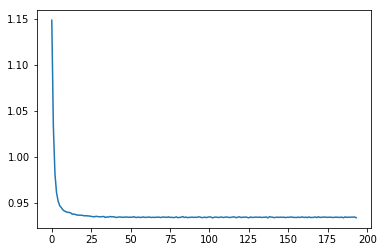

In [111]:
costsNPArray = np.array(costs)
epochXaxis = np.arange(len(costs))
plt.plot(epochXaxis, costsNPArray)
plt.show()

costsFilePath = '/home/muhammadayub/Desktop/CS230/models_saved/model6/COSTS___'+'.npy'    #COSTS___12_12_2018'+'.npy'
np.save(costsFilePath, costsNPArray )

In [149]:
np.load(costsFilePath)
# filepath

array([0.0647672 , 0.04641966, 0.03471443, 0.02663976, 0.02192029,
       0.01970959, 0.01845553, 0.01755938, 0.0171982 , 0.01660422,
       0.01654085, 0.01634365, 0.01621262, 0.01652126, 0.01615006,
       0.0159698 , 0.01614199, 0.01610396, 0.01610836, 0.01620547,
       0.01587727, 0.01573968, 0.01584721, 0.01606645, 0.01579885,
       0.01592844, 0.01588698, 0.01569943, 0.01565967, 0.01583383,
       0.01620939, 0.02880385, 0.02278177, 0.02216931, 0.02250067,
       0.02267798, 0.02239106, 0.02253839, 0.02259601, 0.02280519,
       0.02219826, 0.022607  , 0.0226754 , 0.02211113, 0.02231681,
       0.02226554, 0.02251199, 0.02253624, 0.02265881, 0.02246234])

# This is to figure out the F1 multi class label predictions 

# Restoring the Model

In [114]:
devMiniBatches 
# testMiniBatches 
# minibatches 


array([289, 271,  79, 293,  71, 377, 180, 265, 115, 415,  43,  55, 294,
       320, 253, 432, 145,  56, 146, 434, 279,  44, 327, 134, 394, 163])

In [26]:
# this is to make minibatches larger
print(len(minibatches), ' is number of training minibatches') # is even number

doubleMinibatches = np.split(minibatches, int(len(minibatches)/2))
for i_ in doubleMinibatches:
    print(i_[0], i_[1])

336  is number of training minibatches
308 47
204 278
176 129
274 116
181 255
369 313
128 306
107 122
65 12
6 285
296 64
370 343
294 357
185 201
289 125
305 355
371 344
105 21
214 82
177 36
253 35
27 164
172 162
366 269
9 309
209 71
91 123
338 216
353 188
243 170
151 100
83 104
297 295
298 3
74 118
250 148
228 364
149 259
276 166
22 197
268 13
272 147
69 121
334 49
59 333
88 349
271 182
175 282
68 284
70 341
38 328
155 270
225 55
131 288
332 198
300 220
31 140
52 173
254 84
85 290
167 318
319 208
108 81
190 335
154 192
351 264
32 50
75 135
193 206
286 72
93 350
307 45
2 256
356 202
86 196
130 7
58 304
127 78
302 146
327 311
329 39
87 157
28 262
159 89
19 171
115 37
342 41
330 138
372 63
287 273
189 224
143 324
136 281
280 277
279 235
221 10
260 226
265 180
120 213
103 24
326 29
367 5
283 169
203 215
95 158
275 161
360 322
331 219
267 44
33 76
99 14
184 25
145 346
231 139
240 261
316 238
258 244
80 195
43 34
18 109
229 266
352 94
156 110
51 314
174 17
66 1
359 97
199 96
212 90
257 232
3

In [66]:
filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model5/model3_12_123__288_120.ckpt"
base_filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model5/"

learning_rate = .004
costs = []
num_epochs = 150

graph = tf.Graph()
with graph.as_default(): 
    with tf.Session(graph=graph) as sess:
        
        #define the graph
        X, Y = create_placeholders(64, 64, 28, CATEGORY_AMT)
        parameters = initialize_parameters()
        Z3 = forward_prop(X, parameters)
        #optimization 
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)

        #calculating the accuracy of the model 
        softmaxZ3 = tf.nn.softmax(Z3) # size will be 2200, 34
        output_class = tf.argmax(softmaxZ3,1) # size will be 2200, 1 or just (2200,)
        num_correct = tf.equal(output_class, tf.argmax(Y,1)) # must compare 2200
        num_correct_to_int = tf.cast(num_correct, tf.float32)
        accuracy = tf.reduce_mean(num_correct_to_int)
        
        
        saver = tf.train.Saver()

        saver.restore(sess , filepath)
        print("Model restored.")
        

        #init must be after optimizer
        init = tf.global_variables_initializer()

        # Run the initialization
        sess.run(init)
        print('Starting ' , datetime.datetime.now())
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            np.random.shuffle(doubleMinibatches) # get new minibatch results 
            
            countOfMinibatch = 0 
            for i_ in doubleMinibatches:
                
                # Select a minibatch
                output_image64_a = outputData[i_[0]]
                output_image64_b = outputData[i_[1]]
                
                inputImage64_a =inputData[i_[0]]
                inputImage64_b =inputData[i_[1]]

                output_image64 = np.concatenate([output_image64_a, output_image64_b], axis = 0)
                inputImage64 =  np.concatenate([inputImage64_a, inputImage64_b], axis = 0)
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: inputImage64, Y: output_image64})
                ### END CODE HERE ###

                minibatch_cost += temp_cost / MINIBATCHES_AMT

                print('Minibatch End: ', datetime.datetime.now())
                print(temp_cost,' ' , epoch,' ' ,countOfMinibatch)
                
                if(countOfMinibatch % 20 == 0 ):
                    #save model
                    filepath = base_filepath+"/model3_12_13__"+str(epoch)+"_"+str(countOfMinibatch)+".ckpt"
                    print(temp_cost, " at file name: ", filepath[25:])
                    save_path = saver.save(sess, filepath)

                countOfMinibatch+=1
                
            costs.append(minibatch_cost)
            print('Epoch End: ', datetime.datetime.now())
        
        

INFO:tensorflow:Restoring parameters from /home/muhammadayub/Desktop/CS230/models_saved/model5/model3_12_123__288_120.ckpt
Model restored.
Starting  2018-12-13 10:30:45.787984
Minibatch End:  2018-12-13 10:30:46.874644
0.0   0   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__0_0.ckpt
Minibatch End:  2018-12-13 10:30:48.572609
0.0   0   1
Minibatch End:  2018-12-13 10:30:49.584003
1.0582026   0   2
Minibatch End:  2018-12-13 10:30:51.300053
0.0   0   3
Minibatch End:  2018-12-13 10:30:52.994818
0.017621817   0   4
Minibatch End:  2018-12-13 10:30:53.997077
0.0   0   5
Minibatch End:  2018-12-13 10:30:56.496043
0.0   0   6
Minibatch End:  2018-12-13 10:30:58.222807
0.0   0   7
Minibatch End:  2018-12-13 10:30:59.225927
0.0   0   8
Minibatch End:  2018-12-13 10:31:00.619117
0.008805012   0   9
Minibatch End:  2018-12-13 10:31:04.802828
0.0   0   10
Minibatch End:  2018-12-13 10:31:05.809103
0.0   0   11
Minibatch End:  2018-12-13 10:31:06.854219
0.0   0   12
Minibatch En

Minibatch End:  2018-12-13 10:34:07.668935
0.0   0   128
Minibatch End:  2018-12-13 10:34:09.366684
0.01762651   0   129
Minibatch End:  2018-12-13 10:34:11.086572
0.017556973   0   130
Minibatch End:  2018-12-13 10:34:12.883030
0.00838094   0   131
Minibatch End:  2018-12-13 10:34:14.646131
0.008870477   0   132
Minibatch End:  2018-12-13 10:34:17.035448
0.0089026   0   133
Minibatch End:  2018-12-13 10:34:18.813205
0.026584173   0   134
Minibatch End:  2018-12-13 10:34:20.546443
0.0   0   135
Minibatch End:  2018-12-13 10:34:22.983466
0.01777773   0   136
Minibatch End:  2018-12-13 10:34:24.700244
0.0   0   137
Minibatch End:  2018-12-13 10:34:27.231426
0.017358677   0   138
Minibatch End:  2018-12-13 10:34:29.704497
0.017207762   0   139
Minibatch End:  2018-12-13 10:34:32.201123
0.0   0   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__0_140.ckpt
Minibatch End:  2018-12-13 10:34:34.799649
0.0   0   141
Minibatch End:  2018-12-13 10:34:37.226447
0.0   0   142
Mini

Minibatch End:  2018-12-13 10:37:39.537472
0.008320715   1   88
Minibatch End:  2018-12-13 10:37:41.272053
0.0   1   89
Minibatch End:  2018-12-13 10:37:43.016081
0.0   1   90
Minibatch End:  2018-12-13 10:37:44.817549
1.6892395   1   91
Minibatch End:  2018-12-13 10:37:45.922102
0.008318185   1   92
Minibatch End:  2018-12-13 10:37:47.581731
1.6945957   1   93
Minibatch End:  2018-12-13 10:37:48.577113
0.026641548   1   94
Minibatch End:  2018-12-13 10:37:50.267186
0.0   1   95
Minibatch End:  2018-12-13 10:37:51.989665
0.016608773   1   96
Minibatch End:  2018-12-13 10:37:53.775608
0.008913595   1   97
Minibatch End:  2018-12-13 10:37:55.444994
0.008058155   1   98
Minibatch End:  2018-12-13 10:37:57.117238
0.008832515   1   99
Minibatch End:  2018-12-13 10:37:58.865737
0.0   1   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__1_100.ckpt
Minibatch End:  2018-12-13 10:38:00.331892
0.008855276   1   101
Minibatch End:  2018-12-13 10:38:01.335594
0.0   1   102
Minibat

Minibatch End:  2018-12-13 10:41:08.949725
1.6806533   2   49
Minibatch End:  2018-12-13 10:41:10.685296
0.0   2   50
Minibatch End:  2018-12-13 10:41:12.430641
0.0   2   51
Minibatch End:  2018-12-13 10:41:13.427963
1.6910827   2   52
Minibatch End:  2018-12-13 10:41:15.136990
1.6935086   2   53
Minibatch End:  2018-12-13 10:41:16.147931
0.0   2   54
Minibatch End:  2018-12-13 10:41:17.163822
0.0   2   55
Minibatch End:  2018-12-13 10:41:18.912211
0.0   2   56
Minibatch End:  2018-12-13 10:41:19.905980
0.03360348   2   57
Minibatch End:  2018-12-13 10:41:20.896564
0.0   2   58
Minibatch End:  2018-12-13 10:41:21.897492
0.0   2   59
Minibatch End:  2018-12-13 10:41:22.899146
0.0   2   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__2_60.ckpt
Minibatch End:  2018-12-13 10:41:24.269184
0.0   2   61
Minibatch End:  2018-12-13 10:41:25.269905
0.0   2   62
Minibatch End:  2018-12-13 10:41:26.286407
0.0   2   63
Minibatch End:  2018-12-13 10:41:27.289217
0.016889483   2   6

Minibatch End:  2018-12-13 10:44:33.530715
0.008815866   3   9
Minibatch End:  2018-12-13 10:44:34.524095
0.0   3   10
Minibatch End:  2018-12-13 10:44:35.521521
0.0   3   11
Minibatch End:  2018-12-13 10:44:36.528736
0.0   3   12
Minibatch End:  2018-12-13 10:44:37.516196
0.0   3   13
Minibatch End:  2018-12-13 10:44:38.525000
0.008953788   3   14
Minibatch End:  2018-12-13 10:44:40.914853
0.0   3   15
Minibatch End:  2018-12-13 10:44:42.599405
0.0   3   16
Minibatch End:  2018-12-13 10:44:43.598868
0.0   3   17
Minibatch End:  2018-12-13 10:44:44.599572
0.0   3   18
Minibatch End:  2018-12-13 10:44:45.602301
0.0   3   19
Minibatch End:  2018-12-13 10:44:46.603908
0.0   3   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__3_20.ckpt
Minibatch End:  2018-12-13 10:44:47.960959
0.0   3   21
Minibatch End:  2018-12-13 10:44:49.850005
0.0   3   22
Minibatch End:  2018-12-13 10:44:51.599320
0.0   3   23
Minibatch End:  2018-12-13 10:44:54.033644
0.0   3   24
Minibatch End:  

Minibatch End:  2018-12-13 10:47:52.641896
0.0   3   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__3_140.ckpt
Minibatch End:  2018-12-13 10:47:53.989843
0.0   3   141
Minibatch End:  2018-12-13 10:47:54.990176
0.007948237   3   142
Minibatch End:  2018-12-13 10:47:56.788010
0.0088784965   3   143
Minibatch End:  2018-12-13 10:47:59.170594
0.016497638   3   144
Minibatch End:  2018-12-13 10:48:01.616296
0.0   3   145
Minibatch End:  2018-12-13 10:48:03.301303
0.008969906   3   146
Minibatch End:  2018-12-13 10:48:04.876485
0.0   3   147
Minibatch End:  2018-12-13 10:48:06.862436
1.5833926   3   148
Minibatch End:  2018-12-13 10:48:07.857498
0.016606564   3   149
Minibatch End:  2018-12-13 10:48:09.538509
0.0   3   150
Minibatch End:  2018-12-13 10:48:11.896958
0.0   3   151
Minibatch End:  2018-12-13 10:48:12.896074
0.0   3   152
Minibatch End:  2018-12-13 10:48:15.327656
0.0   3   153
Minibatch End:  2018-12-13 10:48:17.987645
0.008807786   3   154
Minibatch End:  

Minibatch End:  2018-12-13 10:50:59.931002
0.0   4   101
Minibatch End:  2018-12-13 10:51:01.653059
0.0   4   102
Minibatch End:  2018-12-13 10:51:03.295201
0.0   4   103
Minibatch End:  2018-12-13 10:51:05.042012
0.0   4   104
Minibatch End:  2018-12-13 10:51:07.395191
0.025068924   4   105
Minibatch End:  2018-12-13 10:51:10.124946
0.0   4   106
Minibatch End:  2018-12-13 10:51:12.657320
0.00901676   4   107
Minibatch End:  2018-12-13 10:51:13.658954
0.016507525   4   108
Minibatch End:  2018-12-13 10:51:14.673288
0.017349353   4   109
Minibatch End:  2018-12-13 10:51:16.544318
0.0   4   110
Minibatch End:  2018-12-13 10:51:18.422221
0.0   4   111
Minibatch End:  2018-12-13 10:51:19.433601
0.0   4   112
Minibatch End:  2018-12-13 10:51:21.205905
0.0   4   113
Minibatch End:  2018-12-13 10:51:23.861974
0.0   4   114
Minibatch End:  2018-12-13 10:51:26.206543
0.0088909045   4   115
Minibatch End:  2018-12-13 10:51:29.643351
0.0   4   116
Minibatch End:  2018-12-13 10:51:30.644560
0.0  

Minibatch End:  2018-12-13 10:54:32.106448
0.0   5   61
Minibatch End:  2018-12-13 10:54:33.109144
0.02683575   5   62
Minibatch End:  2018-12-13 10:54:35.462154
0.9721982   5   63
Minibatch End:  2018-12-13 10:54:36.466243
0.017252987   5   64
Minibatch End:  2018-12-13 10:54:37.472219
0.0   5   65
Minibatch End:  2018-12-13 10:54:38.472090
0.0   5   66
Minibatch End:  2018-12-13 10:54:39.473917
0.0   5   67
Minibatch End:  2018-12-13 10:54:40.493449
0.017904878   5   68
Minibatch End:  2018-12-13 10:54:41.503942
0.0   5   69
Minibatch End:  2018-12-13 10:54:43.210318
0.016542397   5   70
Minibatch End:  2018-12-13 10:54:44.343648
1.6433142   5   71
Minibatch End:  2018-12-13 10:54:46.086853
0.00877751   5   72
Minibatch End:  2018-12-13 10:54:48.448532
0.033037975   5   73
Minibatch End:  2018-12-13 10:54:50.216509
0.0   5   74
Minibatch End:  2018-12-13 10:54:52.670706
0.0   5   75
Minibatch End:  2018-12-13 10:54:54.366506
0.016797544   5   76
Minibatch End:  2018-12-13 10:54:55.36

Minibatch End:  2018-12-13 10:58:00.972852
0.0   6   22
Minibatch End:  2018-12-13 10:58:01.971095
0.0   6   23
Minibatch End:  2018-12-13 10:58:02.965017
0.0   6   24
Minibatch End:  2018-12-13 10:58:05.652983
0.017469447   6   25
Minibatch End:  2018-12-13 10:58:06.655583
0.0   6   26
Minibatch End:  2018-12-13 10:58:07.647582
0.0077294726   6   27
Minibatch End:  2018-12-13 10:58:10.155367
0.008787267   6   28
Minibatch End:  2018-12-13 10:58:11.162649
0.0   6   29
Minibatch End:  2018-12-13 10:58:13.131064
0.0   6   30
Minibatch End:  2018-12-13 10:58:14.125678
0.009039265   6   31
Minibatch End:  2018-12-13 10:58:16.584831
1.6406192   6   32
Minibatch End:  2018-12-13 10:58:17.570440
0.00772697   6   33
Minibatch End:  2018-12-13 10:58:18.577941
0.008592471   6   34
Minibatch End:  2018-12-13 10:58:20.312984
0.008994898   6   35
Minibatch End:  2018-12-13 10:58:21.320046
0.0   6   36
Minibatch End:  2018-12-13 10:58:22.313935
0.0077209515   6   37
Minibatch End:  2018-12-13 10:58:

Minibatch End:  2018-12-13 11:01:18.467265
0.0   6   153
Minibatch End:  2018-12-13 11:01:19.482014
0.0   6   154
Minibatch End:  2018-12-13 11:01:21.219180
0.0   6   155
Minibatch End:  2018-12-13 11:01:22.894425
0.0   6   156
Minibatch End:  2018-12-13 11:01:25.459243
0.0   6   157
Minibatch End:  2018-12-13 11:01:27.157525
0.0   6   158
Minibatch End:  2018-12-13 11:01:29.628128
0.0176672   6   159
Minibatch End:  2018-12-13 11:01:31.425162
0.0   6   160
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__6_160.ckpt
Minibatch End:  2018-12-13 11:01:32.781160
0.016778672   6   161
Minibatch End:  2018-12-13 11:01:34.477392
0.0   6   162
Minibatch End:  2018-12-13 11:01:36.936624
1.6293811   6   163
Minibatch End:  2018-12-13 11:01:39.448437
0.024796143   6   164
Minibatch End:  2018-12-13 11:01:40.449769
0.008781083   6   165
Minibatch End:  2018-12-13 11:01:42.885662
0.007679852   6   166
Minibatch End:  2018-12-13 11:01:44.694224
0.016731855   6   167
Epoch End:  2018-12

Minibatch End:  2018-12-13 11:04:20.467167
0.0   7   114
Minibatch End:  2018-12-13 11:04:22.876536
0.0   7   115
Minibatch End:  2018-12-13 11:04:25.348682
1.5861882   7   116
Minibatch End:  2018-12-13 11:04:26.498788
0.0   7   117
Minibatch End:  2018-12-13 11:04:28.277239
0.008777667   7   118
Minibatch End:  2018-12-13 11:04:29.970677
0.0   7   119
Minibatch End:  2018-12-13 11:04:30.970252
0.0   7   120
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__7_120.ckpt
Minibatch End:  2018-12-13 11:04:32.308059
0.0   7   121
Minibatch End:  2018-12-13 11:04:33.318449
0.008889525   7   122
Minibatch End:  2018-12-13 11:04:35.876235
0.0   7   123
Minibatch End:  2018-12-13 11:04:38.500974
0.0   7   124
Minibatch End:  2018-12-13 11:04:41.047138
0.03279402   7   125
Minibatch End:  2018-12-13 11:04:42.039724
0.008776631   7   126
Minibatch End:  2018-12-13 11:04:43.047419
0.016250128   7   127
Minibatch End:  2018-12-13 11:04:45.607135
0.009060412   7   128
Minibatch End:  20

Minibatch End:  2018-12-13 11:07:42.429388
0.0   8   75
Minibatch End:  2018-12-13 11:07:43.440323
0.0   8   76
Minibatch End:  2018-12-13 11:07:45.176977
0.0   8   77
Minibatch End:  2018-12-13 11:07:47.825582
0.0   8   78
Minibatch End:  2018-12-13 11:07:49.540124
0.0163327   8   79
Minibatch End:  2018-12-13 11:07:50.542896
1.6005101   8   80
1.6005101  at file name:  p/CS230/models_saved/model5//model3_12_13__8_80.ckpt
Minibatch End:  2018-12-13 11:07:53.467313
0.008623226   8   81
Minibatch End:  2018-12-13 11:07:54.483539
0.016199743   8   82
Minibatch End:  2018-12-13 11:07:56.927003
0.0   8   83
Minibatch End:  2018-12-13 11:07:57.937934
0.015147287   8   84
Minibatch End:  2018-12-13 11:07:58.932506
0.016641788   8   85
Minibatch End:  2018-12-13 11:07:59.937367
0.0   8   86
Minibatch End:  2018-12-13 11:08:00.945246
0.0   8   87
Minibatch End:  2018-12-13 11:08:01.964097
0.0   8   88
Minibatch End:  2018-12-13 11:08:02.969192
1.6179116   8   89
Minibatch End:  2018-12-13 11:0

Minibatch End:  2018-12-13 11:11:14.438351
0.03389854   9   34
Minibatch End:  2018-12-13 11:11:15.441252
0.0   9   35
Minibatch End:  2018-12-13 11:11:16.450763
0.0   9   36
Minibatch End:  2018-12-13 11:11:17.445483
0.0   9   37
Minibatch End:  2018-12-13 11:11:18.461074
0.008881578   9   38
Minibatch End:  2018-12-13 11:11:19.460309
0.0   9   39
Minibatch End:  2018-12-13 11:11:20.463890
0.008632201   9   40
0.008632201  at file name:  p/CS230/models_saved/model5//model3_12_13__9_40.ckpt
Minibatch End:  2018-12-13 11:11:23.239154
0.007527667   9   41
Minibatch End:  2018-12-13 11:11:24.244535
0.0   9   42
Minibatch End:  2018-12-13 11:11:25.241811
0.0   9   43
Minibatch End:  2018-12-13 11:11:26.245089
1.5741315   9   44
Minibatch End:  2018-12-13 11:11:27.253692
0.0   9   45
Minibatch End:  2018-12-13 11:11:28.252159
0.015058594   9   46
Minibatch End:  2018-12-13 11:11:29.259273
0.008882466   9   47
Minibatch End:  2018-12-13 11:11:30.266110
0.01724098   9   48
Minibatch End:  201

Minibatch End:  2018-12-13 11:14:39.505034
0.018042196   9   164
Minibatch End:  2018-12-13 11:14:40.510769
0.0   9   165
Minibatch End:  2018-12-13 11:14:42.921512
1.6187931   9   166
Minibatch End:  2018-12-13 11:14:45.254690
0.007092527   9   167
Epoch End:  2018-12-13 11:14:45.254904
Minibatch End:  2018-12-13 11:14:46.261147
0.0   10   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__10_0.ckpt
Minibatch End:  2018-12-13 11:14:47.610048
0.0161651   10   1
Minibatch End:  2018-12-13 11:14:48.631507
0.016611151   10   2
Minibatch End:  2018-12-13 11:14:49.715731
0.0   10   3
Minibatch End:  2018-12-13 11:14:50.722285
0.0   10   4
Minibatch End:  2018-12-13 11:14:52.394921
1.5946826   10   5
Minibatch End:  2018-12-13 11:14:53.404665
0.016214011   10   6
Minibatch End:  2018-12-13 11:14:54.414925
0.016283222   10   7
Minibatch End:  2018-12-13 11:14:55.426717
0.0   10   8
Minibatch End:  2018-12-13 11:14:56.433619
0.009021135   10   9
Minibatch End:  2018-12-13 11:14:5

Minibatch End:  2018-12-13 11:17:32.267685
1.5817316   10   124
Minibatch End:  2018-12-13 11:17:33.939596
0.0   10   125
Minibatch End:  2018-12-13 11:17:35.703593
0.01765308   10   126
Minibatch End:  2018-12-13 11:17:38.114349
0.0   10   127
Minibatch End:  2018-12-13 11:17:40.571878
0.009027728   10   128
Minibatch End:  2018-12-13 11:17:43.021631
0.9582892   10   129
Minibatch End:  2018-12-13 11:17:44.035178
0.043071833   10   130
Minibatch End:  2018-12-13 11:17:46.449854
0.007066525   10   131
Minibatch End:  2018-12-13 11:17:47.462566
0.016637884   10   132
Minibatch End:  2018-12-13 11:17:49.863433
0.0   10   133
Minibatch End:  2018-12-13 11:17:50.868649
0.0   10   134
Minibatch End:  2018-12-13 11:17:52.784740
0.0   10   135
Minibatch End:  2018-12-13 11:17:55.079147
0.008888588   10   136
Minibatch End:  2018-12-13 11:17:56.763888
0.0   10   137
Minibatch End:  2018-12-13 11:17:59.293044
1.5363787   10   138
Minibatch End:  2018-12-13 11:18:01.686768
0.0074944575   10   13

Minibatch End:  2018-12-13 11:20:42.377974
0.0   11   81
Minibatch End:  2018-12-13 11:20:44.884262
0.0   11   82
Minibatch End:  2018-12-13 11:20:47.450755
0.0   11   83
Minibatch End:  2018-12-13 11:20:48.450971
0.0   11   84
Minibatch End:  2018-12-13 11:20:49.456347
1.5842892   11   85
Minibatch End:  2018-12-13 11:20:50.451985
0.0069819363   11   86
Minibatch End:  2018-12-13 11:20:51.462327
0.031355903   11   87
Minibatch End:  2018-12-13 11:20:52.465076
0.032372206   11   88
Minibatch End:  2018-12-13 11:20:53.537283
0.0   11   89
Minibatch End:  2018-12-13 11:20:56.041429
0.0   11   90
Minibatch End:  2018-12-13 11:20:57.037312
0.0   11   91
Minibatch End:  2018-12-13 11:20:58.049997
0.0   11   92
Minibatch End:  2018-12-13 11:20:59.055012
0.0   11   93
Minibatch End:  2018-12-13 11:21:00.069849
1.5636691   11   94
Minibatch End:  2018-12-13 11:21:01.061774
0.016064987   11   95
Minibatch End:  2018-12-13 11:21:02.066346
0.0   11   96
Minibatch End:  2018-12-13 11:21:03.064280


Minibatch End:  2018-12-13 11:24:01.259814
0.008724073   12   41
Minibatch End:  2018-12-13 11:24:02.267887
0.0   12   42
Minibatch End:  2018-12-13 11:24:04.132842
0.0   12   43
Minibatch End:  2018-12-13 11:24:05.135835
0.0   12   44
Minibatch End:  2018-12-13 11:24:06.128614
0.0069349855   12   45
Minibatch End:  2018-12-13 11:24:07.132256
0.0   12   46
Minibatch End:  2018-12-13 11:24:08.133716
0.0   12   47
Minibatch End:  2018-12-13 11:24:09.141753
0.0   12   48
Minibatch End:  2018-12-13 11:24:10.140509
0.0   12   49
Minibatch End:  2018-12-13 11:24:11.145554
0.0   12   50
Minibatch End:  2018-12-13 11:24:13.637996
0.017759888   12   51
Minibatch End:  2018-12-13 11:24:14.629650
0.007396261   12   52
Minibatch End:  2018-12-13 11:24:15.622003
0.0   12   53
Minibatch End:  2018-12-13 11:24:16.628156
0.017014932   12   54
Minibatch End:  2018-12-13 11:24:18.660598
0.017161436   12   55
Minibatch End:  2018-12-13 11:24:19.666017
0.0   12   56
Minibatch End:  2018-12-13 11:24:20.671

Minibatch End:  2018-12-13 11:27:23.903617
0.0069356305   13   0
0.0069356305  at file name:  p/CS230/models_saved/model5//model3_12_13__13_0.ckpt
Minibatch End:  2018-12-13 11:27:25.268334
0.0   13   1
Minibatch End:  2018-12-13 11:27:27.754091
0.016558748   13   2
Minibatch End:  2018-12-13 11:27:28.769285
0.0   13   3
Minibatch End:  2018-12-13 11:27:29.775649
0.0   13   4
Minibatch End:  2018-12-13 11:27:32.230147
0.016096106   13   5
Minibatch End:  2018-12-13 11:27:33.229852
0.007388159   13   6
Minibatch End:  2018-12-13 11:27:35.722379
0.017974358   13   7
Minibatch End:  2018-12-13 11:27:37.530188
0.009033974   13   8
Minibatch End:  2018-12-13 11:27:38.531076
0.0   13   9
Minibatch End:  2018-12-13 11:27:41.165585
0.0   13   10
Minibatch End:  2018-12-13 11:27:42.165029
0.0   13   11
Minibatch End:  2018-12-13 11:27:43.169443
0.008723194   13   12
Minibatch End:  2018-12-13 11:27:44.163886
0.0   13   13
Minibatch End:  2018-12-13 11:27:45.164252
0.016030075   13   14
Minibatc

Minibatch End:  2018-12-13 11:30:27.625193
0.0   13   127
Minibatch End:  2018-12-13 11:30:28.626430
0.0   13   128
Minibatch End:  2018-12-13 11:30:31.172576
0.008723818   13   129
Minibatch End:  2018-12-13 11:30:33.610530
0.0073622847   13   130
Minibatch End:  2018-12-13 11:30:36.062515
0.0   13   131
Minibatch End:  2018-12-13 11:30:37.056820
0.0   13   132
Minibatch End:  2018-12-13 11:30:39.726179
0.0   13   133
Minibatch End:  2018-12-13 11:30:42.263916
0.0   13   134
Minibatch End:  2018-12-13 11:30:44.734191
0.0   13   135
Minibatch End:  2018-12-13 11:30:45.737038
0.0   13   136
Minibatch End:  2018-12-13 11:30:48.156538
0.0   13   137
Minibatch End:  2018-12-13 11:30:49.444947
0.0   13   138
Minibatch End:  2018-12-13 11:30:51.894062
1.520147   13   139
Minibatch End:  2018-12-13 11:30:54.292000
0.0   13   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__13_140.ckpt
Minibatch End:  2018-12-13 11:30:55.644967
0.0   13   141
Minibatch End:  2018-12-13 11:30:

Minibatch End:  2018-12-13 11:33:44.659361
0.0   14   86
Minibatch End:  2018-12-13 11:33:45.671938
0.0   14   87
Minibatch End:  2018-12-13 11:33:48.353653
0.008680128   14   88
Minibatch End:  2018-12-13 11:33:49.371776
0.0   14   89
Minibatch End:  2018-12-13 11:33:51.317993
0.0   14   90
Minibatch End:  2018-12-13 11:33:53.760274
0.0   14   91
Minibatch End:  2018-12-13 11:33:54.753034
0.0   14   92
Minibatch End:  2018-12-13 11:33:56.676766
0.0   14   93
Minibatch End:  2018-12-13 11:33:57.684912
0.0   14   94
Minibatch End:  2018-12-13 11:33:58.699989
0.94853777   14   95
Minibatch End:  2018-12-13 11:33:59.697088
0.0   14   96
Minibatch End:  2018-12-13 11:34:00.710410
0.0   14   97
Minibatch End:  2018-12-13 11:34:03.127739
0.0   14   98
Minibatch End:  2018-12-13 11:34:04.134997
0.016058834   14   99
Minibatch End:  2018-12-13 11:34:06.061307
0.0   14   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__14_100.ckpt
Minibatch End:  2018-12-13 11:34:08.836490
0.0

Minibatch End:  2018-12-13 11:37:05.246955
1.5754211   15   44
Minibatch End:  2018-12-13 11:37:06.251118
0.016417889   15   45
Minibatch End:  2018-12-13 11:37:07.258793
0.0   15   46
Minibatch End:  2018-12-13 11:37:09.742480
0.0   15   47
Minibatch End:  2018-12-13 11:37:10.731922
0.01592932   15   48
Minibatch End:  2018-12-13 11:37:11.736456
1.5132939   15   49
Minibatch End:  2018-12-13 11:37:12.741837
0.0   15   50
Minibatch End:  2018-12-13 11:37:13.754132
0.0   15   51
Minibatch End:  2018-12-13 11:37:16.211844
0.0   15   52
Minibatch End:  2018-12-13 11:37:18.871759
0.0   15   53
Minibatch End:  2018-12-13 11:37:19.876615
0.0   15   54
Minibatch End:  2018-12-13 11:37:22.200863
0.0   15   55
Minibatch End:  2018-12-13 11:37:23.192052
0.0   15   56
Minibatch End:  2018-12-13 11:37:24.205533
0.007278332   15   57
Minibatch End:  2018-12-13 11:37:26.537738
0.0067950906   15   58
Minibatch End:  2018-12-13 11:37:27.532745
0.008700348   15   59
Minibatch End:  2018-12-13 11:37:28.

Minibatch End:  2018-12-13 11:40:30.699927
0.0   16   2
Minibatch End:  2018-12-13 11:40:31.712232
0.016932122   16   3
Minibatch End:  2018-12-13 11:40:32.723920
0.0   16   4
Minibatch End:  2018-12-13 11:40:33.742322
0.0   16   5
Minibatch End:  2018-12-13 11:40:34.747087
0.0159277   16   6
Minibatch End:  2018-12-13 11:40:35.755074
0.0   16   7
Minibatch End:  2018-12-13 11:40:36.752849
0.0   16   8
Minibatch End:  2018-12-13 11:40:37.754875
0.030886542   16   9
Minibatch End:  2018-12-13 11:40:40.337204
0.0   16   10
Minibatch End:  2018-12-13 11:40:41.339885
0.0   16   11
Minibatch End:  2018-12-13 11:40:42.342079
0.026757896   16   12
Minibatch End:  2018-12-13 11:40:43.338552
0.0   16   13
Minibatch End:  2018-12-13 11:40:44.346485
0.01755959   16   14
Minibatch End:  2018-12-13 11:40:45.351365
0.006809393   16   15
Minibatch End:  2018-12-13 11:40:47.064879
0.0   16   16
Minibatch End:  2018-12-13 11:40:49.539590
0.009048016   16   17
Minibatch End:  2018-12-13 11:40:50.551234


Minibatch End:  2018-12-13 11:43:36.439130
0.007262021   16   131
Minibatch End:  2018-12-13 11:43:38.838380
0.0   16   132
Minibatch End:  2018-12-13 11:43:39.856096
0.01598799   16   133
Minibatch End:  2018-12-13 11:43:42.238174
0.0   16   134
Minibatch End:  2018-12-13 11:43:43.257636
0.02421957   16   135
Minibatch End:  2018-12-13 11:43:45.679470
0.008695181   16   136
Minibatch End:  2018-12-13 11:43:46.686808
0.0   16   137
Minibatch End:  2018-12-13 11:43:49.207999
0.0   16   138
Minibatch End:  2018-12-13 11:43:51.642300
0.008695597   16   139
Minibatch End:  2018-12-13 11:43:54.111231
0.0072648632   16   140
0.0072648632  at file name:  p/CS230/models_saved/model5//model3_12_13__16_140.ckpt
Minibatch End:  2018-12-13 11:43:55.461912
0.009048062   16   141
Minibatch End:  2018-12-13 11:43:56.471552
0.0   16   142
Minibatch End:  2018-12-13 11:43:57.572744
0.008867043   16   143
Minibatch End:  2018-12-13 11:43:59.451972
0.0   16   144
Minibatch End:  2018-12-13 11:44:01.29135

Minibatch End:  2018-12-13 11:46:35.968662
0.0   17   90
Minibatch End:  2018-12-13 11:46:36.962899
0.0   17   91
Minibatch End:  2018-12-13 11:46:37.961232
1.5076329   17   92
Minibatch End:  2018-12-13 11:46:38.969322
0.042736907   17   93
Minibatch End:  2018-12-13 11:46:41.593330
0.0   17   94
Minibatch End:  2018-12-13 11:46:44.331474
1.544855   17   95
Minibatch End:  2018-12-13 11:46:46.725154
0.0   17   96
Minibatch End:  2018-12-13 11:46:47.730496
0.0   17   97
Minibatch End:  2018-12-13 11:46:48.738290
0.0   17   98
Minibatch End:  2018-12-13 11:46:49.740407
0.0   17   99
Minibatch End:  2018-12-13 11:46:52.172408
0.030760422   17   100
0.030760422  at file name:  p/CS230/models_saved/model5//model3_12_13__17_100.ckpt
Minibatch End:  2018-12-13 11:46:53.599417
0.0   17   101
Minibatch End:  2018-12-13 11:46:54.598015
0.0   17   102
Minibatch End:  2018-12-13 11:46:55.607066
0.015883967   17   103
Minibatch End:  2018-12-13 11:46:58.016236
0.026947813   17   104
Minibatch End:

Minibatch End:  2018-12-13 11:49:56.568793
0.0   18   48
Minibatch End:  2018-12-13 11:49:57.569592
0.0   18   49
Minibatch End:  2018-12-13 11:49:58.574093
0.0   18   50
Minibatch End:  2018-12-13 11:50:00.983651
0.0   18   51
Minibatch End:  2018-12-13 11:50:02.977767
0.0   18   52
Minibatch End:  2018-12-13 11:50:05.476792
0.007218702   18   53
Minibatch End:  2018-12-13 11:50:06.477085
0.017062606   18   54
Minibatch End:  2018-12-13 11:50:07.493879
0.016364122   18   55
Minibatch End:  2018-12-13 11:50:09.986375
0.0   18   56
Minibatch End:  2018-12-13 11:50:12.523614
1.5822328   18   57
Minibatch End:  2018-12-13 11:50:14.838131
0.0067419554   18   58
Minibatch End:  2018-12-13 11:50:15.845616
0.0   18   59
Minibatch End:  2018-12-13 11:50:18.416337
0.009058099   18   60
0.009058099  at file name:  p/CS230/models_saved/model5//model3_12_13__18_60.ckpt
Minibatch End:  2018-12-13 11:50:19.795690
0.0   18   61
Minibatch End:  2018-12-13 11:50:22.295951
0.008678124   18   62
Minibatc

Minibatch End:  2018-12-13 11:53:23.980236
0.0067210835   19   6
Minibatch End:  2018-12-13 11:53:24.992174
0.0   19   7
Minibatch End:  2018-12-13 11:53:25.999423
0.017547473   19   8
Minibatch End:  2018-12-13 11:53:26.996665
0.0   19   9
Minibatch End:  2018-12-13 11:53:28.006692
0.0   19   10
Minibatch End:  2018-12-13 11:53:30.508573
0.0   19   11
Minibatch End:  2018-12-13 11:53:31.509470
0.009150004   19   12
Minibatch End:  2018-12-13 11:53:32.506121
0.0   19   13
Minibatch End:  2018-12-13 11:53:33.513874
0.0   19   14
Minibatch End:  2018-12-13 11:53:36.126837
0.0   19   15
Minibatch End:  2018-12-13 11:53:37.130532
0.0   19   16
Minibatch End:  2018-12-13 11:53:38.133472
0.018196452   19   17
Minibatch End:  2018-12-13 11:53:39.132629
0.0   19   18
Minibatch End:  2018-12-13 11:53:41.620942
0.0   19   19
Minibatch End:  2018-12-13 11:53:44.058258
0.0   19   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__19_20.ckpt
Minibatch End:  2018-12-13 11:53:45.431466

Minibatch End:  2018-12-13 11:56:42.724145
0.0   19   135
Minibatch End:  2018-12-13 11:56:44.430598
0.0   19   136
Minibatch End:  2018-12-13 11:56:45.445512
0.018293286   19   137
Minibatch End:  2018-12-13 11:56:47.124371
0.008868318   19   138
Minibatch End:  2018-12-13 11:56:48.137451
1.5574979   19   139
Minibatch End:  2018-12-13 11:56:50.636098
0.0   19   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__19_140.ckpt
Minibatch End:  2018-12-13 11:56:53.545151
0.0   19   141
Minibatch End:  2018-12-13 11:56:55.946869
0.016316712   19   142
Minibatch End:  2018-12-13 11:56:56.953116
0.0   19   143
Minibatch End:  2018-12-13 11:56:57.960890
0.0   19   144
Minibatch End:  2018-12-13 11:57:00.427442
0.0   19   145
Minibatch End:  2018-12-13 11:57:02.937139
1.5008312   19   146
Minibatch End:  2018-12-13 11:57:05.471130
0.01739263   19   147
Minibatch End:  2018-12-13 11:57:07.843892
0.0   19   148
Minibatch End:  2018-12-13 11:57:10.303034
0.0   19   149
Minibatch En

Minibatch End:  2018-12-13 11:59:39.943420
0.015897641   20   94
Minibatch End:  2018-12-13 11:59:42.297984
0.008670284   20   95
Minibatch End:  2018-12-13 11:59:43.308931
0.0   20   96
Minibatch End:  2018-12-13 11:59:45.715906
0.015537953   20   97
Minibatch End:  2018-12-13 11:59:46.721389
0.0   20   98
Minibatch End:  2018-12-13 11:59:47.719235
0.0   20   99
Minibatch End:  2018-12-13 11:59:48.730440
0.0   20   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__20_100.ckpt
Minibatch End:  2018-12-13 11:59:51.453166
0.0   20   101
Minibatch End:  2018-12-13 11:59:52.456912
0.0   20   102
Minibatch End:  2018-12-13 11:59:54.935006
0.0   20   103
Minibatch End:  2018-12-13 11:59:55.937920
0.0   20   104
Minibatch End:  2018-12-13 11:59:56.941237
0.016861904   20   105
Minibatch End:  2018-12-13 11:59:57.952462
0.0   20   106
Minibatch End:  2018-12-13 11:59:58.958368
0.0   20   107
Minibatch End:  2018-12-13 11:59:59.972236
0.0   20   108
Minibatch End:  2018-12-13 12

Minibatch End:  2018-12-13 12:02:54.063918
0.0   21   52
Minibatch End:  2018-12-13 12:02:55.075203
0.015750926   21   53
Minibatch End:  2018-12-13 12:02:57.680674
0.015766615   21   54
Minibatch End:  2018-12-13 12:02:58.679324
0.0   21   55
Minibatch End:  2018-12-13 12:02:59.706453
0.0   21   56
Minibatch End:  2018-12-13 12:03:00.721688
0.0   21   57
Minibatch End:  2018-12-13 12:03:01.724806
0.0   21   58
Minibatch End:  2018-12-13 12:03:03.172166
0.0   21   59
Minibatch End:  2018-12-13 12:03:04.185454
0.0   21   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__21_60.ckpt
Minibatch End:  2018-12-13 12:03:05.670252
0.0   21   61
Minibatch End:  2018-12-13 12:03:06.674914
0.0   21   62
Minibatch End:  2018-12-13 12:03:07.682675
0.008854047   21   63
Minibatch End:  2018-12-13 12:03:08.688297
0.01547687   21   64
Minibatch End:  2018-12-13 12:03:09.695517
0.0   21   65
Minibatch End:  2018-12-13 12:03:10.709940
0.0   21   66
Minibatch End:  2018-12-13 12:03:11.7221

Minibatch End:  2018-12-13 12:06:14.437313
1.5415305   22   10
Minibatch End:  2018-12-13 12:06:16.928778
0.03035783   22   11
Minibatch End:  2018-12-13 12:06:17.936382
0.01760281   22   12
Minibatch End:  2018-12-13 12:06:18.939745
0.0   22   13
Minibatch End:  2018-12-13 12:06:19.942056
0.0   22   14
Minibatch End:  2018-12-13 12:06:20.947109
0.0   22   15
Minibatch End:  2018-12-13 12:06:21.954535
0.015734257   22   16
Minibatch End:  2018-12-13 12:06:24.440017
0.018012462   22   17
Minibatch End:  2018-12-13 12:06:26.429623
1.5043646   22   18
Minibatch End:  2018-12-13 12:06:28.827676
0.007086481   22   19
Minibatch End:  2018-12-13 12:06:29.829053
0.0   22   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__22_20.ckpt
Minibatch End:  2018-12-13 12:06:31.506373
0.0   22   21
Minibatch End:  2018-12-13 12:06:32.512704
0.0   22   22
Minibatch End:  2018-12-13 12:06:33.505569
0.018219396   22   23
Minibatch End:  2018-12-13 12:06:34.515784
0.04250588   22   24
Miniba

Minibatch End:  2018-12-13 12:09:20.306887
0.015757916   22   139
Minibatch End:  2018-12-13 12:09:21.317844
0.0   22   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__22_140.ckpt
Minibatch End:  2018-12-13 12:09:24.264710
0.0   22   141
Minibatch End:  2018-12-13 12:09:25.267637
0.0   22   142
Minibatch End:  2018-12-13 12:09:26.983682
0.0   22   143
Minibatch End:  2018-12-13 12:09:27.990660
0.0   22   144
Minibatch End:  2018-12-13 12:09:29.769114
0.016979598   22   145
Minibatch End:  2018-12-13 12:09:30.766483
0.0   22   146
Minibatch End:  2018-12-13 12:09:33.319701
0.0   22   147
Minibatch End:  2018-12-13 12:09:34.333290
0.008648699   22   148
Minibatch End:  2018-12-13 12:09:36.735041
0.0   22   149
Minibatch End:  2018-12-13 12:09:37.744719
0.0   22   150
Minibatch End:  2018-12-13 12:09:38.750734
0.015764482   22   151
Minibatch End:  2018-12-13 12:09:39.768638
0.0   22   152
Minibatch End:  2018-12-13 12:09:42.231989
0.0   22   153
Minibatch End:  2018-12

Minibatch End:  2018-12-13 12:12:28.455751
0.0   23   99
Minibatch End:  2018-12-13 12:12:30.926877
0.008853817   23   100
0.008853817  at file name:  p/CS230/models_saved/model5//model3_12_13__23_100.ckpt
Minibatch End:  2018-12-13 12:12:33.751698
0.01749768   23   101
Minibatch End:  2018-12-13 12:12:36.126141
0.0   23   102
Minibatch End:  2018-12-13 12:12:37.127638
0.0   23   103
Minibatch End:  2018-12-13 12:12:38.138695
0.0   23   104
Minibatch End:  2018-12-13 12:12:39.144251
0.0169591   23   105
Minibatch End:  2018-12-13 12:12:40.151483
0.008643605   23   106
Minibatch End:  2018-12-13 12:12:41.156452
0.015732624   23   107
Minibatch End:  2018-12-13 12:12:42.166477
0.0   23   108
Minibatch End:  2018-12-13 12:12:44.736649
0.02393982   23   109
Minibatch End:  2018-12-13 12:12:45.742394
0.0   23   110
Minibatch End:  2018-12-13 12:12:46.748975
0.016261935   23   111
Minibatch End:  2018-12-13 12:12:49.221833
0.9329654   23   112
Minibatch End:  2018-12-13 12:12:51.038022
0.0  

Minibatch End:  2018-12-13 12:15:45.785622
0.018342718   24   56
Minibatch End:  2018-12-13 12:15:46.795071
0.009075719   24   57
Minibatch End:  2018-12-13 12:15:47.795357
0.0087591205   24   58
Minibatch End:  2018-12-13 12:15:48.803615
1.5438281   24   59
Minibatch End:  2018-12-13 12:15:49.811141
0.0   24   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__24_60.ckpt
Minibatch End:  2018-12-13 12:15:51.186746
0.018239805   24   61
Minibatch End:  2018-12-13 12:15:52.201134
0.0   24   62
Minibatch End:  2018-12-13 12:15:53.217928
0.0   24   63
Minibatch End:  2018-12-13 12:15:54.220797
0.0   24   64
Minibatch End:  2018-12-13 12:15:55.225469
0.008626707   24   65
Minibatch End:  2018-12-13 12:15:56.230527
0.0   24   66
Minibatch End:  2018-12-13 12:15:57.243014
0.0   24   67
Minibatch End:  2018-12-13 12:15:59.688509
0.0   24   68
Minibatch End:  2018-12-13 12:16:00.694438
1.5663385   24   69
Minibatch End:  2018-12-13 12:16:01.696982
0.0   24   70
Minibatch End:  20

Minibatch End:  2018-12-13 12:19:07.202393
0.0   25   14
Minibatch End:  2018-12-13 12:19:08.208075
0.008633684   25   15
Minibatch End:  2018-12-13 12:19:09.198147
0.0   25   16
Minibatch End:  2018-12-13 12:19:10.192658
0.00885398   25   17
Minibatch End:  2018-12-13 12:19:11.195414
1.5445322   25   18
Minibatch End:  2018-12-13 12:19:12.208368
0.0   25   19
Minibatch End:  2018-12-13 12:19:13.216588
0.0   25   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__25_20.ckpt
Minibatch End:  2018-12-13 12:19:14.577020
0.0   25   21
Minibatch End:  2018-12-13 12:19:15.582566
0.03315639   25   22
Minibatch End:  2018-12-13 12:19:16.587349
0.0   25   23
Minibatch End:  2018-12-13 12:19:17.584312
0.026764154   25   24
Minibatch End:  2018-12-13 12:19:18.584277
0.016803622   25   25
Minibatch End:  2018-12-13 12:19:21.065902
0.0   25   26
Minibatch End:  2018-12-13 12:19:22.072779
0.0   25   27
Minibatch End:  2018-12-13 12:19:24.535977
0.0   25   28
Minibatch End:  2018-12-13 

Minibatch End:  2018-12-13 12:22:14.220302
0.0   25   141
Minibatch End:  2018-12-13 12:22:15.234955
0.015790852   25   142
Minibatch End:  2018-12-13 12:22:17.694961
0.0   25   143
Minibatch End:  2018-12-13 12:22:18.703284
0.0   25   144
Minibatch End:  2018-12-13 12:22:21.325482
0.0070141093   25   145
Minibatch End:  2018-12-13 12:22:22.613166
0.0   25   146
Minibatch End:  2018-12-13 12:22:23.623408
0.0   25   147
Minibatch End:  2018-12-13 12:22:26.068231
0.023864646   25   148
Minibatch End:  2018-12-13 12:22:27.075633
0.017355323   25   149
Minibatch End:  2018-12-13 12:22:29.504587
0.0   25   150
Minibatch End:  2018-12-13 12:22:32.004630
1.5376414   25   151
Minibatch End:  2018-12-13 12:22:34.568062
0.0   25   152
Minibatch End:  2018-12-13 12:22:35.573239
0.009078581   25   153
Minibatch End:  2018-12-13 12:22:38.085390
0.0   25   154
Minibatch End:  2018-12-13 12:22:40.490474
0.0   25   155
Minibatch End:  2018-12-13 12:22:41.595540
1.5296898   25   156
Minibatch End:  201

Minibatch End:  2018-12-13 12:25:32.518560
0.009299424   26   101
Minibatch End:  2018-12-13 12:25:33.525241
0.0   26   102
Minibatch End:  2018-12-13 12:25:36.083675
0.0   26   103
Minibatch End:  2018-12-13 12:25:37.089613
0.0   26   104
Minibatch End:  2018-12-13 12:25:38.108173
1.557057   26   105
Minibatch End:  2018-12-13 12:25:39.114939
0.0   26   106
Minibatch End:  2018-12-13 12:25:40.120239
1.5320833   26   107
Minibatch End:  2018-12-13 12:25:42.498768
0.033014983   26   108
Minibatch End:  2018-12-13 12:25:43.502582
0.0   26   109
Minibatch End:  2018-12-13 12:25:45.855201
0.008841762   26   110
Minibatch End:  2018-12-13 12:25:46.862865
0.0   26   111
Minibatch End:  2018-12-13 12:25:47.869897
0.0   26   112
Minibatch End:  2018-12-13 12:25:50.285952
0.016761847   26   113
Minibatch End:  2018-12-13 12:25:51.423578
0.0   26   114
Minibatch End:  2018-12-13 12:25:53.907373
0.008598264   26   115
Minibatch End:  2018-12-13 12:25:56.432465
0.013921066   26   116
Minibatch End

Minibatch End:  2018-12-13 12:28:43.879266
0.0   27   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__27_60.ckpt
Minibatch End:  2018-12-13 12:28:45.236240
0.0   27   61
Minibatch End:  2018-12-13 12:28:46.239661
0.026996342   27   62
Minibatch End:  2018-12-13 12:28:47.252671
0.0   27   63
Minibatch End:  2018-12-13 12:28:48.266418
0.015629081   27   64
Minibatch End:  2018-12-13 12:28:49.289403
0.015545988   27   65
Minibatch End:  2018-12-13 12:28:50.279671
0.0   27   66
Minibatch End:  2018-12-13 12:28:51.591929
0.015743768   27   67
Minibatch End:  2018-12-13 12:28:54.241582
0.0   27   68
Minibatch End:  2018-12-13 12:28:55.258159
0.0   27   69
Minibatch End:  2018-12-13 12:28:56.256470
0.0   27   70
Minibatch End:  2018-12-13 12:28:57.272686
0.0   27   71
Minibatch End:  2018-12-13 12:28:58.273558
1.5547342   27   72
Minibatch End:  2018-12-13 12:28:59.278938
0.008844774   27   73
Minibatch End:  2018-12-13 12:29:01.826687
0.0   27   74
Minibatch End:  2018-12-1

Minibatch End:  2018-12-13 12:32:05.192823
0.0   28   18
Minibatch End:  2018-12-13 12:32:06.202753
0.013925999   28   19
Minibatch End:  2018-12-13 12:32:07.205189
0.0   28   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__28_20.ckpt
Minibatch End:  2018-12-13 12:32:08.562068
0.0   28   21
Minibatch End:  2018-12-13 12:32:09.575168
0.015571109   28   22
Minibatch End:  2018-12-13 12:32:10.585790
0.0   28   23
Minibatch End:  2018-12-13 12:32:11.584359
0.0   28   24
Minibatch End:  2018-12-13 12:32:12.578193
0.0   28   25
Minibatch End:  2018-12-13 12:32:15.136293
0.009085164   28   26
Minibatch End:  2018-12-13 12:32:16.138655
0.0064561893   28   27
Minibatch End:  2018-12-13 12:32:17.141999
0.0   28   28
Minibatch End:  2018-12-13 12:32:18.152824
0.009085394   28   29
Minibatch End:  2018-12-13 12:32:19.165020
1.5554852   28   30
Minibatch End:  2018-12-13 12:32:20.181622
0.008610316   28   31
Minibatch End:  2018-12-13 12:32:21.201314
0.0   28   32
Minibatch End:  

Minibatch End:  2018-12-13 12:35:26.354780
0.0   28   145
Minibatch End:  2018-12-13 12:35:28.104125
0.0   28   146
Minibatch End:  2018-12-13 12:35:29.913059
0.0   28   147
Minibatch End:  2018-12-13 12:35:30.946190
0.0   28   148
Minibatch End:  2018-12-13 12:35:33.489310
0.0   28   149
Minibatch End:  2018-12-13 12:35:35.957590
0.0   28   150
Minibatch End:  2018-12-13 12:35:38.526150
0.015295809   28   151
Minibatch End:  2018-12-13 12:35:40.955038
0.0   28   152
Minibatch End:  2018-12-13 12:35:42.990956
0.0   28   153
Minibatch End:  2018-12-13 12:35:45.460173
0.0   28   154
Minibatch End:  2018-12-13 12:35:48.027277
0.008610394   28   155
Minibatch End:  2018-12-13 12:35:49.029624
0.026310673   28   156
Minibatch End:  2018-12-13 12:35:51.524680
0.042347077   28   157
Minibatch End:  2018-12-13 12:35:52.664190
0.0   28   158
Minibatch End:  2018-12-13 12:35:54.201309
0.0   28   159
Minibatch End:  2018-12-13 12:35:56.660860
0.008610936   28   160
0.008610936  at file name:  p/CS

Minibatch End:  2018-12-13 12:38:38.668035
0.0   29   104
Minibatch End:  2018-12-13 12:38:41.114718
0.0   29   105
Minibatch End:  2018-12-13 12:38:43.559177
0.0   29   106
Minibatch End:  2018-12-13 12:38:44.562887
0.0   29   107
Minibatch End:  2018-12-13 12:38:45.568774
1.532357   29   108
Minibatch End:  2018-12-13 12:38:47.755677
0.0   29   109
Minibatch End:  2018-12-13 12:38:50.217668
0.0   29   110
Minibatch End:  2018-12-13 12:38:51.212714
0.9270126   29   111
Minibatch End:  2018-12-13 12:38:52.220094
0.009096416   29   112
Minibatch End:  2018-12-13 12:38:53.212001
0.0   29   113
Minibatch End:  2018-12-13 12:38:55.788424
0.0314686   29   114
Minibatch End:  2018-12-13 12:38:58.205625
0.0   29   115
Minibatch End:  2018-12-13 12:38:59.211411
0.008847501   29   116
Minibatch End:  2018-12-13 12:39:01.616777
0.0   29   117
Minibatch End:  2018-12-13 12:39:02.618859
0.023785943   29   118
Minibatch End:  2018-12-13 12:39:03.623808
0.0069658514   29   119
Minibatch End:  2018-1

Minibatch End:  2018-12-13 12:42:01.929066
1.4740912   30   63
Minibatch End:  2018-12-13 12:42:04.323823
0.0   30   64
Minibatch End:  2018-12-13 12:42:05.320519
0.006397119   30   65
Minibatch End:  2018-12-13 12:42:06.327619
0.0069019375   30   66
Minibatch End:  2018-12-13 12:42:07.340343
1.5496892   30   67
Minibatch End:  2018-12-13 12:42:08.344862
0.00922033   30   68
Minibatch End:  2018-12-13 12:42:09.343579
0.0   30   69
Minibatch End:  2018-12-13 12:42:10.732967
0.0   30   70
Minibatch End:  2018-12-13 12:42:13.208874
0.009094515   30   71
Minibatch End:  2018-12-13 12:42:14.221223
0.0   30   72
Minibatch End:  2018-12-13 12:42:15.241678
0.0   30   73
Minibatch End:  2018-12-13 12:42:17.771160
0.0   30   74
Minibatch End:  2018-12-13 12:42:20.245287
0.0   30   75
Minibatch End:  2018-12-13 12:42:21.254076
0.0   30   76
Minibatch End:  2018-12-13 12:42:22.256318
0.0   30   77
Minibatch End:  2018-12-13 12:42:23.273697
0.031316284   30   78
Minibatch End:  2018-12-13 12:42:24.

Minibatch End:  2018-12-13 12:45:32.073618
0.017653335   31   21
Minibatch End:  2018-12-13 12:45:33.080670
0.008592863   31   22
Minibatch End:  2018-12-13 12:45:34.396222
0.0   31   23
Minibatch End:  2018-12-13 12:45:35.407975
0.0069012516   31   24
Minibatch End:  2018-12-13 12:45:36.421730
0.0   31   25
Minibatch End:  2018-12-13 12:45:38.026271
0.0   31   26
Minibatch End:  2018-12-13 12:45:40.625110
1.5498834   31   27
Minibatch End:  2018-12-13 12:45:41.632731
1.5086014   31   28
Minibatch End:  2018-12-13 12:45:42.637628
0.009093733   31   29
Minibatch End:  2018-12-13 12:45:43.647675
0.017434185   31   30
Minibatch End:  2018-12-13 12:45:44.641695
0.0   31   31
Minibatch End:  2018-12-13 12:45:47.047186
0.029783413   31   32
Minibatch End:  2018-12-13 12:45:48.054252
0.008588404   31   33
Minibatch End:  2018-12-13 12:45:49.061421
0.009327045   31   34
Minibatch End:  2018-12-13 12:45:50.272030
0.017677275   31   35
Minibatch End:  2018-12-13 12:45:51.280835
0.00858648   31  

Minibatch End:  2018-12-13 12:48:43.007987
0.0   31   149
Minibatch End:  2018-12-13 12:48:44.017781
1.527699   31   150
Minibatch End:  2018-12-13 12:48:45.713016
0.0   31   151
Minibatch End:  2018-12-13 12:48:48.160335
0.0   31   152
Minibatch End:  2018-12-13 12:48:50.545175
0.0   31   153
Minibatch End:  2018-12-13 12:48:52.957611
0.0   31   154
Minibatch End:  2018-12-13 12:48:55.505743
1.5211921   31   155
Minibatch End:  2018-12-13 12:48:56.520064
0.013771992   31   156
Minibatch End:  2018-12-13 12:48:58.952601
0.0   31   157
Minibatch End:  2018-12-13 12:48:59.952160
0.0   31   158
Minibatch End:  2018-12-13 12:49:02.577781
0.0068820063   31   159
Minibatch End:  2018-12-13 12:49:05.144568
0.0   31   160
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__31_160.ckpt
Minibatch End:  2018-12-13 12:49:06.507438
0.008579867   31   161
Minibatch End:  2018-12-13 12:49:09.050399
0.0   31   162
Minibatch End:  2018-12-13 12:49:11.037466
0.0063714157   31   163
Minibatch 

Minibatch End:  2018-12-13 12:51:51.232370
0.008578037   32   108
Minibatch End:  2018-12-13 12:51:52.234117
0.006353018   32   109
Minibatch End:  2018-12-13 12:51:53.241886
0.0   32   110
Minibatch End:  2018-12-13 12:51:54.251382
0.008832856   32   111
Minibatch End:  2018-12-13 12:51:55.262321
0.0   32   112
Minibatch End:  2018-12-13 12:51:56.327966
0.01765722   32   113
Minibatch End:  2018-12-13 12:51:57.335390
0.009097615   32   114
Minibatch End:  2018-12-13 12:51:58.333340
0.016210435   32   115
Minibatch End:  2018-12-13 12:52:00.768939
0.0   32   116
Minibatch End:  2018-12-13 12:52:02.706102
0.0   32   117
Minibatch End:  2018-12-13 12:52:03.704702
1.5180621   32   118
Minibatch End:  2018-12-13 12:52:04.700319
0.0   32   119
Minibatch End:  2018-12-13 12:52:07.200628
0.008579113   32   120
0.008579113  at file name:  p/CS230/models_saved/model5//model3_12_13__32_120.ckpt
Minibatch End:  2018-12-13 12:52:08.575693
0.015560752   32   121
Minibatch End:  2018-12-13 12:52:11.

Minibatch End:  2018-12-13 12:55:09.837227
0.008831623   33   66
Minibatch End:  2018-12-13 12:55:12.486839
0.01620699   33   67
Minibatch End:  2018-12-13 12:55:13.489836
0.0   33   68
Minibatch End:  2018-12-13 12:55:14.515971
0.0   33   69
Minibatch End:  2018-12-13 12:55:15.536751
0.0   33   70
Minibatch End:  2018-12-13 12:55:16.544704
0.0   33   71
Minibatch End:  2018-12-13 12:55:19.093786
0.027011199   33   72
Minibatch End:  2018-12-13 12:55:21.366222
0.026744653   33   73
Minibatch End:  2018-12-13 12:55:22.375198
0.0   33   74
Minibatch End:  2018-12-13 12:55:24.790079
0.9196267   33   75
Minibatch End:  2018-12-13 12:55:25.787831
0.0   33   76
Minibatch End:  2018-12-13 12:55:26.803654
0.008565357   33   77
Minibatch End:  2018-12-13 12:55:27.818483
0.0   33   78
Minibatch End:  2018-12-13 12:55:28.830677
0.0   33   79
Minibatch End:  2018-12-13 12:55:29.826171
0.0   33   80
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__33_80.ckpt
Minibatch End:  2018-12-13

Minibatch End:  2018-12-13 12:58:31.134601
0.0   34   25
Minibatch End:  2018-12-13 12:58:32.143426
0.01566854   34   26
Minibatch End:  2018-12-13 12:58:33.152461
0.008555814   34   27
Minibatch End:  2018-12-13 12:58:35.238420
0.006828787   34   28
Minibatch End:  2018-12-13 12:58:36.239657
0.0   34   29
Minibatch End:  2018-12-13 12:58:37.251433
0.0   34   30
Minibatch End:  2018-12-13 12:58:38.270384
0.0   34   31
Minibatch End:  2018-12-13 12:58:40.875226
0.0   34   32
Minibatch End:  2018-12-13 12:58:41.875791
0.0   34   33
Minibatch End:  2018-12-13 12:58:42.882328
0.0   34   34
Minibatch End:  2018-12-13 12:58:43.876712
0.015523311   34   35
Minibatch End:  2018-12-13 12:58:44.875464
0.0   34   36
Minibatch End:  2018-12-13 12:58:45.893753
0.0   34   37
Minibatch End:  2018-12-13 12:58:46.890669
0.02620696   34   38
Minibatch End:  2018-12-13 12:58:47.894966
0.009232666   34   39
Minibatch End:  2018-12-13 12:58:50.334801
0.0   34   40
0.0  at file name:  p/CS230/models_saved/m

Minibatch End:  2018-12-13 13:01:53.316134
0.008564403   34   153
Minibatch End:  2018-12-13 13:01:55.783690
0.0   34   154
Minibatch End:  2018-12-13 13:01:56.803623
0.0   34   155
Minibatch End:  2018-12-13 13:01:59.299474
0.013648483   34   156
Minibatch End:  2018-12-13 13:02:01.832947
0.0   34   157
Minibatch End:  2018-12-13 13:02:04.226084
0.0   34   158
Minibatch End:  2018-12-13 13:02:06.803161
0.009105517   34   159
Minibatch End:  2018-12-13 13:02:07.813731
0.0   34   160
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__34_160.ckpt
Minibatch End:  2018-12-13 13:02:10.721341
0.0   34   161
Minibatch End:  2018-12-13 13:02:11.730995
0.032795366   34   162
Minibatch End:  2018-12-13 13:02:14.226216
1.4666648   34   163
Minibatch End:  2018-12-13 13:02:16.752610
0.0   34   164
Minibatch End:  2018-12-13 13:02:17.765310
0.0   34   165
Minibatch End:  2018-12-13 13:02:20.190507
0.0   34   166
Minibatch End:  2018-12-13 13:02:21.206833
0.0   34   167
Epoch End:  2018-

Minibatch End:  2018-12-13 13:05:01.531230
0.0   35   111
Minibatch End:  2018-12-13 13:05:03.722435
0.0   35   112
Minibatch End:  2018-12-13 13:05:06.245514
0.0   35   113
Minibatch End:  2018-12-13 13:05:07.255367
0.0   35   114
Minibatch End:  2018-12-13 13:05:09.495801
0.02673679   35   115
Minibatch End:  2018-12-13 13:05:11.973133
0.0   35   116
Minibatch End:  2018-12-13 13:05:12.978240
0.0   35   117
Minibatch End:  2018-12-13 13:05:13.990556
0.0   35   118
Minibatch End:  2018-12-13 13:05:15.000758
0.0091020875   35   119
Minibatch End:  2018-12-13 13:05:17.377733
0.006793262   35   120
0.006793262  at file name:  p/CS230/models_saved/model5//model3_12_13__35_120.ckpt
Minibatch End:  2018-12-13 13:05:18.899837
0.0   35   121
Minibatch End:  2018-12-13 13:05:19.920765
0.0   35   122
Minibatch End:  2018-12-13 13:05:22.322438
0.0   35   123
Minibatch End:  2018-12-13 13:05:23.329986
0.0   35   124
Minibatch End:  2018-12-13 13:05:25.744813
0.0   35   125
Minibatch End:  2018-12

Minibatch End:  2018-12-13 13:08:23.750844
0.0   36   70
Minibatch End:  2018-12-13 13:08:26.186374
0.009108834   36   71
Minibatch End:  2018-12-13 13:08:28.678755
0.008558509   36   72
Minibatch End:  2018-12-13 13:08:29.689342
0.009370031   36   73
Minibatch End:  2018-12-13 13:08:30.695703
0.0   36   74
Minibatch End:  2018-12-13 13:08:31.693581
1.5019562   36   75
Minibatch End:  2018-12-13 13:08:34.176201
0.0   36   76
Minibatch End:  2018-12-13 13:08:36.780907
0.015501394   36   77
Minibatch End:  2018-12-13 13:08:37.774436
0.0   36   78
Minibatch End:  2018-12-13 13:08:40.239871
0.015113378   36   79
Minibatch End:  2018-12-13 13:08:41.241078
0.0   36   80
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__36_80.ckpt
Minibatch End:  2018-12-13 13:08:44.002126
1.5374717   36   81
Minibatch End:  2018-12-13 13:08:44.999790
0.0   36   82
Minibatch End:  2018-12-13 13:08:45.990109
1.51449   36   83
Minibatch End:  2018-12-13 13:08:48.946493
0.02622121   36   84
Minibatc

Minibatch End:  2018-12-13 13:11:55.970764
0.0   37   28
Minibatch End:  2018-12-13 13:11:56.975789
0.0   37   29
Minibatch End:  2018-12-13 13:11:57.972802
0.0   37   30
Minibatch End:  2018-12-13 13:12:00.466475
0.027021473   37   31
Minibatch End:  2018-12-13 13:12:03.333848
0.0   37   32
Minibatch End:  2018-12-13 13:12:05.072839
0.0   37   33
Minibatch End:  2018-12-13 13:12:07.480407
0.032727584   37   34
Minibatch End:  2018-12-13 13:12:08.481990
0.0   37   35
Minibatch End:  2018-12-13 13:12:11.029811
0.0   37   36
Minibatch End:  2018-12-13 13:12:12.046755
0.0   37   37
Minibatch End:  2018-12-13 13:12:13.772189
0.0   37   38
Minibatch End:  2018-12-13 13:12:14.785335
0.026208382   37   39
Minibatch End:  2018-12-13 13:12:15.792234
0.026742592   37   40
0.026742592  at file name:  p/CS230/models_saved/model5//model3_12_13__37_40.ckpt
Minibatch End:  2018-12-13 13:12:17.164278
0.0   37   41
Minibatch End:  2018-12-13 13:12:18.171144
0.0   37   42
Minibatch End:  2018-12-13 13:1

Minibatch End:  2018-12-13 13:15:23.288517
0.0   37   156
Minibatch End:  2018-12-13 13:15:24.294388
0.0   37   157
Minibatch End:  2018-12-13 13:15:26.728273
1.4584546   37   158
Minibatch End:  2018-12-13 13:15:28.260481
0.015326934   37   159
Minibatch End:  2018-12-13 13:15:30.721093
0.0   37   160
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__37_160.ckpt
Minibatch End:  2018-12-13 13:15:33.235137
0.0   37   161
Minibatch End:  2018-12-13 13:15:35.817505
0.0   37   162
Minibatch End:  2018-12-13 13:15:38.338992
1.460966   37   163
Minibatch End:  2018-12-13 13:15:40.989844
0.00882679   37   164
Minibatch End:  2018-12-13 13:15:41.994055
0.0   37   165
Minibatch End:  2018-12-13 13:15:44.452902
0.00854627   37   166
Minibatch End:  2018-12-13 13:15:47.217775
0.0   37   167
Epoch End:  2018-12-13 13:15:47.217988
Minibatch End:  2018-12-13 13:15:49.185554
0.0   38   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__38_0.ckpt
Minibatch End:  2018-12-13 1

Minibatch End:  2018-12-13 13:18:34.289655
0.0   38   115
Minibatch End:  2018-12-13 13:18:36.196578
0.03107834   38   116
Minibatch End:  2018-12-13 13:18:37.200536
0.016152345   38   117
Minibatch End:  2018-12-13 13:18:38.210618
0.0   38   118
Minibatch End:  2018-12-13 13:18:40.862348
0.0   38   119
Minibatch End:  2018-12-13 13:18:43.308087
0.0   38   120
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__38_120.ckpt
Minibatch End:  2018-12-13 13:18:44.673286
0.0   38   121
Minibatch End:  2018-12-13 13:18:47.061904
0.0067677475   38   122
Minibatch End:  2018-12-13 13:18:48.058551
0.0   38   123
Minibatch End:  2018-12-13 13:18:49.065598
0.0   38   124
Minibatch End:  2018-12-13 13:18:51.491760
0.0   38   125
Minibatch End:  2018-12-13 13:18:52.493002
0.008819327   38   126
Minibatch End:  2018-12-13 13:18:54.913568
0.009112506   38   127
Minibatch End:  2018-12-13 13:18:57.430531
1.5073416   38   128
Minibatch End:  2018-12-13 13:18:59.367443
0.015305523   38   129
M

Minibatch End:  2018-12-13 13:21:58.891675
0.026161108   39   73
Minibatch End:  2018-12-13 13:21:59.897624
0.015607396   39   74
Minibatch End:  2018-12-13 13:22:00.909998
0.017279435   39   75
Minibatch End:  2018-12-13 13:22:01.913069
0.009388244   39   76
Minibatch End:  2018-12-13 13:22:02.927233
0.0   39   77
Minibatch End:  2018-12-13 13:22:03.945342
0.009258824   39   78
Minibatch End:  2018-12-13 13:22:04.951268
0.0   39   79
Minibatch End:  2018-12-13 13:22:05.962121
0.016421916   39   80
0.016421916  at file name:  p/CS230/models_saved/model5//model3_12_13__39_80.ckpt
Minibatch End:  2018-12-13 13:22:07.332393
0.0   39   81
Minibatch End:  2018-12-13 13:22:09.332233
0.0   39   82
Minibatch End:  2018-12-13 13:22:10.351102
0.0   39   83
Minibatch End:  2018-12-13 13:22:11.363155
0.0   39   84
Minibatch End:  2018-12-13 13:22:12.382667
0.006756372   39   85
Minibatch End:  2018-12-13 13:22:13.390383
0.0088651   39   86
Minibatch End:  2018-12-13 13:22:14.396395
0.0067575034   

Minibatch End:  2018-12-13 13:25:23.913716
0.0   40   31
Minibatch End:  2018-12-13 13:25:24.912726
0.009114222   40   32
Minibatch End:  2018-12-13 13:25:27.340866
1.5319488   40   33
Minibatch End:  2018-12-13 13:25:28.330578
0.0   40   34
Minibatch End:  2018-12-13 13:25:29.334953
0.0   40   35
Minibatch End:  2018-12-13 13:25:30.334804
0.0   40   36
Minibatch End:  2018-12-13 13:25:31.352125
0.018499369   40   37
Minibatch End:  2018-12-13 13:25:33.118458
0.0   40   38
Minibatch End:  2018-12-13 13:25:34.125645
0.0   40   39
Minibatch End:  2018-12-13 13:25:35.135610
0.013469674   40   40
0.013469674  at file name:  p/CS230/models_saved/model5//model3_12_13__40_40.ckpt
Minibatch End:  2018-12-13 13:25:37.139334
0.0   40   41
Minibatch End:  2018-12-13 13:25:39.121517
0.0   40   42
Minibatch End:  2018-12-13 13:25:40.126236
0.006215326   40   43
Minibatch End:  2018-12-13 13:25:41.133332
0.015027699   40   44
Minibatch End:  2018-12-13 13:25:43.732463
0.015605892   40   45
Minibatch

Minibatch End:  2018-12-13 13:28:42.143866
0.0   40   158
Minibatch End:  2018-12-13 13:28:44.375595
0.027032666   40   159
Minibatch End:  2018-12-13 13:28:47.058777
0.0   40   160
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__40_160.ckpt
Minibatch End:  2018-12-13 13:28:49.946349
0.0   40   161
Minibatch End:  2018-12-13 13:28:52.534389
0.0   40   162
Minibatch End:  2018-12-13 13:28:55.049727
0.0   40   163
Minibatch End:  2018-12-13 13:28:57.620415
0.0   40   164
Minibatch End:  2018-12-13 13:28:59.959550
0.0   40   165
Minibatch End:  2018-12-13 13:29:02.740286
0.0   40   166
Minibatch End:  2018-12-13 13:29:05.199957
0.0   40   167
Epoch End:  2018-12-13 13:29:05.200169
Minibatch End:  2018-12-13 13:29:06.224166
0.015586128   41   0
0.015586128  at file name:  p/CS230/models_saved/model5//model3_12_13__41_0.ckpt
Minibatch End:  2018-12-13 13:29:07.612191
0.029239427   41   1
Minibatch End:  2018-12-13 13:29:08.640915
0.0   41   2
Minibatch End:  2018-12-13 13:29:

Minibatch End:  2018-12-13 13:31:50.394432
0.0   41   117
Minibatch End:  2018-12-13 13:31:51.391758
0.027047615   41   118
Minibatch End:  2018-12-13 13:31:52.836237
0.0   41   119
Minibatch End:  2018-12-13 13:31:55.263904
0.0   41   120
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__41_120.ckpt
Minibatch End:  2018-12-13 13:31:57.093254
0.0   41   121
Minibatch End:  2018-12-13 13:31:58.964009
0.0   41   122
Minibatch End:  2018-12-13 13:32:01.383781
0.0   41   123
Minibatch End:  2018-12-13 13:32:02.398020
1.504356   41   124
Minibatch End:  2018-12-13 13:32:04.964229
0.018512867   41   125
Minibatch End:  2018-12-13 13:32:07.002909
0.0   41   126
Minibatch End:  2018-12-13 13:32:09.538814
0.013398853   41   127
Minibatch End:  2018-12-13 13:32:11.992764
0.0   41   128
Minibatch End:  2018-12-13 13:32:14.524030
0.009273153   41   129
Minibatch End:  2018-12-13 13:32:15.736666
0.0   41   130
Minibatch End:  2018-12-13 13:32:16.739218
0.0   41   131
Minibatch End:  20

Minibatch End:  2018-12-13 13:35:08.550849
0.03094049   42   76
Minibatch End:  2018-12-13 13:35:11.134618
0.006696079   42   77
Minibatch End:  2018-12-13 13:35:12.147951
0.008817612   42   78
Minibatch End:  2018-12-13 13:35:13.150856
0.0   42   79
Minibatch End:  2018-12-13 13:35:14.171451
0.032529637   42   80
0.032529637  at file name:  p/CS230/models_saved/model5//model3_12_13__42_80.ckpt
Minibatch End:  2018-12-13 13:35:16.984944
0.008816902   42   81
Minibatch End:  2018-12-13 13:35:18.417761
0.0   42   82
Minibatch End:  2018-12-13 13:35:20.095995
0.0   42   83
Minibatch End:  2018-12-13 13:35:22.642377
0.017269377   42   84
Minibatch End:  2018-12-13 13:35:23.646251
0.006692631   42   85
Minibatch End:  2018-12-13 13:35:26.277237
0.018059673   42   86
Minibatch End:  2018-12-13 13:35:28.721706
0.0   42   87
Minibatch End:  2018-12-13 13:35:29.729826
0.018516371   42   88
Minibatch End:  2018-12-13 13:35:30.735794
0.0   42   89
Minibatch End:  2018-12-13 13:35:31.733212
0.0061

Minibatch End:  2018-12-13 13:38:34.088578
0.0   43   34
Minibatch End:  2018-12-13 13:38:35.093866
0.0   43   35
Minibatch End:  2018-12-13 13:38:36.092470
0.0   43   36
Minibatch End:  2018-12-13 13:38:37.101162
0.0   43   37
Minibatch End:  2018-12-13 13:38:39.658955
0.0   43   38
Minibatch End:  2018-12-13 13:38:42.071136
0.0   43   39
Minibatch End:  2018-12-13 13:38:44.526298
1.4807506   43   40
1.4807506  at file name:  p/CS230/models_saved/model5//model3_12_13__43_40.ckpt
Minibatch End:  2018-12-13 13:38:47.428925
0.008793078   43   41
Minibatch End:  2018-12-13 13:38:48.427340
0.01631083   43   42
Minibatch End:  2018-12-13 13:38:49.443939
0.0084953625   43   43
Minibatch End:  2018-12-13 13:38:50.465256
0.0   43   44
Minibatch End:  2018-12-13 13:38:51.476654
0.015380603   43   45
Minibatch End:  2018-12-13 13:38:53.980478
0.0   43   46
Minibatch End:  2018-12-13 13:38:54.980178
0.008494757   43   47
Minibatch End:  2018-12-13 13:38:56.524020
0.0   43   48
Minibatch End:  201

Minibatch End:  2018-12-13 13:41:53.796595
0.0   43   161
Minibatch End:  2018-12-13 13:41:56.238894
0.015559717   43   162
Minibatch End:  2018-12-13 13:41:58.684274
0.0066671963   43   163
Minibatch End:  2018-12-13 13:42:01.033504
0.017698431   43   164
Minibatch End:  2018-12-13 13:42:02.532644
0.006667887   43   165
Minibatch End:  2018-12-13 13:42:04.952250
0.008802649   43   166
Minibatch End:  2018-12-13 13:42:05.961325
1.49194   43   167
Epoch End:  2018-12-13 13:42:05.961533
Minibatch End:  2018-12-13 13:42:06.970970
0.0   44   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__44_0.ckpt
Minibatch End:  2018-12-13 13:42:08.331389
0.0   44   1
Minibatch End:  2018-12-13 13:42:09.349872
0.0   44   2
Minibatch End:  2018-12-13 13:42:10.356754
1.4453752   44   3
Minibatch End:  2018-12-13 13:42:11.364388
0.006665621   44   4
Minibatch End:  2018-12-13 13:42:12.386243
0.017620191   44   5
Minibatch End:  2018-12-13 13:42:13.394428
0.0   44   6
Minibatch End:  2018-12

Minibatch End:  2018-12-13 13:45:10.556618
0.0   44   121
Minibatch End:  2018-12-13 13:45:12.118840
1.4968715   44   122
Minibatch End:  2018-12-13 13:45:13.125085
0.008802625   44   123
Minibatch End:  2018-12-13 13:45:14.132766
0.016614225   44   124
Minibatch End:  2018-12-13 13:45:15.145481
0.0   44   125
Minibatch End:  2018-12-13 13:45:17.569199
0.018235587   44   126
Minibatch End:  2018-12-13 13:45:18.589151
0.0   44   127
Minibatch End:  2018-12-13 13:45:20.965409
0.0   44   128
Minibatch End:  2018-12-13 13:45:23.426613
0.008902691   44   129
Minibatch End:  2018-12-13 13:45:24.441789
0.008489535   44   130
Minibatch End:  2018-12-13 13:45:25.852996
0.0   44   131
Minibatch End:  2018-12-13 13:45:26.859274
0.008798189   44   132
Minibatch End:  2018-12-13 13:45:28.493149
0.0   44   133
Minibatch End:  2018-12-13 13:45:30.876102
0.0   44   134
Minibatch End:  2018-12-13 13:45:31.880241
0.026097542   44   135
Minibatch End:  2018-12-13 13:45:32.890174
0.0   44   136
Minibatch 

Minibatch End:  2018-12-13 13:48:22.314023
0.0066430746   45   80
0.0066430746  at file name:  p/CS230/models_saved/model5//model3_12_13__45_80.ckpt
Minibatch End:  2018-12-13 13:48:25.084823
0.0   45   81
Minibatch End:  2018-12-13 13:48:26.085164
0.017299589   45   82
Minibatch End:  2018-12-13 13:48:27.084847
0.0   45   83
Minibatch End:  2018-12-13 13:48:28.088124
0.0   45   84
Minibatch End:  2018-12-13 13:48:29.092368
0.0   45   85
Minibatch End:  2018-12-13 13:48:30.104558
0.0   45   86
Minibatch End:  2018-12-13 13:48:31.105876
0.0066462033   45   87
Minibatch End:  2018-12-13 13:48:32.114700
0.032443568   45   88
Minibatch End:  2018-12-13 13:48:33.124643
0.0   45   89
Minibatch End:  2018-12-13 13:48:35.669023
0.0   45   90
Minibatch End:  2018-12-13 13:48:36.668788
0.0   45   91
Minibatch End:  2018-12-13 13:48:37.895302
0.008495193   45   92
Minibatch End:  2018-12-13 13:48:39.647380
0.0   45   93
Minibatch End:  2018-12-13 13:48:41.566457
0.0066495026   45   94
Minibatch E

Minibatch End:  2018-12-13 13:51:44.624707
0.016511938   46   39
Minibatch End:  2018-12-13 13:51:45.626974
0.0   46   40
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__46_40.ckpt
Minibatch End:  2018-12-13 13:51:46.994386
0.00880411   46   41
Minibatch End:  2018-12-13 13:51:48.005167
0.026731377   46   42
Minibatch End:  2018-12-13 13:51:49.003478
0.032431193   46   43
Minibatch End:  2018-12-13 13:51:50.018020
0.0   46   44
Minibatch End:  2018-12-13 13:51:51.029670
0.008804178   46   45
Minibatch End:  2018-12-13 13:51:52.037889
0.015380439   46   46
Minibatch End:  2018-12-13 13:51:54.508759
0.0   46   47
Minibatch End:  2018-12-13 13:51:55.513234
0.0   46   48
Minibatch End:  2018-12-13 13:51:56.527821
0.008907714   46   49
Minibatch End:  2018-12-13 13:51:57.530790
0.0   46   50
Minibatch End:  2018-12-13 13:51:58.545643
0.0   46   51
Minibatch End:  2018-12-13 13:52:00.933723
0.00880448   46   52
Minibatch End:  2018-12-13 13:52:01.967461
0.0   46   53
Minibatch

Minibatch End:  2018-12-13 13:55:10.891047
0.015528947   46   166
Minibatch End:  2018-12-13 13:55:11.891874
0.0   46   167
Epoch End:  2018-12-13 13:55:11.892143
Minibatch End:  2018-12-13 13:55:12.920360
0.0   47   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__47_0.ckpt
Minibatch End:  2018-12-13 13:55:14.296613
0.018059712   47   1
Minibatch End:  2018-12-13 13:55:15.307256
0.013230029   47   2
Minibatch End:  2018-12-13 13:55:16.314817
0.0   47   3
Minibatch End:  2018-12-13 13:55:17.320921
0.0   47   4
Minibatch End:  2018-12-13 13:55:19.898439
0.017243844   47   5
Minibatch End:  2018-12-13 13:55:20.903725
0.008914407   47   6
Minibatch End:  2018-12-13 13:55:21.901253
0.0   47   7
Minibatch End:  2018-12-13 13:55:22.911990
1.5173314   47   8
Minibatch End:  2018-12-13 13:55:23.922793
0.0   47   9
Minibatch End:  2018-12-13 13:55:24.933355
0.0   47   10
Minibatch End:  2018-12-13 13:55:27.436214
0.0   47   11
Minibatch End:  2018-12-13 13:55:29.834482
0.0   47 

Minibatch End:  2018-12-13 13:58:17.946668
0.0   47   125
Minibatch End:  2018-12-13 13:58:18.962935
0.018564137   47   126
Minibatch End:  2018-12-13 13:58:21.293125
0.0   47   127
Minibatch End:  2018-12-13 13:58:23.410314
0.009121368   47   128
Minibatch End:  2018-12-13 13:58:24.423840
1.4613547   47   129
Minibatch End:  2018-12-13 13:58:26.820083
0.0   47   130
Minibatch End:  2018-12-13 13:58:29.280418
0.009451893   47   131
Minibatch End:  2018-12-13 13:58:30.303267
0.0   47   132
Minibatch End:  2018-12-13 13:58:31.834184
0.0   47   133
Minibatch End:  2018-12-13 13:58:32.825214
0.0   47   134
Minibatch End:  2018-12-13 13:58:33.830042
0.0   47   135
Minibatch End:  2018-12-13 13:58:34.875668
0.0   47   136
Minibatch End:  2018-12-13 13:58:35.890037
0.008795721   47   137
Minibatch End:  2018-12-13 13:58:36.896541
0.0   47   138
Minibatch End:  2018-12-13 13:58:37.903544
0.0   47   139
Minibatch End:  2018-12-13 13:58:38.909858
0.0   47   140
0.0  at file name:  p/CS230/models

Minibatch End:  2018-12-13 14:01:31.084998
0.008465465   48   85
Minibatch End:  2018-12-13 14:01:33.501796
0.0   48   86
Minibatch End:  2018-12-13 14:01:36.040052
0.015364224   48   87
Minibatch End:  2018-12-13 14:01:37.054489
0.008933071   48   88
Minibatch End:  2018-12-13 14:01:38.286831
0.009124728   48   89
Minibatch End:  2018-12-13 14:01:40.970705
0.018065715   48   90
Minibatch End:  2018-12-13 14:01:43.415714
0.0   48   91
Minibatch End:  2018-12-13 14:01:44.417703
0.008467588   48   92
Minibatch End:  2018-12-13 14:01:45.415678
0.0   48   93
Minibatch End:  2018-12-13 14:01:46.430066
0.03068911   48   94
Minibatch End:  2018-12-13 14:01:48.936709
0.01588088   48   95
Minibatch End:  2018-12-13 14:01:49.950747
0.0   48   96
Minibatch End:  2018-12-13 14:01:50.965177
0.009125633   48   97
Minibatch End:  2018-12-13 14:01:52.000049
0.0   48   98
Minibatch End:  2018-12-13 14:01:53.011110
0.008469953   48   99
Minibatch End:  2018-12-13 14:01:54.027638
0.0   48   100
0.0  at f

Minibatch End:  2018-12-13 14:04:53.337527
0.0   49   42
Minibatch End:  2018-12-13 14:04:54.352600
0.0   49   43
Minibatch End:  2018-12-13 14:04:56.765018
1.4832454   49   44
Minibatch End:  2018-12-13 14:04:57.775148
0.0   49   45
Minibatch End:  2018-12-13 14:05:00.264159
1.4418749   49   46
Minibatch End:  2018-12-13 14:05:01.277888
0.0   49   47
Minibatch End:  2018-12-13 14:05:02.284313
0.0   49   48
Minibatch End:  2018-12-13 14:05:03.290101
0.008797037   49   49
Minibatch End:  2018-12-13 14:05:04.299260
0.0   49   50
Minibatch End:  2018-12-13 14:05:06.760616
0.0   49   51
Minibatch End:  2018-12-13 14:05:07.778682
0.0   49   52
Minibatch End:  2018-12-13 14:05:08.787901
0.0   49   53
Minibatch End:  2018-12-13 14:05:09.792792
0.0   49   54
Minibatch End:  2018-12-13 14:05:10.813960
0.018400496   49   55
Minibatch End:  2018-12-13 14:05:13.271094
0.0   49   56
Minibatch End:  2018-12-13 14:05:14.281984
0.016058259   49   57
Minibatch End:  2018-12-13 14:05:15.493922
0.0   49 

Minibatch End:  2018-12-13 14:08:21.509763
0.0   50   1
Minibatch End:  2018-12-13 14:08:22.525395
0.008792272   50   2
Minibatch End:  2018-12-13 14:08:23.547084
0.018256422   50   3
Minibatch End:  2018-12-13 14:08:24.560122
0.0   50   4
Minibatch End:  2018-12-13 14:08:25.577937
0.0   50   5
Minibatch End:  2018-12-13 14:08:26.581682
0.0   50   6
Minibatch End:  2018-12-13 14:08:29.051927
0.0   50   7
Minibatch End:  2018-12-13 14:08:30.054333
0.0   50   8
Minibatch End:  2018-12-13 14:08:32.474426
0.0   50   9
Minibatch End:  2018-12-13 14:08:33.476612
0.0   50   10
Minibatch End:  2018-12-13 14:08:34.477808
0.0   50   11
Minibatch End:  2018-12-13 14:08:35.478144
0.01656071   50   12
Minibatch End:  2018-12-13 14:08:36.482831
0.008465081   50   13
Minibatch End:  2018-12-13 14:08:37.500757
0.0   50   14
Minibatch End:  2018-12-13 14:08:38.505428
0.026060386   50   15
Minibatch End:  2018-12-13 14:08:39.522117
0.0   50   16
Minibatch End:  2018-12-13 14:08:40.530170
0.017595181   5

Minibatch End:  2018-12-13 14:11:25.891293
0.0   50   130
Minibatch End:  2018-12-13 14:11:28.451429
0.0   50   131
Minibatch End:  2018-12-13 14:11:30.800840
0.0   50   132
Minibatch End:  2018-12-13 14:11:33.175117
0.0   50   133
Minibatch End:  2018-12-13 14:11:34.184646
0.009129864   50   134
Minibatch End:  2018-12-13 14:11:35.184978
1.4867481   50   135
Minibatch End:  2018-12-13 14:11:36.188226
0.0   50   136
Minibatch End:  2018-12-13 14:11:38.455101
0.015312373   50   137
Minibatch End:  2018-12-13 14:11:39.941959
0.0   50   138
Minibatch End:  2018-12-13 14:11:40.943459
1.4708453   50   139
Minibatch End:  2018-12-13 14:11:41.955517
0.0   50   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__50_140.ckpt
Minibatch End:  2018-12-13 14:11:44.921746
0.0131255565   50   141
Minibatch End:  2018-12-13 14:11:47.432483
0.0   50   142
Minibatch End:  2018-12-13 14:11:48.438085
0.0   50   143
Minibatch End:  2018-12-13 14:11:50.888052
0.009473951   50   144
Minibatch 

Minibatch End:  2018-12-13 14:14:30.311383
0.008438958   51   89
Minibatch End:  2018-12-13 14:14:32.919820
0.00843911   51   90
Minibatch End:  2018-12-13 14:14:35.495814
0.023252515   51   91
Minibatch End:  2018-12-13 14:14:36.504551
0.00913355   51   92
Minibatch End:  2018-12-13 14:14:38.956094
0.0   51   93
Minibatch End:  2018-12-13 14:14:41.355002
0.018267486   51   94
Minibatch End:  2018-12-13 14:14:42.374517
0.018406691   51   95
Minibatch End:  2018-12-13 14:14:44.035776
0.0   51   96
Minibatch End:  2018-12-13 14:14:45.040804
0.01603524   51   97
Minibatch End:  2018-12-13 14:14:46.445982
0.0   51   98
Minibatch End:  2018-12-13 14:14:47.449856
0.028780581   51   99
Minibatch End:  2018-12-13 14:14:49.897573
0.0   51   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__51_100.ckpt
Minibatch End:  2018-12-13 14:14:51.282873
0.0   51   101
Minibatch End:  2018-12-13 14:14:52.459792
0.0   51   102
Minibatch End:  2018-12-13 14:14:53.464436
0.0   51   103
Minib

Minibatch End:  2018-12-13 14:17:59.842612
0.0   52   47
Minibatch End:  2018-12-13 14:18:00.866141
0.0   52   48
Minibatch End:  2018-12-13 14:18:02.682830
0.0   52   49
Minibatch End:  2018-12-13 14:18:03.679822
0.0   52   50
Minibatch End:  2018-12-13 14:18:04.694703
0.0   52   51
Minibatch End:  2018-12-13 14:18:05.703733
0.0   52   52
Minibatch End:  2018-12-13 14:18:06.706591
0.017575936   52   53
Minibatch End:  2018-12-13 14:18:08.378193
0.0   52   54
Minibatch End:  2018-12-13 14:18:09.387391
0.0   52   55
Minibatch End:  2018-12-13 14:18:10.408258
0.0   52   56
Minibatch End:  2018-12-13 14:18:11.425400
0.0   52   57
Minibatch End:  2018-12-13 14:18:13.287310
1.4840506   52   58
Minibatch End:  2018-12-13 14:18:14.304040
0.023231305   52   59
Minibatch End:  2018-12-13 14:18:15.310287
0.0   52   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__52_60.ckpt
Minibatch End:  2018-12-13 14:18:17.081086
0.0   52   61
Minibatch End:  2018-12-13 14:18:18.091808
0.0   

Minibatch End:  2018-12-13 14:21:16.768040
0.0   53   5
Minibatch End:  2018-12-13 14:21:19.255597
0.0   53   6
Minibatch End:  2018-12-13 14:21:21.688337
0.0065277684   53   7
Minibatch End:  2018-12-13 14:21:22.692349
0.009319539   53   8
Minibatch End:  2018-12-13 14:21:23.690779
0.0084405355   53   9
Minibatch End:  2018-12-13 14:21:26.212181
0.015844977   53   10
Minibatch End:  2018-12-13 14:21:27.762934
1.4812665   53   11
Minibatch End:  2018-12-13 14:21:28.766960
0.018259242   53   12
Minibatch End:  2018-12-13 14:21:29.789300
0.008781214   53   13
Minibatch End:  2018-12-13 14:21:30.801829
0.017224541   53   14
Minibatch End:  2018-12-13 14:21:31.805028
0.0   53   15
Minibatch End:  2018-12-13 14:21:32.812796
0.009129519   53   16
Minibatch End:  2018-12-13 14:21:33.808775
0.008779829   53   17
Minibatch End:  2018-12-13 14:21:34.807869
0.0   53   18
Minibatch End:  2018-12-13 14:21:35.813625
0.015481857   53   19
Minibatch End:  2018-12-13 14:21:36.828114
0.0   53   20
0.0  

Minibatch End:  2018-12-13 14:24:16.680142
0.015272825   53   134
Minibatch End:  2018-12-13 14:24:17.688638
0.0   53   135
Minibatch End:  2018-12-13 14:24:20.127843
0.018419206   53   136
Minibatch End:  2018-12-13 14:24:22.539171
0.0   53   137
Minibatch End:  2018-12-13 14:24:25.051314
0.0   53   138
Minibatch End:  2018-12-13 14:24:26.464427
0.008779235   53   139
Minibatch End:  2018-12-13 14:24:29.383456
0.0   53   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__53_140.ckpt
Minibatch End:  2018-12-13 14:24:32.355802
0.030574417   53   141
Minibatch End:  2018-12-13 14:24:34.838499
0.0   53   142
Minibatch End:  2018-12-13 14:24:35.842807
0.0   53   143
Minibatch End:  2018-12-13 14:24:36.865099
0.0065210313   53   144
Minibatch End:  2018-12-13 14:24:39.237341
0.006521544   53   145
Minibatch End:  2018-12-13 14:24:40.240271
0.0   53   146
Minibatch End:  2018-12-13 14:24:42.676998
1.4291528   53   147
Minibatch End:  2018-12-13 14:24:43.682375
0.015302121   5

Minibatch End:  2018-12-13 14:27:25.563098
0.009135994   54   93
Minibatch End:  2018-12-13 14:27:27.616237
1.50799   54   94
Minibatch End:  2018-12-13 14:27:28.624453
0.015286951   54   95
Minibatch End:  2018-12-13 14:27:29.647168
0.0   54   96
Minibatch End:  2018-12-13 14:27:30.661946
0.0   54   97
Minibatch End:  2018-12-13 14:27:31.681489
0.0   54   98
Minibatch End:  2018-12-13 14:27:32.693694
0.0   54   99
Minibatch End:  2018-12-13 14:27:35.021852
0.0   54   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__54_100.ckpt
Minibatch End:  2018-12-13 14:27:37.113325
0.0   54   101
Minibatch End:  2018-12-13 14:27:38.111835
0.0   54   102
Minibatch End:  2018-12-13 14:27:39.118075
0.016015213   54   103
Minibatch End:  2018-12-13 14:27:40.118653
0.0   54   104
Minibatch End:  2018-12-13 14:27:42.614578
0.028656816   54   105
Minibatch End:  2018-12-13 14:27:43.617211
0.0   54   106
Minibatch End:  2018-12-13 14:27:44.632247
0.008438251   54   107
Minibatch End:  20

Minibatch End:  2018-12-13 14:30:48.973814
0.009133027   55   51
Minibatch End:  2018-12-13 14:30:49.989385
0.0   55   52
Minibatch End:  2018-12-13 14:30:51.408887
0.006493995   55   53
Minibatch End:  2018-12-13 14:30:52.403040
0.008423816   55   54
Minibatch End:  2018-12-13 14:30:53.409488
0.0   55   55
Minibatch End:  2018-12-13 14:30:54.407377
0.0   55   56
Minibatch End:  2018-12-13 14:30:55.418403
0.017198928   55   57
Minibatch End:  2018-12-13 14:30:57.614490
0.0   55   58
Minibatch End:  2018-12-13 14:30:58.639712
0.0   55   59
Minibatch End:  2018-12-13 14:31:01.140927
0.0   55   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__55_60.ckpt
Minibatch End:  2018-12-13 14:31:02.956150
1.5066211   55   61
Minibatch End:  2018-12-13 14:31:04.757106
0.0   55   62
Minibatch End:  2018-12-13 14:31:07.135051
0.006494891   55   63
Minibatch End:  2018-12-13 14:31:09.891349
0.0   55   64
Minibatch End:  2018-12-13 14:31:10.887736
0.0   55   65
Minibatch End:  2018-12-1

Minibatch End:  2018-12-13 14:34:15.181773
1.4302896   56   9
Minibatch End:  2018-12-13 14:34:17.141063
0.0   56   10
Minibatch End:  2018-12-13 14:34:18.149930
0.009137626   56   11
Minibatch End:  2018-12-13 14:34:19.162441
0.8985977   56   12
Minibatch End:  2018-12-13 14:34:20.166149
0.0   56   13
Minibatch End:  2018-12-13 14:34:22.669932
0.0   56   14
Minibatch End:  2018-12-13 14:34:23.675255
0.0   56   15
Minibatch End:  2018-12-13 14:34:25.108606
0.0   56   16
Minibatch End:  2018-12-13 14:34:26.112881
0.008764639   56   17
Minibatch End:  2018-12-13 14:34:27.124381
0.0   56   18
Minibatch End:  2018-12-13 14:34:28.131380
0.0   56   19
Minibatch End:  2018-12-13 14:34:29.141848
0.0   56   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__56_20.ckpt
Minibatch End:  2018-12-13 14:34:30.513976
0.0   56   21
Minibatch End:  2018-12-13 14:34:31.520791
0.0   56   22
Minibatch End:  2018-12-13 14:34:32.526174
0.0   56   23
Minibatch End:  2018-12-13 14:34:34.934827
0

Minibatch End:  2018-12-13 14:37:21.929502
0.0   56   137
Minibatch End:  2018-12-13 14:37:22.930835
0.0   56   138
Minibatch End:  2018-12-13 14:37:25.478108
0.0   56   139
Minibatch End:  2018-12-13 14:37:28.012594
0.0   56   140
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__56_140.ckpt
Minibatch End:  2018-12-13 14:37:30.856008
1.4433829   56   141
Minibatch End:  2018-12-13 14:37:33.390520
0.0   56   142
Minibatch End:  2018-12-13 14:37:36.011278
1.495025   56   143
Minibatch End:  2018-12-13 14:37:37.031192
0.006482465   56   144
Minibatch End:  2018-12-13 14:37:38.711321
0.0   56   145
Minibatch End:  2018-12-13 14:37:41.092477
0.0   56   146
Minibatch End:  2018-12-13 14:37:42.107531
0.0   56   147
Minibatch End:  2018-12-13 14:37:44.487016
0.0   56   148
Minibatch End:  2018-12-13 14:37:46.894070
0.0   56   149
Minibatch End:  2018-12-13 14:37:47.890063
0.0   56   150
Minibatch End:  2018-12-13 14:37:50.311647
0.0   56   151
Minibatch End:  2018-12-13 14:37:52.

Minibatch End:  2018-12-13 14:40:37.134515
0.0087788915   57   96
Minibatch End:  2018-12-13 14:40:38.509613
0.0   57   97
Minibatch End:  2018-12-13 14:40:40.989044
0.0   57   98
Minibatch End:  2018-12-13 14:40:42.004700
0.0   57   99
Minibatch End:  2018-12-13 14:40:44.551541
0.0   57   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__57_100.ckpt
Minibatch End:  2018-12-13 14:40:45.931839
0.0   57   101
Minibatch End:  2018-12-13 14:40:48.384550
0.0   57   102
Minibatch End:  2018-12-13 14:40:49.386277
0.0   57   103
Minibatch End:  2018-12-13 14:40:50.402059
0.008424826   57   104
Minibatch End:  2018-12-13 14:40:53.094221
0.008424819   57   105
Minibatch End:  2018-12-13 14:40:54.097053
0.0   57   106
Minibatch End:  2018-12-13 14:40:55.113093
0.01720271   57   107
Minibatch End:  2018-12-13 14:40:56.119575
0.016392542   57   108
Minibatch End:  2018-12-13 14:40:58.559613
0.0   57   109
Minibatch End:  2018-12-13 14:40:59.570394
1.4682959   57   110
Minibatch End

Minibatch End:  2018-12-13 14:43:54.307229
0.0175478   58   54
Minibatch End:  2018-12-13 14:43:55.321664
0.0   58   55
Minibatch End:  2018-12-13 14:43:56.334450
1.4390749   58   56
Minibatch End:  2018-12-13 14:43:57.354645
0.0   58   57
Minibatch End:  2018-12-13 14:43:58.364140
0.02670825   58   58
Minibatch End:  2018-12-13 14:43:59.385697
0.01827422   58   59
Minibatch End:  2018-12-13 14:44:00.406557
0.0   58   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__58_60.ckpt
Minibatch End:  2018-12-13 14:44:01.792761
0.0   58   61
Minibatch End:  2018-12-13 14:44:04.258157
0.015217461   58   62
Minibatch End:  2018-12-13 14:44:05.632441
0.008763755   58   63
Minibatch End:  2018-12-13 14:44:06.638102
0.008409443   58   64
Minibatch End:  2018-12-13 14:44:07.648741
0.00898552   58   65
Minibatch End:  2018-12-13 14:44:10.092167
0.0   58   66
Minibatch End:  2018-12-13 14:44:11.093618
0.0   58   67
Minibatch End:  2018-12-13 14:44:13.619195
0.030419266   58   68
Miniba

Minibatch End:  2018-12-13 14:47:19.474254
0.008401134   59   12
Minibatch End:  2018-12-13 14:47:20.476612
0.015783805   59   13
Minibatch End:  2018-12-13 14:47:22.998943
0.0   59   14
Minibatch End:  2018-12-13 14:47:24.688442
0.0   59   15
Minibatch End:  2018-12-13 14:47:27.295769
0.0   59   16
Minibatch End:  2018-12-13 14:47:28.294940
0.0064393906   59   17
Minibatch End:  2018-12-13 14:47:29.318474
0.0   59   18
Minibatch End:  2018-12-13 14:47:30.320093
0.016427469   59   19
Minibatch End:  2018-12-13 14:47:31.326959
0.0   59   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__59_20.ckpt
Minibatch End:  2018-12-13 14:47:32.711810
1.5001355   59   21
Minibatch End:  2018-12-13 14:47:33.721862
0.0   59   22
Minibatch End:  2018-12-13 14:47:36.267526
0.00840165   59   23
Minibatch End:  2018-12-13 14:47:37.276175
1.4246345   59   24
Minibatch End:  2018-12-13 14:47:38.286282
0.018446939   59   25
Minibatch End:  2018-12-13 14:47:40.677225
0.0   59   26
Minibatch E

Minibatch End:  2018-12-13 14:50:29.473209
0.028407974   59   140
0.028407974  at file name:  p/CS230/models_saved/model5//model3_12_13__59_140.ckpt
Minibatch End:  2018-12-13 14:50:31.389471
0.0   59   141
Minibatch End:  2018-12-13 14:50:33.913128
0.009346709   59   142
Minibatch End:  2018-12-13 14:50:34.916020
0.0   59   143
Minibatch End:  2018-12-13 14:50:36.165070
0.017525066   59   144
Minibatch End:  2018-12-13 14:50:38.741971
0.017195828   59   145
Minibatch End:  2018-12-13 14:50:41.243288
0.0   59   146
Minibatch End:  2018-12-13 14:50:42.262197
0.0   59   147
Minibatch End:  2018-12-13 14:50:43.270898
0.0   59   148
Minibatch End:  2018-12-13 14:50:45.763245
0.0   59   149
Minibatch End:  2018-12-13 14:50:48.267266
0.0   59   150
Minibatch End:  2018-12-13 14:50:50.701590
0.0   59   151
Minibatch End:  2018-12-13 14:50:53.091327
0.0   59   152
Minibatch End:  2018-12-13 14:50:55.535456
0.0   59   153
Minibatch End:  2018-12-13 14:50:58.015687
0.016044157   59   154
Minibat

Minibatch End:  2018-12-13 14:53:43.584075
0.0   60   100
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__60_100.ckpt
Minibatch End:  2018-12-13 14:53:44.960527
0.0059011118   60   101
Minibatch End:  2018-12-13 14:53:45.979606
0.0   60   102
Minibatch End:  2018-12-13 14:53:48.455978
0.0   60   103
Minibatch End:  2018-12-13 14:53:51.043672
0.0   60   104
Minibatch End:  2018-12-13 14:53:52.055084
0.008761224   60   105
Minibatch End:  2018-12-13 14:53:53.064305
0.0   60   106
Minibatch End:  2018-12-13 14:53:55.455770
0.0   60   107
Minibatch End:  2018-12-13 14:53:57.745434
0.026697809   60   108
Minibatch End:  2018-12-13 14:53:58.753636
0.0   60   109
Minibatch End:  2018-12-13 14:53:59.763586
0.02706545   60   110
Minibatch End:  2018-12-13 14:54:01.699847
0.0   60   111
Minibatch End:  2018-12-13 14:54:02.704013
0.0   60   112
Minibatch End:  2018-12-13 14:54:03.726372
0.0   60   113
Minibatch End:  2018-12-13 14:54:04.762488
0.0   60   114
Minibatch End:  2018-12

Minibatch End:  2018-12-13 14:57:01.329909
0.0   61   58
Minibatch End:  2018-12-13 14:57:03.835879
0.0   61   59
Minibatch End:  2018-12-13 14:57:04.837710
0.0   61   60
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__61_60.ckpt
Minibatch End:  2018-12-13 14:57:06.223892
0.026696539   61   61
Minibatch End:  2018-12-13 14:57:07.248905
0.0   61   62
Minibatch End:  2018-12-13 14:57:09.367432
0.008761343   61   63
Minibatch End:  2018-12-13 14:57:10.383280
0.0   61   64
Minibatch End:  2018-12-13 14:57:11.394201
0.0   61   65
Minibatch End:  2018-12-13 14:57:13.818661
0.009144855   61   66
Minibatch End:  2018-12-13 14:57:14.837083
0.008401935   61   67
Minibatch End:  2018-12-13 14:57:16.510157
0.0   61   68
Minibatch End:  2018-12-13 14:57:17.533420
0.008402259   61   69
Minibatch End:  2018-12-13 14:57:18.536815
0.0   61   70
Minibatch End:  2018-12-13 14:57:19.553885
0.0   61   71
Minibatch End:  2018-12-13 14:57:20.556782
0.0   61   72
Minibatch End:  2018-12-13 14:5

Minibatch End:  2018-12-13 15:00:28.908883
0.0   62   16
Minibatch End:  2018-12-13 15:00:29.910313
0.0   62   17
Minibatch End:  2018-12-13 15:00:30.913277
0.0   62   18
Minibatch End:  2018-12-13 15:00:31.915710
0.0   62   19
Minibatch End:  2018-12-13 15:00:32.927879
0.0   62   20
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__62_20.ckpt
Minibatch End:  2018-12-13 15:00:34.295740
0.041423008   62   21
Minibatch End:  2018-12-13 15:00:36.783038
0.0   62   22
Minibatch End:  2018-12-13 15:00:37.791062
0.0   62   23
Minibatch End:  2018-12-13 15:00:39.328738
0.0   62   24
Minibatch End:  2018-12-13 15:00:40.340849
1.4327258   62   25
Minibatch End:  2018-12-13 15:00:41.360323
0.008746209   62   26
Minibatch End:  2018-12-13 15:00:42.376233
0.0   62   27
Minibatch End:  2018-12-13 15:00:43.384642
0.0   62   28
Minibatch End:  2018-12-13 15:00:44.380550
0.017186172   62   29
Minibatch End:  2018-12-13 15:00:45.400079
1.4955032   62   30
Minibatch End:  2018-12-13 15:00:46

Minibatch End:  2018-12-13 15:03:41.504986
0.009553018   62   143
Minibatch End:  2018-12-13 15:03:44.032324
0.0   62   144
Minibatch End:  2018-12-13 15:03:46.387107
0.0   62   145
Minibatch End:  2018-12-13 15:03:47.405581
1.4573236   62   146
Minibatch End:  2018-12-13 15:03:48.408418
0.0   62   147
Minibatch End:  2018-12-13 15:03:49.416845
0.0   62   148
Minibatch End:  2018-12-13 15:03:51.917729
0.0   62   149
Minibatch End:  2018-12-13 15:03:52.918656
0.0   62   150
Minibatch End:  2018-12-13 15:03:53.925606
0.0   62   151
Minibatch End:  2018-12-13 15:03:54.935022
0.0   62   152
Minibatch End:  2018-12-13 15:03:57.340669
0.015970577   62   153
Minibatch End:  2018-12-13 15:03:59.796787
0.0   62   154
Minibatch End:  2018-12-13 15:04:01.840680
0.0   62   155
Minibatch End:  2018-12-13 15:04:04.235603
0.0   62   156
Minibatch End:  2018-12-13 15:04:06.799630
0.89360017   62   157
Minibatch End:  2018-12-13 15:04:09.208906
0.006406742   62   158
Minibatch End:  2018-12-13 15:04:11

Minibatch End:  2018-12-13 15:06:46.305573
1.4566312   63   101
Minibatch End:  2018-12-13 15:06:47.308236
0.0   63   102
Minibatch End:  2018-12-13 15:06:49.811702
0.0   63   103
Minibatch End:  2018-12-13 15:06:50.826248
0.0   63   104
Minibatch End:  2018-12-13 15:06:51.844651
0.0   63   105
Minibatch End:  2018-12-13 15:06:53.205327
0.0   63   106
Minibatch End:  2018-12-13 15:06:54.212412
0.0   63   107
Minibatch End:  2018-12-13 15:06:55.692398
0.0   63   108
Minibatch End:  2018-12-13 15:06:58.248985
0.014620878   63   109
Minibatch End:  2018-12-13 15:07:00.881552
0.008381466   63   110
Minibatch End:  2018-12-13 15:07:03.416328
0.0   63   111
Minibatch End:  2018-12-13 15:07:04.432423
0.0   63   112
Minibatch End:  2018-12-13 15:07:05.442695
0.0   63   113
Minibatch End:  2018-12-13 15:07:07.903822
1.4856752   63   114
Minibatch End:  2018-12-13 15:07:08.911662
0.0   63   115
Minibatch End:  2018-12-13 15:07:11.328598
0.0   63   116
Minibatch End:  2018-12-13 15:07:12.343532
1

Minibatch End:  2018-12-13 15:10:07.856665
0.0   64   61
Minibatch End:  2018-12-13 15:10:08.878606
0.0   64   62
Minibatch End:  2018-12-13 15:10:09.880355
0.0   64   63
Minibatch End:  2018-12-13 15:10:12.697722
0.0   64   64
Minibatch End:  2018-12-13 15:10:15.446757
0.005855431   64   65
Minibatch End:  2018-12-13 15:10:16.457052
0.0   64   66
Minibatch End:  2018-12-13 15:10:17.466619
0.0163107   64   67
Minibatch End:  2018-12-13 15:10:18.476326
0.0   64   68
Minibatch End:  2018-12-13 15:10:19.488414
0.0   64   69
Minibatch End:  2018-12-13 15:10:22.049826
0.0   64   70
Minibatch End:  2018-12-13 15:10:24.461250
1.4521335   64   71
Minibatch End:  2018-12-13 15:10:25.463229
0.0   64   72
Minibatch End:  2018-12-13 15:10:26.472568
1.4951061   64   73
Minibatch End:  2018-12-13 15:10:27.472469
0.0   64   74
Minibatch End:  2018-12-13 15:10:29.964916
0.008382445   64   75
Minibatch End:  2018-12-13 15:10:30.977459
0.008381444   64   76
Minibatch End:  2018-12-13 15:10:31.997415
0.0

Minibatch End:  2018-12-13 15:13:42.616103
0.0   65   21
Minibatch End:  2018-12-13 15:13:44.734635
0.0   65   22
Minibatch End:  2018-12-13 15:13:45.737454
0.0   65   23
Minibatch End:  2018-12-13 15:13:46.757553
0.0   65   24
Minibatch End:  2018-12-13 15:13:47.764050
0.0   65   25
Minibatch End:  2018-12-13 15:13:48.777561
0.0   65   26
Minibatch End:  2018-12-13 15:13:49.790410
0.0   65   27
Minibatch End:  2018-12-13 15:13:52.281233
0.0   65   28
Minibatch End:  2018-12-13 15:13:53.298332
0.008358196   65   29
Minibatch End:  2018-12-13 15:13:54.311116
0.0   65   30
Minibatch End:  2018-12-13 15:13:55.321424
0.0   65   31
Minibatch End:  2018-12-13 15:13:56.339270
0.0   65   32
Minibatch End:  2018-12-13 15:13:57.338734
0.0   65   33
Minibatch End:  2018-12-13 15:13:58.345807
0.0   65   34
Minibatch End:  2018-12-13 15:13:59.361404
0.0   65   35
Minibatch End:  2018-12-13 15:14:00.376790
0.0   65   36
Minibatch End:  2018-12-13 15:14:01.398098
0.01829402   65   37
Minibatch End:  

Minibatch End:  2018-12-13 15:17:02.957617
0.03027279   65   149
Minibatch End:  2018-12-13 15:17:05.364194
0.0   65   150
Minibatch End:  2018-12-13 15:17:07.901460
0.0   65   151
Minibatch End:  2018-12-13 15:17:10.578791
0.0   65   152
Minibatch End:  2018-12-13 15:17:11.580499
0.0   65   153
Minibatch End:  2018-12-13 15:17:14.110133
0.0   65   154
Minibatch End:  2018-12-13 15:17:15.107710
0.015156287   65   155
Minibatch End:  2018-12-13 15:17:16.116916
0.0   65   156
Minibatch End:  2018-12-13 15:17:17.400417
0.0   65   157
Minibatch End:  2018-12-13 15:17:20.009472
1.3992321   65   158
Minibatch End:  2018-12-13 15:17:22.509714
0.009021332   65   159
Minibatch End:  2018-12-13 15:17:23.525147
0.009366698   65   160
0.009366698  at file name:  p/CS230/models_saved/model5//model3_12_13__65_160.ckpt
Minibatch End:  2018-12-13 15:17:24.882790
0.015394036   65   161
Minibatch End:  2018-12-13 15:17:27.397890
0.0   65   162
Minibatch End:  2018-12-13 15:17:28.403537
0.891237   65   1

Minibatch End:  2018-12-13 15:20:07.541034
0.0   66   109
Minibatch End:  2018-12-13 15:20:08.545422
0.030255029   66   110
Minibatch End:  2018-12-13 15:20:09.545085
0.009147189   66   111
Minibatch End:  2018-12-13 15:20:12.173030
0.0063691908   66   112
Minibatch End:  2018-12-13 15:20:14.523938
0.0   66   113
Minibatch End:  2018-12-13 15:20:16.056256
0.014735913   66   114
Minibatch End:  2018-12-13 15:20:18.635739
0.0   66   115
Minibatch End:  2018-12-13 15:20:20.944387
0.0   66   116
Minibatch End:  2018-12-13 15:20:21.946197
0.0   66   117
Minibatch End:  2018-12-13 15:20:24.341029
0.008730238   66   118
Minibatch End:  2018-12-13 15:20:26.776174
0.0   66   119
Minibatch End:  2018-12-13 15:20:29.233053
0.0   66   120
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__66_120.ckpt
Minibatch End:  2018-12-13 15:20:30.614183
0.04134863   66   121
Minibatch End:  2018-12-13 15:20:31.624524
1.4282001   66   122
Minibatch End:  2018-12-13 15:20:34.022085
1.4489391   66  

Minibatch End:  2018-12-13 15:23:41.802837
0.0   67   66
Minibatch End:  2018-12-13 15:23:42.808922
0.017487286   67   67
Minibatch End:  2018-12-13 15:23:44.129194
0.0   67   68
Minibatch End:  2018-12-13 15:23:45.909695
0.0   67   69
Minibatch End:  2018-12-13 15:23:46.917951
1.4571588   67   70
Minibatch End:  2018-12-13 15:23:47.933439
0.0   67   71
Minibatch End:  2018-12-13 15:23:48.937813
0.0   67   72
Minibatch End:  2018-12-13 15:23:49.943085
0.0   67   73
Minibatch End:  2018-12-13 15:23:50.946087
0.0   67   74
Minibatch End:  2018-12-13 15:23:51.965733
0.005800846   67   75
Minibatch End:  2018-12-13 15:23:52.964766
0.015934763   67   76
Minibatch End:  2018-12-13 15:23:55.445059
0.0   67   77
Minibatch End:  2018-12-13 15:23:56.457317
0.0   67   78
Minibatch End:  2018-12-13 15:23:57.464905
0.0   67   79
Minibatch End:  2018-12-13 15:24:00.086856
0.0   67   80
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__67_80.ckpt
Minibatch End:  2018-12-13 15:24:01.45320

Minibatch End:  2018-12-13 15:27:14.648306
0.008351257   68   25
Minibatch End:  2018-12-13 15:27:15.659792
0.009146049   68   26
Minibatch End:  2018-12-13 15:27:16.671644
0.015935   68   27
Minibatch End:  2018-12-13 15:27:17.688027
0.0153770605   68   28
Minibatch End:  2018-12-13 15:27:18.709518
0.0   68   29
Minibatch End:  2018-12-13 15:27:19.717616
0.015368789   68   30
Minibatch End:  2018-12-13 15:27:20.725993
1.4073197   68   31
Minibatch End:  2018-12-13 15:27:21.740861
0.0   68   32
Minibatch End:  2018-12-13 15:27:22.772162
0.0   68   33
Minibatch End:  2018-12-13 15:27:23.788516
0.009040054   68   34
Minibatch End:  2018-12-13 15:27:26.295390
0.0   68   35
Minibatch End:  2018-12-13 15:27:27.314812
0.0   68   36
Minibatch End:  2018-12-13 15:27:28.330910
1.4398863   68   37
Minibatch End:  2018-12-13 15:27:29.332683
0.017067507   68   38
Minibatch End:  2018-12-13 15:27:30.347684
0.0   68   39
Minibatch End:  2018-12-13 15:27:31.367894
0.0   68   40
0.0  at file name:  p/

Minibatch End:  2018-12-13 15:30:29.468761
0.008738992   68   153
Minibatch End:  2018-12-13 15:30:31.805048
0.015944267   68   154
Minibatch End:  2018-12-13 15:30:34.257151
0.0   68   155
Minibatch End:  2018-12-13 15:30:36.755666
0.008739296   68   156
Minibatch End:  2018-12-13 15:30:37.764373
0.0   68   157
Minibatch End:  2018-12-13 15:30:38.781999
0.009379787   68   158
Minibatch End:  2018-12-13 15:30:41.335355
0.0   68   159
Minibatch End:  2018-12-13 15:30:43.804628
1.424528   68   160
1.424528  at file name:  p/CS230/models_saved/model5//model3_12_13__68_160.ckpt
Minibatch End:  2018-12-13 15:30:45.179192
0.0   68   161
Minibatch End:  2018-12-13 15:30:47.684104
0.0   68   162
Minibatch End:  2018-12-13 15:30:48.704872
0.041322757   68   163
Minibatch End:  2018-12-13 15:30:51.252089
0.022962265   68   164
Minibatch End:  2018-12-13 15:30:53.658186
0.889725   68   165
Minibatch End:  2018-12-13 15:30:56.127310
0.0   68   166
Minibatch End:  2018-12-13 15:30:58.591462
0.01848

Minibatch End:  2018-12-13 15:33:42.241614
0.0   69   112
Minibatch End:  2018-12-13 15:33:44.749761
1.3930255   69   113
Minibatch End:  2018-12-13 15:33:45.751388
0.0   69   114
Minibatch End:  2018-12-13 15:33:48.255889
0.014534939   69   115
Minibatch End:  2018-12-13 15:33:49.273272
0.0   69   116
Minibatch End:  2018-12-13 15:33:50.283134
0.0   69   117
Minibatch End:  2018-12-13 15:33:52.666158
0.0   69   118
Minibatch End:  2018-12-13 15:33:54.424994
0.0   69   119
Minibatch End:  2018-12-13 15:33:57.008891
0.0   69   120
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__69_120.ckpt
Minibatch End:  2018-12-13 15:33:58.381899
0.022943208   69   121
Minibatch End:  2018-12-13 15:33:59.387903
0.0   69   122
Minibatch End:  2018-12-13 15:34:00.407919
0.0   69   123
Minibatch End:  2018-12-13 15:34:01.410616
0.00834191   69   124
Minibatch End:  2018-12-13 15:34:02.416574
1.406976   69   125
Minibatch End:  2018-12-13 15:34:04.449323
0.0   69   126
Minibatch End:  2018-

Minibatch End:  2018-12-13 15:36:50.257623
0.88932747   70   71
Minibatch End:  2018-12-13 15:36:51.269008
0.0   70   72
Minibatch End:  2018-12-13 15:36:52.283814
0.015129863   70   73
Minibatch End:  2018-12-13 15:36:53.307238
0.0   70   74
Minibatch End:  2018-12-13 15:36:54.313269
0.0   70   75
Minibatch End:  2018-12-13 15:36:55.338632
1.4468585   70   76
Minibatch End:  2018-12-13 15:36:56.355460
1.4768493   70   77
Minibatch End:  2018-12-13 15:36:57.364912
0.012662517   70   78
Minibatch End:  2018-12-13 15:36:58.371076
0.0   70   79
Minibatch End:  2018-12-13 15:36:59.377485
0.006328626   70   80
0.006328626  at file name:  p/CS230/models_saved/model5//model3_12_13__70_80.ckpt
Minibatch End:  2018-12-13 15:37:00.769950
0.014522234   70   81
Minibatch End:  2018-12-13 15:37:01.780917
0.0   70   82
Minibatch End:  2018-12-13 15:37:02.785249
0.015915817   70   83
Minibatch End:  2018-12-13 15:37:03.789757
0.0   70   84
Minibatch End:  2018-12-13 15:37:06.379292
0.0   70   85
Mini

Minibatch End:  2018-12-13 15:40:14.101561
0.00914806   71   29
Minibatch End:  2018-12-13 15:40:15.111044
1.4742349   71   30
Minibatch End:  2018-12-13 15:40:16.125262
0.0   71   31
Minibatch End:  2018-12-13 15:40:17.171760
0.0   71   32
Minibatch End:  2018-12-13 15:40:19.159562
0.008336018   71   33
Minibatch End:  2018-12-13 15:40:20.179449
0.0   71   34
Minibatch End:  2018-12-13 15:40:21.189766
0.0   71   35
Minibatch End:  2018-12-13 15:40:22.201737
0.031707585   71   36
Minibatch End:  2018-12-13 15:40:23.218158
0.0   71   37
Minibatch End:  2018-12-13 15:40:24.230158
0.025818171   71   38
Minibatch End:  2018-12-13 15:40:25.245671
0.0   71   39
Minibatch End:  2018-12-13 15:40:26.248543
0.0   71   40
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__71_40.ckpt
Minibatch End:  2018-12-13 15:40:27.618665
0.0   71   41
Minibatch End:  2018-12-13 15:40:28.629835
0.0   71   42
Minibatch End:  2018-12-13 15:40:29.644421
0.0   71   43
Minibatch End:  2018-12-13 15:40:3

Minibatch End:  2018-12-13 15:43:40.685760
0.01569226   71   157
Minibatch End:  2018-12-13 15:43:43.006265
0.0   71   158
Minibatch End:  2018-12-13 15:43:45.444422
0.0   71   159
Minibatch End:  2018-12-13 15:43:46.447249
1.4193264   71   160
1.4193264  at file name:  p/CS230/models_saved/model5//model3_12_13__71_160.ckpt
Minibatch End:  2018-12-13 15:43:47.842087
0.0   71   161
Minibatch End:  2018-12-13 15:43:50.262738
0.0   71   162
Minibatch End:  2018-12-13 15:43:52.750874
0.0   71   163
Minibatch End:  2018-12-13 15:43:53.767781
0.0   71   164
Minibatch End:  2018-12-13 15:43:56.310249
0.0   71   165
Minibatch End:  2018-12-13 15:43:57.564873
1.4849446   71   166
Minibatch End:  2018-12-13 15:43:59.114532
0.008335741   71   167
Epoch End:  2018-12-13 15:43:59.114755
Minibatch End:  2018-12-13 15:44:00.131582
0.0   72   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__72_0.ckpt
Minibatch End:  2018-12-13 15:44:01.502441
1.4422464   72   1
Minibatch End:  2018-12-

Minibatch End:  2018-12-13 15:46:44.446993
0.0   72   116
Minibatch End:  2018-12-13 15:46:45.461252
0.0   72   117
Minibatch End:  2018-12-13 15:46:46.471471
0.0   72   118
Minibatch End:  2018-12-13 15:46:47.474137
1.388132   72   119
Minibatch End:  2018-12-13 15:46:48.482150
0.008322953   72   120
0.008322953  at file name:  p/CS230/models_saved/model5//model3_12_13__72_120.ckpt
Minibatch End:  2018-12-13 15:46:49.859868
0.0   72   121
Minibatch End:  2018-12-13 15:46:50.871310
0.005756001   72   122
Minibatch End:  2018-12-13 15:46:53.350695
0.0   72   123
Minibatch End:  2018-12-13 15:46:55.785505
0.028031848   72   124
Minibatch End:  2018-12-13 15:46:56.799785
0.008324336   72   125
Minibatch End:  2018-12-13 15:46:57.813368
0.0   72   126
Minibatch End:  2018-12-13 15:46:58.834987
0.0   72   127
Minibatch End:  2018-12-13 15:46:59.836628
0.0   72   128
Minibatch End:  2018-12-13 15:47:02.202163
1.417856   72   129
Minibatch End:  2018-12-13 15:47:03.208497
0.015684536   72   1

Minibatch End:  2018-12-13 15:50:03.605081
0.0   73   73
Minibatch End:  2018-12-13 15:50:05.134547
1.4097016   73   74
Minibatch End:  2018-12-13 15:50:06.141615
0.0   73   75
Minibatch End:  2018-12-13 15:50:07.141082
0.0   73   76
Minibatch End:  2018-12-13 15:50:09.598089
0.0   73   77
Minibatch End:  2018-12-13 15:50:12.096659
0.0   73   78
Minibatch End:  2018-12-13 15:50:13.682216
0.0   73   79
Minibatch End:  2018-12-13 15:50:15.000070
1.4798338   73   80
1.4798338  at file name:  p/CS230/models_saved/model5//model3_12_13__73_80.ckpt
Minibatch End:  2018-12-13 15:50:17.783503
0.015102435   73   81
Minibatch End:  2018-12-13 15:50:18.791887
0.0   73   82
Minibatch End:  2018-12-13 15:50:19.838803
0.0   73   83
Minibatch End:  2018-12-13 15:50:22.257476
1.4361246   73   84
Minibatch End:  2018-12-13 15:50:24.685832
0.041208077   73   85
Minibatch End:  2018-12-13 15:50:25.693511
0.009152931   73   86
Minibatch End:  2018-12-13 15:50:28.130785
0.0   73   87
Minibatch End:  2018-12

Minibatch End:  2018-12-13 15:53:34.323957
0.0   74   32
Minibatch End:  2018-12-13 15:53:36.748514
0.0   74   33
Minibatch End:  2018-12-13 15:53:37.756361
0.0   74   34
Minibatch End:  2018-12-13 15:53:38.774934
0.0   74   35
Minibatch End:  2018-12-13 15:53:39.781346
0.0   74   36
Minibatch End:  2018-12-13 15:53:40.796837
0.0   74   37
Minibatch End:  2018-12-13 15:53:41.808637
0.008719788   74   38
Minibatch End:  2018-12-13 15:53:42.813028
0.009066312   74   39
Minibatch End:  2018-12-13 15:53:45.306345
0.0   74   40
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__74_40.ckpt
Minibatch End:  2018-12-13 15:53:48.060263
0.0   74   41
Minibatch End:  2018-12-13 15:53:49.054804
0.008322604   74   42
Minibatch End:  2018-12-13 15:53:50.063002
0.0   74   43
Minibatch End:  2018-12-13 15:53:51.065483
0.0   74   44
Minibatch End:  2018-12-13 15:53:52.065062
0.015082655   74   45
Minibatch End:  2018-12-13 15:53:53.070125
0.009152319   74   46
Minibatch End:  2018-12-13 15:5

Minibatch End:  2018-12-13 15:57:05.106736
0.017461251   74   160
0.017461251  at file name:  p/CS230/models_saved/model5//model3_12_13__74_160.ckpt
Minibatch End:  2018-12-13 15:57:07.836761
1.4380395   74   161
Minibatch End:  2018-12-13 15:57:10.324956
0.0   74   162
Minibatch End:  2018-12-13 15:57:12.856552
0.01507585   74   163
Minibatch End:  2018-12-13 15:57:15.352703
0.0   74   164
Minibatch End:  2018-12-13 15:57:16.375000
0.0   74   165
Minibatch End:  2018-12-13 15:57:18.798992
0.00831173   74   166
Minibatch End:  2018-12-13 15:57:19.814244
0.0   74   167
Epoch End:  2018-12-13 15:57:19.814481
Minibatch End:  2018-12-13 15:57:20.834463
0.0   75   0
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__75_0.ckpt
Minibatch End:  2018-12-13 15:57:22.222350
0.009070529   75   1
Minibatch End:  2018-12-13 15:57:23.226736
0.0062675555   75   2
Minibatch End:  2018-12-13 15:57:24.869980
0.0   75   3
Minibatch End:  2018-12-13 15:57:27.380700
0.0   75   4
Minibatch End:  

Minibatch End:  2018-12-13 16:00:12.922711
0.0   75   119
Minibatch End:  2018-12-13 16:00:15.474752
1.4150252   75   120
1.4150252  at file name:  p/CS230/models_saved/model5//model3_12_13__75_120.ckpt
Minibatch End:  2018-12-13 16:00:18.380492
0.0   75   121
Minibatch End:  2018-12-13 16:00:19.407910
0.0057300986   75   122
Minibatch End:  2018-12-13 16:00:22.298698
0.0   75   123
Minibatch End:  2018-12-13 16:00:23.314489
0.0   75   124
Minibatch End:  2018-12-13 16:00:25.803421
0.0   75   125
Minibatch End:  2018-12-13 16:00:27.992868
0.0   75   126
Minibatch End:  2018-12-13 16:00:29.003265
0.008724019   75   127
Minibatch End:  2018-12-13 16:00:31.424035
0.008724037   75   128
Minibatch End:  2018-12-13 16:00:33.850488
0.0   75   129
Minibatch End:  2018-12-13 16:00:35.848190
1.4061954   75   130
Minibatch End:  2018-12-13 16:00:36.862551
0.0   75   131
Minibatch End:  2018-12-13 16:00:38.121260
0.0   75   132
Minibatch End:  2018-12-13 16:00:40.641429
0.0   75   133
Minibatch En

Minibatch End:  2018-12-13 16:03:32.902872
0.0   76   78
Minibatch End:  2018-12-13 16:03:33.910077
0.0091540245   76   79
Minibatch End:  2018-12-13 16:03:35.175594
0.0   76   80
0.0  at file name:  p/CS230/models_saved/model5//model3_12_13__76_80.ckpt
Minibatch End:  2018-12-13 16:03:38.078077
0.0   76   81
Minibatch End:  2018-12-13 16:03:39.082336
0.015068548   76   82
Minibatch End:  2018-12-13 16:03:40.097247
0.0091541   76   83
Minibatch End:  2018-12-13 16:03:42.760903
0.014431734   76   84
Minibatch End:  2018-12-13 16:03:43.774481
0.8847643   76   85
Minibatch End:  2018-12-13 16:03:45.160160
0.0   76   86
Minibatch End:  2018-12-13 16:03:46.176753
0.0   76   87
Minibatch End:  2018-12-13 16:03:47.176948
0.014971593   76   88
Minibatch End:  2018-12-13 16:03:48.182238
0.0   76   89
Minibatch End:  2018-12-13 16:03:49.193900
0.008713601   76   90
Minibatch End:  2018-12-13 16:03:50.216770
0.0   76   91
Minibatch End:  2018-12-13 16:03:52.768550
0.0   76   92
Minibatch End:  20

Minibatch End:  2018-12-13 16:06:56.443742
0.0062522613   77   36
Minibatch End:  2018-12-13 16:06:57.441285
0.0   77   37
Minibatch End:  2018-12-13 16:06:58.456030
0.0   77   38
Minibatch End:  2018-12-13 16:07:01.321239
0.0   77   39
Minibatch End:  2018-12-13 16:07:02.320706
0.008303007   77   40
0.008303007  at file name:  p/CS230/models_saved/model5//model3_12_13__77_40.ckpt
Minibatch End:  2018-12-13 16:07:03.701064
0.0   77   41
Minibatch End:  2018-12-13 16:07:04.708417
0.009405743   77   42
Minibatch End:  2018-12-13 16:07:05.717093
0.022854786   77   43
Minibatch End:  2018-12-13 16:07:08.276576
0.0   77   44
Minibatch End:  2018-12-13 16:07:09.299325
0.0   77   45
Minibatch End:  2018-12-13 16:07:10.308426
0.01878022   77   46
Minibatch End:  2018-12-13 16:07:11.310784
0.0   77   47
Minibatch End:  2018-12-13 16:07:12.318433
0.0   77   48
Minibatch End:  2018-12-13 16:07:13.327932
0.0   77   49
Minibatch End:  2018-12-13 16:07:14.344587
0.018063478   77   50
Minibatch End: 

Minibatch End:  2018-12-13 16:10:19.568102
0.0   77   162
Minibatch End:  2018-12-13 16:10:20.572256
0.0   77   163
Minibatch End:  2018-12-13 16:10:23.185997
0.0   77   164
Minibatch End:  2018-12-13 16:10:24.196422
0.009087738   77   165
Minibatch End:  2018-12-13 16:10:26.666215
0.0   77   166
Minibatch End:  2018-12-13 16:10:29.071766
0.0056880456   77   167
Epoch End:  2018-12-13 16:10:29.071976
Minibatch End:  2018-12-13 16:10:30.086709
0.029986858   78   0
0.029986858  at file name:  p/CS230/models_saved/model5//model3_12_13__78_0.ckpt
Minibatch End:  2018-12-13 16:10:32.879155
0.0   78   1
Minibatch End:  2018-12-13 16:10:33.903059
0.0   78   2
Minibatch End:  2018-12-13 16:10:34.913175
0.0   78   3
Minibatch End:  2018-12-13 16:10:35.913533
0.0   78   4
Minibatch End:  2018-12-13 16:10:38.384684
0.0   78   5
Minibatch End:  2018-12-13 16:10:39.382823
0.008293787   78   6
Minibatch End:  2018-12-13 16:10:40.385466
0.0   78   7
Minibatch End:  2018-12-13 16:10:41.394072
0.041087

Minibatch End:  2018-12-13 16:13:18.050094
0.0   78   122
Minibatch End:  2018-12-13 16:13:20.811528
0.0   78   123
Minibatch End:  2018-12-13 16:13:23.305963
0.0   78   124
Minibatch End:  2018-12-13 16:13:25.783726
0.0   78   125
Minibatch End:  2018-12-13 16:13:26.797496
0.0   78   126
Minibatch End:  2018-12-13 16:13:27.806123
1.4440341   78   127
Minibatch End:  2018-12-13 16:13:30.179341
0.0   78   128
Minibatch End:  2018-12-13 16:13:32.552888
1.4337686   78   129
Minibatch End:  2018-12-13 16:13:35.000135
0.017449994   78   130
Minibatch End:  2018-12-13 16:13:36.013224
0.0   78   131
Minibatch End:  2018-12-13 16:13:37.025695
1.4320837   78   132
Minibatch End:  2018-12-13 16:13:38.035405
0.0   78   133
Minibatch End:  2018-12-13 16:13:40.435126
0.0   78   134
Minibatch End:  2018-12-13 16:13:42.457148
1.4717264   78   135
Minibatch End:  2018-12-13 16:13:44.809715
0.018793818   78   136
Minibatch End:  2018-12-13 16:13:45.815890
0.015047908   78   137
Minibatch End:  2018-12-

Minibatch End:  2018-12-13 16:16:37.619816
0.01577705   79   81
Minibatch End:  2018-12-13 16:16:38.811332
0.009659919   79   82
Minibatch End:  2018-12-13 16:16:39.807453
0.0   79   83
Minibatch End:  2018-12-13 16:16:41.031165
1.4765866   79   84
Minibatch End:  2018-12-13 16:16:43.548111
0.0   79   85
Minibatch End:  2018-12-13 16:16:44.552947
0.0   79   86
Minibatch End:  2018-12-13 16:16:45.566143
0.0   79   87
Minibatch End:  2018-12-13 16:16:47.991049
0.008284799   79   88
Minibatch End:  2018-12-13 16:16:48.998401
0.009413023   79   89
Minibatch End:  2018-12-13 16:16:50.003857
0.0   79   90
Minibatch End:  2018-12-13 16:16:51.019819
0.0   79   91
Minibatch End:  2018-12-13 16:16:52.028923
0.0   79   92
Minibatch End:  2018-12-13 16:16:54.578449
0.0   79   93
Minibatch End:  2018-12-13 16:16:55.585402
0.0   79   94
Minibatch End:  2018-12-13 16:16:56.586129
0.0   79   95
Minibatch End:  2018-12-13 16:16:57.591034
0.014932413   79   96
Minibatch End:  2018-12-13 16:17:00.038812


Minibatch End:  2018-12-13 16:19:59.544490
0.0   80   41
Minibatch End:  2018-12-13 16:20:01.982008
0.0   80   42
Minibatch End:  2018-12-13 16:20:02.982235
0.027757568   80   43
Minibatch End:  2018-12-13 16:20:03.995453
0.009156166   80   44
Minibatch End:  2018-12-13 16:20:05.011048
0.0   80   45
Minibatch End:  2018-12-13 16:20:06.018247
0.0   80   46
Minibatch End:  2018-12-13 16:20:07.021864
0.0   80   47
Minibatch End:  2018-12-13 16:20:08.033138
0.0   80   48
Minibatch End:  2018-12-13 16:20:09.035980
0.0   80   49
Minibatch End:  2018-12-13 16:20:10.048411
0.0   80   50
Minibatch End:  2018-12-13 16:20:12.477403
0.0   80   51
Minibatch End:  2018-12-13 16:20:13.486985
0.016156415   80   52
Minibatch End:  2018-12-13 16:20:14.494789
1.4607697   80   53
Minibatch End:  2018-12-13 16:20:16.914740
0.0   80   54
Minibatch End:  2018-12-13 16:20:17.919966
0.0   80   55
Minibatch End:  2018-12-13 16:20:20.431062
0.0   80   56
Minibatch End:  2018-12-13 16:20:21.437172
0.022787474   8

Minibatch End:  2018-12-13 16:23:31.457484
0.008281876   81   0
0.008281876  at file name:  p/CS230/models_saved/model5//model3_12_13__81_0.ckpt
Minibatch End:  2018-12-13 16:23:34.276407
0.014366753   81   1
Minibatch End:  2018-12-13 16:23:35.286886
0.0   81   2
Minibatch End:  2018-12-13 16:23:36.294056
0.0   81   3
Minibatch End:  2018-12-13 16:23:37.312070
0.03146906   81   4
Minibatch End:  2018-12-13 16:23:38.325081
0.006209359   81   5
Minibatch End:  2018-12-13 16:23:39.335607
0.009155123   81   6
Minibatch End:  2018-12-13 16:23:40.341127
0.0   81   7
Minibatch End:  2018-12-13 16:23:41.361263
0.0   81   8
Minibatch End:  2018-12-13 16:23:42.379369
0.0   81   9
Minibatch End:  2018-12-13 16:23:43.384841
0.88157743   81   10
Minibatch End:  2018-12-13 16:23:44.387920
0.0   81   11
Minibatch End:  2018-12-13 16:23:45.390198
0.0   81   12
Minibatch End:  2018-12-13 16:23:47.915461
0.0   81   13
Minibatch End:  2018-12-13 16:23:48.917806
0.018519886   81   14
Minibatch End:  2018

Minibatch End:  2018-12-13 16:26:41.229816
0.027055636   81   128
Minibatch End:  2018-12-13 16:26:42.235974
0.0   81   129
Minibatch End:  2018-12-13 16:26:43.250642
0.0   81   130
Minibatch End:  2018-12-13 16:26:45.803619
0.015615162   81   131
Minibatch End:  2018-12-13 16:26:48.220410
0.0   81   132
Minibatch End:  2018-12-13 16:26:50.692813
0.0   81   133
Minibatch End:  2018-12-13 16:26:51.950225
0.026638832   81   134
Minibatch End:  2018-12-13 16:26:54.441349
0.0   81   135
Minibatch End:  2018-12-13 16:26:56.871087
0.0   81   136
Minibatch End:  2018-12-13 16:26:57.881655
0.0   81   137
Minibatch End:  2018-12-13 16:26:58.893317
0.006195626   81   138
Minibatch End:  2018-12-13 16:26:59.905506
0.0   81   139
Minibatch End:  2018-12-13 16:27:00.909142
1.4291174   81   140
1.4291174  at file name:  p/CS230/models_saved/model5//model3_12_13__81_140.ckpt
Minibatch End:  2018-12-13 16:27:02.297728
0.040997017   81   141
Minibatch End:  2018-12-13 16:27:03.314614
0.0   81   142
Min

Minibatch End:  2018-12-13 16:30:06.698698
0.0   82   85
Minibatch End:  2018-12-13 16:30:11.830902
0.0   82   86
Minibatch End:  2018-12-13 16:30:18.002962
0.0   82   87
Minibatch End:  2018-12-13 16:30:21.688335
0.0   82   88
Minibatch End:  2018-12-13 16:30:23.441682
0.014438821   82   89
Minibatch End:  2018-12-13 16:30:24.473202
0.009419502   82   90
Minibatch End:  2018-12-13 16:30:30.059404
0.0   82   91
Minibatch End:  2018-12-13 16:30:31.663428
0.016132075   82   92
Minibatch End:  2018-12-13 16:30:32.696308
0.0   82   93
Minibatch End:  2018-12-13 16:30:33.869148
0.040979777   82   94
Minibatch End:  2018-12-13 16:30:37.296874
0.0   82   95
Minibatch End:  2018-12-13 16:30:39.095830
0.0   82   96
Minibatch End:  2018-12-13 16:30:44.058706
0.0   82   97
Minibatch End:  2018-12-13 16:30:45.079202
0.0   82   98
Minibatch End:  2018-12-13 16:30:49.697132
1.4271817   82   99
Minibatch End:  2018-12-13 16:30:56.549144
0.0   82   100
0.0  at file name:  p/CS230/models_saved/model5//

Minibatch End:  2018-12-13 16:35:35.078166
1.4048309   83   45
Minibatch End:  2018-12-13 16:35:36.100861
0.017802386   83   46
Minibatch End:  2018-12-13 16:35:38.639355
0.014472433   83   47
Minibatch End:  2018-12-13 16:35:39.745486
1.3731868   83   48
Minibatch End:  2018-12-13 16:35:40.869138
0.008693287   83   49
Minibatch End:  2018-12-13 16:35:41.910114
0.0   83   50
Minibatch End:  2018-12-13 16:35:43.013531
0.0   83   51
Minibatch End:  2018-12-13 16:35:44.812585
0.0   83   52
Minibatch End:  2018-12-13 16:35:45.852581
0.0   83   53
Minibatch End:  2018-12-13 16:35:47.601682
0.0   83   54
Minibatch End:  2018-12-13 16:35:48.642541
0.0   83   55
Minibatch End:  2018-12-13 16:35:51.213997
0.0   83   56
Minibatch End:  2018-12-13 16:35:53.458625
0.0   83   57
Minibatch End:  2018-12-13 16:35:54.500291
0.0   83   58
Minibatch End:  2018-12-13 16:35:55.556870
0.0   83   59
Minibatch End:  2018-12-13 16:35:56.606855
0.0   83   60
0.0  at file name:  p/CS230/models_saved/model5//mod

KeyboardInterrupt: 

In [115]:
print(len(devMiniBatches))
print(len(minibatches))
print(len(testMiniBatches)    )
print("model3/.ckpt")

26
470
27
model3/.ckpt


# Restore the Graph and Calculate the Test Set Accuracy / F1 Score

In [223]:
filepath = "/home/muhammadayub/Desktop/CS230/models_saved/model6/model6_12_15__194_60.ckpt"
# dev_test_or_train = 1
# if(dev_test_or_train ==1): #train

filepathEvalMetrics = "/home/muhammadayub/Desktop/CS230/models_saved/model6/model_12_16__"+str(194)+"_"+str(60)+"_evalMetrics_train.npy"
accuracies= []
minibatches_to_test_accuracy_of = copy.deepcopy(devMiniBatches)  # or devMiniBatches or testMiniBatches for test error 

print(" Running ", len(minibatches_to_test_accuracy_of) , " minibatches to get the evaluation metrics")
output_classes = []
predicted_classes = []

preds_one_hot_ev_value = None
output_one_hot_ev_value =None 


graph = tf.Graph()
with graph.as_default(): 
    with tf.Session(graph=graph) as sess:
        
        #define the graph
        X, Y = create_placeholders(64, 64, 26, 35)
        parameters = initialize_parameters()
        Z3 = forward_prop(X, parameters)
        #optimization 
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#1e-4).minimize(cross_entropy)

        #calculating the accuracy of the model 
        softmaxZ3 = tf.nn.softmax(Z3) # size will be 2200, 34
        output_class = tf.argmax(softmaxZ3,1) # size will be 2200, 1 or just (2200,)  # this is the predictions vector
        output_class_of_data =  tf.argmax(Y,1)
        num_correct = tf.equal(output_class, output_class_of_data) # must compare 2200
        num_correct_to_int = tf.cast(num_correct, tf.float32)
        accuracy = tf.reduce_mean(num_correct_to_int)
        
        
        saver = tf.train.Saver()

        saver.restore(sess , filepath)
        print("Model restored.")
        
        np.random.shuffle(minibatches_to_test_accuracy_of)
        
        #devMiniBatches 
        #testMiniBatches
        for i_ , minibatch in enumerate(minibatches_to_test_accuracy_of):
            inputImage, output_image = generateMinibatch(minibatch)
            inputImage64, output_image64 = transformTo64(inputImage, output_image,35)
            output_image64 = output_image64[WaterWayMask]
            inputImage64 = inputImage64[WaterWayMask]
            #temp_cost = sess.run([cost], feed_dict={X: inputImage64, Y: output_image64})
            predicted_classes_val, output_class_val, accuracy_val = sess.run([output_class, output_class_of_data, accuracy], feed_dict={X: inputImage64, Y: output_image64})
            accuracies.append(accuracy_val)
            output_classes.append(output_class_val)
            predicted_classes.append(predicted_classes_val)
            
#             print(output_class_val.shape) #wrapped in list 
#             print(predicted_classes_val.shape)
            print('Minibatch: ', str(i_), " ", datetime.datetime.now())
            
            
#new graph for concatenating things and getting into the right format for the F1 score 
graph = tf.Graph()
with graph.as_default(): 
    with tf.Session(graph=graph) as sess:            
    
        val1 = tf.concat(output_classes, axis = 0)
        
    
        #after running the minibatches-> we can concatenate the values 
        preds = tf.concat(predicted_classes,axis = 0)
        data_outputs = tf.concat(output_classes,axis = 0)
        
        d = 35 # d is the total number of classes you have 
        #classLabels =  np.array([2,3,5,6,5,4,2,0,0])# the indexes 
        # tf.one_hot(classLabels, d)

        preds_one_hot = tf.one_hot(preds, d)
        data_outputs_one_hot =tf.one_hot(data_outputs, d)#evaluated 
        preds_one_hot_ev, output_one_hot_ev = sess.run([preds_one_hot, data_outputs_one_hot])
        
        preds_one_hot_ev_value =preds_one_hot_ev
        output_one_hot_ev_value =output_one_hot_ev
        
#For Debugging below:
#         zVal = sess.run([Z3], feed_dict={X: inputImage64, Y: output_image64})
#         softMaxVal = sess.run([softmaxZ3], feed_dict={X: inputImage64, Y: output_image64})
#         output_class_val = sess.run([output_class], feed_dict={X: inputImage64, Y: output_image64})
#         num_correct_val = sess.run([num_correct], feed_dict={X: inputImage64, Y: output_image64})
#         num_correct_to_int_val = sess.run([num_correct_to_int], feed_dict={X: inputImage64, Y: output_image64})

 Running  38  minibatches to get the evaluation metrics
INFO:tensorflow:Restoring parameters from /home/muhammadayub/Desktop/CS230/models_saved/model2/model_12_7__49_60.ckpt
Model restored.
Minibatch:  0   2018-12-08 22:05:53.477843
Minibatch:  1   2018-12-08 22:05:59.675679
Minibatch:  2   2018-12-08 22:06:05.875645
Minibatch:  3   2018-12-08 22:06:12.224315
Minibatch:  4   2018-12-08 22:06:18.420786
Minibatch:  5   2018-12-08 22:06:24.764895
Minibatch:  6   2018-12-08 22:06:30.967698
Minibatch:  7   2018-12-08 22:06:37.177049
Minibatch:  8   2018-12-08 22:06:43.290872
Minibatch:  9   2018-12-08 22:06:49.493933
Minibatch:  10   2018-12-08 22:06:55.583445
Minibatch:  11   2018-12-08 22:07:01.733232
Minibatch:  12   2018-12-08 22:07:07.844373
Minibatch:  13   2018-12-08 22:07:14.030304
Minibatch:  14   2018-12-08 22:07:20.139519
Minibatch:  15   2018-12-08 22:07:26.341066
Minibatch:  16   2018-12-08 22:07:32.535971
Minibatch:  17   2018-12-08 22:07:38.741126
Minibatch:  18   2018-12-08 

In [141]:
_y_true_ = None
_y_pred_ = None 
_f1Score_ = None 
_precision_ = None 
_recall_ =None 
TPVal = None
FPVal = None
FNVal = None 
_f1_ = None 
#using the F1 function found online -> get the values for the predictions  
graph = tf.Graph()
with graph.as_default(): 
    y_true = tf.Variable(output_one_hot_ev_value)
    y_pred = tf.Variable(preds_one_hot_ev_value)
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)

    #moded from -> https://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix
    TP = tf.count_nonzero(y_pred * y_true, axis=0) 
    FP = tf.count_nonzero(y_pred * (y_true - 1), axis=0) 
    FN = tf.count_nonzero((y_pred - 1) * y_true, axis=0)  # .001 for numerical stability 

    #they are integers right now and should be floats for numerical stability 
    TP = tf.cast(TP, tf.float32)
    FP = tf.cast(FP, tf.float32)
    FN = tf.cast(FN, tf.float32)
    
    
    precision = TP / (TP + FP+tf.constant(.001))
    recall = TP / (TP + FN+tf.constant(.001))
    f1 = 2 * precision * recall / (precision + recall+tf.constant(.001))

    f1Score = tf.reduce_mean(f1)

    
    with tf.Session(graph=graph) as sess:    
        tf.global_variables_initializer().run(session=sess)
        _f1_, _y_true_, _y_pred_, _f1Score_ , _precision_ ,_recall_ , TPVal,FPVal, FNVal = sess.run([f1, y_true, y_pred, f1Score, precision ,recall, TP,FP, FN ])          


In [142]:
filepathEvalMetrics
_f1_

array([0.9762635, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       ],
      dtype=float32)

In [130]:
accuracyArray = np.array(['Accuracy', sum(np.array(accuracies).flatten())/len(accuracies)*100 , 
                          '_y_true_' , str(_y_true_),
                            '_y_pred_' ,str(_y_pred_) ,
                            '_f1Score_' ,str(_f1Score_) ,
                            '_precision_' ,str(_precision_) ,
                            '_recall_' ,str(_recall_) ,
                            'TPVal' ,str(TPVal),
                            'FPVal' , str(FPVal),
                            'FNVal' , str(FNVal)
                          ])
# we are only interested in the F1 score at the Macro level
print('F1 score (multiclass): ' , mac)        
print('Accuracy', sum(np.array(accuracies).flatten())/len(accuracies)*100)

F1 score (multiclass):  nan
Accuracy 95.45813234228837


In [ ]:
#write the values out to the numpy file 
print(accuracyArray)
np.save(filepathEvalMetrics,accuracyArray)

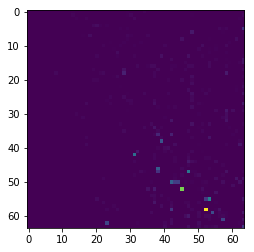

(3200, 64, 64)


In [45]:
# output_image64[:]
plt.imshow(inputImage64[10, :,:,10])
plt.show()
output_image64_intermediate = split256by256StackOnAxis(output_image)
# output_image64 = getOutputYVector(output_image64, numCats)
print(output_image64_intermediate.shape)


In [254]:
print('Accuracy', sum(np.array(accuracies).flatten())/len(accuracies)*100)


Accuracy 100.0


In [48]:
output_image64_intermediate[10].dtype

# plt.imshow(output_image64_intermediate[10])
# plt.show()

dtype('float16')

In [148]:
print(datetime.datetime.now())
WaterWayMask = generateWaterWayMask(waterway, 400)
inputImage, output_image = generateMinibatch(minibatches[10])
# print(inputImage.dtype)
# print(output_image.dtype)
inputImage64, output_image64 = transformTo64(inputImage, output_image,34)
# print(inputImage64.dtype)
# print(output_image64.dtype)
output_image64 = output_image64[WaterWayMask]
inputImage64 = inputImage64[WaterWayMask]
# print(inputImage64.dtype)
# print(output_image64.dtype)
print(datetime.datetime.now())


2018-12-06 18:59:36.103546


/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/muhammadayub/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


(array([0]),)
(array([0]),)
2018-12-06 18:59:43.296475


In [143]:
print(inputImage64.shape)
print(output_image64.shape)
print(inputImage64.dtype)
print(output_image64.dtype)
print(len(WaterWayMask))

(1600, 64, 64, 26)
(1600, 34)
float64
float64
1600
